# Airbus Ship Detection Challenge
Find ships on satellite images as quickly as possible

## Prepare datasets
The train_ship_segmentations.csv file provides the ground truth (in run-length encoding format) for the training images. The sample_submission files contains the images in the test images.

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import time

from skimage.data import imread
import matplotlib.pyplot as plt
import os
import random
np.set_printoptions(threshold=np.inf)   # print all numpy ndarray

## For MS COCO
import datetime
import json
import re
import fnmatch
from pycococreatortools import pycococreatortools



Specify datasets location

In [2]:
datasets_base = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/'

dataset_train = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_v2'
csv_train =     '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_ship_segmentations_v2.csv'

dataset_test  = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/test_v2'
csv_test =      '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/final.csv'   # should not use .csv file with empty image !

### Delete useless images

Total number of ship

In [3]:
# read_csv_file
df = pd.read_csv(csv_train)

print(type(df))
totalLines = df.shape[0]
print("Dataframe lines: ",df.shape[0])
print("Dataframe dimension: ",df.shape)

<class 'pandas.core.frame.DataFrame'>
Dataframe lines:  231723
Dataframe dimension:  (231723, 2)


Drop the rows where at least one element is missing. (delete annotations without ship)

In [4]:
df = df.dropna(axis=0)
num_of_ships = df.shape[0]
print("Instances: ",num_of_ships)
# print("percent of useful data: ", num_of_ships / totalLines * 100)

Instances:  81723


Create an empty set to store images with ship. The reason we use set is to avoid duplicate elements.
Note that the set method initialize images with an empty set.

Use df.iloc[] to access elements in the 2d array https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
We only care about the id of the image in col 1. The return type of df.iloc[line,0] is a string.

ims is a list which stores all the file name (.jpg) stored in the training set folder.

In [5]:
images = set()
# print(type(df.iloc[1, 0]))
for line in range(num_of_ships):
    if df.iloc[line,0] not in images:
        images.add(df.iloc[line,0])
print("Images with ship: ",len(images))

# Delete images without ship
count = 0
ims = os.listdir(dataset_train)
# print(type(ims))
# print(ims[0])

for im in ims:
    if im not in images:
        os.remove(os.path.join(dataset_train, im))
        print(im, "REMOVED")
        count += 1
print('%d images is deleted.'%(count))

Images with ship:  42556
0 images is deleted.


### Show RLE

#### Convert RLE to numpy
Convert mask_rle, a string that stores mask information, to np.ndarry(np.unit8). The reason we let starts -= 1 is because numpy array starts at index 0.  


asarray() converts a list to a numpy array. 

the double colon (::) gets every n-th element from the list / array

The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc. If the passed iterators have different lengths, the iterator with the least items decides the length of the new iterator.



In [6]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

# shape: (height,width) , 1 - mask, 0 - background
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    print(type(s[0]))
    starts =  np.asarray(s[0::2], dtype=int)
    lengths = np.asarray(s[1::2], dtype=int)

    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

#### Show Mask

<class 'str'>
Area:  12669


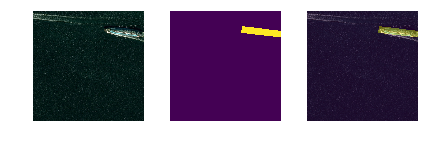

In [7]:
def csv_show_rle(ImageId, dataset_dir, df):
    img = imread(os.path.join(dataset_dir, ImageId))
    rle_masks = df.loc[df['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in rle_masks:
        binary_mask = rle_decode(mask)
        print('Area: ', np.sum(binary_mask))
        all_masks += binary_mask

    fig, axarr = plt.subplots(1, 3)
    axarr[0].axis('off'),
    axarr[1].axis('off'),
    axarr[2].axis('off')
    axarr[0].imshow(img),
    axarr[1].imshow(all_masks),
    axarr[2].imshow(img)
    axarr[2].imshow(all_masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    # plt.savefig( os.path.join(ROOT_DIR, '../tmp', 'tmp.png') )
    plt.show()


# dataset_train = '../datasets/ships_train2018'
# dataset_test  = '../datasets/ships_test2018'
# csv_train =     '../datasets/train_ship_segmentations_v2.csv'
# csv_test =      '../2_submit/final.csv'   # should not use .csv file with empty image !

df = pd.read_csv(csv_train)
# ImageId_list = ['0ba29cbcf.jpg', '00fd8e126.jpg', '0b1b3d75b.jpg']
ImageId_list = os.listdir(dataset_train)
ImageId = random.choice(ImageId_list)
csv_show_rle(ImageId, dataset_train, df)

### Convert RLE to MS COCO Format

In [8]:
IMAGE_DIR = dataset_train
start_time = time.time() # record time
df = pd.read_csv(csv_train)

INFO = {
    "description": "Kaggle Dataset",
    "url": "https://github.com/pascal1129",
    "version": "0.1.0",
    "year": 2018,
    "contributor": "ztzhan",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License",
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
    }
]

CATEGORIES = [
    {
        'id': 1,
        'name': 'ship',
        'supercategory': 'ship',
    },
]



# json file
coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],   # we will append some data here later
    "annotations": []
}


'''
keep files ended in .jpeg or .jpg
'''
def filter_for_jpeg(root, files):
    file_types = ['*.jpeg', '*.jpg']
    file_types = r'|'.join([fnmatch.translate(x) for x in file_types])
    files = [os.path.join(root, f) for f in files]
    files = [f for f in files if re.match(file_types, f)]
    return files

def save_bad_ann(image_name, mask, segmentation_id):
    img = imread(os.path.join(IMAGE_DIR, image_name))
    fig, axarr = plt.subplots(1, 3)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(mask)
    axarr[2].imshow(img)
    axarr[2].imshow(mask, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    if not os.path.exists(datasets_base+'/tmp'):
        os.makedirs(datasets_base+'/tmp')
        print('make a new dir to store bad ann')
    plt.savefig( datasets_base+'/tmp/'+ image_name.split('.')[0] +'_' +str(segmentation_id) +'.png') 
    plt.close()

    

## main method starts here
image_id = 1
segmentation_id = 1


'''
os.walk(top, topdown=True, onerror=None, followlinks=False) 

Generate the file names in a directory tree by walking the tree either top-down or bottom-up. 
For each directory in the tree rooted at directory top (including top itself), 
it yields a 3-tuple (dirpath, dirnames, filenames).

dirpath is a string, the path to the directory. 
dirnames is a list of the names of the subdirectories in dirpath (excluding '.' and '..'). 
filenames is a list of the names of the non-directory files in dirpath. 
Note that the names in the lists contain no path components. 
To get a full path (which begins with top) to a file or directory in dirpath, do os.path.join(dirpath, name).
'''


for root, _, files in os.walk(IMAGE_DIR): # In fact this is not a real for loop, it only loops once
#     print('type(root)', type(root))
#     print('type(_)', type(_))
#     print('type(files)', type(files))
    print((root))
#     print((_)) # this one is not needed since it list all the folders
#     print((files)) # this is a list of file's base name

# https://docs.python.org/zh-cn/3/library/multiprocessing.html#module-multiprocessing.sharedctypes

    image_paths = filter_for_jpeg(root, files)  # complete path (file name included)
    num_of_image_files = len(image_paths) 

    # traverse through all images
    for image_path in image_paths:
        # create image information
        image = Image.open(image_path)
        image_name = os.path.basename(image_path) # that is the file name, complete path = dir name + basename
        image_info = pycococreatortools.create_image_info(
            image_id, image_name, image.size)
        coco_output["images"].append(image_info)

        # get mask of image, note that each image may contain multiple masks, do not forget the tolist()
        rle_masks = df.loc[df['ImageId'] == image_name, 'EncodedPixels'].tolist() 
        num_of_rle_masks = len(rle_masks)
        
        print(image_name, '# of masks', num_of_rle_masks)
        
        for index in range(num_of_rle_masks):
            binary_mask = rle_decode(rle_masks[index])
            class_id = 1    # all image (mask) has the lable 1, according to which we've defined before
            category_info = {'id': class_id, 'is_crowd': 0}
            annotation_info = pycococreatortools.create_annotation_info(
                segmentation_id, image_id, category_info, binary_mask,
                image.size, tolerance=2)

            # we do not keep all the images since some of them were not well annotated
            # 
            if annotation_info is not None: # if ann quality is too low we do not assign ann_info
                coco_output["annotations"].append(annotation_info)
            else:
                save_bad_ann(image_name, binary_mask, segmentation_id)

            # in any case, no matter good or bad ann, assign a seg_id
            segmentation_id = segmentation_id + 1   

        print("%d of %d is done."%(image_id,num_of_image_files))
        image_id = image_id + 1

with open( (datasets_base + '/instances_ships_train2018.json'), 'w') as output_json_file:
    # json.dump(coco_output, output_json_file)
    json.dump(coco_output, output_json_file, indent=4)
    
print("--- %s seconds ---" % (time.time() - start_time)) 

/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_v2
000155de5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
000194a2d.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2 of 42556 is done.
00021ddc3.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3 of 42556 is done.
0002756f7.jpg # of masks 2
<class 'str'>
<class 'str'>
4 of 42556 is done.
00031f145.jpg # of masks 1
<class 'str'>
5 of 42556 is done.
000532683.jpg # of masks 2
<class 'str'>
<class 'str'>
6 of 42556 is done.
00053c6ba.jpg # of masks 1
<class 'str'>
7 of 42556 is done.
0005d01c8.jpg # of masks 2
<class 'str'>
<class 'str'>
8 of 42556 is done.
872cd64f0.jpg # of masks 1
<class 'str'>
9 of 42556 is done.
872de369e.jpg # of masks 1
<class 'str'>
10 of 42556 is done.
3a06e90d4.jpg # of masks 1
<class 'str'>
11 of 42556 is done.
d24ca864b.jpg # of masks 2
<class 'str'>
<class 'str

9307ba61e.jpg # of masks 2
<class 'str'>
<class 'str'>
106 of 42556 is done.
930b6be1c.jpg # of masks 1
<class 'str'>
107 of 42556 is done.
930f575fa.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
108 of 42556 is done.
930fb2044.jpg # of masks 2
<class 'str'>
<class 'str'>
109 of 42556 is done.
93190ce06.jpg # of masks 1
<class 'str'>
110 of 42556 is done.
931a89ac1.jpg # of masks 1
<class 'str'>
111 of 42556 is done.
93221b82b.jpg # of masks 1
<class 'str'>
112 of 42556 is done.
9326704a8.jpg # of masks 1
<class 'str'>
113 of 42556 is done.
93290f954.jpg # of masks 2
<class 'str'>
<class 'str'>
114 of 42556 is done.
932bcbb24.jpg # of masks 1
<class 'str'>
115 of 42556 is done.
932ef626d.jpg # of masks 2
<class 'str'>
<class 'str'>
116 of 42556 is done.
9331e5f62.jpg # of masks 2
<class 'str'>
<class 'str'>
117 of 42556 is done.
933431d97.jpg # of masks 1
<class 'str'>
118 of 42556 is done.
933b23528.jpg # of masks 1
<class 'str'>
119 of 42556 is done.
933f75634.jpg # of m

<class 'str'>
215 of 42556 is done.
db9c8a2bd.jpg # of masks 1
<class 'str'>
216 of 42556 is done.
b5c90f218.jpg # of masks 2
<class 'str'>
<class 'str'>
217 of 42556 is done.
b5c94e650.jpg # of masks 2
<class 'str'>
<class 'str'>
218 of 42556 is done.
b5c9591d5.jpg # of masks 1
<class 'str'>
219 of 42556 is done.
de855d79b.jpg # of masks 1
<class 'str'>
220 of 42556 is done.
de86d704a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
221 of 42556 is done.
de87a31d8.jpg # of masks 1
<class 'str'>
222 of 42556 is done.
28457371a.jpg # of masks 1
<class 'str'>
223 of 42556 is done.
284814a44.jpg # of masks 1
<class 'str'>
224 of 42556 is done.
284e59aca.jpg # of masks 2
<class 'str'>
<class 'str'>
225 of 42556 is done.
cd0080227.jpg # of masks 1
<class 'str'>
226 of 42556 is done.
cd03be885.jpg # of masks 1
<class 'str'>
227 of 42556 is done.
cd08b0bd6.jpg # of masks 1
<class 'str'>
228 of 42556 is done.
cd0d4090e.jpg # of masks 1
<class 'str'>
229 of

cac7e5159.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
332 of 42556 is done.
09d49287d.jpg # of masks 2
<class 'str'>
<class 'str'>
333 of 42556 is done.
1ee4150d2.jpg # of masks 2
<class 'str'>
<class 'str'>
334 of 42556 is done.
1ee44196f.jpg # of masks 1
<class 'str'>
335 of 42556 is done.
1ee566913.jpg # of masks 1
<class 'str'>
336 of 42556 is done.
905f5cc96.jpg # of masks 2
<class 'str'>
<class 'str'>
337 of 42556 is done.
fb5782131.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
338 of 42556 is done.
53e88abe7.jpg # of masks 1
<class 'str'>
339 of 42556 is done.
1bca838a2.jpg # of masks 2
<class 'str'>
<class 'str'>
340 of 42556 is done.
1bcb40771.jpg # of masks 1
<class 'str'>
341 of 42556 is done.
1bcbd8e86.jpg # of masks 1
<class 'str'>
342 of 42556 is done.
1bcc00185.jpg # of masks 1
<class 'str'>
343 of 42556 is done.
4a2185cdc.jpg # of masks 1
<class 'str'>
344 of 42556 is done.
4a21ee62d.jpg # of masks 2
<class 'str'>
<class 'str'>


a57649910.jpg # of masks 1
<class 'str'>
440 of 42556 is done.
a57867903.jpg # of masks 1
<class 'str'>
441 of 42556 is done.
a5790a2e2.jpg # of masks 1
<class 'str'>
442 of 42556 is done.
d38e1857c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
443 of 42556 is done.
d39002642.jpg # of masks 1
<class 'str'>
444 of 42556 is done.
ce7a0f083.jpg # of masks 1
<class 'str'>
445 of 42556 is done.
ce7a9e453.jpg # of masks 2
<class 'str'>
<class 'str'>
446 of 42556 is done.
ce7c2d412.jpg # of masks 1
<class 'str'>
447 of 42556 is done.
ce7ce4fdd.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
448 of 42556 is done.
666d66bfa.jpg # of masks 1
<class 'str'>
449 of 42556 is done.
666e8563f.jpg # of masks 1
<class 'str'>
450 of 42556 is done.
666f2acb9.jpg # of masks 1
<class 'str'>
451 of 42556 is done.
666ff7ace.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

<class 'str'>
<class 'str'>
555 of 42556 is done.
8b4c9584a.jpg # of masks 1
<class 'str'>
556 of 42556 is done.
635504fb5.jpg # of masks 1
<class 'str'>
557 of 42556 is done.
ddacdf5f1.jpg # of masks 2
<class 'str'>
<class 'str'>
558 of 42556 is done.
ddad0ced8.jpg # of masks 1
<class 'str'>
559 of 42556 is done.
ddad8ae16.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
560 of 42556 is done.
ddaf4de2f.jpg # of masks 1
<class 'str'>
561 of 42556 is done.
82055eccc.jpg # of masks 1
<class 'str'>
562 of 42556 is done.
8207b43e9.jpg # of masks 1
<class 'str'>
563 of 42556 is done.
baf1c4609.jpg # of masks 1
<class 'str'>
564 of 42556 is done.
baf405489.jpg # of masks 1
<class 'str'>
565 of 42556 is done.
bd2044918.jpg # of masks 1
<class 'str'>
566 of 42556 is done.
bd20cf84e.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
567 of 42556 is done.
bd221fb6a.jpg # of masks 1

<class 'str'>
665 of 42556 is done.
3224933c1.jpg # of masks 1
<class 'str'>
666 of 42556 is done.
32277b0a7.jpg # of masks 1
<class 'str'>
667 of 42556 is done.
322946655.jpg # of masks 1
<class 'str'>
668 of 42556 is done.
322e4aa7b.jpg # of masks 1
<class 'str'>
669 of 42556 is done.
322f8a8e5.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
670 of 42556 is done.
3231880bc.jpg # of masks 1
<class 'str'>
671 of 42556 is done.
3236047eb.jpg # of masks 1
<class 'str'>
672 of 42556 is done.
1a9316a6d.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
673 of 42556 is done.
2782d61a0.jpg # of masks 1
<class 'str'>
674 of 42556 is done.
2783506ad.jpg # of masks 1
<class 'str'>
675 of 42556 is done.
5d6a6b550.jpg # of masks 2
<class 'str'>
<class 'str'>
676 of 42556 is done.
5d6c

772 of 42556 is done.
85452646a.jpg # of masks 1
<class 'str'>
773 of 42556 is done.
8547e21e3.jpg # of masks 1
<class 'str'>
774 of 42556 is done.
8548aa678.jpg # of masks 1
<class 'str'>
775 of 42556 is done.
7e2742873.jpg # of masks 1
<class 'str'>
776 of 42556 is done.
7e2d1c799.jpg # of masks 1
<class 'str'>
777 of 42556 is done.
7e328f84b.jpg # of masks 1
<class 'str'>
778 of 42556 is done.
7e3b615ca.jpg # of masks 1
<class 'str'>
779 of 42556 is done.
7e45176db.jpg # of masks 1
<class 'str'>
780 of 42556 is done.
7e481c03d.jpg # of masks 2
<class 'str'>
<class 'str'>
781 of 42556 is done.
7e4a89d48.jpg # of masks 1
<class 'str'>
782 of 42556 is done.
7e513f72c.jpg # of masks 2
<class 'str'>
<class 'str'>
783 of 42556 is done.
7e5631fcb.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
784 of 42556 is done.
7e5a3451b.jpg # of masks 1
<class 'str'>
785 of 42556 is done.
7e671c353.jpg # of masks 1
<class 'str'>
786 of 42556 is done.
7e68226a5.jpg # of masks 2
<class 'str'>

d6f5a3f16.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
892 of 42556 is done.
d6f5c7649.jpg # of masks 1
<class 'str'>
893 of 42556 is done.
fc61d98be.jpg # of masks 1
<class 'str'>
894 of 42556 is done.
fc624e92a.jpg # of masks 1
<class 'str'>
895 of 42556 is done.
fc64a24c7.jpg # of masks 1
<class 'str'>
896 of 42556 is done.
317b79b00.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
897 of 42556 is done.
bdb07044f.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
898 of 42556 is done.
c062957f2.jpg # of masks 1
<class 'str'>
899 of 42556 is done.
c062e8830.jpg # of masks 2
<class 'str'>
<class 'str'>
900 of 42556 is done.
bc743ae74.jpg # of masks 1
<class 'str'>
901 of 42556 is done.
bc78b5f3a.jpg # of masks 1
<class 'str'>
902 of 42556 is done.
bc7bf556b.jpg # of masks 1
<class 'str'>
903 of 42556 is done.
bc85aa6de.jpg # of masks 1
<class 'str'>
904 of 

f97fd4915.jpg # of masks 1
<class 'str'>
994 of 42556 is done.
f98022dd0.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
995 of 42556 is done.
f9821ea00.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
996 of 42556 is done.
f982932f1.jpg # of masks 1
<class 'str'>
997 of 42556 is done.
f982af57b.jpg # of masks 1
<class 'str'>
998 of 42556 is done.
0d4704282.jpg # of masks 2
<class 'str'>
<class 'str'>
999 of 42556 is done.
0d478d034.jpg # of masks 1
<class 'str'>
1000 of 42556 is done.
0d4adbb1f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1001 of 42556 is done.
6aed06a66.jpg # of masks 1
<class 'str'>
1002 of 42556 is done.
6aedf0e18.jpg # of masks 2
<class 'str'>
<class 'str'>
1003 of 42556 is done.
8aba2fd7a.jpg # of masks 2
<class 'str'>
<class 'str'>
1004 of 42556 is done.
f251102f3.jpg # of masks 1
<class 'str'>
1005 of 42556 is done.

f4bd4c5da.jpg # of masks 1
<class 'str'>
1108 of 42556 is done.
f4c146241.jpg # of masks 1
<class 'str'>
1109 of 42556 is done.
f4ca94419.jpg # of masks 1
<class 'str'>
1110 of 42556 is done.
f4ccec6cb.jpg # of masks 2
<class 'str'>
<class 'str'>
1111 of 42556 is done.
f4ce60ef1.jpg # of masks 2
<class 'str'>
<class 'str'>
1112 of 42556 is done.
f4d366063.jpg # of masks 1
<class 'str'>
1113 of 42556 is done.
f4d80a517.jpg # of masks 1
<class 'str'>
1114 of 42556 is done.
f4df07423.jpg # of masks 1
<class 'str'>
1115 of 42556 is done.
f4e5e812b.jpg # of masks 1
<class 'str'>
1116 of 42556 is done.
f4e953b03.jpg # of masks 1
<class 'str'>
1117 of 42556 is done.
f4ee95d50.jpg # of masks 1
<class 'str'>
1118 of 42556 is done.
f4f0a410f.jpg # of masks 1
<class 'str'>
1119 of 42556 is done.
f4f653eb9.jpg # of masks 1
<class 'str'>
1120 of 42556 is done.
f4fab3af7.jpg # of masks 1
<class 'str'>
1121 of 42556 is done.
f500bd3ce.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 

<class 'str'>
1220 of 42556 is done.
754c25bea.jpg # of masks 1
<class 'str'>
1221 of 42556 is done.
754e35e53.jpg # of masks 1
<class 'str'>
1222 of 42556 is done.
d5c217989.jpg # of masks 1
<class 'str'>
1223 of 42556 is done.
d5c3518f8.jpg # of masks 1
<class 'str'>
1224 of 42556 is done.
f347168b6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1225 of 42556 is done.
f34963a22.jpg # of masks 1
<class 'str'>
1226 of 42556 is done.
f349ce414.jpg # of masks 1
<class 'str'>
1227 of 42556 is done.
f34aa9d4c.jpg # of masks 2
<class 'str'>
<class 'str'>
1228 of 42556 is done.
596592a33.jpg # of masks 1
<class 'str'>
1229 of 42556 is done.
360e6acc1.jpg # of masks 1
<class 'str'>
1230 of 42556 is done.
3610ec595.jpg # of masks 2
<class 'str'>
<class 'str'>
1231 of 42556 is done.
3cb88d629.jpg # of masks 2
<class 'str'>
<class 'str'>
1232 of 42556 is done.
3cc9075cf.jpg # of masks 1
<class 'str'>
1233 of 42556 is done.
3cd0e00c2.jpg # of masks 1
<class 'str'>
1234 of 42556 is don

704361353.jpg # of masks 1
<class 'str'>
1332 of 42556 is done.
645c2642e.jpg # of masks 1
<class 'str'>
1333 of 42556 is done.
645c77ddb.jpg # of masks 1
<class 'str'>
1334 of 42556 is done.
645ceb3c6.jpg # of masks 1
<class 'str'>
1335 of 42556 is done.
e5b114139.jpg # of masks 2
<class 'str'>
<class 'str'>
1336 of 42556 is done.
e5b1d8724.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1337 of 42556 is done.
e5b285b8e.jpg # of masks 1
<class 'str'>
1338 of 42556 is done.
e5b373889.jpg # of masks 1
<class 'str'>
1339 of 42556 is done.
4e2bca446.jpg # of masks 1
<class 'str'>
1340 of 42556 is done.
4e2fdf4fa.jpg # of masks 1
<class 'str'>
1341 of 42556 is done.
4e3393ed5.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1342 of 42556 is done.
4e3f9df22.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<

<class 'str'>
1444 of 42556 is done.
a0c8b46e5.jpg # of masks 2
<class 'str'>
<class 'str'>
1445 of 42556 is done.
a0c8f4553.jpg # of masks 1
<class 'str'>
1446 of 42556 is done.
6b6635371.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1447 of 42556 is done.
6b663afaf.jpg # of masks 1
<class 'str'>
1448 of 42556 is done.
6b6689889.jpg # of masks 1
<class 'str'>
1449 of 42556 is done.
05a6cbc54.jpg # of masks 1
<class 'str'>
1450 of 42556 is done.
b56d15b7d.jpg # of masks 1
<class 'str'>
1451 of 42556 is done.
3abd75d1d.jpg # of masks 2
<class 'str'>
<class 'str'>
1452 of 42556 is done.
3abea2796.jpg # of masks 1
<class 'str'>
1453 of 42556 is done.
6c2cd4964.jpg # of masks 1
<class 'str'>
1454 of 42556 is done.
6c2dbd689.jpg # of masks 1
<class 'str'>
1455 of 42556 is done.
6c3065b42.jpg # of masks 1
<class 'str'>
1456 of 42556 is done.
872e51b21.jpg # of masks 1
<class 'str'>
1457 of 42556 is done.
87374134b.jpg # of masks 1
<class 'str'>
1458 of 42556 is done.
8739e3315.j

1545 of 42556 is done.
a3ba5c0b8.jpg # of masks 1
<class 'str'>
1546 of 42556 is done.
a3bb04b95.jpg # of masks 1
<class 'str'>
1547 of 42556 is done.
a3bc39e62.jpg # of masks 2
<class 'str'>
<class 'str'>
1548 of 42556 is done.
a3bc58a82.jpg # of masks 1
<class 'str'>
1549 of 42556 is done.
a3bcc4a50.jpg # of masks 2
<class 'str'>
<class 'str'>
1550 of 42556 is done.
90e8c65aa.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1551 of 42556 is done.
e322f442d.jpg # of masks 2
<class 'str'>
<class 'str'>
1552 of 42556 is done.
e324f13b4.jpg # of masks 1
<class 'str'>
1553 of 42556 is done.
e32634dff.jpg # of masks 1
<class 'str'>
1554 of 42556 is done.
49f255650.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1555 of 42556 is done.
693c28e4e.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1556 of 42556 is done.
693e1e4f8.jpg # of masks 6
<class '

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1653 of 42556 is done.
c4dd8a801.jpg # of masks 1
<class 'str'>
1654 of 42556 is done.
c4e5e0ef1.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1655 of 42556 is done.
c4e81b7e4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1656 of 42556 is done.
c4ec4793b.jpg # of masks 1
<class 'str'>
1657 of 42556 is done.
c4f266cfc.jpg # of masks 1
<class 'str'>
1658 of 42556 is done.
b40712941.jpg # of masks 2
<class 'str'>
<class 'str'>
1659 of 42556 is done.
2d6923fa6.jpg # of masks 1
<class 'str'>
1660 of 42556 is done.
2d6b546b0.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1661 of 42556 is done.
2d6b8a130.jpg # of masks 1
<class 'str'>
1662 of 42556 is done.
a71fb3ef4.jpg # of masks 2
<class 'str'>
<class 'str'>
1663 of 42556 is done.
a720edcd2.jpg # of masks 2
<class 'str'>
<c

<class 'str'>
1766 of 42556 is done.
215f28352.jpg # of masks 2
<class 'str'>
<class 'str'>
1767 of 42556 is done.
48b8dbe4d.jpg # of masks 1
<class 'str'>
1768 of 42556 is done.
48bae3234.jpg # of masks 1
<class 'str'>
1769 of 42556 is done.
23801cced.jpg # of masks 1
<class 'str'>
1770 of 42556 is done.
2381e0fcb.jpg # of masks 1
<class 'str'>
1771 of 42556 is done.
2382a9eeb.jpg # of masks 1
<class 'str'>
1772 of 42556 is done.
2383f0ee2.jpg # of masks 1
<class 'str'>
1773 of 42556 is done.
9db509cab.jpg # of masks 1
<class 'str'>
1774 of 42556 is done.
9db607768.jpg # of masks 1
<class 'str'>
1775 of 42556 is done.
a673759d8.jpg # of masks 1
<class 'str'>
1776 of 42556 is done.
a674982dd.jpg # of masks 1
<class 'str'>
1777 of 42556 is done.
a675f6243.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1778 of 42556 is done.
a67631c12.jpg # of masks 2
<class 'str'>
<class 'str'>
1779 of 42556 is done.
a2d5d051f.jpg # of masks 1
<class 'str'>
1780 of 42556 is don

b606f9e28.jpg # of masks 1
<class 'str'>
1881 of 42556 is done.
b608c9319.jpg # of masks 1
<class 'str'>
1882 of 42556 is done.
b60c90893.jpg # of masks 1
<class 'str'>
1883 of 42556 is done.
b6104b6b8.jpg # of masks 2
<class 'str'>
<class 'str'>
1884 of 42556 is done.
b615559b4.jpg # of masks 2
<class 'str'>
<class 'str'>
1885 of 42556 is done.
b61815304.jpg # of masks 1
<class 'str'>
1886 of 42556 is done.
b61bdee43.jpg # of masks 1
<class 'str'>
1887 of 42556 is done.
b6230d8d1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1888 of 42556 is done.
b626b87df.jpg # of masks 1
<class 'str'>
1889 of 42556 is done.
b62ccdef7.jpg # of masks 1
<class 'str'>
1890 of 42556 is done.
b630487cf.jpg # of masks 1
<class 'str'>
1891 of 42556 is done.
b635c4d10.jpg # of masks 1
<class 'str'>
1892 of 42556 is done.
b63ddf561.jpg # of masks 1
<class 'str'>
1893 of 42556 is done.
b63e3bf52.jpg # of masks 2
<class 'str'>
<class 'str'>
1894 of 42556 is done.
e647e9046.jpg # of masks 5
<class 

1993 of 42556 is done.
9975f81d2.jpg # of masks 1
<class 'str'>
1994 of 42556 is done.
997b5588d.jpg # of masks 1
<class 'str'>
1995 of 42556 is done.
997f4ee1a.jpg # of masks 1
<class 'str'>
1996 of 42556 is done.
9982eec7d.jpg # of masks 1
<class 'str'>
1997 of 42556 is done.
9988be79a.jpg # of masks 1
<class 'str'>
1998 of 42556 is done.
998c9abac.jpg # of masks 2
<class 'str'>
<class 'str'>
1999 of 42556 is done.
9991eb9fa.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2000 of 42556 is done.
9999b2c1b.jpg # of masks 1
<class 'str'>
2001 of 42556 is done.
999c51378.jpg # of masks 1
<class 'str'>
2002 of 42556 is done.
999f3667b.jpg # of masks 1
<class 'str'>
2003 of 42556 is done.
99a47f51c.jpg # of masks 1
<class 'str'>
2004 of 42556 is done.
99aecf87e.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2005 of 42556 is done.
99afe3265.jp

2113 of 42556 is done.
fa5d005a1.jpg # of masks 1
<class 'str'>
2114 of 42556 is done.
fa62d2625.jpg # of masks 2
<class 'str'>
<class 'str'>
2115 of 42556 is done.
f1468e24b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2116 of 42556 is done.
f1472dbce.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2117 of 42556 is done.
ee007a068.jpg # of masks 1
<class 'str'>
2118 of 42556 is done.
ee03724d3.jpg # of masks 2
<class 'str'>
<class 'str'>
2119 of 42556 is done.
ee07a3e75.jpg # of masks 1
<class 'str'>
2120 of 42556 is done.
ee0a09f8f.jpg # of masks 1
<class 'str'>
2121 of 42556 is done.
ee0fa0192.jpg # of masks 2
<class 'str'>
<class 'str'>
2122 of 42556 is done.
ee1261af0.jpg # of masks 1
<class 'str'>
2123 of 42556 is done.
ee153b679.jpg # of masks 2
<class 'str'>
<class 'str'>
2124 of 42556 is done.
ee1b53e14.jpg # of masks 1
<class 'str'>
2125 of 42556 is done.
ee1befaad.jpg # of masks 1


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2220 of 42556 is done.
6cde1d0a0.jpg # of masks 1
<class 'str'>
2221 of 42556 is done.
6cdf03a22.jpg # of masks 1
<class 'str'>
2222 of 42556 is done.
90a4440bc.jpg # of masks 2
<class 'str'>
<class 'str'>
2223 of 42556 is done.
90a676e50.jpg # of masks 2
<class 'str'>
<class 'str'>
2224 of 42556 is done.
90a6c9f53.jpg # of masks 2
<class 'str'>
<class 'str'>
2225 of 42556 is done.
90a78d8ba.jpg # of masks 1
<class 'str'>
2226 of 42556 is done.
8af90624a.jpg # of masks 1
<class 'str'>
2227 of 42556 is done.
8af955b94.jpg # of masks 1
<class 'str'>
2228 of 42556 is done.
602a43ad7.jpg # of masks 2
<class 'str'>
<class 'str'>
2229 of 42556 is done.
490c5e748.jpg # of masks 1
<class 'str'>
2230 of 42556 is done.
490d9fc64.jpg # of masks 1
<class 'str'>
2231 of 42556 is done.
cd49c91e1.jpg # of masks 1
<class 'str'>
2232 of 42556 is done.
06f6dfb49.jpg # of masks 1
<class 'str'>
2233 of 42556 is done.
06f8a3862.jpg # of masks 1
<class

2332 of 42556 is done.
8cfb570f6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2333 of 42556 is done.
8d028114a.jpg # of masks 1
<class 'str'>
2334 of 42556 is done.
fdfb621d9.jpg # of masks 1
<class 'str'>
2335 of 42556 is done.
fdfd96527.jpg # of masks 1
<class 'str'>
2336 of 42556 is done.
16ab74e98.jpg # of masks 1
<class 'str'>
2337 of 42556 is done.
16ab92d0e.jpg # of masks 1
<class 'str'>
2338 of 42556 is done.
16ac0d610.jpg # of masks 1
<class 'str'>
2339 of 42556 is done.
f1bbb8107.jpg # of masks 1
<class 'str'>
2340 of 42556 is done.
f1bbf5edf.jpg # of masks 2
<class 'str'>
<class 'str'>
2341 of 42556 is done.
f1bd73e43.jpg # of masks 1
<class 'str'>
2342 of 42556 is done.
7198ef47a.jpg # of masks 1
<class 'str'>
2343 of 42556 is done.
7199544f3.jpg # of masks 2
<class 'str'>
<class 'str'>
2344 of 42556 is done.
719a6dbbb.jpg # of masks 1
<class 'str'>
2345 of 42556 is done.
719b2d99d.jpg # of masks 1
<class 'str'>
2346 of 42556 is done.
f788bba0f.jpg # of masks 

2446 of 42556 is done.
2cca5203a.jpg # of masks 1
<class 'str'>
2447 of 42556 is done.
2ccb55171.jpg # of masks 1
<class 'str'>
2448 of 42556 is done.
6fb6e3f91.jpg # of masks 1
<class 'str'>
2449 of 42556 is done.
6fb94292d.jpg # of masks 1
<class 'str'>
2450 of 42556 is done.
e1713d2e4.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2451 of 42556 is done.
e1719ebde.jpg # of masks 2
<class 'str'>
<class 'str'>
2452 of 42556 is done.
e17305d6f.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2453 of 42556 is done.
11118d98f.jpg # of masks 1
<class 'str'>
2454 of 42556 is done.
4de71977e.jpg # of masks 1
<class 'str'>
2455 of 42556 is done.
c9ff852f4.jpg # of masks 1
<class 'str'>
2456 of 42556 is done.
c9fffae48.jpg # of masks 2
<class 'str'>
<class 'str'>
2457 of 42556 is done.
ca0148e42.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2458 of 42556 is done.
3e794910d.jpg # of masks 1


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2562 of 42556 is done.
d464f96c6.jpg # of masks 1
<class 'str'>
2563 of 42556 is done.
9479030fe.jpg # of masks 1
<class 'str'>
2564 of 42556 is done.
947bf63e1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2565 of 42556 is done.
947d16588.jpg # of masks 1
<class 'str'>
2566 of 42556 is done.
c277f030b.jpg # of masks 1
<class 'str'>
2567 of 42556 is done.
569cb706e.jpg # of masks 2
<class 'str'>
<class 'str'>
2568 of 42556 is done.
569d2bbea.jpg # of masks 1
<class 'str'>
2569 of 42556 is done.
569d5e830.jpg # of masks 1
<class 'str'>
2570 of 42556 is done.
52872ffcc.jpg # of masks 1
<class 'str'>
2571 of 42556 is done.
528b7dbb6.jpg # of masks 1
<class 'str'>
2572 of 42556 is done.
528fb7b90.jpg # of masks 1
<class 'str'>
2573 of 42556 is done.
529226937.jpg # of masks 1
<class 'str'>
2574 of 42556 is done.
5296f2e16.jpg # of masks 1
<class 'str'>
2575 of 42556 is done.
529aac9ae.jpg # of masks 1
<class 'str'>
2576 o

<class 'str'>
<class 'str'>
2672 of 42556 is done.
9b296446c.jpg # of masks 1
<class 'str'>
2673 of 42556 is done.
9b2aa6f4a.jpg # of masks 1
<class 'str'>
2674 of 42556 is done.
29f087909.jpg # of masks 1
<class 'str'>
2675 of 42556 is done.
29f283353.jpg # of masks 1
<class 'str'>
2676 of 42556 is done.
29f300ee0.jpg # of masks 1
<class 'str'>
2677 of 42556 is done.
5d354833d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2678 of 42556 is done.
5d3551e58.jpg # of masks 1
<class 'str'>
2679 of 42556 is done.
5cf1ca7de.jpg # of masks 1
<class 'str'>
2680 of 42556 is done.
5cf2f979b.jpg # of masks 1
<class 'str'>
2681 of 42556 is done.
5cf84f408.jpg # of masks 2
<class 'str'>
<class 'str'>
2682 of 42556 is done.
5cfb71704.jpg # of masks 1
<class 'str'>
2683 of 42556 is done.
5cfe7f20b.jpg # of masks 2
<class 'str'>
<class 'str'>
2684 of 42556 is done.
5d0018daf.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


<class 'str'>
2778 of 42556 is done.
c51ddef91.jpg # of masks 2
<class 'str'>
<class 'str'>
2779 of 42556 is done.
c51fd1a97.jpg # of masks 2
<class 'str'>
<class 'str'>
2780 of 42556 is done.
fbedd4a48.jpg # of masks 1
<class 'str'>
2781 of 42556 is done.
fbedeab76.jpg # of masks 1
<class 'str'>
2782 of 42556 is done.
fbefa02ce.jpg # of masks 1
<class 'str'>
2783 of 42556 is done.
766a4bef2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2784 of 42556 is done.
766c215ab.jpg # of masks 1
<class 'str'>
2785 of 42556 is done.
12d0f662c.jpg # of masks 1
<class 'str'>
2786 of 42556 is done.
ea252ef0c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2787 of 42556 is done.
ea2583633.jpg # of masks 1
<class 'str'>
2788 of 42556 is done.
ea2625825.jpg # of masks 1
<class 'str'>
2789 of 42556 is done.
a6f562581.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2790 of 42556 is done.
a6f59d535.jpg # of masks 2
<class 'str'>
<class 'str'>
2791 of 42556 is done.
a6f75

78d83d53c.jpg # of masks 1
<class 'str'>
2888 of 42556 is done.
78d8769c3.jpg # of masks 1
<class 'str'>
2889 of 42556 is done.
78d9a85d1.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2890 of 42556 is done.
85791cda7.jpg # of masks 2
<class 'str'>
<class 'str'>
2891 of 42556 is done.
8579af6c4.jpg # of masks 1
<class 'str'>
2892 of 42556 is done.
857af5667.jpg # of masks 1
<class 'str'>
2893 of 42556 is done.
857b5a7da.jpg # of masks 2
<class 'str'>
<class 'str'>
2894 of 42556 is done.
827c1de7f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2895 of 42556 is done.
8288d68a1.jpg # of masks 1
<class 'str'>
2896 of 42556 is done.
828f9cc20.jpg # of masks 1
<class 'str'>
2897 of 42556 is done.
8297675ae.jpg # of masks 1
<class 'str'>
2898 of 42556 is done.
829a1427a.jpg # of masks 1
<class 'str'>
2899 of 42556 is done.
829e1140b.jpg # of masks 1
<class 'str'>
2900 of 42556 is done.
82a31ac00.jpg # of masks 1
<class 'str'>
2

4a566b7c3.jpg # of masks 2
<class 'str'>
<class 'str'>
2998 of 42556 is done.
4a5a9a20f.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2999 of 42556 is done.
4a5cbb68d.jpg # of masks 1
<class 'str'>
3000 of 42556 is done.
ca95f95e1.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3001 of 42556 is done.
8c3e4558d.jpg # of masks 2
<class 'str'>
<class 'str'>
3002 of 42556 is done.
31c9d8cd8.jpg # of masks 2
<class 'str'>
<class 'str'>
3003 of 42556 is done.
2dcfa65df.jpg # of masks 1
<class 'str'>
3004 of 42556 is done.
2dd5c909a.jpg # of masks 2
<class 'str'>
<class 'str'>
3005 of 42556 is done.
2ddae3885.jpg # of masks 1
<class 'str'>
3006 of 42556 is done.
2dded22fe.jpg # of masks 1
<class 'str'>
3007 of 42556 is done.
2de1f9bf0.jpg # of masks 1
<class 'str'>
3008 of 42556 is done.
2de5f1fc6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3009 of 42556 is done.
2deb5a35

<class 'str'>
<class 'str'>
<class 'str'>
3107 of 42556 is done.
f2742b996.jpg # of masks 2
<class 'str'>
<class 'str'>
3108 of 42556 is done.
b0493275e.jpg # of masks 2
<class 'str'>
<class 'str'>
3109 of 42556 is done.
b04a28c4b.jpg # of masks 1
<class 'str'>
3110 of 42556 is done.
b04bdb64e.jpg # of masks 1
<class 'str'>
3111 of 42556 is done.
b04bdca89.jpg # of masks 1
<class 'str'>
3112 of 42556 is done.
0dcc5d086.jpg # of masks 1
<class 'str'>
3113 of 42556 is done.
0dcd762ec.jpg # of masks 1
<class 'str'>
3114 of 42556 is done.
0dcec85fc.jpg # of masks 1
<class 'str'>
3115 of 42556 is done.
0baa70144.jpg # of masks 1
<class 'str'>
3116 of 42556 is done.
0bae7712d.jpg # of masks 1
<class 'str'>
3117 of 42556 is done.
0bb345151.jpg # of masks 1
<class 'str'>
3118 of 42556 is done.
0bbc681ee.jpg # of masks 1
<class 'str'>
3119 of 42556 is done.
0bbf29b74.jpg # of masks 1
<class 'str'>
3120 of 42556 is done.
0bc33ebe7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3121 o

<class 'str'>
3226 of 42556 is done.
bdcde4696.jpg # of masks 1
<class 'str'>
3227 of 42556 is done.
bdcedeeb2.jpg # of masks 1
<class 'str'>
3228 of 42556 is done.
bdcf91df1.jpg # of masks 1
<class 'str'>
3229 of 42556 is done.
bdd078047.jpg # of masks 1
<class 'str'>
3230 of 42556 is done.
351ced307.jpg # of masks 1
<class 'str'>
3231 of 42556 is done.
351e0444d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3232 of 42556 is done.
0ff267516.jpg # of masks 1
<class 'str'>
3233 of 42556 is done.
e3044cb69.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3234 of 42556 is done.
b42f7f532.jpg # of masks 1
<class 'str'>
3235 of 42556 is done.
b42ff6a59.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3236 of 42556 is done.
aecedce49.jpg # of masks 1
<class 'str'>
3237 of 42556 is done.
aecf6c252.jpg # of masks 1
<class 'str'>
3238 of 42556 is done.
9e8a76e1e.jpg # of masks 1
<class 'str'>
3239 of 42556 is done.
9e8ce8d74.jpg # of 

c8f786f5d.jpg # of masks 1
<class 'str'>
3335 of 42556 is done.
c8fa9e981.jpg # of masks 1
<class 'str'>
3336 of 42556 is done.
c901f97d9.jpg # of masks 1
<class 'str'>
3337 of 42556 is done.
c9084f216.jpg # of masks 2
<class 'str'>
<class 'str'>
3338 of 42556 is done.
c90c8bc39.jpg # of masks 1
<class 'str'>
3339 of 42556 is done.
c9115cb2f.jpg # of masks 1
<class 'str'>
3340 of 42556 is done.
c9146a404.jpg # of masks 1
<class 'str'>
3341 of 42556 is done.
c91912484.jpg # of masks 1
<class 'str'>
3342 of 42556 is done.
c91f466da.jpg # of masks 2
<class 'str'>
<class 'str'>
3343 of 42556 is done.
c92a71ea8.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3344 of 42556 is done.
c92c9514a.jpg # of masks 1
<class 'str'>
3345 of 42556 is done.
c9370288f.jpg # of masks 2
<class 'str'>
<class 'str'>
3346 of 42556 is done.
c93ba2cd8.jpg # of masks 1
<class 'str'>
3347 of 42556 is done.
c93f229ef.jpg # of masks 1
<class 'str'>
3348 of 42556 is done.
c94559496.jpg # of masks 14
<class

<class 'str'>
<class 'str'>
3443 of 42556 is done.
f4075b20b.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3444 of 42556 is done.
f407ce1b9.jpg # of masks 2
<class 'str'>
<class 'str'>
3445 of 42556 is done.
f4080a831.jpg # of masks 1
<class 'str'>
3446 of 42556 is done.
f40830d1c.jpg # of masks 1
<class 'str'>
3447 of 42556 is done.
123475d8b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3448 of 42556 is done.
fd0d324a7.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3449 of 42556 is done.
fd0e3997b.jpg # of masks 1
<class 'str'>
3450 of 42556 is done.
fd10ac585.jpg # of masks 1
<class 'str'>
3451 of 42556 is done.
5e2d511ff.jpg # of masks 1
<class 'str'>
3452 of 42556 is done.
ac623dafc.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3453 of 42556 is done.
ac625e128.jpg # of masks 1
<class 'str'>
3454 of 42556 is done.
67f6e09c8.jpg # of masks 1
<class '

3556 of 42556 is done.
9c689e89b.jpg # of masks 1
<class 'str'>
3557 of 42556 is done.
9c69490d7.jpg # of masks 1
<class 'str'>
3558 of 42556 is done.
e7dcfbb3a.jpg # of masks 1
<class 'str'>
3559 of 42556 is done.
e7dd9b0d6.jpg # of masks 1
<class 'str'>
3560 of 42556 is done.
e7de5f606.jpg # of masks 1
<class 'str'>
3561 of 42556 is done.
e7dedea8e.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3562 of 42556 is done.
e7e0aa5ca.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3563 of 42556 is done.
848973a48.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3564 of 42556 is done.
848977987.jpg # of masks 2
<class 'str'>
<class 'str'>
3565 of 42556 is done.
848999781.jpg # of masks 2
<class 'str'>
<class 'str'>
3566 of 42556 is done.
848ae9a1d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3567 of 42556 is done.
97e7672af.jpg # of masks 2
<class 'str'>
<class 'str'>
3568 of 42556 is done.
1184ba858.jpg

<class 'str'>
<class 'str'>
3672 of 42556 is done.
0f4e01ab5.jpg # of masks 1
<class 'str'>
3673 of 42556 is done.
0f510c5ce.jpg # of masks 1
<class 'str'>
3674 of 42556 is done.
0f513f437.jpg # of masks 1
<class 'str'>
3675 of 42556 is done.
cc81b1ad1.jpg # of masks 1
<class 'str'>
3676 of 42556 is done.
ccdab9431.jpg # of masks 2
<class 'str'>
<class 'str'>
3677 of 42556 is done.
ccdbaa1d4.jpg # of masks 1
<class 'str'>
3678 of 42556 is done.
ccdc0ad16.jpg # of masks 1
<class 'str'>
3679 of 42556 is done.
ccdd83512.jpg # of masks 1
<class 'str'>
3680 of 42556 is done.
ccdeae66c.jpg # of masks 1
<class 'str'>
3681 of 42556 is done.
777ab66f0.jpg # of masks 1
<class 'str'>
3682 of 42556 is done.
777b6f449.jpg # of masks 2
<class 'str'>
<class 'str'>
3683 of 42556 is done.
743e83029.jpg # of masks 1
<class 'str'>
3684 of 42556 is done.
86c733a3e.jpg # of masks 1
<class 'str'>
3685 of 42556 is done.
86c7e4e81.jpg # of masks 2
<class 'str'>
<class 'str'>
3686 of 42556 is done.
86c8ab1c4.j

3782 of 42556 is done.
d13085d7e.jpg # of masks 1
<class 'str'>
3783 of 42556 is done.
d13352b65.jpg # of masks 1
<class 'str'>
3784 of 42556 is done.
d139f0884.jpg # of masks 1
<class 'str'>
3785 of 42556 is done.
d13d8a05c.jpg # of masks 1
<class 'str'>
3786 of 42556 is done.
d140a9b04.jpg # of masks 1
<class 'str'>
3787 of 42556 is done.
d149da326.jpg # of masks 1
<class 'str'>
3788 of 42556 is done.
d150fbf29.jpg # of masks 2
<class 'str'>
<class 'str'>
3789 of 42556 is done.
d1546d03d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3790 of 42556 is done.
d155d157d.jpg # of masks 1
<class 'str'>
3791 of 42556 is done.
d15cc34b7.jpg # of masks 1
<class 'str'>
3792 of 42556 is done.
d16070a53.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3793 of 42556 is done.
d16380420.jpg # of masks 1
<class 'str'>
3794 of 42556 is done.
ae8f61267.jpg # of masks 1
<class 'str'>
3795 of 42556 is done.
ae8f8e687.jpg # of masks 1
<class 'str'>
3796 of 42556 is don

5e76f1c26.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3897 of 42556 is done.
5e76fc119.jpg # of masks 1
<class 'str'>
3898 of 42556 is done.
5e79bb068.jpg # of masks 1
<class 'str'>
3899 of 42556 is done.
5e7a1e80c.jpg # of masks 1
<class 'str'>
3900 of 42556 is done.
fdd531a7b.jpg # of masks 1
<class 'str'>
3901 of 42556 is done.
fdd5fafdb.jpg # of masks 2
<class 'str'>
<class 'str'>
3902 of 42556 is done.
1d3a33ab8.jpg # of masks 1
<class 'str'>
3903 of 42556 is done.
184004e89.jpg # of masks 1
<class 'str'>
3904 of 42556 is done.
1841ae973.jpg # of masks 1
<class 'str'>
3905 of 42556 is done.
184262dc2.jpg # of masks 1
<class 'str'>
3906 of 42556 is done.
c8bed33f1.jpg # of masks 2
<class 'str'>
<class 'str'>
3907 of 42556 is done.
c8befbde2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
3908 of 42556 is done.
c8bfb3831.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3909 of 42556 is done.
22652812e.jpg 

976de3316.jpg # of masks 1
<class 'str'>
4008 of 42556 is done.
d47c5f7f5.jpg # of masks 1
<class 'str'>
4009 of 42556 is done.
575b9f01e.jpg # of masks 2
<class 'str'>
<class 'str'>
4010 of 42556 is done.
575bd53d9.jpg # of masks 2
<class 'str'>
<class 'str'>
4011 of 42556 is done.
575f08435.jpg # of masks 2
<class 'str'>
<class 'str'>
4012 of 42556 is done.
1dd720390.jpg # of masks 1
<class 'str'>
4013 of 42556 is done.
c423d8d4f.jpg # of masks 1
<class 'str'>
4014 of 42556 is done.
c425854ba.jpg # of masks 1
<class 'str'>
4015 of 42556 is done.
c425b750e.jpg # of masks 1
<class 'str'>
4016 of 42556 is done.
c426af9bf.jpg # of masks 1
<class 'str'>
4017 of 42556 is done.
18cdbf857.jpg # of masks 2
<class 'str'>
<class 'str'>
4018 of 42556 is done.
18cf55e7a.jpg # of masks 1
<class 'str'>
4019 of 42556 is done.
18d0750de.jpg # of masks 1
<class 'str'>
4020 of 42556 is done.
64dd2d1a7.jpg # of masks 1
<class 'str'>
4021 of 42556 is done.
6eb464f97.jpg # of masks 1
<class 'str'>
4022 of

e54bc2dc6.jpg # of masks 1
<class 'str'>
4118 of 42556 is done.
e54c78d5f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
4119 of 42556 is done.
e552b6ed4.jpg # of masks 1
<class 'str'>
4120 of 42556 is done.
e55460dee.jpg # of masks 2
<class 'str'>
<class 'str'>
4121 of 42556 is done.
e55a514a6.jpg # of masks 1
<class 'str'>
4122 of 42556 is done.
e56645abe.jpg # of masks 1
<class 'str'>
4123 of 42556 is done.
e56a7a15e.jpg # of masks 1
<class 'str'>
4124 of 42556 is done.
e56bb22cc.jpg # of masks 1
<class 'str'>
4125 of 42556 is done.
e56e20c51.jpg # of masks 1
<class 'str'>
4126 of 42556 is done.
e57089ed7.jpg # of masks 1
<class 'str'>
4127 of 42556 is done.
e5773c4c0.jpg # of masks 1
<class 'str'>
4128 of 42556 is done.
e57f84d90.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
4129 of 42556 is done.
e584e239a.jpg # of masks 2
<class 'str'>
<class 'str'>
4130 of 42556 is done.
e587992bf.jpg # of masks 1
<class 'str'>
4131 of 42556 is done.
557ff4171.jpg # of m

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4230 of 42556 is done.
96722aec2.jpg # of masks 1
<class 'str'>
4231 of 42556 is done.
967453335.jpg # of masks 1
<class 'str'>
4232 of 42556 is done.
d26b357e2.jpg # of masks 2
<class 'str'>
<class 'str'>
4233 of 42556 is done.
60a217d41.jpg # of masks 1
<class 'str'>
4234 of 42556 is done.
e05c4f58a.jpg # of masks 1
<class 'str'>
4235 of 42556 is done.
cc302a287.jpg # of masks 1
<class 'str'>
4236 of 42556 is done.
cc30c926f.jpg # of masks 2
<class 'str'>
<class 'str'>
4237 of 42556 is done.
cc3143fd9.jpg # of masks 1
<class 'str'>
4238 of 42556 is done.
cc317192d.jpg # of masks 1
<class 'str'>
4239 of 42556 is done.
7b4237f8a.jpg # of masks 1
<class 'str'>
4240 of 42556 is done.
7d86eff1e.jpg # of masks 1
<class 'str'>
4241 of 42556 is done.
7d893014e.jpg # of masks 1
<class 'str'>
4242 of 42556 is done.
7d8970891.jpg # of masks 1
<class 'str'>
4243 of 42556 is done.
bc5c61651.jpg # of masks 1
<class 'str'>
4244 of 42556 is don

98ca3cfe4.jpg # of masks 1
<class 'str'>
4345 of 42556 is done.
98ca98c37.jpg # of masks 1
<class 'str'>
4346 of 42556 is done.
98cb865c3.jpg # of masks 1
<class 'str'>
4347 of 42556 is done.
98cce96d8.jpg # of masks 2
<class 'str'>
<class 'str'>
4348 of 42556 is done.
98cd3b0a8.jpg # of masks 1
<class 'str'>
4349 of 42556 is done.
70684ce9b.jpg # of masks 1
<class 'str'>
4350 of 42556 is done.
33399b5fd.jpg # of masks 1
<class 'str'>
4351 of 42556 is done.
333cb1684.jpg # of masks 1
<class 'str'>
4352 of 42556 is done.
333cdaf28.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4353 of 42556 is done.
56bdbe5f6.jpg # of masks 1
<class 'str'>
4354 of 42556 is done.
56c0b68dd.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4355 of 42556 is done.
fcb821935.jpg # of masks 1
<class 'str'>
4356 of 42556 is done.
fcba0e360.jpg # of masks 2
<class 'str'>
<class 'str'>
4357 of 42556 is done.
295e9a168.jpg # of masks 1
<class 'str'>
4

<class 'str'>
4452 of 42556 is done.
f05b03e41.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
4453 of 42556 is done.
d08c51dc5.jpg # of masks 1
<class 'str'>
4454 of 42556 is done.
d08d01032.jpg # of masks 1
<class 'str'>
4455 of 42556 is done.
34a9f3616.jpg # of masks 1
<class 'str'>
4456 of 42556 is done.
34ad8b175.jpg # of masks 1
<class 'str'>
4457 of 42556 is done.
34ae13787.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4458 of 42556 is done.
34ae97f8a.jpg # of masks 1
<class 'str'>
4459 of 42556 is done.
bfd59c4d7.jpg # of masks 2
<class 'str'>
<class 'str'>
4460 of 42556 is done.
bfd700f85.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4461 of 42556 is done.
bfd823419.jpg # of masks 1
<class 'str'>
4462 of 42556 is done.
bfd84b218.jpg # of masks 1
<class 'str'>
4463 of 42556 is done.
bfd904492.jpg # of masks 1
<class 'str'>
4464 of 42556 is done.
d840ea6cf.jpg

<class 'str'>
4565 of 42556 is done.
fab3dc88b.jpg # of masks 2
<class 'str'>
<class 'str'>
4566 of 42556 is done.
91902fcf3.jpg # of masks 2
<class 'str'>
<class 'str'>
4567 of 42556 is done.
91906eea1.jpg # of masks 1
<class 'str'>
4568 of 42556 is done.
9191ddce8.jpg # of masks 1
<class 'str'>
4569 of 42556 is done.
b6b5975ae.jpg # of masks 1
<class 'str'>
4570 of 42556 is done.
b6b655d59.jpg # of masks 2
<class 'str'>
<class 'str'>
4571 of 42556 is done.
af09324fb.jpg # of masks 1
<class 'str'>
4572 of 42556 is done.
a8e1471e4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
4573 of 42556 is done.
a8e16e93a.jpg # of masks 2
<class 'str'>
<class 'str'>
4574 of 42556 is done.
a8e238896.jpg # of masks 1
<class 'str'>
4575 of 42556 is done.
dd861d302.jpg # of masks 1
<class 'str'>
4576 of 42556 is done.
aff2cf090.jpg # of masks 1
<class 'str'>
4577 of 42556 is done.
1bdf49e4f.jpg # of masks 1
<class 'str'>
4578 of 42556 is done.
1be01d543.jpg # of masks 2
<class 'str'>
<class

<class 'str'>
4667 of 42556 is done.
19df6e224.jpg # of masks 1
<class 'str'>
4668 of 42556 is done.
19df916ff.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
4669 of 42556 is done.
19dfc4c92.jpg # of masks 1
<class 'str'>
4670 of 42556 is done.
8133ad907.jpg # of masks 1
<class 'str'>
4671 of 42556 is done.
81343f3b6.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4672 of 42556 is done.
8135c466a.jpg # of masks 1
<class 'str'>
4673 of 42556 is done.
8136d0376.jpg # of masks 1
<class 'str'>
4674 of 42556 is done.
8136d8b83.jpg # of masks 1
<class 'str'>
4675 of 42556 is done.
66bdead5e.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4676 of 42556 is done.
66be2652d.jpg # of masks 1
<class 'str'>
4677 of 42556 is done.
66be496d2.jpg # of masks 1
<class 'str'>
4

1bfe63184.jpg # of masks 2
<class 'str'>
<class 'str'>
4783 of 42556 is done.
372cb0ab1.jpg # of masks 1
<class 'str'>
4784 of 42556 is done.
372cce1da.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
4785 of 42556 is done.
372db5f06.jpg # of masks 2
<class 'str'>
<class 'str'>
4786 of 42556 is done.
e1806aa89.jpg # of masks 1
<class 'str'>
4787 of 42556 is done.
6b4d5dde1.jpg # of masks 1
<class 'str'>
4788 of 42556 is done.
6b5006309.jpg # of masks 1
<class 'str'>
4789 of 42556 is done.
6b50d234d.jpg # of masks 2
<class 'str'>
<class 'str'>
4790 of 42556 is done.
6b514c27c.jpg # of masks 1
<class 'str'>
4791 of 42556 is done.
818d61adf.jpg # of masks 1
<class 'str'>
4792 of 42556 is done.
818ea2abf.jpg # of masks 2
<class 'str'>
<class 'str'>
4793 of 42556 is done.
81906d833.jpg # of masks 2
<class 'str'>
<class 'str'>
4794 of 42556 is done.
0200505ee.jpg # of masks 1
<class 'str'>
4795 of 42556 is done.
0200612e9.jpg # of masks 1
<class 'str'>
4796 of 42556 is done.
020128

c616daf48.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
4890 of 42556 is done.
17d7185b8.jpg # of masks 1
<class 'str'>
4891 of 42556 is done.
17d79c386.jpg # of masks 1
<class 'str'>
4892 of 42556 is done.
cade031b0.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4893 of 42556 is done.
cade966f2.jpg # of masks 1
<class 'str'>
4894 of 42556 is done.
cae065124.jpg # of masks 1
<class 'str'>
4895 of 42556 is done.
cae173cb9.jpg # of masks 1
<class 'str'>
4896 of 42556 is done.
6e72ef098.jpg # of masks 1
<class 'str'>
4897 of 42556 is done.
a35dd7cc4.jpg # of masks 1
<class 'str'>
4898 of 42556 is done.
1d6b539ab.jpg # of masks 1
<class 'str'>
4899 of 42556 is done.
1d6d38c25.jpg # of masks 1
<class 'str'>
4900 of 42556 is done.
be881d98a.jpg # of masks 1
<class 'str'>
4901 of 42556 is done.
cd1dd5665.jpg # of masks 1
<class 'str'>
4902 of 42556 is done.
cd1ed832b.jpg # of masks 1
<class 'str'>
4

36952dd67.jpg # of masks 1
<class 'str'>
4997 of 42556 is done.
369590841.jpg # of masks 1
<class 'str'>
4998 of 42556 is done.
add66dd30.jpg # of masks 1
<class 'str'>
4999 of 42556 is done.
add6ce5a0.jpg # of masks 1
<class 'str'>
5000 of 42556 is done.
add9d270b.jpg # of masks 2
<class 'str'>
<class 'str'>
5001 of 42556 is done.
1c9f24e77.jpg # of masks 1
<class 'str'>
5002 of 42556 is done.
cbe22bef0.jpg # of masks 1
<class 'str'>
5003 of 42556 is done.
cbe3efe90.jpg # of masks 1
<class 'str'>
5004 of 42556 is done.
cbe583823.jpg # of masks 1
<class 'str'>
5005 of 42556 is done.
5989b3ae6.jpg # of masks 2
<class 'str'>
<class 'str'>
5006 of 42556 is done.
5bf23faa1.jpg # of masks 1
<class 'str'>
5007 of 42556 is done.
5bf34320d.jpg # of masks 2
<class 'str'>
<class 'str'>
5008 of 42556 is done.
532a95122.jpg # of masks 1
<class 'str'>
5009 of 42556 is done.
532f033f5.jpg # of masks 1
<class 'str'>
5010 of 42556 is done.
532f6e807.jpg # of masks 1
<class 'str'>
5011 of 42556 is done

5107 of 42556 is done.
6af218f85.jpg # of masks 1
<class 'str'>
5108 of 42556 is done.
6af3bd71a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5109 of 42556 is done.
6afd0a250.jpg # of masks 1
<class 'str'>
5110 of 42556 is done.
6b01821df.jpg # of masks 2
<class 'str'>
<class 'str'>
5111 of 42556 is done.
6b0ee1847.jpg # of masks 1
<class 'str'>
5112 of 42556 is done.
6b1339d39.jpg # of masks 1
<class 'str'>
5113 of 42556 is done.
6b13fbd6c.jpg # of masks 1
<class 'str'>
5114 of 42556 is done.
6b17ea500.jpg # of masks 1
<class 'str'>
5115 of 42556 is done.
6b198449a.jpg # of masks 2
<class 'str'>
<class 'str'>
5116 of 42556 is done.
6b20419ae.jpg # of masks 2
<class 'str'>
<class 'str'>
5117 of 42556 is done.
6b21d08c7.jpg # of masks 1
<class 'str'>
5118 of 42556 is done.
6b2453258.jpg # of masks 1
<class 'str'>
5119 of 42556 is done.
6b2dbc7a7.jpg # of masks 1
<class 'str'>
5120 of 42556 is done.
6b3058a55.jpg # of masks 1
<class 'str'>
5121 of 42556 is done.
6b3a39d4e.j

5d527f94b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5221 of 42556 is done.
ed2a74e3a.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5222 of 42556 is done.
ed2b062b1.jpg # of masks 1
<class 'str'>
5223 of 42556 is done.
ed2b3fb4c.jpg # of masks 2
<class 'str'>
<class 'str'>
5224 of 42556 is done.
ed2c4a20f.jpg # of masks 1
<class 'str'>
5225 of 42556 is done.
fbbd46e94.jpg # of masks 2
<class 'str'>
<class 'str'>
5226 of 42556 is done.
0c64ce5c9.jpg # of masks 2
<class 'str'>
<class 'str'>
5227 of 42556 is done.
f3e51d828.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5228 of 42556 is done.
f3e5a5e58.jpg # of masks 1
<class 'str'>
5229 of 42556 is done.
76f491f5f.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5230 of 42556 is done.
76f4fbf0f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5231 of 42556 is done.
54a64f26c.jpg # 

02d772058.jpg # of masks 1
<class 'str'>
5330 of 42556 is done.
02d7e346f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5331 of 42556 is done.
02d886255.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5332 of 42556 is done.
02d958534.jpg # of masks 1
<class 'str'>
5333 of 42556 is done.
8faa248a3.jpg # of masks 2
<class 'str'>
<class 'str'>
5334 of 42556 is done.
4379ec25a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5335 of 42556 is done.
437ae2022.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5336 of 42556 is done.
0e0827831.jpg # of masks 1
<class 'str'>
5337 of 42556 is done.
0e0863119.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5338 of 42556 is done.
785ec73a9.jpg # of masks 1
<class 'str'>
5339 of 42556 is done.
7861943df.jpg # of masks 2
<class 'str'>
<class 'str'>
5340 of 42556 is done.
e8a59b560.jpg # of masks 2
<cl

7ba49f141.jpg # of masks 1
<class 'str'>
5438 of 42556 is done.
7ba6f8948.jpg # of masks 1
<class 'str'>
5439 of 42556 is done.
7ba8dfbf4.jpg # of masks 1
<class 'str'>
5440 of 42556 is done.
7bacac92c.jpg # of masks 1
<class 'str'>
5441 of 42556 is done.
7bb32042d.jpg # of masks 1
<class 'str'>
5442 of 42556 is done.
7bb5dba19.jpg # of masks 1
<class 'str'>
5443 of 42556 is done.
52e938581.jpg # of masks 2
<class 'str'>
<class 'str'>
5444 of 42556 is done.
52e948270.jpg # of masks 1
<class 'str'>
5445 of 42556 is done.
52eb68b2b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5446 of 42556 is done.
52ec0395f.jpg # of masks 1
<class 'str'>
5447 of 42556 is done.
a136cf531.jpg # of masks 2
<class 'str'>
<class 'str'>
5448 of 42556 is done.
a1387a1ff.jpg # of masks 1
<class 'str'>
5449 of 42556 is done.
3c10c9fb6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5450 of 42556 is done.
3c119bbbc.jpg # of masks 1
<class 'str'>
5451 of 42556 i

5548 of 42556 is done.
5aefe33a9.jpg # of masks 1
<class 'str'>
5549 of 42556 is done.
5af55af2d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5550 of 42556 is done.
5af96c477.jpg # of masks 1
<class 'str'>
5551 of 42556 is done.
5afcf25e6.jpg # of masks 1
<class 'str'>
5552 of 42556 is done.
5b01d04c1.jpg # of masks 1
<class 'str'>
5553 of 42556 is done.
5b0573b2e.jpg # of masks 1
<class 'str'>
5554 of 42556 is done.
5b08cbff6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5555 of 42556 is done.
a54532dfb.jpg # of masks 1
<class 'str'>
5556 of 42556 is done.
a547f152c.jpg # of masks 1
<class 'str'>
5557 of 42556 is done.
40099a5a6.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5558 of 42556 is done.
4009ee669.jpg # of masks 1
<class 'str'>
5559 of 42556 is done.
400aeb091.jpg # of masks 1
<class 'str'>
5560 of 42556 is done.
3f5e476cd.jpg # of masks 1
<class 'str'>
5561 of 42556 is done.
3f6250407.jpg # of 

<class 'str'>
5662 of 42556 is done.
06428c734.jpg # of masks 1
<class 'str'>
5663 of 42556 is done.
064bd150a.jpg # of masks 2
<class 'str'>
<class 'str'>
5664 of 42556 is done.
065175a91.jpg # of masks 2
<class 'str'>
<class 'str'>
5665 of 42556 is done.
0659a4a18.jpg # of masks 1
<class 'str'>
5666 of 42556 is done.
065ef041d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5667 of 42556 is done.
06627e2ed.jpg # of masks 2
<class 'str'>
<class 'str'>
5668 of 42556 is done.
0669200c5.jpg # of masks 1
<class 'str'>
5669 of 42556 is done.
0678d581b.jpg # of masks 1
<class 'str'>
5670 of 42556 is done.
181f95439.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5671 of 42556 is done.
181fb3009.jpg # of masks 1
<class 'str'>
5672 of 42556 is done.
1820101df.jpg # of masks 1
<class 'str'>
5673 of 42556 is done.
9a7f8bd93.jpg # of masks 2
<class 'str'>
<class 'str'>
5674 of 42556 is done.
b2b227032.jpg # of masks 1
<class 'str'>
5675 of 42556 is done.
4e48a

5769 of 42556 is done.
509fa4cd4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5770 of 42556 is done.
50a25b93e.jpg # of masks 2
<class 'str'>
<class 'str'>
5771 of 42556 is done.
50a9c1b4e.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5772 of 42556 is done.
50be9d810.jpg # of masks 1
<class 'str'>
5773 of 42556 is done.
50c40c51a.jpg # of masks 1
<class 'str'>
5774 of 42556 is done.
50c55f702.jpg # of masks 1
<class 'str'>
5775 of 42556 is done.
50c9e94a2.jpg # of masks 1
<class 'str'>
5776 of 42556 is done.
50cc1c874.jpg # of masks 1
<class 'str'>
5777 of 42556 is done.
50d17b704.jpg # of masks 1
<class 'str'>
5778 of 42556 is done.
50d3c9b12.jpg # of masks 1
<class 'str'>
5779 of 42556 is done.
50dbf4f4c.jpg # of masks 1
<class 'str'>
5780 of 42556 is done.
5fca64dfc.jpg # of masks 1
<class 'str'>
5781 of 42556 is done.
5fcbe29c0.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5782 of 42556 is done.
5fce1

1af142c38.jpg # of masks 1
<class 'str'>
5882 of 42556 is done.
1af839c92.jpg # of masks 1
<class 'str'>
5883 of 42556 is done.
1afdfbe3a.jpg # of masks 1
<class 'str'>
5884 of 42556 is done.
1b00afe9d.jpg # of masks 1
<class 'str'>
5885 of 42556 is done.
1b0438686.jpg # of masks 2
<class 'str'>
<class 'str'>
5886 of 42556 is done.
1b0c82aa5.jpg # of masks 1
<class 'str'>
5887 of 42556 is done.
1b0f17fc2.jpg # of masks 2
<class 'str'>
<class 'str'>
5888 of 42556 is done.
1b174dff2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5889 of 42556 is done.
1b1aaf1fe.jpg # of masks 1
<class 'str'>
5890 of 42556 is done.
1b238969e.jpg # of masks 2
<class 'str'>
<class 'str'>
5891 of 42556 is done.
1b2abc76b.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5892 of 42556 is done.
1b2d5b86f.jpg # of masks 1
<class 'str'>
5893 of 42556 is done.
1b308786d.jpg # of masks 1
<class 'str'>
5894 of 42556 is done.
d89dfee10.jpg # of masks 1
<

480bffd28.jpg # of masks 2
<class 'str'>
<class 'str'>
5993 of 42556 is done.
4810e570f.jpg # of masks 1
<class 'str'>
5994 of 42556 is done.
4813d4902.jpg # of masks 2
<class 'str'>
<class 'str'>
5995 of 42556 is done.
481885807.jpg # of masks 1
<class 'str'>
5996 of 42556 is done.
481da422c.jpg # of masks 1
<class 'str'>
5997 of 42556 is done.
48239d088.jpg # of masks 1
<class 'str'>
5998 of 42556 is done.
83d36bee3.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5999 of 42556 is done.
1ff3e58eb.jpg # of masks 1
<class 'str'>
6000 of 42556 is done.
24f22d0e7.jpg # of masks 1
<class 'str'>
6001 of 42556 is done.
04867fe84.jpg # of masks 1
<class 'str'>
6002 of 42556 is done.
04875e0d3.jpg # of masks 1
<class 'str'>
6003 of 42556 is done.
0489e53a3.jpg # of masks 1
<class 'str'>
6004 of 42556 is done.
52091c750.jpg # of masks 1
<class 'str'>
6005 of 42556 is done.
5209d5065.jpg # of masks 1
<class 'str'>
6006 of 42556 is done.
5209e3

87fb8a00b.jpg # of masks 1
<class 'str'>
6103 of 42556 is done.
605d3e78c.jpg # of masks 2
<class 'str'>
<class 'str'>
6104 of 42556 is done.
605df5867.jpg # of masks 2
<class 'str'>
<class 'str'>
6105 of 42556 is done.
31878b240.jpg # of masks 2
<class 'str'>
<class 'str'>
6106 of 42556 is done.
3187bddf0.jpg # of masks 1
<class 'str'>
6107 of 42556 is done.
318c5c88f.jpg # of masks 1
<class 'str'>
6108 of 42556 is done.
318c8bc08.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6109 of 42556 is done.
318da7435.jpg # of masks 2
<class 'str'>
<class 'str'>
6110 of 42556 is done.
f07b6775f.jpg # of masks 1
<class 'str'>
6111 of 42556 is done.
f07ba553f.jpg # of masks 1
<class 'str'>
6112 of 42556 is done.
b5273a496.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6113 of 42556 is done.
b52a671e6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6114 of 42556 is done.
529cfa1f

d40a4ec2a.jpg # of masks 1
<class 'str'>
6208 of 42556 is done.
78b987b37.jpg # of masks 1
<class 'str'>
6209 of 42556 is done.
78bbdaaf9.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6210 of 42556 is done.
3a67f102d.jpg # of masks 1
<class 'str'>
6211 of 42556 is done.
48c9b40ac.jpg # of masks 1
<class 'str'>
6212 of 42556 is done.
48c9ce72d.jpg # of masks 1
<class 'str'>
6213 of 42556 is done.
48cbd748c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6214 of 42556 is done.
2a4b55260.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6215 of 42556 is done.
2a4bca9a7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6216 of 42556 is done.
2a4c07a00.jpg # of masks 1
<class 'str'>
6217 of 42556 is done.
2a4c1cddc.jpg # of masks 1
<class 'str'>
6218 of 42556 is done.
2a4d0fab5.jpg # of masks 2
<class 'str'>
<class 'str'>
6219 of 42556 is done.
c75a8c1d9.jpg # of masks 2
<class 'str'>
<class 'str'>
6220 of 4

155c83198.jpg # of masks 1
<class 'str'>
6314 of 42556 is done.
839f5e064.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6315 of 42556 is done.
839fdd74e.jpg # of masks 2
<class 'str'>
<class 'str'>
6316 of 42556 is done.
9cb124912.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6317 of 42556 is done.
9ce5897f7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6318 of 42556 is done.
9ce5bf22b.jpg # of masks 1
<class 'str'>
6319 of 42556 is done.
9ce6b289c.jpg # of masks 1
<class 'str'>
6320 of 42556 is done.
9ce6b89d1.jpg # of masks 1
<class 'str'>
6321 of 42556 is done.
4dac9ee98.jpg # of masks 1
<class 'str'>
6322 of 42556 is done.
4dae62c74.jpg # of masks 2
<class 'str'>
<class 'str'>
6323 of 42556 is done.
b21940557.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6324 of 42556 is done.
b21a9f340.jpg # of masks 1
<class 'str'>
6325 of 42556 is 

bf1f29c3f.jpg # of masks 1
<class 'str'>
6422 of 42556 is done.
bf22d5487.jpg # of masks 1
<class 'str'>
6423 of 42556 is done.
a160a0a1d.jpg # of masks 1
<class 'str'>
6424 of 42556 is done.
a162db7ea.jpg # of masks 1
<class 'str'>
6425 of 42556 is done.
a1637a148.jpg # of masks 2
<class 'str'>
<class 'str'>
6426 of 42556 is done.
e0492fe87.jpg # of masks 1
<class 'str'>
6427 of 42556 is done.
ae122ebf1.jpg # of masks 2
<class 'str'>
<class 'str'>
6428 of 42556 is done.
5909a5311.jpg # of masks 2
<class 'str'>
<class 'str'>
6429 of 42556 is done.
590a14a2a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6430 of 42556 is done.
590b3ec1e.jpg # of masks 1
<class 'str'>
6431 of 42556 is done.
5516b1874.jpg # of masks 1
<class 'str'>
6432 of 42556 is done.
5516b3daf.jpg # of masks 1
<class 'str'>
6433 of 42556 is done.
5517c5e5b.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 's

4c058ee1c.jpg # of masks 1
<class 'str'>
6537 of 42556 is done.
4c0ec1443.jpg # of masks 1
<class 'str'>
6538 of 42556 is done.
4c17aa701.jpg # of masks 2
<class 'str'>
<class 'str'>
6539 of 42556 is done.
4c1c94cb5.jpg # of masks 1
<class 'str'>
6540 of 42556 is done.
4c1fd1fff.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6541 of 42556 is done.
4c223482b.jpg # of masks 2
<class 'str'>
<class 'str'>
6542 of 42556 is done.
4c2725f8b.jpg # of masks 1
<class 'str'>
6543 of 42556 is done.
4c2f668bb.jpg # of masks 1
<class 'str'>
6544 of 42556 is done.
4c334726d.jpg # of masks 1
<class 'str'>
6545 of 42556 is done.
4c37d0db3.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6546 of 42556 is done.
4c426f2c0.jpg # of masks 1
<class 'str'>
6547 of 42556 is done.
4c4766527.jpg # of masks 1
<class 'str'>
6548 of 42556 is done.
4c5091e81.jpg # of masks 1
<class 'str'>
6549 of 4

6650 of 42556 is done.
cb2695e81.jpg # of masks 1
<class 'str'>
6651 of 42556 is done.
cb2c1dcc8.jpg # of masks 1
<class 'str'>
6652 of 42556 is done.
cb2ff053a.jpg # of masks 1
<class 'str'>
6653 of 42556 is done.
cb35af3ed.jpg # of masks 2
<class 'str'>
<class 'str'>
6654 of 42556 is done.
cb40bd4c7.jpg # of masks 1
<class 'str'>
6655 of 42556 is done.
cb46e26ce.jpg # of masks 2
<class 'str'>
<class 'str'>
6656 of 42556 is done.
cb4c4679a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6657 of 42556 is done.
cb53ac855.jpg # of masks 1
<class 'str'>
6658 of 42556 is done.
cb573f570.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6659 of 42556 is done.
cb5b19c30.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6660 of 42556 is done.
cb60957f4.jpg # of masks 1
<class 'str'>
6661 of 42556 is done.
cb65a98b5.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6662 of 42556 is done.
cb6acf0be.jpg # of masks 1
<class 'str'>
6663 of 42556 

6758 of 42556 is done.
5a4c58bee.jpg # of masks 2
<class 'str'>
<class 'str'>
6759 of 42556 is done.
5a4d9ed38.jpg # of masks 1
<class 'str'>
6760 of 42556 is done.
5a4da7ab3.jpg # of masks 1
<class 'str'>
6761 of 42556 is done.
5a4e97afb.jpg # of masks 1
<class 'str'>
6762 of 42556 is done.
267c9e928.jpg # of masks 1
<class 'str'>
6763 of 42556 is done.
267ca05ba.jpg # of masks 1
<class 'str'>
6764 of 42556 is done.
267ce4be9.jpg # of masks 2
<class 'str'>
<class 'str'>
6765 of 42556 is done.
e33e9b73c.jpg # of masks 1
<class 'str'>
6766 of 42556 is done.
e33f92e87.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6767 of 42556 is done.
e34018cbd.jpg # of masks 1
<class 'str'>
6768 of 42556 is done.
d49f54d87.jpg # of masks 1
<class 'str'>
6769 of 42556 is done.
d49f98f25.jpg # of masks 1
<class 'str'>
6770 of 42556 is done.
d4a162188.jpg # of masks 1
<class 'str'>
6771 of 42556 is done.
d4a3ca3b2.jpg # of masks 1
<class 'str'>
6772 of 42556 is done.
fb27bbc87.j

2208fe168.jpg # of masks 1
<class 'str'>
6864 of 42556 is done.
220a9c481.jpg # of masks 1
<class 'str'>
6865 of 42556 is done.
072423155.jpg # of masks 1
<class 'str'>
6866 of 42556 is done.
0725d4b35.jpg # of masks 1
<class 'str'>
6867 of 42556 is done.
0727155d8.jpg # of masks 1
<class 'str'>
6868 of 42556 is done.
0727b2567.jpg # of masks 1
<class 'str'>
6869 of 42556 is done.
0728a5783.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6870 of 42556 is done.
815637649.jpg # of masks 2
<class 'str'>
<class 'str'>
6871 of 42556 is done.
8157ad66f.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6872 of 42556 is done.
81580c882.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6873 of 42556 is done.
0fa4ddf64.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'st

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6966 of 42556 is done.
0277825a8.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6967 of 42556 is done.
027b2269a.jpg # of masks 1
<class 'str'>
6968 of 42556 is done.
8459c16c3.jpg # of masks 1
<class 'str'>
6969 of 42556 is done.
845a0bbe9.jpg # of masks 1
<class 'str'>
6970 of 42556 is done.
845c083f2.jpg # of masks 1
<class 'str'>
6971 of 42556 is done.
f1810210a.jpg # of masks 2
<class 'str'>
<class 'str'>
6972 of 42556 is done.
bcae3f7e8.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6973 of 42556 is done.
bcae7734f.jpg # of masks 1
<class 'str'>
6974 of 42556 is done.
943d6e051.jpg # of masks 1
<class 'str'>
6975 of 42556 is 

<class 'str'>
7071 of 42556 is done.
16ecc3d70.jpg # of masks 1
<class 'str'>
7072 of 42556 is done.
16ee9e886.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7073 of 42556 is done.
16f2a1d1f.jpg # of masks 1
<class 'str'>
7074 of 42556 is done.
16ff0f0da.jpg # of masks 1
<class 'str'>
7075 of 42556 is done.
17033af12.jpg # of masks 1
<class 'str'>
7076 of 42556 is done.
1708941ab.jpg # of masks 1
<class 'str'>
7077 of 42556 is done.
170d2747c.jpg # of masks 1
<class 'str'>
7078 of 42556 is done.
1711f9618.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7079 of 42556 is done.
1718fe393.jpg # of masks 1
<class 'str'>
7080 of 42556 is done.
171ae2145.jpg # of masks 1
<class 'str'>
7081 of 42556 is done.
17206bdbc.jpg # of masks 1
<class 'str'>
7082 of 42556 is done.
17246c643.jpg # of masks 2
<class 'str'>
<class 'str'>
7083 of 42556 is done.
172f48e61.jpg # of masks 2
<class 'str'>
<class 'str'>
7084 of 42556 

<class 'str'>
7175 of 42556 is done.
d9fe8a508.jpg # of masks 1
<class 'str'>
7176 of 42556 is done.
da017b8ca.jpg # of masks 2
<class 'str'>
<class 'str'>
7177 of 42556 is done.
da0574d11.jpg # of masks 1
<class 'str'>
7178 of 42556 is done.
da0870150.jpg # of masks 1
<class 'str'>
7179 of 42556 is done.
da0d8ebfd.jpg # of masks 1
<class 'str'>
7180 of 42556 is done.
da0f06a0d.jpg # of masks 2
<class 'str'>
<class 'str'>
7181 of 42556 is done.
da16a78cd.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
7182 of 42556 is done.
da1e741a5.jpg # of masks 1
<class 'str'>
7183 of 42556 is done.
da217e2cb.jpg # of masks 1
<class 'str'>
7184 of 42556 is done.
da2656c8c.jpg # of masks 1
<class 'str'>
7185 of 42556 is done.
da2e5c930.jpg # of masks 1
<class 'str'>
7186 of 42556 is done.
da34c7207.jpg # of masks 1
<class 'str'>
7187 of 42556 is done.
da3909b8b.jpg # of masks 1
<class 'str'>
7188 of 42556 is done.
da3bed2da.jpg # of masks 1
<class 'str'>
7189 of 42556 is done.
990bffcd6.j

b0abde45a.jpg # of masks 1
<class 'str'>
7286 of 42556 is done.
b0b3e169b.jpg # of masks 1
<class 'str'>
7287 of 42556 is done.
69bd2e900.jpg # of masks 1
<class 'str'>
7288 of 42556 is done.
69bd4c92e.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7289 of 42556 is done.
69be14f06.jpg # of masks 1
<class 'str'>
7290 of 42556 is done.
69be3dd47.jpg # of masks 1
<class 'str'>
7291 of 42556 is done.
69be6f6b8.jpg # of masks 1
<class 'str'>
7292 of 42556 is done.
af932ef0f.jpg # of masks 1
<class 'str'>
7293 of 42556 is done.
af9379ef4.jpg # of masks 2
<class 'str'>
<class 'str'>
7294 of 42556 is done.
e09dfc82a.jpg # of masks 1
<class 'str'>
7295 of 42556 is done.
e0a316452.jpg # of masks 1
<class 'str'>
7296 of 42556 is done.
e0a5b275f.jpg # of masks 2
<class 'str'>
<class 'str'>
7297 of 42556 is done.
e0aae1a90.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
7298 of 42556 is done.
e0ad1df06.jpg # of masks 1
<class 'str'>
7299 of 42556 is done.
e0b254

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7398 of 42556 is done.
9835d1584.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7399 of 42556 is done.
9839ae565.jpg # of masks 1
<class 'str'>
7400 of 42556 is done.
ee072effe.jpg # of masks 1
<class 'str'>
7401 of 42556 is done.
efdbad6db.jpg # of masks 1
<class 'str'>
7402 of 42556 is done.
efdc877b9.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7403 of 42556 is done.
efe150683.jpg # of masks 1
<class 'str'>
7404 of 42556 is done.
efe517c5e.jpg # of masks 1
<class 'str'>
7405 of 42556 is done.
efe8085ff.jpg # of masks 1
<class 'str'>
7406 of 42556 is done.
efecef330.jpg # of masks 1
<class 'str'>
7407 of 42556 is done.
eff127af7.jpg # of masks 2
<class 'str'>
<class 'str'>
7408 of 42556 is done.
eff3f987f.jpg # of masks 1
<class 'str'>
7409 of 42556 is done.
eff7dc

<class 'str'>
7512 of 42556 is done.
387864dbe.jpg # of masks 1
<class 'str'>
7513 of 42556 is done.
387898e7e.jpg # of masks 1
<class 'str'>
7514 of 42556 is done.
080d9ae0e.jpg # of masks 2
<class 'str'>
<class 'str'>
7515 of 42556 is done.
080e90ed4.jpg # of masks 1
<class 'str'>
7516 of 42556 is done.
f4fb8e8d4.jpg # of masks 2
<class 'str'>
<class 'str'>
7517 of 42556 is done.
f4fcbc1c2.jpg # of masks 2
<class 'str'>
<class 'str'>
7518 of 42556 is done.
f9216fd85.jpg # of masks 1
<class 'str'>
7519 of 42556 is done.
66a9c72bf.jpg # of masks 1
<class 'str'>
7520 of 42556 is done.
66aa79b6e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
7521 of 42556 is done.
5f9332b19.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7522 of 42556 is done.
5f9739358.jpg # of masks 1
<class 'str'>
7523 of 42556 is done.
cc6bf218a.jpg # of masks 1
<class 'str'>
7524 of 42556 is done.
dc4f5ac86.jpg # of masks 1
<class 'str'>
7525 of 42556 is done.
dc4ff4be9.jpg # of 

7627 of 42556 is done.
6a53069d1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
7628 of 42556 is done.
6a5531ebd.jpg # of masks 1
<class 'str'>
7629 of 42556 is done.
6a55aa873.jpg # of masks 1
<class 'str'>
7630 of 42556 is done.
6a581d8b5.jpg # of masks 1
<class 'str'>
7631 of 42556 is done.
6a5a2f87d.jpg # of masks 1
<class 'str'>
7632 of 42556 is done.
8a0e5c046.jpg # of masks 1
<class 'str'>
7633 of 42556 is done.
608183831.jpg # of masks 1
<class 'str'>
7634 of 42556 is done.
608251bc4.jpg # of masks 1
<class 'str'>
7635 of 42556 is done.
cb90505a2.jpg # of masks 1
<class 'str'>
7636 of 42556 is done.
cb91ff8aa.jpg # of masks 1
<class 'str'>
7637 of 42556 is done.
cb9354038.jpg # of masks 2
<class 'str'>
<class 'str'>
7638 of 42556 is done.
cb93dc0c5.jpg # of masks 2
<class 'str'>
<class 'str'>
7639 of 42556 is done.
3f6fae660.jpg # of masks 1
<class 'str'>
7640 of 42556 is done.
171637e47.jpg # of masks 2
<class 'str'>
<class 'str'>
7641 of 42556 is done.
595cd4470.j

d5fd6f21c.jpg # of masks 1
<class 'str'>
7746 of 42556 is done.
d60415290.jpg # of masks 2
<class 'str'>
<class 'str'>
7747 of 42556 is done.
d6086c268.jpg # of masks 1
<class 'str'>
7748 of 42556 is done.
d60e8d692.jpg # of masks 1
<class 'str'>
7749 of 42556 is done.
d6111bac6.jpg # of masks 1
<class 'str'>
7750 of 42556 is done.
d6149babe.jpg # of masks 1
<class 'str'>
7751 of 42556 is done.
d61a03725.jpg # of masks 1
<class 'str'>
7752 of 42556 is done.
d61c69b5d.jpg # of masks 1
<class 'str'>
7753 of 42556 is done.
d6204ce69.jpg # of masks 1
<class 'str'>
7754 of 42556 is done.
d622af1f2.jpg # of masks 1
<class 'str'>
7755 of 42556 is done.
d62866ccb.jpg # of masks 1
<class 'str'>
7756 of 42556 is done.
d62d6f325.jpg # of masks 1
<class 'str'>
7757 of 42556 is done.
d62f9ab9f.jpg # of masks 1
<class 'str'>
7758 of 42556 is done.
d6353ad8a.jpg # of masks 1
<class 'str'>
7759 of 42556 is done.
d63d083d5.jpg # of masks 1
<class 'str'>
7760 of 42556 is done.
d63f38fc5.jpg # of masks 6

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7854 of 42556 is done.
bde779824.jpg # of masks 1
<class 'str'>
7855 of 42556 is done.
c7a1e0d02.jpg # of masks 1
<class 'str'>
7856 of 42556 is done.
4ca639d9c.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7857 of 42556 is done.
4ca6495b6.jpg # of masks 1
<class 'str'>
7858 of 42556 is done.
cce8ba421.jpg # of masks 1
<class 'str'>
7859 of 42556 is done.
a566fe589.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7860 of 42556 is done.
a568218eb.jpg # of masks 1
<class 'str'>
7861 of 42556 is done.
a5683623e.jpg # of masks 1
<class 'str'>
7862 of 42556 is done.
a568af8f1.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7863 of 42556 is done.
a56972895.jpg # of masks 2
<class 'str'>
<class '

7952 of 42556 is done.
bac59501c.jpg # of masks 1
<class 'str'>
7953 of 42556 is done.
bac7ac2a3.jpg # of masks 1
<class 'str'>
7954 of 42556 is done.
bacc827a1.jpg # of masks 2
<class 'str'>
<class 'str'>
7955 of 42556 is done.
bad265054.jpg # of masks 1
<class 'str'>
7956 of 42556 is done.
bad5a10b9.jpg # of masks 1
<class 'str'>
7957 of 42556 is done.
bada7bb9a.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7958 of 42556 is done.
badbd599b.jpg # of masks 1
<class 'str'>
7959 of 42556 is done.
76b96de8a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7960 of 42556 is done.
76bcf7999.jpg # of masks 1
<class 'str'>
7961 of 42556 is done.
a093ef823.jpg # of masks 2
<class 'str'>
<class 'str'>
7962 of 42556 is done.
a095411d7.jpg # of masks 1
<class 'str'>
7963 of 42556 is done.
2eb0ac230.jpg # of masks 1
<class 'str'>
7964 of 42556 is done.
2eb159ff2.jpg # of masks 2
<class 'str'>
<class 'str'>
7965 of 42556 

8065 of 42556 is done.
7b0bc26f4.jpg # of masks 1
<class 'str'>
8066 of 42556 is done.
1ba18242d.jpg # of masks 1
<class 'str'>
8067 of 42556 is done.
1ba4f189e.jpg # of masks 2
<class 'str'>
<class 'str'>
8068 of 42556 is done.
5022708c6.jpg # of masks 1
<class 'str'>
8069 of 42556 is done.
5024101e7.jpg # of masks 1
<class 'str'>
8070 of 42556 is done.
de4ec4586.jpg # of masks 1
<class 'str'>
8071 of 42556 is done.
9aee6c24f.jpg # of masks 1
<class 'str'>
8072 of 42556 is done.
9aeff8ce7.jpg # of masks 2
<class 'str'>
<class 'str'>
8073 of 42556 is done.
9af39bdd5.jpg # of masks 1
<class 'str'>
8074 of 42556 is done.
9af6bae7e.jpg # of masks 2
<class 'str'>
<class 'str'>
8075 of 42556 is done.
9af9d0530.jpg # of masks 1
<class 'str'>
8076 of 42556 is done.
9afc9ca6e.jpg # of masks 2
<class 'str'>
<class 'str'>
8077 of 42556 is done.
9b01140e3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8078 of 42556 is done.
9b050a3a8.jpg # of masks 1
<class 'str'>
8079 of 42556 is don

7bf7e315d.jpg # of masks 1
<class 'str'>
8180 of 42556 is done.
7bf884e11.jpg # of masks 2
<class 'str'>
<class 'str'>
8181 of 42556 is done.
7bf9cc12a.jpg # of masks 1
<class 'str'>
8182 of 42556 is done.
7bfac3fc7.jpg # of masks 1
<class 'str'>
8183 of 42556 is done.
3b5d9e34c.jpg # of masks 1
<class 'str'>
8184 of 42556 is done.
3b5e87191.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8185 of 42556 is done.
3b62db861.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8186 of 42556 is done.
54bb5c1f1.jpg # of masks 1
<class 'str'>
8187 of 42556 is done.
b29afad6c.jpg # of masks 1
<class 'str'>
8188 of 42556 is done.
b29c06328.jpg # of masks 1
<class 'str'>
8189 of 42556 is done.
a839ac6b4.jpg # of masks 1
<class 'str'>
8190 of 42556 is done.
a83ca3da1.jpg # of masks 1
<class 'str'>
8191 of 42556 is done.
0f1fbcf83.jpg # of masks 1
<class 'str'>
8192 of 42556 is done.
579af90c7.jpg # of masks 1
<

0535e1a6c.jpg # of masks 1
<class 'str'>
8288 of 42556 is done.
2647917e8.jpg # of masks 1
<class 'str'>
8289 of 42556 is done.
26480839c.jpg # of masks 1
<class 'str'>
8290 of 42556 is done.
2648141a5.jpg # of masks 1
<class 'str'>
8291 of 42556 is done.
2649d2f77.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8292 of 42556 is done.
264a5fcdc.jpg # of masks 1
<class 'str'>
8293 of 42556 is done.
4b622a74c.jpg # of masks 2
<class 'str'>
<class 'str'>
8294 of 42556 is done.
4b62f5e42.jpg # of masks 1
<class 'str'>
8295 of 42556 is done.
998614f06.jpg # of masks 1
<class 'str'>
8296 of 42556 is done.
32f3af637.jpg # of masks 1
<class 'str'>
8297 of 42556 is done.
32f5686a7.jpg # of masks 1
<class 'str'>
8298 of 42556 is done.
32f610156.jpg # of masks 1
<class 'str'>
8299 of 42556 is done.
733ef4ef3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8300 of 42556 is done.
733f67cff.jpg # of masks 1
<class 'str'>
8301 of 42556 is done.
563a24629.jpg # of masks 1
<class 

<class 'str'>
8397 of 42556 is done.
bdbe59b6f.jpg # of masks 1
<class 'str'>
8398 of 42556 is done.
bdbf87a96.jpg # of masks 1
<class 'str'>
8399 of 42556 is done.
9c495f77d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8400 of 42556 is done.
9c498b369.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8401 of 42556 is done.
9c4a39db1.jpg # of masks 1
<class 'str'>
8402 of 42556 is done.
9c4b93551.jpg # of masks 1
<class 'str'>
8403 of 42556 is done.
9c4bebdc6.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8404 of 42556 is done.
9c4c8dbec.jpg # of masks 1
<class 'str'>
8405 of 42556 is done.
dbb3978d8.jpg # of masks 1
<class 'str'>
8406 of 42556 is done.
7c400ce83.jpg # of masks 1
<class 'str'>
8407 of 42556 is done.
7c4023379.jpg # of masks 1
<class 'str'>
8408 of 42556 is done.
7c4057b22.jpg # of masks 1
<class 'str'>
8409 of

8509 of 42556 is done.
a6456166c.jpg # of masks 1
<class 'str'>
8510 of 42556 is done.
a54a1df28.jpg # of masks 1
<class 'str'>
8511 of 42556 is done.
a54c9c0b2.jpg # of masks 1
<class 'str'>
8512 of 42556 is done.
a55158aef.jpg # of masks 1
<class 'str'>
8513 of 42556 is done.
a553b2234.jpg # of masks 1
<class 'str'>
8514 of 42556 is done.
a5599ea00.jpg # of masks 2
<class 'str'>
<class 'str'>
8515 of 42556 is done.
a56059d36.jpg # of masks 1
<class 'str'>
8516 of 42556 is done.
a5660cccb.jpg # of masks 1
<class 'str'>
8517 of 42556 is done.
a56bb11d2.jpg # of masks 1
<class 'str'>
8518 of 42556 is done.
a573b23ed.jpg # of masks 2
<class 'str'>
<class 'str'>
8519 of 42556 is done.
a575465fa.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8520 of 42556 is done.
a57a15459.jpg # of masks 1
<class 'str'>
8521 of 42556 is done.
a57e53b26.jpg # of masks 2
<class 'str'>
<class 'str'>
8522 of 42556 is done.
a5826bb34.jpg # of masks 3
<class

<class 'str'>
<class 'str'>
<class 'str'>
8621 of 42556 is done.
26c43be79.jpg # of masks 1
<class 'str'>
8622 of 42556 is done.
26c5db177.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8623 of 42556 is done.
3e01dde4b.jpg # of masks 1
<class 'str'>
8624 of 42556 is done.
3e030d288.jpg # of masks 2
<class 'str'>
<class 'str'>
8625 of 42556 is done.
3e04ea1f5.jpg # of masks 2
<class 'str'>
<class 'str'>
8626 of 42556 is done.
82c86dff9.jpg # of masks 2
<class 'str'>
<class 'str'>
8627 of 42556 is done.
82cc7acba.jpg # of masks 2
<class 'str'>
<class 'str'>
8628 of 42556 is done.
f955dfd63.jpg # of masks 2
<class 'str'>
<class 'str'>
8629 of 42556 is done.
1a6963f34.jpg # of masks 1
<class 'str'>
8630 of 42556 is done.
1a69db241.jpg # of masks 1
<class 'str'>
8631 of 42556 is done.
1a6ab29e3.jpg # of masks 1
<class 'str'>
8632 of 42556 is done.
384680a40.jpg # of masks 1
<class 'str'>
8633 of 42556 is done.
3846e642b.jpg # of masks 1
<class 'str'>
8634 of 42556 

8732 of 42556 is done.
3af2c6bcb.jpg # of masks 1
<class 'str'>
8733 of 42556 is done.
3af35da77.jpg # of masks 2
<class 'str'>
<class 'str'>
8734 of 42556 is done.
3af3a7ea3.jpg # of masks 2
<class 'str'>
<class 'str'>
8735 of 42556 is done.
3af413a16.jpg # of masks 1
<class 'str'>
8736 of 42556 is done.
3af4ec6ba.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8737 of 42556 is done.
015861bab.jpg # of masks 1
<class 'str'>
8738 of 42556 is done.
01589db09.jpg # of masks 1
<class 'str'>
8739 of 42556 is done.
f46975d53.jpg # of masks 1
<class 'str'>
8740 of 42556 is done.
f46ada508.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8741 of 42556 is done.
f46c2b2ac.jpg # of masks 1
<class 'str'>
8742 of 42556 is done.
f46da895d.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8743 of 42556 is done.
f46e6a377.jpg # of masks 1
<class 'str'>
8744 of 42556 is done.

9fcb79fd0.jpg # of masks 1
<class 'str'>
8835 of 42556 is done.
9fcd7f82c.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8836 of 42556 is done.
6e7f5444e.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8837 of 42556 is done.
6e7fdfc9d.jpg # of masks 1
<class 'str'>
8838 of 42556 is done.
6e8186591.jpg # of masks 1
<class 'str'>
8839 of 42556 is done.
34b7525f1.jpg # of masks 1
<class 'str'>
8840 of 42556 is done.
34b799cbc.jpg # of masks 1
<class 'str'>
8841 of 42556 is done.
34b803131.jpg # of masks 2
<class 'str'>
<class 'str'>
8842 of 42556 is done.
5bff274ef.jpg # of masks 1
<class 'str'>
8843 of 42556 is done.
5bffc06cf.jpg # of masks 2
<class 'str'>
<class 'str'>
8844 of 42556 is done.
5c011acd6.jpg # of masks 2
<class 'str'>
<class 'str'>
8845 of 42556 is done.
5

8946 of 42556 is done.
1d40bac5c.jpg # of masks 1
<class 'str'>
8947 of 42556 is done.
1d41004bf.jpg # of masks 1
<class 'str'>
8948 of 42556 is done.
1d41732f0.jpg # of masks 1
<class 'str'>
8949 of 42556 is done.
1d427c639.jpg # of masks 1
<class 'str'>
8950 of 42556 is done.
1d42c5c64.jpg # of masks 1
<class 'str'>
8951 of 42556 is done.
1d43e9000.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8952 of 42556 is done.
1d44ae390.jpg # of masks 2
<class 'str'>
<class 'str'>
8953 of 42556 is done.
195f6f0e5.jpg # of masks 2
<class 'str'>
<class 'str'>
8954 of 42556 is done.
19641a682.jpg # of masks 1
<class 'str'>
8955 of 42556 is done.
23892cd20.jpg # of masks 1
<class 'str'>
8956 of 42556 is done.
238ac3dff.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8957 of 42556 is done.
238aca899.jpg # of masks 1
<class 'str'>
8958 of 42556 is done.
582239a49.jpg # of masks 1
<class 'str'>
8959 of 42556 is done.
5715714e5.jpg # of masks 4
<class 'str'>
<class 'str'>
<class

836f35381.jpg # of masks 1
<class 'str'>
9055 of 42556 is done.
8370d5c1a.jpg # of masks 1
<class 'str'>
9056 of 42556 is done.
83726682d.jpg # of masks 2
<class 'str'>
<class 'str'>
9057 of 42556 is done.
21e0b0f80.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9058 of 42556 is done.
21e13e0e8.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9059 of 42556 is done.
21e3d870d.jpg # of masks 2
<class 'str'>
<class 'str'>
9060 of 42556 is done.
1ae91011b.jpg # of masks 2
<class 'str'>
<class 'str'>
9061 of 42556 is done.
1ae955a67.jpg # of masks 1
<class 'str'>
9062 of 42556 is done.
0b652af9e.jpg # of masks 2
<class 'str'>
<class 'str'>
9063 of 42556 is done.
0b6695f33.jpg # of masks 1
<class 'str'>
9064 of 42556 is done.
63b2981ea.jpg # of masks 1
<class 'str'>
9065 of 42556 is done.
63b2cc7dd.jpg # of masks 2
<class 'str'>
<class 'str'>
9066 of 42556 is done.
64150de5d.jpg # of masks 2
<class 'str'>
<class 'str'>
9067 of 42556 is done.


<class 'str'>
9170 of 42556 is done.
c0e8aafe7.jpg # of masks 1
<class 'str'>
9171 of 42556 is done.
ea7eeae56.jpg # of masks 1
<class 'str'>
9172 of 42556 is done.
ea8021541.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9173 of 42556 is done.
e984fd91a.jpg # of masks 1
<class 'str'>
9174 of 42556 is done.
e9888d957.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9175 of 42556 is done.
e98dcb68e.jpg # of masks 1
<class 'str'>
9176 of 42556 is done.
e9930ccc6.jpg # of masks 1
<class 'str'>
9177 of 42556 is done.
e99750afa.jpg # of masks 1
<class 'str'>
9178 of 42556 is done.
e99925018.jpg # of masks 1
<class 'str'>
9179 of 42556 is done.
e9a0e1787.jpg # of masks 1
<class 'str'>
9180 of 42556 is done.
e9a49949c.jpg # of masks 1
<class 'str'>
9181 of 42556 is done.
e9a895ff6.jpg # of masks 1
<class 'str'>
9182 of 42556 is done.
e9ac644d4.jpg # of masks 1
<class 'str'>


393ce1797.jpg # of masks 2
<class 'str'>
<class 'str'>
9282 of 42556 is done.
3941352fd.jpg # of masks 1
<class 'str'>
9283 of 42556 is done.
39447eb46.jpg # of masks 1
<class 'str'>
9284 of 42556 is done.
394e559ef.jpg # of masks 1
<class 'str'>
9285 of 42556 is done.
395170c55.jpg # of masks 1
<class 'str'>
9286 of 42556 is done.
8bc490c1b.jpg # of masks 1
<class 'str'>
9287 of 42556 is done.
c1263e2be.jpg # of masks 1
<class 'str'>
9288 of 42556 is done.
c127fdb25.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9289 of 42556 is done.
2138304af.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9290 of 42556 is done.
213861991.jpg # of masks 2
<class 'str'>
<class 'str'>
9291 of 42556 is done.
4a87673e3.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9292 of 42

a941c1862.jpg # of masks 1
<class 'str'>
9388 of 42556 is done.
a02aef2bf.jpg # of masks 2
<class 'str'>
<class 'str'>
9389 of 42556 is done.
a02db62f0.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9390 of 42556 is done.
a02dca5e4.jpg # of masks 1
<class 'str'>
9391 of 42556 is done.
a02e1f3fb.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9392 of 42556 is done.
a02ec7ae9.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9393 of 42556 is done.
889389214.jpg # of masks 1
<class 'str'>
9394 of 42556 is done.
88947387c.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9395 of 42556 is done.
097420659.jpg # of masks 1
<class 'str'>
9396 of 42556 is done.
0974341d0.jpg # of masks 1
<class 'str'>
9397 of 42556 is done.
772011d76

d2b4a44f0.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
9493 of 42556 is done.
d2b4e7dba.jpg # of masks 1
<class 'str'>
9494 of 42556 is done.
d2b52b537.jpg # of masks 1
<class 'str'>
9495 of 42556 is done.
d2b6fb628.jpg # of masks 1
<class 'str'>
9496 of 42556 is done.
346307d01.jpg # of masks 1
<class 'str'>
9497 of 42556 is done.
346450fe1.jpg # of masks 1
<class 'str'>
9498 of 42556 is done.
4b0f7afbb.jpg # of masks 1
<class 'str'>
9499 of 42556 is done.
4b111e813.jpg # of masks 1
<class 'str'>
9500 of 42556 is done.
4b112861b.jpg # of masks 1
<class 'str'>
9501 of 42556 is done.
4b12bbb57.jpg # of masks 2
<class 'str'>
<class 'str'>
9502 of 42556 is done.
95a80a316.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9503 of 42556 is done.
95a8589b2.jpg # of masks 1
<class 'str'>
9504 of 42556 is done.
56e0c065e.jpg # of masks 1
<class 'str'>
9505 of 42556 is done.
56e1e6251.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


3c678278d.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9600 of 42556 is done.
3c6834e37.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
9601 of 42556 is done.
1fdb1cc88.jpg # of masks 2
<class 'str'>
<class 'str'>
9602 of 42556 is done.
1fde12018.jpg # of masks 1
<class 'str'>
9603 of 42556 is done.
6a70dc97f.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9604 of 42556 is done.
6a71ee3d0.jpg # of masks 1
<class 'str'>
9605 of 42556 is done.
c7b7544a3.jpg # of masks 2
<class 'str'>
<class 'str'>
9606 of 42556 is done.
c7b7b0c45.jpg # of masks 1
<class 'str'>
9607 of 42556 is done.
c7b868370.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9608 of 42556 is done.
c7ba4ed31.jpg # of masks 1
<class 'str'>
9609 of 42556 is done.
99c425fd8

9709 of 42556 is done.
c94a5e1ae.jpg # of masks 1
<class 'str'>
9710 of 42556 is done.
c94b082eb.jpg # of masks 1
<class 'str'>
9711 of 42556 is done.
c94b77be5.jpg # of masks 2
<class 'str'>
<class 'str'>
9712 of 42556 is done.
c94e312cf.jpg # of masks 1
<class 'str'>
9713 of 42556 is done.
c94e5a894.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9714 of 42556 is done.
8da931695.jpg # of masks 2
<class 'str'>
<class 'str'>
9715 of 42556 is done.
ea63e916f.jpg # of masks 1
<class 'str'>
9716 of 42556 is done.
ea644251d.jpg # of masks 1
<class 'str'>
9717 of 42556 is done.
2e000c511.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9718 of 42556 is done.
2e01a760b.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9719 of 42556 is done.


9819 of 42556 is done.
7070f7c72.jpg # of masks 2
<class 'str'>
<class 'str'>
9820 of 42556 is done.
7c9a8259e.jpg # of masks 1
<class 'str'>
9821 of 42556 is done.
7c9a8e27f.jpg # of masks 1
<class 'str'>
9822 of 42556 is done.
7c9cac62a.jpg # of masks 1
<class 'str'>
9823 of 42556 is done.
408d8af72.jpg # of masks 1
<class 'str'>
9824 of 42556 is done.
408dba9a5.jpg # of masks 1
<class 'str'>
9825 of 42556 is done.
cf1796308.jpg # of masks 1
<class 'str'>
9826 of 42556 is done.
cf189f49e.jpg # of masks 2
<class 'str'>
<class 'str'>
9827 of 42556 is done.
cf192bee7.jpg # of masks 1
<class 'str'>
9828 of 42556 is done.
6bdb3d52e.jpg # of masks 1
<class 'str'>
9829 of 42556 is done.
6bdc41457.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9830 of 42556 is done.
6bded23a0.jpg # of masks 2
<class 'str'>
<class 'str'>
9831 of 42556 is done.
6bdef0fc7.jpg # of masks 1
<class 'str'>
9832 of 42556 is done.
44332fe33.jpg # of masks 1
<class 'str'>
9833 of 42556 is don

9930 of 42556 is done.
3345e8b16.jpg # of masks 1
<class 'str'>
9931 of 42556 is done.
334d1f602.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
9932 of 42556 is done.
334df2971.jpg # of masks 1
<class 'str'>
9933 of 42556 is done.
335bcee1b.jpg # of masks 2
<class 'str'>
<class 'str'>
9934 of 42556 is done.
335f53314.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9935 of 42556 is done.
3366b5efc.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
9936 of 42556 is done.
336888019.jpg # of masks 1
<class 'str'>
9937 of 42556 is done.
336ffd812.jpg # of masks 2
<class 'str'>
<class 'str'>
9938 of 42556 is done.
2388e94a9.jpg # of masks 1
<class 'str'>
9939 of 42556 is done.
23d2bd316.jpg # of masks 2
<class 'str'>
<class 'str'>
9940 of 42556 is done.
242019b8a.jpg # of masks 1
<class 'str'>
9941 of 42556 is done.
249d4bd45.jpg # of masks 1
<class 'str'>
9942 of 42556 is done.
25284d49f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>


10037 of 42556 is done.
b902aa0a0.jpg # of masks 1
<class 'str'>
10038 of 42556 is done.
b90356332.jpg # of masks 2
<class 'str'>
<class 'str'>
10039 of 42556 is done.
b9042b4ed.jpg # of masks 1
<class 'str'>
10040 of 42556 is done.
b9051dba5.jpg # of masks 2
<class 'str'>
<class 'str'>
10041 of 42556 is done.
98e6f882b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10042 of 42556 is done.
98e9a7e3e.jpg # of masks 1
<class 'str'>
10043 of 42556 is done.
1a7f96254.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
10044 of 42556 is done.
1a8170552.jpg # of masks 2
<class 'str'>
<class 'str'>
10045 of 42556 is done.
1a81891fc.jpg # of masks 1
<class 'str'>
10046 of 42556 is done.
5c6613522.jpg # of masks 1
<class 'str'>
10047 of 42556 is done.
5c668428e.jpg # of masks 1
<class 'str'>
10048 of 42556 is done.
2534246fb.jpg # of masks 2
<class 'str'>
<class 'str'>
10049 of 42556 is done.
d3b388cad.jpg 

10149 of 42556 is done.
681a34304.jpg # of masks 1
<class 'str'>
10150 of 42556 is done.
681a64f01.jpg # of masks 1
<class 'str'>
10151 of 42556 is done.
681a71969.jpg # of masks 1
<class 'str'>
10152 of 42556 is done.
681b3f859.jpg # of masks 1
<class 'str'>
10153 of 42556 is done.
681cf4468.jpg # of masks 1
<class 'str'>
10154 of 42556 is done.
e9c16ed6b.jpg # of masks 1
<class 'str'>
10155 of 42556 is done.
e9c1866ba.jpg # of masks 1
<class 'str'>
10156 of 42556 is done.
e9c1f0451.jpg # of masks 2
<class 'str'>
<class 'str'>
10157 of 42556 is done.
e9c2890ad.jpg # of masks 1
<class 'str'>
10158 of 42556 is done.
f2ae8762b.jpg # of masks 1
<class 'str'>
10159 of 42556 is done.
f2afd69e9.jpg # of masks 1
<class 'str'>
10160 of 42556 is done.
f2b122e0c.jpg # of masks 1
<class 'str'>
10161 of 42556 is done.
b22e2f206.jpg # of masks 14
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


ab827d0d9.jpg # of masks 1
<class 'str'>
10258 of 42556 is done.
287acf1d7.jpg # of masks 1
<class 'str'>
10259 of 42556 is done.
287c8a624.jpg # of masks 1
<class 'str'>
10260 of 42556 is done.
287e23407.jpg # of masks 2
<class 'str'>
<class 'str'>
10261 of 42556 is done.
287e59b9a.jpg # of masks 1
<class 'str'>
10262 of 42556 is done.
28805c479.jpg # of masks 1
<class 'str'>
10263 of 42556 is done.
2880d6083.jpg # of masks 1
<class 'str'>
10264 of 42556 is done.
432e5aa76.jpg # of masks 1
<class 'str'>
10265 of 42556 is done.
3150685ed.jpg # of masks 2
<class 'str'>
<class 'str'>
10266 of 42556 is done.
fe99bf907.jpg # of masks 1
<class 'str'>
10267 of 42556 is done.
fe99cab60.jpg # of masks 1
<class 'str'>
10268 of 42556 is done.
fe9ad7bb1.jpg # of masks 1
<class 'str'>
10269 of 42556 is done.
fe9b7d854.jpg # of masks 2
<class 'str'>
<class 'str'>
10270 of 42556 is done.
6b2478d54.jpg # of masks 1
<class 'str'>
10271 of 42556 is done.
6b270391c.jpg # of masks 2
<class 'str'>
<class 

048ebebb6.jpg # of masks 2
<class 'str'>
<class 'str'>
10368 of 42556 is done.
0490b090a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10369 of 42556 is done.
0c10c2d10.jpg # of masks 1
<class 'str'>
10370 of 42556 is done.
0c129a874.jpg # of masks 2
<class 'str'>
<class 'str'>
10371 of 42556 is done.
0c12ba190.jpg # of masks 1
<class 'str'>
10372 of 42556 is done.
0c12dfde8.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10373 of 42556 is done.
b412901de.jpg # of masks 1
<class 'str'>
10374 of 42556 is done.
b6718ec08.jpg # of masks 2
<class 'str'>
<class 'str'>
10375 of 42556 is done.
e4026e724.jpg # of masks 1
<class 'str'>
10376 of 42556 is done.
e40322d8f.jpg # of masks 1
<class 'str'>
10377 of 42556 is done.
e4058ab2c.jpg # of masks 1
<class 'str'>
10378 of 42556 is done.
9bf892d26.jpg # of masks 1
<class 'str'>
10379 of 42556 is done.
22bf5efd6.jpg # of masks 2
<class 'str'>
<class 'str'>
10380 of 42556 is done.
22c06915a.jpg # of masks 1
<class 'str'>
10

c022ce43f.jpg # of masks 1
<class 'str'>
10467 of 42556 is done.
858aeadcb.jpg # of masks 2
<class 'str'>
<class 'str'>
10468 of 42556 is done.
858ddbc60.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10469 of 42556 is done.
861367193.jpg # of masks 1
<class 'str'>
10470 of 42556 is done.
861670d7d.jpg # of masks 1
<class 'str'>
10471 of 42556 is done.
86195f10d.jpg # of masks 1
<class 'str'>
10472 of 42556 is done.
861fec788.jpg # of masks 2
<class 'str'>
<class 'str'>
10473 of 42556 is done.
862405669.jpg # of masks 1
<class 'str'>
10474 of 42556 is done.
862acccab.jpg # of masks 1
<class 'str'>
10475 of 42556 is done.
862ba8a36.jpg # of masks 1
<class 'str'>
10476 of 42556 is done.
8631c92ec.jpg # of masks 1
<class 'str'>
10477 of 42556 is done.
8632e029f.jpg # of masks 1
<class 'str'>
10478 of 42556 is done.
8634bd761.jpg # of masks 1
<class 'str'>
10479 of 42556 is done.
863a96e44.jpg # of masks 1
<class 'str'>
10480 of 42556 is done.
8640a7b3c.jpg # of masks 2
<class 

adb5b5c97.jpg # of masks 1
<class 'str'>
10578 of 42556 is done.
adb5efcf2.jpg # of masks 1
<class 'str'>
10579 of 42556 is done.
adb78a534.jpg # of masks 1
<class 'str'>
10580 of 42556 is done.
51f9beafa.jpg # of masks 1
<class 'str'>
10581 of 42556 is done.
51faf6074.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10582 of 42556 is done.
74701a8a5.jpg # of masks 1
<class 'str'>
10583 of 42556 is done.
7470a2c43.jpg # of masks 1
<class 'str'>
10584 of 42556 is done.
7470c8af2.jpg # of masks 1
<class 'str'>
10585 of 42556 is done.
747105946.jpg # of masks 1
<class 'str'>
10586 of 42556 is done.
747163fa3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10587 of 42556 is done.
401b4fa20.jpg # of masks 2
<class 'str'>
<class 'str'>
10588 of 42556 is done.
5ea60546c.jpg # of masks 1
<class 'str'>
10589 of 42556 is done.
5ea629dc4.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
10590 of 42556 is done.
5

00fba1ce7.jpg # of masks 2
<class 'str'>
<class 'str'>
10690 of 42556 is done.
38314e5ea.jpg # of masks 1
<class 'str'>
10691 of 42556 is done.
383189495.jpg # of masks 2
<class 'str'>
<class 'str'>
10692 of 42556 is done.
0f54d7877.jpg # of masks 1
<class 'str'>
10693 of 42556 is done.
0f559c4c6.jpg # of masks 1
<class 'str'>
10694 of 42556 is done.
0f592c669.jpg # of masks 1
<class 'str'>
10695 of 42556 is done.
83aa4ce47.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
10696 of 42556 is done.
83aadba9d.jpg # of masks 1
<class 'str'>
10697 of 42556 is done.
83ac9ca23.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10698 of 42556 is done.
e23ad9d3d.jpg # of masks 2
<class 'str'>
<class 'str'>
10699 of 42556 is done.
2dd8eb12d.jpg # of masks 2
<class 'str'>
<class 'str'>
10700 of 42556 is done.
2dd990f5a.jpg # of masks 1
<class 'str'>
10701 of 42556 is done.
d0d538e09.jpg # of masks 1
<class 'str'>
10702 of 42556 is done.
d0d57301c.jpg #

111e34551.jpg # of masks 2
<class 'str'>
<class 'str'>
10799 of 42556 is done.
1120ea2ff.jpg # of masks 1
<class 'str'>
10800 of 42556 is done.
11374fdd1.jpg # of masks 2
<class 'str'>
<class 'str'>
10801 of 42556 is done.
113e44707.jpg # of masks 1
<class 'str'>
10802 of 42556 is done.
113fbb298.jpg # of masks 1
<class 'str'>
10803 of 42556 is done.
114590203.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10804 of 42556 is done.
114917f44.jpg # of masks 2
<class 'str'>
<class 'str'>
10805 of 42556 is done.
1152db6b3.jpg # of masks 1
<class 'str'>
10806 of 42556 is done.
11583d539.jpg # of masks 1
<class 'str'>
10807 of 42556 is done.
115ae517e.jpg # of masks 2
<class 'str'>
<class 'str'>
10808 of 42556 is done.
1163f4722.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10809 of 42556 is done.
1169a2c66.jpg # of masks 1
<class 'str'>
10810 of 42556 is done.
11714a7aa.jpg # of masks 1
<class 'str'>
10811 of 42556 is done.
117fd20dc.jpg # of masks 1
<class 'str'>
10

16c6babfe.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
10911 of 42556 is done.
16c91147c.jpg # of masks 2
<class 'str'>
<class 'str'>
10912 of 42556 is done.
16cc1c322.jpg # of masks 2
<class 'str'>
<class 'str'>
10913 of 42556 is done.
1060c513f.jpg # of masks 1
<class 'str'>
10914 of 42556 is done.
10616120d.jpg # of masks 1
<class 'str'>
10915 of 42556 is done.
1061ac111.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
10916 of 42556 is done.
44c3651a2.jpg # of masks 1
<class 'str'>
10917 of 42556 is done.
44c464cf7.jpg # of masks 1
<class 'str'>
10918 of 42556 is done.
d9a6d8a42.jpg # of masks 2
<class 'str'>
<class 'str'>
10919 of 42556 is done.
d9a883bec.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
10920 of 42556 is done.
d9aa6c2f0.jpg # of masks 1
<class 'str'>
10921 of 42556 is done.
966a5b7ee.jpg # of masks 1
<class

1f3bf02a6.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11013 of 42556 is done.
65de1fc7a.jpg # of masks 2
<class 'str'>
<class 'str'>
11014 of 42556 is done.
65e1b37fc.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11015 of 42556 is done.
65e1e035b.jpg # of masks 1
<class 'str'>
11016 of 42556 is done.
fb127cea9.jpg # of masks 1
<class 'str'>
11017 of 42556 is done.
b3ccaf380.jpg # of masks 1
<class 'str'>
11018 of 42556 is done.
86d252b0e.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11019 of 42556 is done.
86d29e5d6.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11020 of 42556 is done.
86d4597fe.jpg # of masks 1
<class 'str'>
11021 of 42556 is done.
919e75a13.jpg # of masks 1
<class 'str'>
11022 of 42556 is done.
919f8ee92.jpg # of masks 2
<class 'str'>
<class 'str'>
11023 of 42556 

89a23cd7e.jpg # of masks 2
<class 'str'>
<class 'str'>
11125 of 42556 is done.
c9f11de98.jpg # of masks 1
<class 'str'>
11126 of 42556 is done.
f9a81a82b.jpg # of masks 1
<class 'str'>
11127 of 42556 is done.
f9a984ead.jpg # of masks 1
<class 'str'>
11128 of 42556 is done.
42c7984ee.jpg # of masks 1
<class 'str'>
11129 of 42556 is done.
42c858a02.jpg # of masks 1
<class 'str'>
11130 of 42556 is done.
42c90bbc2.jpg # of masks 2
<class 'str'>
<class 'str'>
11131 of 42556 is done.
42c913f7e.jpg # of masks 2
<class 'str'>
<class 'str'>
11132 of 42556 is done.
42c9c8a20.jpg # of masks 1
<class 'str'>
11133 of 42556 is done.
42c9d0ce0.jpg # of masks 2
<class 'str'>
<class 'str'>
11134 of 42556 is done.
427a1ae3d.jpg # of masks 1
<class 'str'>
11135 of 42556 is done.
428a7322a.jpg # of masks 1
<class 'str'>
11136 of 42556 is done.
429243b93.jpg # of masks 2
<class 'str'>
<class 'str'>
11137 of 42556 is done.
429638fa2.jpg # of masks 2
<class 'str'>
<class 'str'>
11138 of 42556 is done.
429b05

11232 of 42556 is done.
84ef2d4fd.jpg # of masks 1
<class 'str'>
11233 of 42556 is done.
84ef5f014.jpg # of masks 2
<class 'str'>
<class 'str'>
11234 of 42556 is done.
84efd3d9e.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11235 of 42556 is done.
84f00c8da.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11236 of 42556 is done.
669cbfc16.jpg # of masks 1
<class 'str'>
11237 of 42556 is done.
669d606f2.jpg # of masks 1
<class 'str'>
11238 of 42556 is done.
669e3b2d7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11239 of 42556 is done.
669f4fbf7.jpg # of masks 1
<class 'str'>
11240 of 42556 is done.
66a1450cf.jpg # of masks 1
<class 'str'>
11241 of 42556 is done.
1e7e2b4b8.jpg # of masks 2
<class 'str'>
<class 'str'>
11242 of 42556 is done.
1e7e5caba.jpg # of masks 2
<class 'str'>
<class 'str'>
11243 of 42556 is done.
1e80eb67f.jpg # of masks 1
<class 'str'>
11244 of 42556 is done.
1e814c0e2.jpg # of masks 1
<class 'str'>
11245 of 42556 

b2c37e020.jpg # of masks 1
<class 'str'>
11340 of 42556 is done.
b2c4b67a6.jpg # of masks 1
<class 'str'>
11341 of 42556 is done.
97f0ecd84.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11342 of 42556 is done.
b004c0c43.jpg # of masks 1
<class 'str'>
11343 of 42556 is done.
619119e04.jpg # of masks 1
<class 'str'>
11344 of 42556 is done.
6192d732b.jpg # of masks 2
<class 'str'>
<class 'str'>
11345 of 42556 is done.
6192f29ee.jpg # of masks 1
<class 'str'>
11346 of 42556 is done.
d0106191c.jpg # of masks 2
<class 'str'>
<class 'str'>
11347 of 42556 is done.
d0109dfaf.jpg # of masks 1
<class 'str'>
11348 of 42556 is done.
784dbcc31.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11349 of 42556 is done.
784e6a297.jpg # of masks 1
<class 'str'>
11350 of 42556 is done.
784f35092.jpg # of masks 1
<class 'str'>
11351 of 42556 is done.
1e6442fb1.jpg # of masks 1
<class 'str'>
11352 of 42556 is done.
1e655228f.jpg # of masks 1
<class 'str'>
11

4d623f634.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11450 of 42556 is done.
4d65fb823.jpg # of masks 1
<class 'str'>
11451 of 42556 is done.
4d68584b1.jpg # of masks 2
<class 'str'>
<class 'str'>
11452 of 42556 is done.
4d6c7a3af.jpg # of masks 1
<class 'str'>
11453 of 42556 is done.
4d6f706d7.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11454 of 42556 is done.
4d76b780d.jpg # of masks 1
<class 'str'>
11455 of 42556 is done.
4d7b7a8af.jpg # of masks 1
<class 'str'>
11456 of 42556 is done.
4d81c8b88.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11457 of 42556 is done.
4d86a02f5.jpg # of masks 1
<class 'str'>
11458 of 42556 is done.
6e50c30fb.jpg # of masks 1
<class 'str'>
11459 of 42556 is done.
6e50caab5.jpg # of masks 1
<class 'str'>
11460 of 42556 is done.
6e547e3cb.jpg # of

<class 'str'>
<class 'str'>
<class 'str'>
11551 of 42556 is done.
0758b1d96.jpg # of masks 1
<class 'str'>
11552 of 42556 is done.
075f4ba97.jpg # of masks 1
<class 'str'>
11553 of 42556 is done.
0764390dc.jpg # of masks 1
<class 'str'>
11554 of 42556 is done.
076b8dce4.jpg # of masks 1
<class 'str'>
11555 of 42556 is done.
07711b5de.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11556 of 42556 is done.
0775e2aec.jpg # of masks 2
<class 'str'>
<class 'str'>
11557 of 42556 is done.
077c56f1d.jpg # of masks 1
<class 'str'>
11558 of 42556 is done.
077f24a16.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11559 of 42556 is done.
0784fc93a.jpg # of masks 2
<class 'str'>
<class 'str'>
11560 of 42556 is done.
079059624.jpg # of masks 1
<class 'str'>
11561 of 42556 is done.
0796fc3fc.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11562 of 42556 is done.
079823a6b.jpg # of masks 1
<class 'str'>
11563 of 42556 is done.


ababef824.jpg # of masks 1
<class 'str'>
11664 of 42556 is done.
abb09a308.jpg # of masks 1
<class 'str'>
11665 of 42556 is done.
abb47899b.jpg # of masks 2
<class 'str'>
<class 'str'>
11666 of 42556 is done.
abbe2bf3d.jpg # of masks 1
<class 'str'>
11667 of 42556 is done.
abc22e7b9.jpg # of masks 1
<class 'str'>
11668 of 42556 is done.
abc965b04.jpg # of masks 1
<class 'str'>
11669 of 42556 is done.
abcc6c95b.jpg # of masks 1
<class 'str'>
11670 of 42556 is done.
abd100e67.jpg # of masks 1
<class 'str'>
11671 of 42556 is done.
abd4ba48b.jpg # of masks 1
<class 'str'>
11672 of 42556 is done.
abdabde80.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11673 of 42556 is done.
abde82349.jpg # of masks 1
<class 'str'>
11674 of 42556 is done.
abe3fb6b2.jpg # of masks 1
<class 'str'>
11675 of 42556 is done.
a8e0b652a.jpg # of masks 1
<class 'str'>
11676 of 42556 is done.
a95b35184.jpg # of masks 1
<class 'str'>
11677 of 42556 is done.
a9dd47f56.jpg # of masks 1
<class 'str'>
11678 o

fd9331ed6.jpg # of masks 1
<class 'str'>
11773 of 42556 is done.
4b3cd2574.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11774 of 42556 is done.
4656c123c.jpg # of masks 1
<class 'str'>
11775 of 42556 is done.
4656f24a7.jpg # of masks 1
<class 'str'>
11776 of 42556 is done.
465802771.jpg # of masks 1
<class 'str'>
11777 of 42556 is done.
7a547dd19.jpg # of masks 1
<class 'str'>
11778 of 42556 is done.
7a568e113.jpg # of masks 2
<class 'str'>
<class 'str'>
11779 of 42556 is done.
7a570c151.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11780 of 42556 is done.
8aae2ac80.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11781 of 42556 is done.
8aaffa416.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11782 of 42556 is done.
942e4daaf.jpg # of masks 1
<class 'str'>
11783 of 42556 is done.
942f0e932.jpg # of masks 1
<class 'str'>
11784 of 42556 is done.
942f15708.jpg # of masks 2
<class 'str'>
<class 'str'>
11785 of 42556 is done.
9

d9017485f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11885 of 42556 is done.
d9070ec3c.jpg # of masks 1
<class 'str'>
11886 of 42556 is done.
d90d4ceb2.jpg # of masks 2
<class 'str'>
<class 'str'>
11887 of 42556 is done.
d90eb44f3.jpg # of masks 1
<class 'str'>
11888 of 42556 is done.
d91323413.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11889 of 42556 is done.
d9168742a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
11890 of 42556 is done.
d91bbf2a5.jpg # of masks 1
<class 'str'>
11891 of 42556 is done.
d91e814c5.jpg # of masks 1
<class 'str'>
11892 of 42556 is done.
d923695c0.jpg # of masks 2
<class 'str'>
<class 'str'>
11893 of 42556 is done.
d925c8577.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11894 of 42556 is done.
d930dbd9a.jpg # of masks 1
<class 'str'>
11895 of 42556 is done.
d932e06e5.jpg # of masks 1
<class 'str'>
11896 of 42556 is done.
d9388172d.jpg # of masks

11993 of 42556 is done.
204906e27.jpg # of masks 1
<class 'str'>
11994 of 42556 is done.
204af276b.jpg # of masks 1
<class 'str'>
11995 of 42556 is done.
2054bc7c8.jpg # of masks 1
<class 'str'>
11996 of 42556 is done.
205fcd8f3.jpg # of masks 2
<class 'str'>
<class 'str'>
11997 of 42556 is done.
70e71d0ac.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
11998 of 42556 is done.
70e848205.jpg # of masks 1
<class 'str'>
11999 of 42556 is done.
af8785753.jpg # of masks 1
<class 'str'>
12000 of 42556 is done.
af8793adf.jpg # of masks 1
<class 'str'>
12001 of 42556 is done.
af87f23ca.jpg # of masks 1
<class 'str'>
12002 of 42556 is done.
a851cd532.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12003 of 42556 is done.
98aedefbe.jpg # of masks 1
<class 'str'>
12004 of 42556 is done.
98af45b97.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12005 of 42556 is done.
4a9c39e5c.jpg # of masks 1
<class 'str'>
1

05417a156.jpg # of masks 1
<class 'str'>
12096 of 42556 is done.
055947f53.jpg # of masks 2
<class 'str'>
<class 'str'>
12097 of 42556 is done.
055ceb1c0.jpg # of masks 2
<class 'str'>
<class 'str'>
12098 of 42556 is done.
0563e97b2.jpg # of masks 1
<class 'str'>
12099 of 42556 is done.
f6f1e812b.jpg # of masks 1
<class 'str'>
12100 of 42556 is done.
f6f23e832.jpg # of masks 2
<class 'str'>
<class 'str'>
12101 of 42556 is done.
f6f2bc890.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
12102 of 42556 is done.
f6f2eaa23.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12103 of 42556 is done.
84632f8a9.jpg # of masks 1
<class 'str'>
12104 of 42556 is done.
8465fda6c.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12105 of 42556 is done.
bd9e813a1.jpg # of masks 1
<class 'str'>
12106 of 42556 is done.
bda9365e9.jpg # of masks 1
<class 'str'>
12107 of 42556 is done.
bdada8960.jpg # of masks

12205 of 42556 is done.
19d659f8a.jpg # of masks 1
<class 'str'>
12206 of 42556 is done.
19e13f1df.jpg # of masks 2
<class 'str'>
<class 'str'>
12207 of 42556 is done.
19e4912fb.jpg # of masks 1
<class 'str'>
12208 of 42556 is done.
19ec07305.jpg # of masks 1
<class 'str'>
12209 of 42556 is done.
19ed110db.jpg # of masks 1
<class 'str'>
12210 of 42556 is done.
19f0ccf2b.jpg # of masks 1
<class 'str'>
12211 of 42556 is done.
19f30c05f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12212 of 42556 is done.
19f7a193d.jpg # of masks 1
<class 'str'>
12213 of 42556 is done.
1a0129a7c.jpg # of masks 1
<class 'str'>
12214 of 42556 is done.
1a05317c0.jpg # of masks 1
<class 'str'>
12215 of 42556 is done.
1a0b88efe.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12216 of 42556 is done.
1a0f94ee6.jpg # of masks 2
<class 'str'>
<class 'str'>
12217 of 42556 is done.
1a116c81a.jpg # of masks 3
<

afa4f8a59.jpg # of masks 1
<class 'str'>
12310 of 42556 is done.
afa95067d.jpg # of masks 1
<class 'str'>
12311 of 42556 is done.
afadda3e7.jpg # of masks 2
<class 'str'>
<class 'str'>
12312 of 42556 is done.
afae120dd.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
12313 of 42556 is done.
afb201d33.jpg # of masks 1
<class 'str'>
12314 of 42556 is done.
afbb35e30.jpg # of masks 2
<class 'str'>
<class 'str'>
12315 of 42556 is done.
afc48d7ff.jpg # of masks 1
<class 'str'>
12316 of 42556 is done.
8fffd668d.jpg # of masks 1
<class 'str'>
12317 of 42556 is done.
900041e9b.jpg # of masks 1
<class 'str'>
12318 of 42556 is done.
9002b0f63.jpg # of masks 1
<class 'str'>
12319 of 42556 is done.
54175fd66.jpg # of masks 1
<class 'str'>
12320 of 42556 is done.
5417bb516.jpg # of masks 2
<class 'str'>
<class 'str'>
12321 of 42556 is done.
faa6d4fb0.jpg # of masks 1
<class 'str'>
12322 of 42556 is done.
faa7c7e45.jpg # of masks 2
<class 'str'>
<class 'str'>
12323 of 42556 is done.
faa876

4728d7890.jpg # of masks 1
<class 'str'>
12418 of 42556 is done.
47328e2e7.jpg # of masks 1
<class 'str'>
12419 of 42556 is done.
473367444.jpg # of masks 1
<class 'str'>
12420 of 42556 is done.
4737e7bee.jpg # of masks 1
<class 'str'>
12421 of 42556 is done.
87b9eb218.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12422 of 42556 is done.
e0d8ac849.jpg # of masks 2
<class 'str'>
<class 'str'>
12423 of 42556 is done.
e0d8d4930.jpg # of masks 2
<class 'str'>
<class 'str'>
12424 of 42556 is done.
82ed9bb5f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
12425 of 42556 is done.
82ee7e104.jpg # of masks 1
<class 'str'>
12426 of 42556 is done.
fdae59ef5.jpg # of masks 1
<class 'str'>
12427 of 42556 is done.
fdaf47afc.jpg # of masks 1
<class 'str'>
12428 of 42556 is done.
58fb24f0a.jpg # of masks 1
<class 'str'>
12429 of 42556 is done.
58fdc388b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
12430 of 42556 is done.
cc4cb22d5.jpg # of masks 8
<c

12532 of 42556 is done.
4c8fdf485.jpg # of masks 1
<class 'str'>
12533 of 42556 is done.
4c9084955.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12534 of 42556 is done.
4c909f45a.jpg # of masks 1
<class 'str'>
12535 of 42556 is done.
8cf4a8a99.jpg # of masks 2
<class 'str'>
<class 'str'>
12536 of 42556 is done.
8cf6b1586.jpg # of masks 1
<class 'str'>
12537 of 42556 is done.
cc1028c85.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
12538 of 42556 is done.
cc1074060.jpg # of masks 1
<class 'str'>
12539 of 42556 is done.
cc107b6e8.jpg # of masks 1
<class 'str'>
12540 of 42556 is done.
cc119f983.jpg # of masks 2
<class 'str'>
<class 'str'>
12541 of 42556 is done.
cc1250d38.jpg # of masks 1
<class 'str'>
12542 of 42556 is done.
cc125866c.jpg # of masks 1
<class 'str'>
12543 of 42556 is done.
860be5ac8.jpg # of masks 2
<class 'str'>
<class 'str'>
12544 of 42556 is done.
649a6ecd8.jpg # of masks 2
<class 'str'>
<class 'str'>
12545 of 42556 is done.
649aa

12642 of 42556 is done.
7f593d6c3.jpg # of masks 1
<class 'str'>
12643 of 42556 is done.
7f61bb317.jpg # of masks 1
<class 'str'>
12644 of 42556 is done.
7f6b0fb77.jpg # of masks 1
<class 'str'>
12645 of 42556 is done.
7f76312b4.jpg # of masks 1
<class 'str'>
12646 of 42556 is done.
7f804187a.jpg # of masks 1
<class 'str'>
12647 of 42556 is done.
7f8354bb6.jpg # of masks 1
<class 'str'>
12648 of 42556 is done.
7f87c6be9.jpg # of masks 1
<class 'str'>
12649 of 42556 is done.
7f8f11a0c.jpg # of masks 1
<class 'str'>
12650 of 42556 is done.
7f91cad7a.jpg # of masks 1
<class 'str'>
12651 of 42556 is done.
7f95a6e9a.jpg # of masks 1
<class 'str'>
12652 of 42556 is done.
7f9d55de9.jpg # of masks 1
<class 'str'>
12653 of 42556 is done.
7f9e38ab2.jpg # of masks 2
<class 'str'>
<class 'str'>
12654 of 42556 is done.
7fa305678.jpg # of masks 1
<class 'str'>
12655 of 42556 is done.
7fa50e621.jpg # of masks 1
<class 'str'>
12656 of 42556 is done.
7fb130b9b.jpg # of masks 1
<class 'str'>
12657 of 42

2ce315d3a.jpg # of masks 1
<class 'str'>
12753 of 42556 is done.
2ce7518a8.jpg # of masks 2
<class 'str'>
<class 'str'>
12754 of 42556 is done.
2ce8cd818.jpg # of masks 1
<class 'str'>
12755 of 42556 is done.
2cee073b3.jpg # of masks 1
<class 'str'>
12756 of 42556 is done.
2cf28f6fa.jpg # of masks 1
<class 'str'>
12757 of 42556 is done.
2cf60f6a4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
12758 of 42556 is done.
2cfc9b87d.jpg # of masks 1
<class 'str'>
12759 of 42556 is done.
2d02d0794.jpg # of masks 1
<class 'str'>
12760 of 42556 is done.
2d05e27dc.jpg # of masks 1
<class 'str'>
12761 of 42556 is done.
2d0932ad0.jpg # of masks 2
<class 'str'>
<class 'str'>
12762 of 42556 is done.
2d0b5a061.jpg # of masks 1
<class 'str'>
12763 of 42556 is done.
2d0e8fa61.jpg # of masks 1
<class 'str'>
12764 of 42556 is done.
2d1956b6e.jpg # of masks 1
<class 'str'>
12765 of 42556 is done.
2d20623fe.jpg # of masks 1
<class 'str'>
12766 of 42556 is done.
2d2e3ec1e.jpg # of masks 1
<class 

12861 of 42556 is done.
08291d0a8.jpg # of masks 1
<class 'str'>
12862 of 42556 is done.
0829559cb.jpg # of masks 2
<class 'str'>
<class 'str'>
12863 of 42556 is done.
5778f2abf.jpg # of masks 2
<class 'str'>
<class 'str'>
12864 of 42556 is done.
577988697.jpg # of masks 1
<class 'str'>
12865 of 42556 is done.
3b9fe2fee.jpg # of masks 1
<class 'str'>
12866 of 42556 is done.
53d138884.jpg # of masks 1
<class 'str'>
12867 of 42556 is done.
53d3db00c.jpg # of masks 1
<class 'str'>
12868 of 42556 is done.
53d40f2a4.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12869 of 42556 is done.
53d42620f.jpg # of masks 2
<class 'str'>
<class 'str'>
12870 of 42556 is done.
53d435ef6.jpg # of masks 1
<class 'str'>
12871 of 42556 is done.
53d474fa8.jpg # of masks 2
<class 'str'>
<class 'str'>
12872 of 42556 is done.
d0b35541c.jpg # of masks 1
<class 'str'>
12873 of 42556 is done.
d0b4050f5.jpg # of masks 1
<class 'str'>
1

d63e6acf5.jpg # of masks 1
<class 'str'>
12971 of 42556 is done.
d63e96a86.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
12972 of 42556 is done.
28a580424.jpg # of masks 1
<class 'str'>
12973 of 42556 is done.
28a5890de.jpg # of masks 1
<class 'str'>
12974 of 42556 is done.
28a618dd9.jpg # of masks 1
<class 'str'>
12975 of 42556 is done.
28a6cc1db.jpg # of masks 2
<class 'str'>
<class 'str'>
12976 of 42556 is done.
28a772feb.jpg # of masks 2
<class 'str'>
<class 'str'>
12977 of 42556 is done.
ef58ff258.jpg # of masks 1
<class 'str'>
12978 of 42556 is done.
ef5abfc06.jpg # of masks 1
<class 'str'>
12979 of 42556 is done.
ef5bea618.jpg # of masks 1
<class 'str'>
12980 of 42556 is done.
297bb4102.jpg # of masks 1
<class 'str'>
12981 of 42556 is done.
297bbd89a.jpg # of masks 1
<class 'str'>
12982 of 42556 is done.
297bc2f7e.jpg # of masks 1
<class 'str'>
12983 of 42556 is done.
297c69314.jpg # of masks 1
<class 'str'>
12984 of 42556 is done.
b543b196a.jpg # of m

<class 'str'>
<class 'str'>
13075 of 42556 is done.
b15cc582c.jpg # of masks 2
<class 'str'>
<class 'str'>
13076 of 42556 is done.
b15df64c2.jpg # of masks 1
<class 'str'>
13077 of 42556 is done.
73699f4d7.jpg # of masks 2
<class 'str'>
<class 'str'>
13078 of 42556 is done.
736a928ca.jpg # of masks 2
<class 'str'>
<class 'str'>
13079 of 42556 is done.
4e9701e9a.jpg # of masks 2
<class 'str'>
<class 'str'>
13080 of 42556 is done.
4e9861bbd.jpg # of masks 2
<class 'str'>
<class 'str'>
13081 of 42556 is done.
21305bc3a.jpg # of masks 1
<class 'str'>
13082 of 42556 is done.
213200983.jpg # of masks 2
<class 'str'>
<class 'str'>
13083 of 42556 is done.
aee42c22e.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13084 of 42556 is done.
aee54769c.jpg # of masks 1
<class 'str'>
13085 of 42556 is done.
aee61f05a.jpg # of masks 1
<class 'str'>
13086 of 42556 is done.
aee6fa4e0.jpg # of masks 1
<class 'str'>
13087 of 42556 is done.
938f77cd0.jpg # of masks 2
<

<class 'str'>
<class 'str'>
<class 'str'>
13184 of 42556 is done.
8a50f7938.jpg # of masks 2
<class 'str'>
<class 'str'>
13185 of 42556 is done.
8a5508744.jpg # of masks 1
<class 'str'>
13186 of 42556 is done.
89d01a4df.jpg # of masks 1
<class 'str'>
13187 of 42556 is done.
b063d5f6e.jpg # of masks 1
<class 'str'>
13188 of 42556 is done.
16626b2ca.jpg # of masks 1
<class 'str'>
13189 of 42556 is done.
166274a5c.jpg # of masks 1
<class 'str'>
13190 of 42556 is done.
1662d57f0.jpg # of masks 1
<class 'str'>
13191 of 42556 is done.
166353950.jpg # of masks 2
<class 'str'>
<class 'str'>
13192 of 42556 is done.
1664419b5.jpg # of masks 1
<class 'str'>
13193 of 42556 is done.
6aad1fc12.jpg # of masks 1
<class 'str'>
13194 of 42556 is done.
6aad3121d.jpg # of masks 1
<class 'str'>
13195 of 42556 is done.
6aaebf1da.jpg # of masks 2
<class 'str'>
<class 'str'>
13196 of 42556 is done.
6aaee4e32.jpg # of masks 1
<class 'str'>
13197 of 42556 is done.
0328b8b38.jpg # of masks 1
<class 'str'>
13198 

5a47a0357.jpg # of masks 1
<class 'str'>
13295 of 42556 is done.
cb7d760df.jpg # of masks 1
<class 'str'>
13296 of 42556 is done.
cb7e9eac2.jpg # of masks 1
<class 'str'>
13297 of 42556 is done.
21823bdd5.jpg # of masks 2
<class 'str'>
<class 'str'>
13298 of 42556 is done.
c8ba15b02.jpg # of masks 1
<class 'str'>
13299 of 42556 is done.
c7f731da0.jpg # of masks 2
<class 'str'>
<class 'str'>
13300 of 42556 is done.
c7fa2563c.jpg # of masks 1
<class 'str'>
13301 of 42556 is done.
c7fec6710.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
13302 of 42556 is done.
c801c0c98.jpg # of masks 1
<class 'str'>
13303 of 42556 is done.
c808204d4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
13304 of 42556 is done.
c80d5dc93.jpg # of masks 1
<class 'str'>
13305 of 42556 is done.
c8107024b.jpg # of masks 1
<class 'str'>
13306 of 42556 is done.
c8150e004.jpg # of masks 1
<class 'str'>
13307 of 42556 is done.
c8191b9e0.jpg # of masks 1
<class 'str'>
13308 of 42556 is done.
c820ff

13408 of 42556 is done.
945d2225c.jpg # of masks 1
<class 'str'>
13409 of 42556 is done.
c3f74eefd.jpg # of masks 1
<class 'str'>
13410 of 42556 is done.
c3f7689f6.jpg # of masks 2
<class 'str'>
<class 'str'>
13411 of 42556 is done.
0d6575ac8.jpg # of masks 1
<class 'str'>
13412 of 42556 is done.
0d665c5d6.jpg # of masks 1
<class 'str'>
13413 of 42556 is done.
5d75b95e7.jpg # of masks 2
<class 'str'>
<class 'str'>
13414 of 42556 is done.
5d77424ef.jpg # of masks 1
<class 'str'>
13415 of 42556 is done.
a69be0c5b.jpg # of masks 1
<class 'str'>
13416 of 42556 is done.
a69c36d75.jpg # of masks 1
<class 'str'>
13417 of 42556 is done.
a69cfc471.jpg # of masks 1
<class 'str'>
13418 of 42556 is done.
a69d2e67d.jpg # of masks 1
<class 'str'>
13419 of 42556 is done.
3d43536a8.jpg # of masks 2
<class 'str'>
<class 'str'>
13420 of 42556 is done.
3d43879eb.jpg # of masks 1
<class 'str'>
13421 of 42556 is done.
3d4390d52.jpg # of masks 1
<class 'str'>
13422 of 42556 is done.
3d454504b.jpg # of masks

bbcdca5a6.jpg # of masks 2
<class 'str'>
<class 'str'>
13519 of 42556 is done.
bbd1b9f62.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13520 of 42556 is done.
bbd4a07e9.jpg # of masks 1
<class 'str'>
13521 of 42556 is done.
bbd9a9485.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
13522 of 42556 is done.
bbdd14767.jpg # of masks 1
<class 'str'>
13523 of 42556 is done.
bbe118d0b.jpg # of masks 1
<class 'str'>
13524 of 42556 is done.
6e1f26ae3.jpg # of masks 1
<class 'str'>
13525 of 42556 is done.
3ad3fa3c9.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13526 of 42556 is done.
3ad63b74a.jpg # of masks 1
<class 'str'>
13527 of 42556 is done.
01851fccf.jpg # of masks 1
<class 'str'>
13528 of 42556 is done.
0185b1bc5.jpg # of masks 1
<class 'str'>
13529 of 42556 is done.
0185f1bec.jpg # of masks 2
<class 'str'>
<class 'str'>
13530 of 42556 is done.
01873dc60.

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13628 of 42556 is done.
d21511873.jpg # of masks 1
<class 'str'>
13629 of 42556 is done.
d217b7447.jpg # of masks 1
<class 'str'>
13630 of 42556 is done.
d21b7fd74.jpg # of masks 2
<class 'str'>
<class 'str'>
13631 of 42556 is done.
d22423368.jpg # of masks 1
<class 'str'>
13632 of 42556 is done.
d22cbfa80.jpg # of masks 1
<class 'str'>
13633 of 42556 is done.
d233c8e26.jpg # of masks 1
<class 'str'>
13634 of 42556 is done.
d235e3dce.jpg # of masks 1
<class 'str'>
13635 of 42556 is done.
d23961de7.jpg # of masks 1
<class 'str'>
13636 of 42556 is done.
d23b348f5.jpg # of masks 1
<class 'str'>
13637 of 42556 is done.
d241a8d6b.jpg # of masks 1
<class 'str'>
13638 of 42556 is done.
d243bbb70.jpg # of masks 1
<class 'str'>
13639 of 42556 is done.
d248d957d.jpg # of masks 1
<class 'str'>
13640 of 42556 is done.
d24c231c7.jpg # of masks 1
<class 'str'>
13641 of 42556 is done.
d2521932b.jpg # of masks 1
<class 'str'>
13642 of 42556 is do

798ca5115.jpg # of masks 1
<class 'str'>
13736 of 42556 is done.
798da0bc2.jpg # of masks 1
<class 'str'>
13737 of 42556 is done.
7ff0305fe.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13738 of 42556 is done.
983181dac.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13739 of 42556 is done.
983221a73.jpg # of masks 2
<class 'str'>
<class 'str'>
13740 of 42556 is done.
983358566.jpg # of masks 1
<class 'str'>
13741 of 42556 is done.
fa855348d.jpg # of masks 1
<class 'str'>
13742 of 42556 is done.
9dd3a2c50.jpg # of masks 1
<class 'str'>
13743 of 42556 is done.
a402a6f1d.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13744 of 42556 is done.
80298dc99.jpg # of masks 2
<class 'str'>
<class 'str'>
13745 of 42556 is done.
802a04391.jpg # of masks 2
<class 'str'>
<class 'str'>
13746 of 42556 is done.
69d134368.jpg # of masks 2
<class 'str'>
<class 'str'>
13747 of 42556 is done.
69d149f63.

9feb16fea.jpg # of masks 1
<class 'str'>
13846 of 42556 is done.
02ba774d1.jpg # of masks 1
<class 'str'>
13847 of 42556 is done.
02bc480c5.jpg # of masks 1
<class 'str'>
13848 of 42556 is done.
dad70a26f.jpg # of masks 2
<class 'str'>
<class 'str'>
13849 of 42556 is done.
dad9bd0b0.jpg # of masks 1
<class 'str'>
13850 of 42556 is done.
92d118924.jpg # of masks 1
<class 'str'>
13851 of 42556 is done.
cc8960db1.jpg # of masks 15
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13852 of 42556 is done.
cc8bbc5fd.jpg # of masks 1
<class 'str'>
13853 of 42556 is done.
ef4a2b3b4.jpg # of masks 1
<class 'str'>
13854 of 42556 is done.
ef4a4e497.jpg # of masks 1
<class 'str'>
13855 of 42556 is done.
e0404fc61.jpg # of masks 1
<class 'str'>
13856 of 42556 is done.
e04158da1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
13857

afb4a915d.jpg # of masks 2
<class 'str'>
<class 'str'>
13953 of 42556 is done.
afb5c1de1.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
13954 of 42556 is done.
fea89cb1c.jpg # of masks 1
<class 'str'>
13955 of 42556 is done.
feaa853ff.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
13956 of 42556 is done.
feab5879e.jpg # of masks 1
<class 'str'>
13957 of 42556 is done.
feabe630f.jpg # of masks 1
<class 'str'>
13958 of 42556 is done.
9bef0b9b3.jpg # of masks 2
<class 'str'>
<class 'str'>
13959 of 42556 is done.
cb5ce975d.jpg # of masks 2
<class 'str'>
<class 'str'>
13960 of 42556 is done.
cb5d6562c.jpg # of masks 1
<class 'str'>
13961 of 42556 is done.
cb5d87b42.jpg # of masks 1
<class 'str'>
13962 of 42556 is done.
79a651072.jpg # of masks 1
<class 'str'>
13963 of 42556 is done.
79a70a6de.jpg # of masks 1
<class 'str'>
13964 of 42556 is done.
79a82b388.jpg # of masks 2
<class 'str'>
<class 'str'>
13965 of 42556 is done.
79a8570aa.jpg #

1c934bf95.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14062 of 42556 is done.
1c93d546b.jpg # of masks 2
<class 'str'>
<class 'str'>
14063 of 42556 is done.
e27a1043e.jpg # of masks 1
<class 'str'>
14064 of 42556 is done.
e27dea420.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14065 of 42556 is done.
72ed29279.jpg # of masks 1
<class 'str'>
14066 of 42556 is done.
72ee20da7.jpg # of masks 1
<class 'str'>
14067 of 42556 is done.
72efbf13f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14068 of 42556 is done.
21a9d42f2.jpg # of masks 2
<class 'str'>
<class 'str'>
14069 of 42556 is done.
21aab2250.jpg # of masks 1
<class 'str'>
14070 of 42556 is done.
21ab7a992.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14071 of 42556 is done.
64891aa97.jpg # of masks 1
<class 'str'>
14072 of 42556 is done.
867fb406b.jpg # of masks 1
<class 'str'>
14073 of 42556 is done.
867fccc73.jpg # of masks 1
<class 'str'>
14074 of 42

b3488033b.jpg # of masks 2
<class 'str'>
<class 'str'>
14171 of 42556 is done.
b34de392c.jpg # of masks 2
<class 'str'>
<class 'str'>
14172 of 42556 is done.
b35028340.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14173 of 42556 is done.
b35354107.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14174 of 42556 is done.
b355d6377.jpg # of masks 1
<class 'str'>
14175 of 42556 is done.
b3585c6e5.jpg # of masks 1
<class 'str'>
14176 of 42556 is done.
b35d57fb3.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14177 of 42556 is done.
b3655ccba.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14178 of 42556 is done.
b368c0542.jpg # of masks 2
<class 'str'>
<class 'str'>
14179 of 42556 is done.
b36ef5719.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14180 of 42556 is done.
b3726e876.jpg # of masks 1
<class 'str'>
14181 of 42556 is done.
b378bec41.jpg # of 

14282 of 42556 is done.
3bf8e676d.jpg # of masks 1
<class 'str'>
14283 of 42556 is done.
e365475d6.jpg # of masks 1
<class 'str'>
14284 of 42556 is done.
c8c6cc627.jpg # of masks 1
<class 'str'>
14285 of 42556 is done.
c8c98a117.jpg # of masks 2
<class 'str'>
<class 'str'>
14286 of 42556 is done.
c8c9e537f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14287 of 42556 is done.
c8ca172c0.jpg # of masks 1
<class 'str'>
14288 of 42556 is done.
05c415425.jpg # of masks 2
<class 'str'>
<class 'str'>
14289 of 42556 is done.
636535c83.jpg # of masks 1
<class 'str'>
14290 of 42556 is done.
63661459c.jpg # of masks 1
<class 'str'>
14291 of 42556 is done.
63672443b.jpg # of masks 1
<class 'str'>
14292 of 42556 is done.
d0691d039.jpg # of masks 1
<class 'str'>
14293 of 42556 is done.
d0033818d.jpg # of masks 1
<class 'str'>
14294 of 42556 is done.
d0064ce72.jpg # of masks 1
<class 'str'>
14295 of 42556 is done.
d00941bc9.jpg # of masks 1
<class 'str'>
14296 of 42556 is done.
d00ce7d69.

a0a9adada.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14388 of 42556 is done.
a0aae93fb.jpg # of masks 1
<class 'str'>
14389 of 42556 is done.
1247afee6.jpg # of masks 1
<class 'str'>
14390 of 42556 is done.
a91d392fe.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14391 of 42556 is done.
a91dfc088.jpg # of masks 1
<class 'str'>
14392 of 42556 is done.
855a4d195.jpg # of masks 1
<class 'str'>
14393 of 42556 is done.
437148579.jpg # of masks 1
<class 'str'>
14394 of 42556 is done.
4371cf333.jpg # of masks 2
<class 'str'>
<class 'str'>
14395 of 42556 is done.
4374bd9de.jpg # of masks 1
<class 'str'>
14396 of 42556 is done.
43753de63.jpg # of masks 1
<class 'str'>
14397 of 42556 is done.
c30b91961.jpg # of masks 2
<class 'str'>
<class 'str'>
14398 of 42556 is done.
c30c54a2f.jpg # of masks 1
<class 'str'>
14399 of 42556 is done.
ead0871af.jpg # of masks 1
<class 'str'>
14400 of 42556 is done.
ead098021.jpg #

<class 'str'>
14498 of 42556 is done.
97285a1b9.jpg # of masks 1
<class 'str'>
14499 of 42556 is done.
972ea1f9b.jpg # of masks 1
<class 'str'>
14500 of 42556 is done.
9732decc0.jpg # of masks 1
<class 'str'>
14501 of 42556 is done.
973a1e762.jpg # of masks 1
<class 'str'>
14502 of 42556 is done.
973aa5c6a.jpg # of masks 2
<class 'str'>
<class 'str'>
14503 of 42556 is done.
973ecacad.jpg # of masks 2
<class 'str'>
<class 'str'>
14504 of 42556 is done.
9747944c2.jpg # of masks 1
<class 'str'>
14505 of 42556 is done.
974c7135a.jpg # of masks 1
<class 'str'>
14506 of 42556 is done.
515376dfd.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14507 of 42556 is done.
51555e26f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14508 of 42556 is done.
9042f7871.jpg # of masks 1
<class 'str'>
14509 of 42556 is done.
904376507.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14510 of 4

6e69bae97.jpg # of masks 1
<class 'str'>
14608 of 42556 is done.
d5e5c1e23.jpg # of masks 2
<class 'str'>
<class 'str'>
14609 of 42556 is done.
d5e62709e.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14610 of 42556 is done.
d6ca49504.jpg # of masks 1
<class 'str'>
14611 of 42556 is done.
d6cc72062.jpg # of masks 1
<class 'str'>
14612 of 42556 is done.
d6d038da7.jpg # of masks 1
<class 'str'>
14613 of 42556 is done.
d6d785919.jpg # of masks 2
<class 'str'>
<class 'str'>
14614 of 42556 is done.
d6e0406a2.jpg # of masks 1
<class 'str'>
14615 of 42556 is done.
d6e28b687.jpg # of masks 1
<class 'str'>
14616 of 42556 is done.
d6e747951.jpg # of masks 1
<class 'str'>
14617 of 42556 is done.
d6e9b5540.jpg # of masks 1
<class 'str'>
14618 of 42556 is done.
d6ea843e6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14619 of 42556 is done.
d6ef45774.jpg # of masks 1
<class 'str'>
14620 of 42556 is done.
d6f1ed0cb.jpg #

dcbed4e91.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14714 of 42556 is done.
dcbf0f684.jpg # of masks 2
<class 'str'>
<class 'str'>
14715 of 42556 is done.
2e8ebd3d8.jpg # of masks 1
<class 'str'>
14716 of 42556 is done.
2e8f302f9.jpg # of masks 1
<class 'str'>
14717 of 42556 is done.
2e8f45577.jpg # of masks 1
<class 'str'>
14718 of 42556 is done.
2e8f868b0.jpg # of masks 1
<class 'str'>
14719 of 42556 is done.
b0b5b995b.jpg # of masks 1
<class 'str'>
14720 of 42556 is done.
b0b5bbf23.jpg # of masks 1
<class 'str'>
14721 of 42556 is done.
b0b5fd0df.jpg # of masks 2
<class 'str'>
<class 'str'>
14722 of 42556 is done.
b0b719978.jpg # of masks 1
<class 'str'>
14723 of 42556 is done.
b0b850393.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14724 of 42556 is done.
79d239e03.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14725 of 42556 is done.
79d2cdb25.jpg # of masks 2
<class 'str'>
<class 'str

cb4cc22ac.jpg # of masks 1
<class 'str'>
14820 of 42556 is done.
cb4f735a2.jpg # of masks 2
<class 'str'>
<class 'str'>
14821 of 42556 is done.
52786b408.jpg # of masks 2
<class 'str'>
<class 'str'>
14822 of 42556 is done.
dbe529a57.jpg # of masks 1
<class 'str'>
14823 of 42556 is done.
dbe54dffd.jpg # of masks 1
<class 'str'>
14824 of 42556 is done.
dbe6673e8.jpg # of masks 1
<class 'str'>
14825 of 42556 is done.
dbe7a1432.jpg # of masks 1
<class 'str'>
14826 of 42556 is done.
eafffb06f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14827 of 42556 is done.
857e40d6b.jpg # of masks 1
<class 'str'>
14828 of 42556 is done.
d73e586f9.jpg # of masks 1
<class 'str'>
14829 of 42556 is done.
d73eb4aa5.jpg # of masks 1
<class 'str'>
14830 of 42556 is done.
d74017ebd.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14831 of 42556 is done.
d740d1dee.jpg # of masks 2
<class 'str'>
<class 'str'>
14832 of 42556 is done.
259e29fae.jpg #

14f5d1d79.jpg # of masks 1
<class 'str'>
14928 of 42556 is done.
c55bc461e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14929 of 42556 is done.
c55d54c38.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14930 of 42556 is done.
eb4dd23d9.jpg # of masks 1
<class 'str'>
14931 of 42556 is done.
7d5c77300.jpg # of masks 1
<class 'str'>
14932 of 42556 is done.
7d5e72751.jpg # of masks 1
<class 'str'>
14933 of 42556 is done.
a98e2bd12.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
14934 of 42556 is done.
4ae04e3d4.jpg # of masks 1
<class 'str'>
14935 of 42556 is done.
4ae0e0dbf.jpg # of masks 1
<class 'str'>
14936 of 42556 is done.
4ae181ed8.jpg # of masks 2
<class 'str'>
<class 'str'>
14937 of 42556 is done.
4ae200e55.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14938 of 42556 is done.
cf9ea31da.jpg # of masks 6
<class 'str'>
<class

49e91c26b.jpg # of masks 1
<class 'str'>
15038 of 42556 is done.
49e9b2885.jpg # of masks 1
<class 'str'>
15039 of 42556 is done.
49e9c0dff.jpg # of masks 1
<class 'str'>
15040 of 42556 is done.
49ea72c58.jpg # of masks 1
<class 'str'>
15041 of 42556 is done.
49eaadad6.jpg # of masks 2
<class 'str'>
<class 'str'>
15042 of 42556 is done.
4535d51b4.jpg # of masks 1
<class 'str'>
15043 of 42556 is done.
45365ba8d.jpg # of masks 1
<class 'str'>
15044 of 42556 is done.
e44ff18ea.jpg # of masks 2
<class 'str'>
<class 'str'>
15045 of 42556 is done.
7b4b5ee2f.jpg # of masks 1
<class 'str'>
15046 of 42556 is done.
7b4c244b5.jpg # of masks 2
<class 'str'>
<class 'str'>
15047 of 42556 is done.
a37fc0329.jpg # of masks 1
<class 'str'>
15048 of 42556 is done.
a37ffec4a.jpg # of masks 1
<class 'str'>
15049 of 42556 is done.
a3808fb96.jpg # of masks 1
<class 'str'>
15050 of 42556 is done.
5b8331a3d.jpg # of masks 1
<class 'str'>
15051 of 42556 is done.
9637f790e.jpg # of masks 6
<class 'str'>
<class 

15152 of 42556 is done.
fb192bb53.jpg # of masks 2
<class 'str'>
<class 'str'>
15153 of 42556 is done.
fb1dac2c2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15154 of 42556 is done.
fb278c0fe.jpg # of masks 2
<class 'str'>
<class 'str'>
15155 of 42556 is done.
fb296db60.jpg # of masks 2
<class 'str'>
<class 'str'>
15156 of 42556 is done.
fb2b9197a.jpg # of masks 1
<class 'str'>
15157 of 42556 is done.
fb2f13012.jpg # of masks 1
<class 'str'>
15158 of 42556 is done.
fb3101eba.jpg # of masks 1
<class 'str'>
15159 of 42556 is done.
fb35e0a61.jpg # of masks 1
<class 'str'>
15160 of 42556 is done.
fb385591a.jpg # of masks 1
<class 'str'>
15161 of 42556 is done.
2e7ae4c14.jpg # of masks 1
<class 'str'>
15162 of 42556 is done.
2e7afbc47.jpg # of masks 1
<class 'str'>
15163 of 42556 is done.
2e7b0914f.jpg # of masks 1
<class 'str'>
15164 of 42556 is done.
2e7c86ac8.jpg # of masks 1
<class 'str'>
15165 of 42556 is done.
2e7e74b33.jpg # of masks 1
<class 'str'>
15166 

24ace84be.jpg # of masks 1
<class 'str'>
15262 of 42556 is done.
24ad808a2.jpg # of masks 1
<class 'str'>
15263 of 42556 is done.
24b08f9f0.jpg # of masks 1
<class 'str'>
15264 of 42556 is done.
24b1b1e88.jpg # of masks 1
<class 'str'>
15265 of 42556 is done.
71f284bcf.jpg # of masks 1
<class 'str'>
15266 of 42556 is done.
71f42da24.jpg # of masks 1
<class 'str'>
15267 of 42556 is done.
71f89e569.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15268 of 42556 is done.
71fd6bde3.jpg # of masks 1
<class 'str'>
15269 of 42556 is done.
7203aeb26.jpg # of masks 1
<class 'str'>
15270 of 42556 is done.
7208eaa64.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15271 of 42556 is done.
720f2d834.jpg # of masks 1
<class 'str'>
15272 of 42556 is done.
7212db883.jpg # of masks 1
<class 'str'>
15273 of 42556 is done.
721705c22.jpg # of masks 1
<class 'str'>
15274 of 42556 is done.
7

<class 'str'>
<class 'str'>
15367 of 42556 is done.
2d891aca8.jpg # of masks 1
<class 'str'>
15368 of 42556 is done.
3d7a5a3c5.jpg # of masks 1
<class 'str'>
15369 of 42556 is done.
80e8b9d10.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
15370 of 42556 is done.
294bb6f7d.jpg # of masks 1
<class 'str'>
15371 of 42556 is done.
294cd1974.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
15372 of 42556 is done.
20beff469.jpg # of masks 1
<class 'str'>
15373 of 42556 is done.
20bf12d1a.jpg # of masks 1
<class 'str'>
15374 of 42556 is done.
20c0f480f.jpg # of masks 1
<class 'str'>
15375 of 42556 is done.
20c1c1659.jpg # of masks 1
<class 'str'>
15376 of 42556 is done.
f333effba.jpg # of masks 1
<class 'str'>
15377 of 42556 is done.
f3366c069.jpg # of masks 1
<class 'str'>
15378 of 42556 is done.
b6779c3d8.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15379 of 42556 is done.


f126bfb7c.jpg # of masks 1
<class 'str'>
15475 of 42556 is done.
5f5a5a45c.jpg # of masks 1
<class 'str'>
15476 of 42556 is done.
2061536aa.jpg # of masks 2
<class 'str'>
<class 'str'>
15477 of 42556 is done.
206206bef.jpg # of masks 2
<class 'str'>
<class 'str'>
15478 of 42556 is done.
2067bb6dc.jpg # of masks 2
<class 'str'>
<class 'str'>
15479 of 42556 is done.
2068d4001.jpg # of masks 2
<class 'str'>
<class 'str'>
15480 of 42556 is done.
1feb020df.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
15481 of 42556 is done.
1feb782f6.jpg # of masks 2
<class 'str'>
<class 'str'>
15482 of 42556 is done.
1fedfea51.jpg # of masks 1
<class 'str'>
15483 of 42556 is done.
d69c793c8.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15484 of 42556 is done.
d69d483a8.jpg # of masks 1
<class 'str'>
15485 of 42556 is done.
d69f0e1fd.jpg # of masks 1
<class 'str'>
15486 of 42556 is done.
4bd0e852e.

15580 of 42556 is done.
b7b7bb05a.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15581 of 42556 is done.
f8b300de3.jpg # of masks 1
<class 'str'>
15582 of 42556 is done.
f8b419884.jpg # of masks 1
<class 'str'>
15583 of 42556 is done.
3a6fa56a5.jpg # of masks 2
<class 'str'>
<class 'str'>
15584 of 42556 is done.
3a6fee078.jpg # of masks 1
<class 'str'>
15585 of 42556 is done.
3a71ba92f.jpg # of masks 1
<class 'str'>
15586 of 42556 is done.
3a720422d.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15587 of 42556 is done.
30e0ec084.jpg # of masks 1
<class 'str'>
15588 of 42556 is done.
30e4651de.jpg # of masks 1
<class 'str'>
15589 of 42556 is done.
4584a6187.jpg # of masks 1
<class 'str'>
15590 of 42556 is done.
d378cca4f.jpg # of masks 1
<class 'str'>
15591 of 42556 is done.
d378f85c3.jpg # of masks 2
<class 's

0b0892a75.jpg # of masks 1
<class 'str'>
15687 of 42556 is done.
0b09ee987.jpg # of masks 2
<class 'str'>
<class 'str'>
15688 of 42556 is done.
0b0ac5358.jpg # of masks 2
<class 'str'>
<class 'str'>
15689 of 42556 is done.
13cef9a1b.jpg # of masks 1
<class 'str'>
15690 of 42556 is done.
13d0122cd.jpg # of masks 1
<class 'str'>
15691 of 42556 is done.
43173621e.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15692 of 42556 is done.
43180d806.jpg # of masks 1
<class 'str'>
15693 of 42556 is done.
431a404fd.jpg # of masks 1
<class 'str'>
15694 of 42556 is done.
431cb91e5.jpg # of masks 1
<class 'str'>
15695 of 42556 is done.
d88773293.jpg # of masks 1
<class 'str'>
15696 of 42556 is done.
d888e8980.jpg # of masks 1
<class 'str'>
15697 of 42556 is done.
3cf9f1f53.jpg # of masks 1
<class 'str'>
15698 of 42556 is done.
3cfaf03f2.jpg # of masks 1
<class 'str'>
15699 of 42556 is done.
3cfc07cf4.jpg # of masks 2
<class 'str'>
<class 'str'>
15700 of 42556 is done.
13f349

0875bae08.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15801 of 42556 is done.
087606e41.jpg # of masks 1
<class 'str'>
15802 of 42556 is done.
0877f68a5.jpg # of masks 2
<class 'str'>
<class 'str'>
15803 of 42556 is done.
09022f865.jpg # of masks 1
<class 'str'>
15804 of 42556 is done.
090f1069b.jpg # of masks 1
<class 'str'>
15805 of 42556 is done.
0913e967c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
15806 of 42556 is done.
09167c2bf.jpg # of masks 1
<class 'str'>
15807 of 42556 is done.
091c15b08.jpg # of masks 2
<class 'str'>
<class 'str'>
15808 of 42556 is done.
0920180e3.jpg # of masks 1
<class 'str'>
15809 of 42556 is done.
0930396b5.jpg # of masks 1
<class 'str'>
15810 of 42556 is done.
093358af4.jpg # of masks 1
<class 'str'>
15811 of 42556 is done.
093962312.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15812

710cfa7d0.jpg # of masks 1
<class 'str'>
15911 of 42556 is done.
571cc39ca.jpg # of masks 1
<class 'str'>
15912 of 42556 is done.
571cc79b6.jpg # of masks 2
<class 'str'>
<class 'str'>
15913 of 42556 is done.
571d65401.jpg # of masks 1
<class 'str'>
15914 of 42556 is done.
571e97f70.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
15915 of 42556 is done.
571eaed9d.jpg # of masks 1
<class 'str'>
15916 of 42556 is done.
6341a8392.jpg # of masks 1
<class 'str'>
15917 of 42556 is done.
63434c0b6.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15918 of 42556 is done.
63443fb05.jpg # of masks 1
<class 'str'>
15919 of 42556 is done.
d18949706.jpg # of masks 1
<class 'str'>
15920 of 42556 is done.
7b00ba9f2.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
15921 of 42556 is done.
f6b31e5b9.jpg # of masks 1
<class 'str'>
15922 of 42556 is done.
19dcc9954.jpg # of masks 1
<class 'str'>
15923 of 42

09e29c7f7.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16018 of 42556 is done.
456f1ad42.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16019 of 42556 is done.
456f85c92.jpg # of masks 2
<class 'str'>
<class 'str'>
16020 of 42556 is done.
45702d6e1.jpg # of masks 1
<class 'str'>
16021 of 42556 is done.
4570f15ef.jpg # of masks 1
<class 'str'>
16022 of 42556 is done.
45713c51b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16023 of 42556 is done.
8d8dc7c9a.jpg # of masks 1
<class 'str'>
16024 of 42556 is done.
941e5eacb.jpg # of masks 2
<class 'str'>
<class 'str'>
16025 of 42556 is done.
5fc056ccf.jpg # of masks 1
<class 'str'>
16026 of 42556 is done.
5fc376b01.jpg # of masks 1
<class 'str'>
16027 of 42556 is done.
49c089540.jpg # of masks 1
<class 'str'>
16028 of 42556 is done.
49c42136e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16029 of 42556 is done.
6fae4acb2.jpg # of masks 1
<class 'str'>
16030 of 42556 is done.
f

<class 'str'>
<class 'str'>
<class 'str'>
16123 of 42556 is done.
fc84d5b5e.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16124 of 42556 is done.
fc8c70b1e.jpg # of masks 1
<class 'str'>
16125 of 42556 is done.
fc8e5b4b5.jpg # of masks 2
<class 'str'>
<class 'str'>
16126 of 42556 is done.
fc94de45b.jpg # of masks 1
<class 'str'>
16127 of 42556 is done.
fc98de5c9.jpg # of masks 1
<class 'str'>
16128 of 42556 is done.
fc9ee2ce0.jpg # of masks 1
<class 'str'>
16129 of 42556 is done.
fca196fe4.jpg # of masks 1
<class 'str'>
16130 of 42556 is done.
84b9a57fe.jpg # of masks 1
<class 'str'>
16131 of 42556 is done.
cfd46f0f8.jpg # of masks 1
<class 'str'>
16132 of 42556 is done.
cfd478f75.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16133 of 42556 is done.
cfd4f49e1.jpg # of masks 1
<class 'str'>
16134 of 42556 is done.
cfd5adbe3.jpg # of masks 2
<class 'str'>
<class 'str'>
16135 of 42556 is done.
cfd639214.jpg # of masks 1
<class 'str'>
16136 of 42556 

7c4975f1b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16234 of 42556 is done.
7c4aa734e.jpg # of masks 2
<class 'str'>
<class 'str'>
16235 of 42556 is done.
7c4b06990.jpg # of masks 2
<class 'str'>
<class 'str'>
16236 of 42556 is done.
7c4c9c415.jpg # of masks 1
<class 'str'>
16237 of 42556 is done.
7c4cbcf84.jpg # of masks 1
<class 'str'>
16238 of 42556 is done.
eaef6a679.jpg # of masks 1
<class 'str'>
16239 of 42556 is done.
eaf355407.jpg # of masks 2
<class 'str'>
<class 'str'>
16240 of 42556 is done.
eaf361864.jpg # of masks 1
<class 'str'>
16241 of 42556 is done.
27b625181.jpg # of masks 1
<class 'str'>
16242 of 42556 is done.
27b6788c2.jpg # of masks 1
<class 'str'>
16243 of 42556 is done.
1a9a0b130.jpg # of masks 1
<class 'str'>
16244 of 42556 is done.
1a9b517df.jpg # of masks 1
<class 'str'>
16245 of 42556 is done.
1a9cf5876.jpg # of masks 2
<class 'str'>
<class 'str'>
16246 of 42556 is done.
e642358ae.jpg # of masks 2
<class 'str'>
<class 'str'>
16

3c1c731ca.jpg # of masks 1
<class 'str'>
16348 of 42556 is done.
3c1dee448.jpg # of masks 1
<class 'str'>
16349 of 42556 is done.
4421ff8c9.jpg # of masks 1
<class 'str'>
16350 of 42556 is done.
b88112a1f.jpg # of masks 2
<class 'str'>
<class 'str'>
16351 of 42556 is done.
b8143901b.jpg # of masks 1
<class 'str'>
16352 of 42556 is done.
b8194ae0f.jpg # of masks 1
<class 'str'>
16353 of 42556 is done.
b81c8d8d0.jpg # of masks 2
<class 'str'>
<class 'str'>
16354 of 42556 is done.
b821567e4.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16355 of 42556 is done.
b824cbdd3.jpg # of masks 2
<class 'str'>
<class 'str'>
16356 of 42556 is done.
b826c43fb.jpg # of masks 1
<class 'str'>
16357 of 42556 is done.
b82c97e54.jpg # of masks 1
<class 'str'>
16358 of 42556 is done.
b82eef2a1.jpg # of masks 1
<class 'str'>
16359 of 42556 is done.
b836f71c5.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16360 of 42

16453 of 42556 is done.
8254d03b8.jpg # of masks 1
<class 'str'>
16454 of 42556 is done.
8254ff3f4.jpg # of masks 1
<class 'str'>
16455 of 42556 is done.
82561c3e9.jpg # of masks 1
<class 'str'>
16456 of 42556 is done.
8256e3ae4.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16457 of 42556 is done.
549be747e.jpg # of masks 1
<class 'str'>
16458 of 42556 is done.
c011d1218.jpg # of masks 2
<class 'str'>
<class 'str'>
16459 of 42556 is done.
c012b2df1.jpg # of masks 1
<class 'str'>
16460 of 42556 is done.
c01315218.jpg # of masks 1
<class 'str'>
16461 of 42556 is done.
dac3a1dc7.jpg # of masks 1
<class 'str'>
16462 of 42556 is done.
dac5e0137.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16463 of 42556 is done.
dacfdcc87.jpg # of masks 1
<class 'str'>
16464 of 42556 is done.
dad515015.jpg # of masks 2
<class 'str'>
<class 'str'>
16465 of 42556 is done.
dad610b6d.jpg # of masks 1
<class 'str'>
16466 of 42556 is done.
dadac0e64.jpg # of masks 5
<class

a4e4efbcb.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16563 of 42556 is done.
745e69228.jpg # of masks 2
<class 'str'>
<class 'str'>
16564 of 42556 is done.
745f042d4.jpg # of masks 1
<class 'str'>
16565 of 42556 is done.
de3787b9a.jpg # of masks 2
<class 'str'>
<class 'str'>
16566 of 42556 is done.
1be3d8356.jpg # of masks 1
<class 'str'>
16567 of 42556 is done.
1be4b8509.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16568 of 42556 is done.
1be714ac9.jpg # of masks 2
<class 'str'>
<class 'str'>
16569 of 42556 is done.
9c0ad4ca5.jpg # of masks 2
<class 'str'>
<class 'str'>
16570 of 42556 is done.
9c0cca796.jpg # of masks 1
<class 'str'>
16571 of 42556 is done.
9c0cf2a62.jpg # of masks 1
<class 'str'>
16572 of 42556 is done.
9c0d741ef.jpg # of masks 2
<class 'str'>
<class 'str'>
16573 of 42556 is done.
9c0f4cd41.jpg # of masks 1
<class 'str'>
16574 of 42556 is done.
404743e49.jpg # of masks 1
<class 'str'>
16575 of 42556 is done.
5201145b5.jpg # of masks 1
<c

<class 'str'>
<class 'str'>
<class 'str'>
16676 of 42556 is done.
07c7d0f65.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16677 of 42556 is done.
76185513c.jpg # of masks 1
<class 'str'>
16678 of 42556 is done.
b52dfaab5.jpg # of masks 1
<class 'str'>
16679 of 42556 is done.
b52e986bb.jpg # of masks 1
<class 'str'>
16680 of 42556 is done.
b530c05fa.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16681 of 42556 is done.
fc6b617f8.jpg # of masks 1
<class 'str'>
16682 of 42556 is done.
80cb06383.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16683 of 42556 is done.
0dd4875cc.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16684 of 42556 is done.
0dd5339c8.jpg # of masks 1
<class 'str'>
16685 of 42556 is done.
4381d6238.jpg # of masks 2
<class 'str'>
<class 'str'>
16686 of 42556 is done.
438288dcd.jpg # of masks 2
<class 'str'>
<class 'str'>
16687 of 42556 is done.
4383229be.jpg # of masks 3
<class 'str'>
<class 'st

88fc884c1.jpg # of masks 1
<class 'str'>
16784 of 42556 is done.
88fdaa408.jpg # of masks 1
<class 'str'>
16785 of 42556 is done.
f977a470c.jpg # of masks 2
<class 'str'>
<class 'str'>
16786 of 42556 is done.
308b95f94.jpg # of masks 1
<class 'str'>
16787 of 42556 is done.
fce0a8682.jpg # of masks 1
<class 'str'>
16788 of 42556 is done.
fce2b7062.jpg # of masks 1
<class 'str'>
16789 of 42556 is done.
5fb0f73a5.jpg # of masks 1
<class 'str'>
16790 of 42556 is done.
5fb258778.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16791 of 42556 is done.
5fb26c657.jpg # of masks 1
<class 'str'>
16792 of 42556 is done.
5fb315de9.jpg # of masks 2
<class 'str'>
<class 'str'>
16793 of 42556 is done.
5fb38a8d4.jpg # of masks 2
<class 'str'>
<class 'str'>
16794 of 42556 is done.
73cd0c1a0.jpg # of masks 1
<class 'str'>
16795 of 42556 is done.
25ae00d14.jpg # of masks 2
<class 'str'>
<class 'str'>
16796 of 42556 is done.
25b0a76ac.jpg # of masks 1
<class 'str'>
16797 of 42556 is done.
c780cc

<class 'str'>
16894 of 42556 is done.
0395e30d5.jpg # of masks 1
<class 'str'>
16895 of 42556 is done.
332191598.jpg # of masks 2
<class 'str'>
<class 'str'>
16896 of 42556 is done.
3322e87a8.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16897 of 42556 is done.
f37e2b936.jpg # of masks 1
<class 'str'>
16898 of 42556 is done.
f38017865.jpg # of masks 1
<class 'str'>
16899 of 42556 is done.
f3802ea89.jpg # of masks 1
<class 'str'>
16900 of 42556 is done.
dec3e9d16.jpg # of masks 1
<class 'str'>
16901 of 42556 is done.
dec41d40e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
16902 of 42556 is done.
dec44b988.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16903 of 42556 is done.
dec4b32bd.jpg # of masks 2
<class 'str'>
<class 'str'>
16904 of 42556 is done.
3bb5ea136.jpg # of masks 1
<class 'str'>
16905 of 42556 is done.
3bb776cc

538001cd1.jpg # of masks 1
<class 'str'>
17007 of 42556 is done.
538f47964.jpg # of masks 1
<class 'str'>
17008 of 42556 is done.
5392cee4c.jpg # of masks 1
<class 'str'>
17009 of 42556 is done.
539cab1eb.jpg # of masks 1
<class 'str'>
17010 of 42556 is done.
539e714cb.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17011 of 42556 is done.
53b071ac8.jpg # of masks 1
<class 'str'>
17012 of 42556 is done.
53ba79835.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17013 of 42556 is done.
789e34010.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17014 of 42556 is done.
0a2a8689d.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17015 of 42556 is done.
0a2c6480e.jpg # of masks 2
<class 'str'>
<class 'str'>
17016 of 42556 is done.
b1dc96cd3.jpg # of masks 2
<class 'str'>
<class 'str'>
17017 of 42556 is done.
b1dd6

a44bd88d1.jpg # of masks 1
<class 'str'>
17113 of 42556 is done.
eb321cfe7.jpg # of masks 2
<class 'str'>
<class 'str'>
17114 of 42556 is done.
eb33bcdb4.jpg # of masks 2
<class 'str'>
<class 'str'>
17115 of 42556 is done.
9327e998f.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17116 of 42556 is done.
69a18603b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17117 of 42556 is done.
69a1c0590.jpg # of masks 1
<class 'str'>
17118 of 42556 is done.
003e2c95d.jpg # of masks 1
<class 'str'>
17119 of 42556 is done.
0040cf4e9.jpg # of masks 1
<class 'str'>
17120 of 42556 is done.
fb7fd8526.jpg # of masks 2
<class 'str'>
<class 'str'>
17121 of 42556 is done.
3c8bb08dc.jpg # of masks 1
<class 'str'>
17122 of 42556 is done.
3c8bdfdb3.jpg # of masks 1
<class 'str'>
17123 of 42556 is done.
40a3703ec.jpg # of masks 1
<class 'str'>
17124 of 42556 is done.
40a37e834.jpg # of masks 1
<class 'str'>
17125 of 42556 is done.
40a704b5b.jpg #

17225 of 42556 is done.
a273f009e.jpg # of masks 1
<class 'str'>
17226 of 42556 is done.
89f62e4bf.jpg # of masks 1
<class 'str'>
17227 of 42556 is done.
89f8ae892.jpg # of masks 1
<class 'str'>
17228 of 42556 is done.
ae6c76ca2.jpg # of masks 1
<class 'str'>
17229 of 42556 is done.
ae6d37ae2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17230 of 42556 is done.
ee69b6671.jpg # of masks 2
<class 'str'>
<class 'str'>
17231 of 42556 is done.
ee6d4f07e.jpg # of masks 1
<class 'str'>
17232 of 42556 is done.
ee6df39fe.jpg # of masks 1
<class 'str'>
17233 of 42556 is done.
dd602e79c.jpg # of masks 1
<class 'str'>
17234 of 42556 is done.
dd62a90ab.jpg # of masks 2
<class 'str'>
<class 'str'>
17235 of 42556 is done.
232cba75a.jpg # of masks 2
<class 'str'>
<class 'str'>
17236 of 42556 is done.
232ddfc66.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17237 of 42556 is done.
232e31629.jpg # of masks 1
<class 'str'>
17238 of 42556 is done.
c3e7108df.jpg # of 

<class 'str'>
<class 'str'>
<class 'str'>
17332 of 42556 is done.
9a36c0cf9.jpg # of masks 2
<class 'str'>
<class 'str'>
17333 of 42556 is done.
9a3b12796.jpg # of masks 1
<class 'str'>
17334 of 42556 is done.
9a4162f27.jpg # of masks 1
<class 'str'>
17335 of 42556 is done.
9a4671500.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17336 of 42556 is done.
9a4a34c35.jpg # of masks 1
<class 'str'>
17337 of 42556 is done.
9a4bc43c4.jpg # of masks 2
<class 'str'>
<class 'str'>
17338 of 42556 is done.
9a4f5267e.jpg # of masks 1
<class 'str'>
17339 of 42556 is done.
9a548fe11.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17340 of 42556 is done.
9a57fc3a2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17341 of 42556 is done.
9a5b9ed83.jpg # of masks 1
<class 'str'>
17342 of 42556 is done.
9a5d9fdb7.jpg # of masks 2
<class 'str'>
<class 'str'>
17343 of 42556 is done.
9a60b3403.jpg # of mask

1f928ebdc.jpg # of masks 1
<class 'str'>
17441 of 42556 is done.
1f93e75a3.jpg # of masks 1
<class 'str'>
17442 of 42556 is done.
1f948147e.jpg # of masks 1
<class 'str'>
17443 of 42556 is done.
8a4091dc6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17444 of 42556 is done.
8a40d04f0.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17445 of 42556 is done.
18bd2c9d0.jpg # of masks 2
<class 'str'>
<class 'str'>
17446 of 42556 is done.
18bf7689f.jpg # of masks 1
<class 'str'>
17447 of 42556 is done.
18bfe8b16.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17448 of 42556 is done.
0d29be42a.jpg # of masks 1
<class 'str'>
17449 of 42556 is done.
0d2e1d8da.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17450 of 42556 is done.
0d2eb8a3b.jpg # of masks 1
<class 'str'>
17451 of 42556 is done.
25fa0e8a5.jpg # of masks 4
<clas

17541 of 42556 is done.
9cce78214.jpg # of masks 1
<class 'str'>
17542 of 42556 is done.
9ccf5d0e6.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17543 of 42556 is done.
9cd00dada.jpg # of masks 1
<class 'str'>
17544 of 42556 is done.
188fbbabe.jpg # of masks 1
<class 'str'>
17545 of 42556 is done.
1890ffc08.jpg # of masks 1
<class 'str'>
17546 of 42556 is done.
1893da0de.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17547 of 42556 is done.
12e877c73.jpg # of masks 1
<class 'str'>
17548 of 42556 is done.
12ea1e91b.jpg # of masks 2
<class 'str'>
<class 'str'>
17549 of 42556 is done.
12ebd79dc.jpg # of masks 1
<class 'str'>
17550 of 42556 is done.
50e65728f.jpg # of masks 1
<class 'str'>
17551 of 42556 is done.
50e683540.jpg # of masks 1
<class 'str'>
17552 of 42556 is done.
ff3f456ce.jpg # of masks 1
<class 'str'>
17553 of 42556 is done.
ff3f6dae7.jpg # of masks 3
<

6f216cecb.jpg # of masks 1
<class 'str'>
17652 of 42556 is done.
6f23137a7.jpg # of masks 1
<class 'str'>
17653 of 42556 is done.
6f2317e88.jpg # of masks 2
<class 'str'>
<class 'str'>
17654 of 42556 is done.
8f9d05196.jpg # of masks 1
<class 'str'>
17655 of 42556 is done.
7832d2270.jpg # of masks 1
<class 'str'>
17656 of 42556 is done.
7833c68e9.jpg # of masks 1
<class 'str'>
17657 of 42556 is done.
783403b34.jpg # of masks 1
<class 'str'>
17658 of 42556 is done.
78345f5c2.jpg # of masks 2
<class 'str'>
<class 'str'>
17659 of 42556 is done.
76e5f5901.jpg # of masks 2
<class 'str'>
<class 'str'>
17660 of 42556 is done.
76e766ed2.jpg # of masks 1
<class 'str'>
17661 of 42556 is done.
76e8e4b86.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17662 of 42556 is done.
eb88b1fc4.jpg # of masks 1
<class 'str'>
17663 of 42556 is done.
eb894b98e.jpg # of masks 1
<class 'str'>
17664 of 42556 is done.
eb89698a6.jpg # of masks 1
<class 'str'>
17665 of 42556 is done.
eb8a8ad30.jpg # of m

d33e5182e.jpg # of masks 1
<class 'str'>
17759 of 42556 is done.
d33e79d0b.jpg # of masks 1
<class 'str'>
17760 of 42556 is done.
1d73a6d97.jpg # of masks 1
<class 'str'>
17761 of 42556 is done.
5b59ac781.jpg # of masks 1
<class 'str'>
17762 of 42556 is done.
5b5a01514.jpg # of masks 1
<class 'str'>
17763 of 42556 is done.
95f5fd868.jpg # of masks 1
<class 'str'>
17764 of 42556 is done.
95f65936e.jpg # of masks 1
<class 'str'>
17765 of 42556 is done.
84ff44e8b.jpg # of masks 2
<class 'str'>
<class 'str'>
17766 of 42556 is done.
85001a60a.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17767 of 42556 is done.
85003dd61.jpg # of masks 1
<class 'str'>
17768 of 42556 is done.
1837bdb41.jpg # of masks 2
<class 'str'>
<class 'str'>
17769 of 42556 is done.
183896083.jpg # of masks 1
<class 'str'>
17770 of 42556 is done.
0d7699c29.jpg # of masks 1
<class 'str'>
17771 of 42556 is done.
f635db786.jpg # of masks 1
<class 'str'>
17772 of 42556 i

12edc0f46.jpg # of masks 2
<class 'str'>
<class 'str'>
17867 of 42556 is done.
12f127f30.jpg # of masks 2
<class 'str'>
<class 'str'>
17868 of 42556 is done.
12f949528.jpg # of masks 1
<class 'str'>
17869 of 42556 is done.
13054e771.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17870 of 42556 is done.
130e030fe.jpg # of masks 2
<class 'str'>
<class 'str'>
17871 of 42556 is done.
1313740a6.jpg # of masks 1
<class 'str'>
17872 of 42556 is done.
1321f9edd.jpg # of masks 2
<class 'str'>
<class 'str'>
17873 of 42556 is done.
1323ac7df.jpg # of masks 1
<class 'str'>
17874 of 42556 is done.
132b0b9fe.jpg # of masks 1
<class 'str'>
17875 of 42556 is done.
13306d9ac.jpg # of masks 2
<class 'str'>
<class 'str'>
17876 of 42556 is done.
13358bd28.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17877 of 42556 is done.
133979d24.jpg # of masks 1
<class 'str'>
17878 of 42556 is done.
119805741.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
17979 of 42556 is done.
d42456f65.jpg # of masks 2
<class 'str'>
<class 'str'>
17980 of 42556 is done.
d4254b41d.jpg # of masks 1
<class 'str'>
17981 of 42556 is done.
d4262c95f.jpg # of masks 1
<class 'str'>
17982 of 42556 is done.
d4272c20b.jpg # of masks 1
<class 'str'>
17983 of 42556 is done.
85dddea03.jpg # of masks 1
<class 'str'>
17984 of 42556 is done.
85de392d9.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17985 of 42556 is done.
85deaa005.jpg # of masks 1
<class 'str'>
17986 of 42556 is done.
5dce2926a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
17987 of 42556 is done.
e70c1b06d.jpg # of masks 1
<class 'str'>
17988 of 42556 is done.
e70ca9a4c.jpg # of masks 1
<class 'str'>
17989 of 42556 is done.
4a90a100b.jpg # of masks 1
<class 'str'>
17990 of 42556 is done.
4a90cacb9.jpg # of masks 1
<class 'str'>
17991 of 42556 is done.
c12b19640.jpg # of masks 1
<

<class 'str'>
18086 of 42556 is done.
ebd36edda.jpg # of masks 1
<class 'str'>
18087 of 42556 is done.
ebd3b067b.jpg # of masks 1
<class 'str'>
18088 of 42556 is done.
ebd437253.jpg # of masks 1
<class 'str'>
18089 of 42556 is done.
4fbd89a2a.jpg # of masks 2
<class 'str'>
<class 'str'>
18090 of 42556 is done.
4fbf9c7be.jpg # of masks 1
<class 'str'>
18091 of 42556 is done.
4fc021083.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18092 of 42556 is done.
47e8a9588.jpg # of masks 2
<class 'str'>
<class 'str'>
18093 of 42556 is done.
47e9d5c3a.jpg # of masks 1
<class 'str'>
18094 of 42556 is done.
47ea3120d.jpg # of masks 1
<class 'str'>
18095 of 42556 is done.
8e167f08a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18096 of 42556 is done.
8e170847a.jpg # of masks 1
<class 'str'>
18097 of 42556 is done.
8e17cedc9.jpg # of masks 1
<class 'str'>
18098 of 42556 is done.
8d692a8d7.jpg # of masks 1
<class 'str'>
18099 of 42556 is done.
8d6c873e3.jpg # of masks 3
<class

18197 of 42556 is done.
69031a785.jpg # of masks 1
<class 'str'>
18198 of 42556 is done.
a930a6ba8.jpg # of masks 1
<class 'str'>
18199 of 42556 is done.
a93114370.jpg # of masks 1
<class 'str'>
18200 of 42556 is done.
a9319f830.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18201 of 42556 is done.
c0b9ed460.jpg # of masks 1
<class 'str'>
18202 of 42556 is done.
c0bb6d7db.jpg # of masks 1
<class 'str'>
18203 of 42556 is done.
c73f75ce3.jpg # of masks 1
<class 'str'>
18204 of 42556 is done.
29c5c1d23.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18205 of 42556 is done.
d3b96d3ac.jpg # of masks 2
<class 'str'>
<class 'str'>
18206 of 42556 is done.
d3ba6ca0d.jpg # of masks 1
<class 'str'>
18207 of 42556 is done.
d3bba9148.jpg # of masks 1
<class 'str'>
18208 of 42556 is done.
d3bbcb203.jpg # of masks 1
<class 'str'>
18209 of 42556 is done.
610c24ea2.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


39eed5b4a.jpg # of masks 1
<class 'str'>
18304 of 42556 is done.
2c41f9478.jpg # of masks 2
<class 'str'>
<class 'str'>
18305 of 42556 is done.
13a4986cf.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18306 of 42556 is done.
13a66d4b9.jpg # of masks 2
<class 'str'>
<class 'str'>
18307 of 42556 is done.
f13e2a6aa.jpg # of masks 1
<class 'str'>
18308 of 42556 is done.
a0846fabe.jpg # of masks 1
<class 'str'>
18309 of 42556 is done.
a08507628.jpg # of masks 1
<class 'str'>
18310 of 42556 is done.
1eda51e80.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18311 of 42556 is done.
7b2222397.jpg # of masks 1
<class 'str'>
18312 of 42556 is done.
7b22f0f4f.jpg # of masks 1
<class 'str'>
18313 of 42556 is done.
5ca4dfaae.jpg # of masks 1
<class 'str'>
18314 of 42556 is done.
7a0e6c700.jpg # of masks 1
<class 'str'>
18315 of 42556 is done.
7a0ef32fb.jpg # of masks 2
<class 'str'>
<class 'str

614600ce2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18414 of 42556 is done.
61d57442a.jpg # of masks 1
<class 'str'>
18415 of 42556 is done.
61db799a3.jpg # of masks 1
<class 'str'>
18416 of 42556 is done.
61dea2de0.jpg # of masks 1
<class 'str'>
18417 of 42556 is done.
61f4636b1.jpg # of masks 2
<class 'str'>
<class 'str'>
18418 of 42556 is done.
61f83f193.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18419 of 42556 is done.
61fa82c51.jpg # of masks 1
<class 'str'>
18420 of 42556 is done.
61fef9752.jpg # of masks 1
<class 'str'>
18421 of 42556 is done.
62088d39c.jpg # of masks 1
<class 'str'>
18422 of 42556 is done.
620efe0a7.jpg # of masks 1
<class 'str'>
18423 of 42556 is done.
6214f08c5.jpg # of masks 1
<class 'str'>
18424 of 42556 is done.
621639714.jpg # of masks 2
<class 'str'>
<class 'str'>
18425 of 42556 is done.
621800b83.jpg # of masks 1
<class 'str'>
18426 of 42556 is done.
621a4168a.jpg # of masks 1
<class 'str'>
18

<class 'str'>
<class 'str'>
18525 of 42556 is done.
ea63662a1.jpg # of masks 1
<class 'str'>
18526 of 42556 is done.
ea6946a0e.jpg # of masks 1
<class 'str'>
18527 of 42556 is done.
ea6fc2543.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18528 of 42556 is done.
ea74f39b8.jpg # of masks 1
<class 'str'>
18529 of 42556 is done.
ea79b7451.jpg # of masks 2
<class 'str'>
<class 'str'>
18530 of 42556 is done.
ea7ee9a7f.jpg # of masks 2
<class 'str'>
<class 'str'>
18531 of 42556 is done.
ea81c8a23.jpg # of masks 1
<class 'str'>
18532 of 42556 is done.
ea89c10d5.jpg # of masks 1
<class 'str'>
18533 of 42556 is done.
ea8bbd21f.jpg # of masks 1
<class 'str'>
18534 of 42556 is done.
ea8e52634.jpg # of masks 2
<class 'str'>
<class 'str'>
18535 of 42556 is done.
ea9873490.jpg # of masks 1
<class 'str'>
18536 of 42556 is done.
ea9e9c520.jpg # of masks 2
<class 'str'>
<class 'str'>
18537 of 42556 is done.
b8e3f1bcb.jpg # of masks 2
<class 'str'>
<class 'str'>
18538 of 42556 is done.
b8e3f

<class 'str'>
18636 of 42556 is done.
a21672911.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18637 of 42556 is done.
f1b4e087f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18638 of 42556 is done.
3438ddd99.jpg # of masks 1
<class 'str'>
18639 of 42556 is done.
3438f2043.jpg # of masks 2
<class 'str'>
<class 'str'>
18640 of 42556 is done.
343c39058.jpg # of masks 1
<class 'str'>
18641 of 42556 is done.
343d760d9.jpg # of masks 1
<class 'str'>
18642 of 42556 is done.
193a5271f.jpg # of masks 1
<class 'str'>
18643 of 42556 is done.
193b28b01.jpg # of masks 1
<class 'str'>
18644 of 42556 is done.
193db0c6c.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18645 of 42556 is done.
a8b00d099.jpg # of masks 1
<class 'str'>
18646 of 42556 is done.
a8b1077e4.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18647 of 42556 is done.
a8b143e11

b9af5d6c0.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18745 of 42556 is done.
b9b1b9be8.jpg # of masks 1
<class 'str'>
18746 of 42556 is done.
b9b9f2cf3.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18747 of 42556 is done.
b9be97476.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18748 of 42556 is done.
b9c59848b.jpg # of masks 1
<class 'str'>
18749 of 42556 is done.
b9cb44dc8.jpg # of masks 1
<class 'str'>
18750 of 42556 is done.
b9d1efb2e.jpg # of masks 2
<class 'str'>
<class 'str'>
18751 of 42556 is done.
b9d325b16.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18752 of 42556 is done.
b9d634189.jpg # of masks 1
<class 'str'>
18753 of 42556 is done.
b9dca3c9e.jpg # of masks 1
<class 'str'>
18754 of 42556 is done.
b9e482d2e.jpg # of masks 1
<class 'str'>
18755 of 42556 is done.
b9e78ad82.jpg # of masks 1
<class 'str'>
18756 of 42556 is done.
b9eba4ac4.jpg # of masks

<class 'str'>
<class 'str'>
18852 of 42556 is done.
e2c8d0293.jpg # of masks 1
<class 'str'>
18853 of 42556 is done.
e2cb5c088.jpg # of masks 1
<class 'str'>
18854 of 42556 is done.
e2cd24187.jpg # of masks 1
<class 'str'>
18855 of 42556 is done.
e2cdbf93d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18856 of 42556 is done.
d5d4183a0.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18857 of 42556 is done.
d5d4be310.jpg # of masks 1
<class 'str'>
18858 of 42556 is done.
9707b21b3.jpg # of masks 1
<class 'str'>
18859 of 42556 is done.
784203bc4.jpg # of masks 1
<class 'str'>
18860 of 42556 is done.
7843b03ce.jpg # of masks 1
<class 'str'>
18861 of 42556 is done.
e24444734.jpg # of masks 1
<class 'str'>
18862 of 42556 is done.
e24541346.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18863 of 42556 is done.
e245441ad.jpg # of mas

cf27183ad.jpg # of masks 1
<class 'str'>
18959 of 42556 is done.
8e2ff88aa.jpg # of masks 1
<class 'str'>
18960 of 42556 is done.
8e3121c58.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18961 of 42556 is done.
df2b4697b.jpg # of masks 1
<class 'str'>
18962 of 42556 is done.
df2cd1cf6.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
18963 of 42556 is done.
df2cf4008.jpg # of masks 1
<class 'str'>
18964 of 42556 is done.
2a356d3ab.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
18965 of 42556 is done.
2a35b2122.jpg # of masks 1
<class 'str'>
18966 of 42556 is done.
2a3673f99.jpg # of masks 1
<class 'str'>
18967 of 42556 is done.
879f8d6eb.jpg # of masks 1
<class 'str'>
18968 of 42556 is done.
2ab44b35d.jpg # of masks 1
<class 'str'>
18969 of 42556 is done.
02cddb0f3.jpg # of masks 1
<class 'str'>
18970 of 42556 is done.
b9d9f8f88.jpg # of masks 1
<class 'str'>
18971 of 42556 is done.
5e32321e1.jpg # of masks 1
<c

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19068 of 42556 is done.
fe87287d5.jpg # of masks 1
<class 'str'>
19069 of 42556 is done.
dbd15ae88.jpg # of masks 1
<class 'str'>
19070 of 42556 is done.
c6c86af88.jpg # of masks 2
<class 'str'>
<class 'str'>
19071 of 42556 is done.
c6caffb03.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
19072 of 42556 is done.
484176228.jpg # of masks 1
<class 'str'>
19073 of 42556 is done.
4841bdf40.jpg # of masks 1
<class 'str'>
19074 of 42556 is done.
484386c9d.jpg # of masks 1
<class 'str'>
19075 of 42556 is done.
f22f344fe.jpg # of masks 1
<class 'str'>
19076 of 42556 is done.
f22f939fd.jpg # of masks 2
<class 'str'>
<class 'str'>
19077 of 42556 is done.
f22f95a37.jpg # of masks 1
<class 'str'>
19078 of 42556 is done.
f2302d940.jpg # of masks 1
<class 'str'>
19079 of 42556 is done.
f23092805.jpg # of masks 1
<class 'str'>
19080 of 42556 is done.
ad4b0cb2a.jpg 

0cf84269c.jpg # of masks 2
<class 'str'>
<class 'str'>
19175 of 42556 is done.
0cf8a35ea.jpg # of masks 1
<class 'str'>
19176 of 42556 is done.
0cf9a40c6.jpg # of masks 1
<class 'str'>
19177 of 42556 is done.
2dc1c1782.jpg # of masks 1
<class 'str'>
19178 of 42556 is done.
2dc1e8916.jpg # of masks 2
<class 'str'>
<class 'str'>
19179 of 42556 is done.
7493a8e21.jpg # of masks 14
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19180 of 42556 is done.
7494507dd.jpg # of masks 2
<class 'str'>
<class 'str'>
19181 of 42556 is done.
749496544.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19182 of 42556 is done.
54d11a68d.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19183 of 42556 is done.
54d1df025.jpg # of masks 1
<class 'str'>
19184 of 

d896d6d6f.jpg # of masks 1
<class 'str'>
19284 of 42556 is done.
d89781c4f.jpg # of masks 2
<class 'str'>
<class 'str'>
19285 of 42556 is done.
65a403f35.jpg # of masks 1
<class 'str'>
19286 of 42556 is done.
65a4b32f6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
19287 of 42556 is done.
65a4b74d2.jpg # of masks 1
<class 'str'>
19288 of 42556 is done.
65a5570dc.jpg # of masks 1
<class 'str'>
19289 of 42556 is done.
6624c30bd.jpg # of masks 1
<class 'str'>
19290 of 42556 is done.
662b5f854.jpg # of masks 1
<class 'str'>
19291 of 42556 is done.
664382d0d.jpg # of masks 1
<class 'str'>
19292 of 42556 is done.
6647755f3.jpg # of masks 1
<class 'str'>
19293 of 42556 is done.
664b646d8.jpg # of masks 1
<class 'str'>
19294 of 42556 is done.
665018041.jpg # of masks 1
<class 'str'>
19295 of 42556 is done.
66533ee72.jpg # of masks 1
<class 'str'>
19296 of 42556 is done.
66567337a.jpg # of masks 1
<class 'str'>
19297 of 42556 is done.
665a8d657.jpg # of masks 3
<class 'str'>
<class 

f24d4a1ee.jpg # of masks 1
<class 'str'>
19400 of 42556 is done.
f0d5e4ca7.jpg # of masks 1
<class 'str'>
19401 of 42556 is done.
f0d81beae.jpg # of masks 1
<class 'str'>
19402 of 42556 is done.
52b1c1621.jpg # of masks 1
<class 'str'>
19403 of 42556 is done.
52b209cfe.jpg # of masks 1
<class 'str'>
19404 of 42556 is done.
52b267297.jpg # of masks 1
<class 'str'>
19405 of 42556 is done.
52b459f8b.jpg # of masks 2
<class 'str'>
<class 'str'>
19406 of 42556 is done.
6e0c96870.jpg # of masks 1
<class 'str'>
19407 of 42556 is done.
6e0e7896f.jpg # of masks 1
<class 'str'>
19408 of 42556 is done.
6e0fa5b07.jpg # of masks 1
<class 'str'>
19409 of 42556 is done.
19f8baad0.jpg # of masks 1
<class 'str'>
19410 of 42556 is done.
19fa116b7.jpg # of masks 1
<class 'str'>
19411 of 42556 is done.
19fde666f.jpg # of masks 2
<class 'str'>
<class 'str'>
19412 of 42556 is done.
dab795fb7.jpg # of masks 1
<class 'str'>
19413 of 42556 is done.
dab871d0b.jpg # of masks 2
<class 'str'>
<class 'str'>
19414 o

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19515 of 42556 is done.
aab5e7908.jpg # of masks 1
<class 'str'>
19516 of 42556 is done.
a74f9789c.jpg # of masks 1
<class 'str'>
19517 of 42556 is done.
a74fae148.jpg # of masks 1
<class 'str'>
19518 of 42556 is done.
594a1d401.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19519 of 42556 is done.
594a35291.jpg # of masks 1
<class 'str'>
19520 of 42556 is done.
594a922da.jpg # of masks 1
<class 'str'>
19521 of 42556 is done.
594a9f0d1.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19522 of 42556 is done.
b8f7aece9.jpg # of masks 1
<class 'str'>
19523 of 42556 is done.
b8f900e10.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19524 of 42556 is done.
b8f954f45.jpg # of masks 1
<class 'str'>
19525 of 42556 is done.
d98e531e0.jpg # of

19623 of 42556 is done.
6bae2e78b.jpg # of masks 1
<class 'str'>
19624 of 42556 is done.
6bb03cf77.jpg # of masks 1
<class 'str'>
19625 of 42556 is done.
e4f2ea039.jpg # of masks 2
<class 'str'>
<class 'str'>
19626 of 42556 is done.
e4f3410ac.jpg # of masks 1
<class 'str'>
19627 of 42556 is done.
e4f3dd705.jpg # of masks 1
<class 'str'>
19628 of 42556 is done.
e4f4bf1f0.jpg # of masks 1
<class 'str'>
19629 of 42556 is done.
64419a6eb.jpg # of masks 1
<class 'str'>
19630 of 42556 is done.
64420b733.jpg # of masks 1
<class 'str'>
19631 of 42556 is done.
644282afc.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19632 of 42556 is done.
6443a58d5.jpg # of masks 1
<class 'str'>
19633 of 42556 is done.
6443f3df3.jpg # of masks 1
<class 'str'>
19634 of 42556 is done.
543cebc28.jpg # of masks 2
<class 'str'>
<class 'str'>
19635 of 42556 is done.
543d39900.jpg # of masks 1
<class 'str'>
19636 of 42556 is done.
543e2f78b.jpg # of masks 1
<class 'str'>
19637 of 42556 is do

b746910f6.jpg # of masks 1
<class 'str'>
19729 of 42556 is done.
b74753816.jpg # of masks 1
<class 'str'>
19730 of 42556 is done.
508716eb3.jpg # of masks 1
<class 'str'>
19731 of 42556 is done.
5088a2fb0.jpg # of masks 2
<class 'str'>
<class 'str'>
19732 of 42556 is done.
6e84ed83f.jpg # of masks 1
<class 'str'>
19733 of 42556 is done.
6e84f2e90.jpg # of masks 1
<class 'str'>
19734 of 42556 is done.
6e85a18f2.jpg # of masks 1
<class 'str'>
19735 of 42556 is done.
ea79f40d7.jpg # of masks 2
<class 'str'>
<class 'str'>
19736 of 42556 is done.
ea7b697b8.jpg # of masks 1
<class 'str'>
19737 of 42556 is done.
ea7be13fe.jpg # of masks 2
<class 'str'>
<class 'str'>
19738 of 42556 is done.
ea7c34261.jpg # of masks 1
<class 'str'>
19739 of 42556 is done.
ea7c4ef18.jpg # of masks 2
<class 'str'>
<class 'str'>
19740 of 42556 is done.
ea7cf0d57.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19741 of 42556 is done.
ea7d859e5.jpg # of masks 1
<class 'str'>
19742 of 42556 i

104f9a4c8.jpg # of masks 1
<class 'str'>
19835 of 42556 is done.
10639c66f.jpg # of masks 1
<class 'str'>
19836 of 42556 is done.
10673fc0e.jpg # of masks 1
<class 'str'>
19837 of 42556 is done.
107801c74.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
19838 of 42556 is done.
10849a1ae.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19839 of 42556 is done.
1098e6605.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19840 of 42556 is done.
10a078663.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
19841 of 42556 is done.
10a4a461d.jpg # of masks 1
<class 'str'>
19842 of 42556 is done.
10af08b9b.jpg # of masks 1
<class 'str'>
19843 of 42556 is done.
10b107401.jpg # of masks 1
<class 'str'>
19844 of 42556 is done.
10b51dbe4.jpg # of masks 1
<class 'str'>
19845 of 42556 is done.
2390920d5.jpg # of masks 1
<class 'str'>
19846 of 42556 is done.
239266927.jpg # of masks 2
<class 'str

<class 'str'>
19943 of 42556 is done.
8e7044249.jpg # of masks 1
<class 'str'>
19944 of 42556 is done.
8e72bf9a2.jpg # of masks 2
<class 'str'>
<class 'str'>
19945 of 42556 is done.
8e732e3db.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
19946 of 42556 is done.
158a48650.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
19947 of 42556 is done.
158a5f224.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
19948 of 42556 is done.
158bf31e1.jpg # of masks 1
<class 'str'>
19949 of 42556 is done.
158c9a6eb.jpg # of masks 2
<class 'str'>
<class 'str'>
19950 of 42556 is done.
292aa84bc.jpg # of masks 2
<class 'str'>
<class 'str'>
19951 of 42556 is done.
292cd4d4b.jpg # of masks 1
<class 'str'>
19952 of 42556 is done.
292d44b85.jpg # of masks 1
<class 'str'>
19953 of 42556 is done.
292d4c660.jpg # of masks 1
<class 'str'>
19954 of 42556 is done.
408296652.jpg # of masks 1
<class 'str'>
19955 of 42556 is done.
4083d17c2.jpg 

35a34d457.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20048 of 42556 is done.
35a3dbbe2.jpg # of masks 1
<class 'str'>
20049 of 42556 is done.
35a48d18f.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20050 of 42556 is done.
352e5670f.jpg # of masks 1
<class 'str'>
20051 of 42556 is done.
35330f32e.jpg # of masks 1
<class 'str'>
20052 of 42556 is done.
353a7a5c4.jpg # of masks 1
<class 'str'>
20053 of 42556 is done.
35406e940.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20054 of 42556 is done.
354ac9b4b.jpg # of masks 1
<class 'str'>
20055 of 42556 is done.
354f27332.jpg # of masks 1
<class 'str'>
20056 of 42556 is done.
3555f0a2c.jpg # of masks 1
<class 'str'>
20057 of 42556 is done.
3559e0d88.jpg # of masks 1
<class 'str'>
20058 of 42556 is done.
355c6d831.jpg # of masks 1
<class 'str'>
20059

264332311.jpg # of masks 1
<class 'str'>
20156 of 42556 is done.
2645e7809.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20157 of 42556 is done.
26468d2de.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20158 of 42556 is done.
e4238b824.jpg # of masks 2
<class 'str'>
<class 'str'>
20159 of 42556 is done.
e426b7505.jpg # of masks 2
<class 'str'>
<class 'str'>
20160 of 42556 is done.
38fc41838.jpg # of masks 2
<class 'str'>
<class 'str'>
20161 of 42556 is done.
38fcee9b8.jpg # of masks 1
<class 'str'>
20162 of 42556 is done.
38fe281b8.jpg # of masks 1
<class 'str'>
20163 of 42556 is done.
104083aa3.jpg # of masks 1
<class 'str'>
20164 of 42556 is done.
1041969d7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20165 of 42556 is done.
104202da5.jpg # of masks 1
<class 'str'>
20166 of 42556 is done.
f3ce94965.jpg # of masks 1
<class 'str'>
20167 of 42556 is done.
f3d08fbf4.jpg # of masks 1
<class 'str'>
20168 of 42556 is done.
f3d10442d.jpg #

<class 'str'>
<class 'str'>
<class 'str'>
20262 of 42556 is done.
a2d23a4b9.jpg # of masks 1
<class 'str'>
20263 of 42556 is done.
bdb6011d9.jpg # of masks 1
<class 'str'>
20264 of 42556 is done.
bdb6bbfec.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20265 of 42556 is done.
7253e847b.jpg # of masks 1
<class 'str'>
20266 of 42556 is done.
72548af42.jpg # of masks 1
<class 'str'>
20267 of 42556 is done.
725584497.jpg # of masks 1
<class 'str'>
20268 of 42556 is done.
72568823a.jpg # of masks 1
<class 'str'>
20269 of 42556 is done.
8c372271b.jpg # of masks 1
<class 'str'>
20270 of 42556 is done.
e96648405.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20271 of 42556 is done.
8c5ccd9c2.jpg # of masks 1
<class 'str'>
20272 of 42556 is done.
8c5db45ba.jpg # of masks 1
<class 'str'>
20273 of 42556 is done.
f5a7ec5b5.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20274 of 42556 is done.


affb86c97.jpg # of masks 1
<class 'str'>
20374 of 42556 is done.
affd25253.jpg # of masks 2
<class 'str'>
<class 'str'>
20375 of 42556 is done.
001e418bc.jpg # of masks 1
<class 'str'>
20376 of 42556 is done.
001eb2794.jpg # of masks 1
<class 'str'>
20377 of 42556 is done.
001ed8b9b.jpg # of masks 1
<class 'str'>
20378 of 42556 is done.
001eda01f.jpg # of masks 1
<class 'str'>
20379 of 42556 is done.
ea1cf9f8b.jpg # of masks 2
<class 'str'>
<class 'str'>
20380 of 42556 is done.
ea1d94cdf.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20381 of 42556 is done.
063b4cf9c.jpg # of masks 1
<class 'str'>
20382 of 42556 is done.
063c4aa67.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20383 of 42556 is done.
063de49ca.jpg # of masks 1
<class 'str'>
20384 of 42556 is done.
063e5628f.jpg # of masks 1
<class 'str'>
20385 of 42556 is done.
094e42224.jpg # of masks 2
<class 'str'>
<class 'str'>
20386 of 42556 is done.
094e6da6d.jpg #

b00e9fea2.jpg # of masks 1
<class 'str'>
20490 of 42556 is done.
b00ec26be.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20491 of 42556 is done.
1a72647f1.jpg # of masks 1
<class 'str'>
20492 of 42556 is done.
1a726540a.jpg # of masks 1
<class 'str'>
20493 of 42556 is done.
1a7320075.jpg # of masks 1
<class 'str'>
20494 of 42556 is done.
70ed79d90.jpg # of masks 1
<class 'str'>
20495 of 42556 is done.
fda4d84ce.jpg # of masks 2
<class 'str'>
<class 'str'>
20496 of 42556 is done.
fda6d2ae9.jpg # of masks 1
<class 'str'>
20497 of 42556 is done.
fda712f6e.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20498 of 42556 is done.
217313096.jpg # of masks 1
<class 'str'>
20499 of 42556 is done.
21749a6cf.jpg # of masks 1
<class 'str'>
20500 of 42556 is done.
217767a68.jpg # of masks 2
<clas

20594 of 42556 is done.
1db2d8efb.jpg # of masks 1
<class 'str'>
20595 of 42556 is done.
fed93e6b2.jpg # of masks 1
<class 'str'>
20596 of 42556 is done.
3ee7fef3a.jpg # of masks 1
<class 'str'>
20597 of 42556 is done.
3e916b2b1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20598 of 42556 is done.
3e946e889.jpg # of masks 1
<class 'str'>
20599 of 42556 is done.
3e98c83f7.jpg # of masks 1
<class 'str'>
20600 of 42556 is done.
3e9dba76c.jpg # of masks 1
<class 'str'>
20601 of 42556 is done.
3ea250275.jpg # of masks 1
<class 'str'>
20602 of 42556 is done.
3ea47a2b4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20603 of 42556 is done.
3eaa23170.jpg # of masks 1
<class 'str'>
20604 of 42556 is done.
3ebed50ac.jpg # of masks 1
<class 'str'>
20605 of 42556 is done.
3ec4320cf.jpg # of masks 1
<class 'str'>
20606 of 42556 is done.
3ec985aaa.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20607 of 42556 is done.
3ed3ce7bd.jpg # of masks 1
<class 'str'>
20608 

e6c79206c.jpg # of masks 1
<class 'str'>
20711 of 42556 is done.
e6c7daaea.jpg # of masks 2
<class 'str'>
<class 'str'>
20712 of 42556 is done.
835e789b7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20713 of 42556 is done.
8361192b5.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20714 of 42556 is done.
83618a6db.jpg # of masks 1
<class 'str'>
20715 of 42556 is done.
836216268.jpg # of masks 1
<class 'str'>
20716 of 42556 is done.
e20add08d.jpg # of masks 2
<class 'str'>
<class 'str'>
20717 of 42556 is done.
baf783701.jpg # of masks 1
<class 'str'>
20718 of 42556 is done.
baf9a21c2.jpg # of masks 1
<class 'str'>
20719 of 42556 is done.
e68c689f3.jpg # of masks 1
<class 'str'>
20720 of 42556 is done.
e68cf2f5c.jpg # of masks 1
<class 'str'>
20721 of 42556 is done.
186f4ed14.jpg # of masks 1
<class 'str'>
20722 of 42556 is done.
49bdc90a5

7c2c08d2c.jpg # of masks 1
<class 'str'>
20820 of 42556 is done.
7c2ab64a9.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
20821 of 42556 is done.
7c2dce9ab.jpg # of masks 2
<class 'str'>
<class 'str'>
20822 of 42556 is done.
7c31d0afb.jpg # of masks 2
<class 'str'>
<class 'str'>
20823 of 42556 is done.
7c383a06e.jpg # of masks 1
<class 'str'>
20824 of 42556 is done.
7c3f681a8.jpg # of masks 1
<class 'str'>
20825 of 42556 is done.
7c488a145.jpg # of masks 2
<class 'str'>
<class 'str'>
20826 of 42556 is done.
7c5651571.jpg # of masks 1
<class 'str'>
20827 of 42556 is done.
7c5b2ad6d.jpg # of masks 1
<class 'str'>
20828 of 42556 is done.
7c5ecc772.jpg # of masks 1
<class 'str'>
20829 of 42556 is done.
7c634f685.jpg # of masks 1
<class 'str'>
20830 of 42556 is done.
7c6cb1d70.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
20831 of 42556 is done.
bd844e104.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str

20933 of 42556 is done.
6d0274dc0.jpg # of masks 1
<class 'str'>
20934 of 42556 is done.
6d08059ed.jpg # of masks 1
<class 'str'>
20935 of 42556 is done.
6d0c0bbc2.jpg # of masks 1
<class 'str'>
20936 of 42556 is done.
333fd91b4.jpg # of masks 2
<class 'str'>
<class 'str'>
20937 of 42556 is done.
33414036f.jpg # of masks 1
<class 'str'>
20938 of 42556 is done.
3d549b3e5.jpg # of masks 2
<class 'str'>
<class 'str'>
20939 of 42556 is done.
3d54f0522.jpg # of masks 1
<class 'str'>
20940 of 42556 is done.
47348a92c.jpg # of masks 1
<class 'str'>
20941 of 42556 is done.
473537ab7.jpg # of masks 1
<class 'str'>
20942 of 42556 is done.
0357dadf4.jpg # of masks 1
<class 'str'>
20943 of 42556 is done.
035ca3e0e.jpg # of masks 2
<class 'str'>
<class 'str'>
20944 of 42556 is done.
4e0ca4de8.jpg # of masks 2
<class 'str'>
<class 'str'>
20945 of 42556 is done.
4e0cb79e0.jpg # of masks 1
<class 'str'>
20946 of 42556 is done.
aa542f360.jpg # of masks 1
<class 'str'>
20947 of 42556 is done.
aa5490a43.

33b0e826f.jpg # of masks 1
<class 'str'>
21050 of 42556 is done.
33b109185.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21051 of 42556 is done.
33b258d1e.jpg # of masks 1
<class 'str'>
21052 of 42556 is done.
a85f9e8fc.jpg # of masks 2
<class 'str'>
<class 'str'>
21053 of 42556 is done.
a8618f8eb.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21054 of 42556 is done.
5142126c6.jpg # of masks 1
<class 'str'>
21055 of 42556 is done.
5143a7910.jpg # of masks 2
<class 'str'>
<class 'str'>
21056 of 42556 is done.
514520d22.jpg # of masks 1
<class 'str'>
21057 of 42556 is done.
514627d55.jpg # of masks 1
<class 'str'>
21058 of 42556 is done.
51469b425.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21059 of 42556 is done.
51486eab8.jpg # of masks 1
<class 'str'>


d94714d9b.jpg # of masks 1
<class 'str'>
21152 of 42556 is done.
d947e650c.jpg # of masks 1
<class 'str'>
21153 of 42556 is done.
7c38db667.jpg # of masks 1
<class 'str'>
21154 of 42556 is done.
7c39bda54.jpg # of masks 1
<class 'str'>
21155 of 42556 is done.
287781718.jpg # of masks 2
<class 'str'>
<class 'str'>
21156 of 42556 is done.
287846455.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21157 of 42556 is done.
2878f9ec7.jpg # of masks 1
<class 'str'>
21158 of 42556 is done.
2879979bb.jpg # of masks 2
<class 'str'>
<class 'str'>
21159 of 42556 is done.
287a0b8c8.jpg # of masks 1
<class 'str'>
21160 of 42556 is done.
9b7a85347.jpg # of masks 1
<class 'str'>
21161 of 42556 is done.
329575712.jpg # of masks 1
<class 'str'>
21162 of 42556 is done.
3295f93cb.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21163 of 42556 is d

43d10723a.jpg # of masks 1
<class 'str'>
21263 of 42556 is done.
43d1418af.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21264 of 42556 is done.
43d1f6f61.jpg # of masks 1
<class 'str'>
21265 of 42556 is done.
43d1fd284.jpg # of masks 1
<class 'str'>
21266 of 42556 is done.
b2d62691e.jpg # of masks 1
<class 'str'>
21267 of 42556 is done.
4003b44c7.jpg # of masks 1
<class 'str'>
21268 of 42556 is done.
4003f00a7.jpg # of masks 1
<class 'str'>
21269 of 42556 is done.
40047f8d9.jpg # of masks 1
<class 'str'>
21270 of 42556 is done.
40051f734.jpg # of masks 2
<class 'str'>
<class 'str'>
21271 of 42556 is done.
4005f60f3.jpg # of masks 2
<class 'str'>
<class 'str'>
21272 of 42556 is done.
f5fac4053.jpg # of masks 2
<class 'str'>
<class 'str'>
21273 of 42556 is done.
da088ce99.jpg # of masks 1
<class 'str'>
21274 of 42556 is done.
da099b9d6.jpg # of masks 2
<class 'str'>
<class 'str'>
21275 of 42556 is done.
da0a006c2.jpg # of masks 1
<class 'str'>
21276 of 42556 is done.
da0b6f

<class 'str'>
21367 of 42556 is done.
2a445074a.jpg # of masks 1
<class 'str'>
21368 of 42556 is done.
2a4486ea2.jpg # of masks 1
<class 'str'>
21369 of 42556 is done.
2a477561a.jpg # of masks 1
<class 'str'>
21370 of 42556 is done.
c54e8a7e2.jpg # of masks 1
<class 'str'>
21371 of 42556 is done.
c55245a23.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21372 of 42556 is done.
c557ee525.jpg # of masks 2
<class 'str'>
<class 'str'>
21373 of 42556 is done.
c55ac0061.jpg # of masks 2
<class 'str'>
<class 'str'>
21374 of 42556 is done.
c55dbf5cc.jpg # of masks 1
<class 'str'>
21375 of 42556 is done.
c5611c2ca.jpg # of masks 2
<class 'str'>
<class 'str'>
21376 of 42556 is done.
c5639dd1c.jpg # of masks 1
<class 'str'>
21377 of 42556 is done.
c5683c938.jpg # of masks 1
<class 'str'>
21378 of 42556 is done.
c56cdfa06.jpg # of masks 1
<class 'str'>
21379 of 42556 is done.
c56ff4d53.jpg # of masks 1
<class 'str'>
21380 of 42556 is done.
c5722b471.jpg # of masks 2
<class 'str'>
<class

c9c832887.jpg # of masks 1
<class 'str'>
21474 of 42556 is done.
c9c8e15b6.jpg # of masks 1
<class 'str'>
21475 of 42556 is done.
c9ca79d62.jpg # of masks 1
<class 'str'>
21476 of 42556 is done.
c9caa53b5.jpg # of masks 1
<class 'str'>
21477 of 42556 is done.
42e42e3b3.jpg # of masks 2
<class 'str'>
<class 'str'>
21478 of 42556 is done.
42e5d371f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21479 of 42556 is done.
8934ed331.jpg # of masks 1
<class 'str'>
21480 of 42556 is done.
ba7abb48f.jpg # of masks 2
<class 'str'>
<class 'str'>
21481 of 42556 is done.
ba7ae8a33.jpg # of masks 1
<class 'str'>
21482 of 42556 is done.
85b92aca1.jpg # of masks 1
<class 'str'>
21483 of 42556 is done.
85b9c77e7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21484 of 42556 is done.
85ba41efe.jpg # of masks 1
<class 'str'>
21485 of 42556 is done.
85bcd2164.jpg # of masks 1
<class 'str'>
21486 of 42556 is done.
1b5de27c9.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21

21586 of 42556 is done.
075a9437d.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21587 of 42556 is done.
075cf9958.jpg # of masks 1
<class 'str'>
21588 of 42556 is done.
075d6f242.jpg # of masks 1
<class 'str'>
21589 of 42556 is done.
730092de4.jpg # of masks 2
<class 'str'>
<class 'str'>
21590 of 42556 is done.
7301eec3c.jpg # of masks 1
<class 'str'>
21591 of 42556 is done.
7302703fb.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21592 of 42556 is done.
89730825d.jpg # of masks 1
<class 'str'>
21593 of 42556 is done.
8977bc0a0.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21594 of 42556 is done.
89789f912.jpg # of masks 2
<class 'str'>
<class 'str'>
21595 of 42556 is done.
2c662d713.jpg # of masks 1
<class 'str'>
21596 of 42556 is done.
2c6716be1.jpg # of masks 1
<class 'str'>
21597 of 42556 is done.
83208e408.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'st

9d0fd6e5e.jpg # of masks 2
<class 'str'>
<class 'str'>
21696 of 42556 is done.
9d1015900.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21697 of 42556 is done.
2b981160a.jpg # of masks 1
<class 'str'>
21698 of 42556 is done.
2b9866924.jpg # of masks 1
<class 'str'>
21699 of 42556 is done.
2b9af5cd5.jpg # of masks 1
<class 'str'>
21700 of 42556 is done.
616a08fae.jpg # of masks 2
<class 'str'>
<class 'str'>
21701 of 42556 is done.
616ac132a.jpg # of masks 1
<class 'str'>
21702 of 42556 is done.
62cc89e6d.jpg # of masks 2
<class 'str'>
<class 'str'>
21703 of 42556 is done.
62ccf1448.jpg # of masks 1
<class 'str'>
21704 of 42556 is done.
62cec46cd.jpg # of masks 1
<class 'str'>
21705 of 42556 is done.
6885bccc6.jpg # of masks 1
<class 'str'>
21706 of 42556 is done.
68881f5c1.jpg # of masks 1
<class 'str'>
21707 of 42556 is done.
b23aa4ad8.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21708 of 42556 is done.
b

21800 of 42556 is done.
5febc43d0.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21801 of 42556 is done.
5fec87ebc.jpg # of masks 1
<class 'str'>
21802 of 42556 is done.
5fed77f31.jpg # of masks 1
<class 'str'>
21803 of 42556 is done.
5fedf7f9d.jpg # of masks 1
<class 'str'>
21804 of 42556 is done.
6d4f3db1c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21805 of 42556 is done.
6d4fd54f1.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21806 of 42556 is done.
55aa9238b.jpg # of masks 1
<class 'str'>
21807 of 42556 is done.
55ab796d2.jpg # of masks 1
<class 'str'>
21808 of 42556 is done.
55ab7c1aa.jpg # of masks 1
<class 'str'>
21809 of 42556 is done.
55abb7963.jpg # of masks 2
<class 'str'>
<class 'str'>
21810 of 42556 is done.
55ace8696.jpg # of masks 1
<class 'str'>
21811 of 42556 is done.
23358cca7.jpg # of masks 1
<class 'str'>
21812 of 42556 is done.
233647f24.jpg # of masks 1
<class 'str'>
21813 of 42556 is done.
23384

0f6e1e75d.jpg # of masks 1
<class 'str'>
21910 of 42556 is done.
0f6f01e69.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21911 of 42556 is done.
0f6f7b46e.jpg # of masks 1
<class 'str'>
21912 of 42556 is done.
9d001e443.jpg # of masks 1
<class 'str'>
21913 of 42556 is done.
9d0054527.jpg # of masks 2
<class 'str'>
<class 'str'>
21914 of 42556 is done.
9d00ad515.jpg # of masks 2
<class 'str'>
<class 'str'>
21915 of 42556 is done.
9d00b6ad5.jpg # of masks 1
<class 'str'>
21916 of 42556 is done.
9d01c6324.jpg # of masks 1
<class 'str'>
21917 of 42556 is done.
9d034bc64.jpg # of masks 1
<class 'str'>
21918 of 42556 is done.
0c748082f.jpg # of masks 1
<class 'str'>
21919 of 42556 is done.
0c7567a0c.jpg # of masks 1
<class 'str'>
21920 of 42556 is done.
99555d7d9.jpg # of masks 1
<class 'str'>
21921 of 42556 is done.
9955da998.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21922 of 42556 is done.
995635fb5.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
21

22017 of 42556 is done.
e34ef8965.jpg # of masks 1
<class 'str'>
22018 of 42556 is done.
e3b769662.jpg # of masks 1
<class 'str'>
22019 of 42556 is done.
e419432bf.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22020 of 42556 is done.
e46772b4c.jpg # of masks 1
<class 'str'>
22021 of 42556 is done.
e4c6830ca.jpg # of masks 2
<class 'str'>
<class 'str'>
22022 of 42556 is done.
e535b291d.jpg # of masks 1
<class 'str'>
22023 of 42556 is done.
e5944ade3.jpg # of masks 2
<class 'str'>
<class 'str'>
22024 of 42556 is done.
e5e24e96b.jpg # of masks 1
<class 'str'>
22025 of 42556 is done.
e641925cf.jpg # of masks 1
<class 'str'>
22026 of 42556 is done.
ec17889c1.jpg # of masks 1
<class 'str'>
22027 of 42556 is done.
ec19da7a4.jpg # of masks 1
<class 'str'>
22028 of 42556 is done.
45f2afa60.jpg # of masks 1
<class 'str'>
22029 of 42556 is done.
2fd36b232.jpg # of masks 1
<class 'str'>
22030 of 42556 is done.
e0c13c613.jpg # of masks 2
<class 'str'>
<class 'str'>
22031 of 42556 is do

22128 of 42556 is done.
1e1fd136c.jpg # of masks 2
<class 'str'>
<class 'str'>
22129 of 42556 is done.
1e20c4a9b.jpg # of masks 1
<class 'str'>
22130 of 42556 is done.
6940fda90.jpg # of masks 2
<class 'str'>
<class 'str'>
22131 of 42556 is done.
69418b154.jpg # of masks 1
<class 'str'>
22132 of 42556 is done.
694285c97.jpg # of masks 1
<class 'str'>
22133 of 42556 is done.
0586cc7eb.jpg # of masks 2
<class 'str'>
<class 'str'>
22134 of 42556 is done.
326c55611.jpg # of masks 2
<class 'str'>
<class 'str'>
22135 of 42556 is done.
326cd9b12.jpg # of masks 2
<class 'str'>
<class 'str'>
22136 of 42556 is done.
326f77061.jpg # of masks 1
<class 'str'>
22137 of 42556 is done.
326ff4d56.jpg # of masks 1
<class 'str'>
22138 of 42556 is done.
f99793e48.jpg # of masks 2
<class 'str'>
<class 'str'>
22139 of 42556 is done.
f999e81c2.jpg # of masks 1
<class 'str'>
22140 of 42556 is done.
f99afa15f.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


97f3d604b.jpg # of masks 1
<class 'str'>
22229 of 42556 is done.
97f5e5f3c.jpg # of masks 1
<class 'str'>
22230 of 42556 is done.
5a05d5cf4.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22231 of 42556 is done.
5a06e8b3c.jpg # of masks 2
<class 'str'>
<class 'str'>
22232 of 42556 is done.
5a0ad1ef8.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22233 of 42556 is done.
5a0b0ac57.jpg # of masks 1
<class 'str'>
22234 of 42556 is done.
5a2c32bee.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22235 of 42556 is done.
5a36ef421.jpg # of masks 1
<class 'str'>
22236 of 42556 is done.
5a3ab4332.jpg # of masks 1
<class 'str'>
22237 of 42556 is done.
5a3d73a90.jpg # of masks 1
<class 'str'>
22238 of 42556 is done.
5a438fb0e.jpg # of masks 2
<class 'str'>
<class 'str'>
22239 of 42556 is done.
5a464e9c0.jpg # of masks 2
<class 'str'>
<class 'str'>
22240 of 42556 is done.
5a48fcc48.jpg # of masks 2
<class 'str'>
<class 'str

<class 'str'>
22339 of 42556 is done.
cb54c7828.jpg # of masks 1
<class 'str'>
22340 of 42556 is done.
2107b4f7f.jpg # of masks 1
<class 'str'>
22341 of 42556 is done.
2108c79bc.jpg # of masks 2
<class 'str'>
<class 'str'>
22342 of 42556 is done.
324b0d7f6.jpg # of masks 1
<class 'str'>
22343 of 42556 is done.
324b13645.jpg # of masks 1
<class 'str'>
22344 of 42556 is done.
324d83a66.jpg # of masks 1
<class 'str'>
22345 of 42556 is done.
36baad081.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22346 of 42556 is done.
36bafebf5.jpg # of masks 1
<class 'str'>
22347 of 42556 is done.
36bb042ae.jpg # of masks 1
<class 'str'>
22348 of 42556 is done.
f1c202ded.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22349 of 42556 is done.
f1c222092.jpg # of masks 1
<class 'str'>
22350 of 42556 is done.
f1c401b9f.jpg # of masks 1
<class 'str'>
22351 of 42556 is done.
0e1965bd3.jpg # of masks 1
<class 'str'>
22352 of 42556 is done.
46027cc13.jpg # of masks 1
<class 'str'>
22353 

12fa20b98.jpg # of masks 1
<class 'str'>
22450 of 42556 is done.
d7b59e871.jpg # of masks 2
<class 'str'>
<class 'str'>
22451 of 42556 is done.
d7b62ade3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22452 of 42556 is done.
f53ac765d.jpg # of masks 2
<class 'str'>
<class 'str'>
22453 of 42556 is done.
f53ba22c0.jpg # of masks 2
<class 'str'>
<class 'str'>
22454 of 42556 is done.
7accd1639.jpg # of masks 1
<class 'str'>
22455 of 42556 is done.
98d18fba7.jpg # of masks 1
<class 'str'>
22456 of 42556 is done.
98d22514d.jpg # of masks 1
<class 'str'>
22457 of 42556 is done.
98d2e6585.jpg # of masks 1
<class 'str'>
22458 of 42556 is done.
d65ee8382.jpg # of masks 1
<class 'str'>
22459 of 42556 is done.
d65f9650b.jpg # of masks 1
<class 'str'>
22460 of 42556 is done.
d65fed602.jpg # of masks 1
<class 'str'>
22461 of 42556 is done.
c3796200e.jpg # of masks 2
<class 'str'>
<class 'str'>
22462 of 42556 is done.
c37a2307e.jpg # of masks 1
<class 'str'>
22463 of 42556 is done.
740d36

9a26c2d16.jpg # of masks 1
<class 'str'>
22558 of 42556 is done.
9a26c5ec6.jpg # of masks 1
<class 'str'>
22559 of 42556 is done.
ffbbdef34.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22560 of 42556 is done.
ffbd295da.jpg # of masks 1
<class 'str'>
22561 of 42556 is done.
5356ca493.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22562 of 42556 is done.
53587f9f4.jpg # of masks 2
<class 'str'>
<class 'str'>
22563 of 42556 is done.
535912e6e.jpg # of masks 1
<class 'str'>
22564 of 42556 is done.
bb7f24d8e.jpg # of masks 1
<class 'str'>
22565 of 42556 is done.
bb7fb7449.jpg # of masks 1
<class 'str'>
22566 of 42556 is done.
bb7ffb70f.jpg # of masks 1
<class 'str'>
22567 of 42556 is done.
bb81624bd.jpg # of masks 1
<class 'str'>
22568 of 42556 is done.
bb81f4d24.jpg # of masks 1
<class 'str'>
22569 of 42556 is done.
7c7e55aa8.jpg # of masks 1
<class 'str'>
22570 of 42556 is done.
7c7fb123c.jpg #

22659 of 42556 is done.
2292327fa.jpg # of masks 2
<class 'str'>
<class 'str'>
22660 of 42556 is done.
229241182.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22661 of 42556 is done.
22925440e.jpg # of masks 2
<class 'str'>
<class 'str'>
22662 of 42556 is done.
22a4fe954.jpg # of masks 1
<class 'str'>
22663 of 42556 is done.
22ad384e8.jpg # of masks 1
<class 'str'>
22664 of 42556 is done.
22af701ef.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22665 of 42556 is done.
22b39c86a.jpg # of masks 1
<class 'str'>
22666 of 42556 is done.
22b9013cc.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22667 of 42556 is done.
22be6a9e0.jpg # of masks 1
<class 'str'>
22668 of 42556 is done.
22c565a1c.jpg # of masks 1
<class 'str'>

86aeb7cd9.jpg # of masks 1
<class 'str'>
22770 of 42556 is done.
86b02d20e.jpg # of masks 1
<class 'str'>
22771 of 42556 is done.
86b6af8b2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22772 of 42556 is done.
86bd6f069.jpg # of masks 1
<class 'str'>
22773 of 42556 is done.
86c0193cb.jpg # of masks 1
<class 'str'>
22774 of 42556 is done.
86c24ae74.jpg # of masks 1
<class 'str'>
22775 of 42556 is done.
86c5844f9.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22776 of 42556 is done.
86c9db6ce.jpg # of masks 1
<class 'str'>
22777 of 42556 is done.
86ce89c19.jpg # of masks 1
<class 'str'>
22778 of 42556 is done.
86d198298.jpg # of masks 1
<class 'str'>
22779 of 42556 is done.
86d56b6b7.jpg # of masks 1
<class 'str'>
22780 of 42556 is done.
86dbab28e.jpg # of masks 1
<class 'str'>
22781 of 42556 is done.
86e1c17ae.jpg # of masks 1
<class 'str'>
22782 of 42556 is done.
86e5d743b.jpg # of masks 1
<class 'str'>
22783 of 42556 is done.
86e980004.jpg # of masks 1
<class 

22882 of 42556 is done.
4203ab1c0.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22883 of 42556 is done.
420c583ad.jpg # of masks 1
<class 'str'>
22884 of 42556 is done.
42126f90d.jpg # of masks 1
<class 'str'>
22885 of 42556 is done.
421756a16.jpg # of masks 1
<class 'str'>
22886 of 42556 is done.
421ab75e7.jpg # of masks 2
<class 'str'>
<class 'str'>
22887 of 42556 is done.
421ea3e00.jpg # of masks 1
<class 'str'>
22888 of 42556 is done.
4228d2ec7.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22889 of 42556 is done.
4236073e2.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22890 of 42556 is done.
423a4f882.jpg # of masks 1
<class 'str'>
22891 of 42556 is done.
423ee7504.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'

<class 'str'>
<class 'str'>
22990 of 42556 is done.
4436b7633.jpg # of masks 2
<class 'str'>
<class 'str'>
22991 of 42556 is done.
443b094e2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
22992 of 42556 is done.
443cdad31.jpg # of masks 2
<class 'str'>
<class 'str'>
22993 of 42556 is done.
443edb6c9.jpg # of masks 2
<class 'str'>
<class 'str'>
22994 of 42556 is done.
444746edb.jpg # of masks 1
<class 'str'>
22995 of 42556 is done.
444bcc889.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
22996 of 42556 is done.
445c151ea.jpg # of masks 2
<class 'str'>
<class 'str'>
22997 of 42556 is done.
4460d9522.jpg # of masks 1
<class 'str'>
22998 of 42556 is done.
4461f1f2f.jpg # of masks 1
<class 'str'>
22999 of 42556 is done.
4467afb68.jpg # of masks 2
<class 'str'>
<class 'str'>
23000 of 42556 is done.
446b18a06.jpg # of masks 1
<class 'str'>
23001 of 42556 is done.
4474a6e5f.jpg # of masks 5
<class 'st

<class 'str'>
23096 of 42556 is done.
255ea966a.jpg # of masks 2
<class 'str'>
<class 'str'>
23097 of 42556 is done.
255f729f8.jpg # of masks 1
<class 'str'>
23098 of 42556 is done.
255fcf49a.jpg # of masks 1
<class 'str'>
23099 of 42556 is done.
25b1dd733.jpg # of masks 1
<class 'str'>
23100 of 42556 is done.
25be63c74.jpg # of masks 1
<class 'str'>
23101 of 42556 is done.
25c2316e0.jpg # of masks 1
<class 'str'>
23102 of 42556 is done.
25c503a47.jpg # of masks 2
<class 'str'>
<class 'str'>
23103 of 42556 is done.
25c7ac4ca.jpg # of masks 1
<class 'str'>
23104 of 42556 is done.
25d07a247.jpg # of masks 1
<class 'str'>
23105 of 42556 is done.
25e31ac84.jpg # of masks 1
<class 'str'>
23106 of 42556 is done.
25e8d584f.jpg # of masks 1
<class 'str'>
23107 of 42556 is done.
25e980bfd.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23108 of 42556 is done.
25ed29040.jpg # of masks 1
<class 'str'>
23109 of 42556 is done.
25f171685.jpg # of masks 1
<class 'str'>
23110 

23209 of 42556 is done.
8d0028339.jpg # of masks 1
<class 'str'>
23210 of 42556 is done.
8d007a775.jpg # of masks 1
<class 'str'>
23211 of 42556 is done.
8d00d29ce.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
23212 of 42556 is done.
7717248ad.jpg # of masks 2
<class 'str'>
<class 'str'>
23213 of 42556 is done.
7717aab47.jpg # of masks 1
<class 'str'>
23214 of 42556 is done.
771bcc1ac.jpg # of masks 1
<class 'str'>
23215 of 42556 is done.
771bd316a.jpg # of masks 1
<class 'str'>
23216 of 42556 is done.
a5899ac13.jpg # of masks 1
<class 'str'>
23217 of 42556 is done.
248a64d24.jpg # of masks 1
<class 'str'>
23218 of 42556 is done.
248af72cf.jpg # of masks 1
<class 'str'>
23219 of 42556 is done.
248f8d2f6.jpg # of masks 1
<class 'str'>
23220 of 42556 is done.
c5fb9552d.jpg # of masks 1
<class 'str'>
23221 of 42556 is done.
c5fda0d5c.jpg # of masks 1
<class 'str'>
23222 of 42556 is done.
c5fdc91a2.jpg # of masks 2
<class 'str'>
<class 'str'>
23223 of 42556 is done.
0f5b253f0.

<class 'str'>
<class 'str'>
23319 of 42556 is done.
d89c8c6cf.jpg # of masks 1
<class 'str'>
23320 of 42556 is done.
d8a1748d8.jpg # of masks 2
<class 'str'>
<class 'str'>
23321 of 42556 is done.
d8a4daefa.jpg # of masks 2
<class 'str'>
<class 'str'>
23322 of 42556 is done.
d8aaa8906.jpg # of masks 1
<class 'str'>
23323 of 42556 is done.
d8aebffce.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
23324 of 42556 is done.
d8b13095c.jpg # of masks 1
<class 'str'>
23325 of 42556 is done.
d8b56c53f.jpg # of masks 2
<class 'str'>
<class 'str'>
23326 of 42556 is done.
d8bd3a7a1.jpg # of masks 2
<class 'str'>
<class 'str'>
23327 of 42556 is done.
d8bece921.jpg # of masks 1
<class 'str'>
23328 of 42556 is done.
d8c41205b.jpg # of masks 1
<class 'str'>
23329 of 42556 is done.
d8cc29f4e.jpg # of masks 1
<class 'str'>
23330 of 42556 is done.
d02ef5789.jpg # of masks 2
<class 'str'>
<class 'str'>
23331 of 42556 is done.
d0320b553.jpg # of masks 1
<class 'str'>
23332 of 42556 is done.
d032f

23425 of 42556 is done.
c41811d37.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23426 of 42556 is done.
c422dbb5b.jpg # of masks 1
<class 'str'>
23427 of 42556 is done.
c427842cb.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23428 of 42556 is done.
c42e5e640.jpg # of masks 1
<class 'str'>
23429 of 42556 is done.
c43930d61.jpg # of masks 1
<class 'str'>
23430 of 42556 is done.
c43d53c19.jpg # of masks 1
<class 'str'>
23431 of 42556 is done.
c44067d70.jpg # of masks 2
<class 'str'>
<class 'str'>
23432 of 42556 is done.
c444fad22.jpg # of masks 1
<class 'str'>
23433 of 42556 is done.
c44e25ac4.jpg # of masks 1
<class 'str'>
23434 of 42556 is done.
c454fd36c.jpg # of masks 1
<class 'str'>
23435 of 42556 is done.
c455fed0e.jpg # of masks 2
<class 'str'>
<class 'str'>
23436 of 42556 is done.
c45a363b2.jpg # of masks 1
<class 'str'>
23437 of 42556 is done.
c45f70f40.jpg # of masks 2
<class 'str'>
<class 'str'>
23438 of 42556 

23531 of 42556 is done.
8de55e4b5.jpg # of masks 1
<class 'str'>
23532 of 42556 is done.
8de73dce6.jpg # of masks 1
<class 'str'>
23533 of 42556 is done.
8de77076b.jpg # of masks 1
<class 'str'>
23534 of 42556 is done.
4e4192079.jpg # of masks 1
<class 'str'>
23535 of 42556 is done.
4e4494afd.jpg # of masks 1
<class 'str'>
23536 of 42556 is done.
4e44ba70f.jpg # of masks 2
<class 'str'>
<class 'str'>
23537 of 42556 is done.
1065173d2.jpg # of masks 1
<class 'str'>
23538 of 42556 is done.
1066887f4.jpg # of masks 1
<class 'str'>
23539 of 42556 is done.
e9bc759e2.jpg # of masks 1
<class 'str'>
23540 of 42556 is done.
e9bd05aa2.jpg # of masks 1
<class 'str'>
23541 of 42556 is done.
b39c32f97.jpg # of masks 1
<class 'str'>
23542 of 42556 is done.
b39cf9f04.jpg # of masks 1
<class 'str'>
23543 of 42556 is done.
b39d8aa2f.jpg # of masks 1
<class 'str'>
23544 of 42556 is done.
6b9397637.jpg # of masks 1
<class 'str'>
23545 of 42556 is done.
dbf9b3be0.jpg # of masks 1
<class 'str'>
23546 of 42

23645 of 42556 is done.
d98d22e83.jpg # of masks 1
<class 'str'>
23646 of 42556 is done.
d99355e87.jpg # of masks 1
<class 'str'>
23647 of 42556 is done.
d999366de.jpg # of masks 2
<class 'str'>
<class 'str'>
23648 of 42556 is done.
d9a156216.jpg # of masks 1
<class 'str'>
23649 of 42556 is done.
d9a616c50.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23650 of 42556 is done.
d9ab54a1b.jpg # of masks 2
<class 'str'>
<class 'str'>
23651 of 42556 is done.
d9b0b05ae.jpg # of masks 1
<class 'str'>
23652 of 42556 is done.
d9b5cfb02.jpg # of masks 1
<class 'str'>
23653 of 42556 is done.
d9b9be0af.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23654 of 42556 is done.
d9bce9a73.jpg # of masks 2
<class 'str'>
<class 'str'>
23655 of 42556 is done.
d9c0d19d8.jpg # of masks 1
<class 'str'>
23656 of 42556 is done.
d9ca8b8ce.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'st

23748 of 42556 is done.
4848035de.jpg # of masks 1
<class 'str'>
23749 of 42556 is done.
484b61c95.jpg # of masks 1
<class 'str'>
23750 of 42556 is done.
484f3b0a2.jpg # of masks 2
<class 'str'>
<class 'str'>
23751 of 42556 is done.
4855357f8.jpg # of masks 1
<class 'str'>
23752 of 42556 is done.
485dd4977.jpg # of masks 2
<class 'str'>
<class 'str'>
23753 of 42556 is done.
486370bac.jpg # of masks 1
<class 'str'>
23754 of 42556 is done.
4866a40a3.jpg # of masks 1
<class 'str'>
23755 of 42556 is done.
487cdc0ed.jpg # of masks 1
<class 'str'>
23756 of 42556 is done.
487f0156d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
23757 of 42556 is done.
48813ea14.jpg # of masks 1
<class 'str'>
23758 of 42556 is done.
4888422cb.jpg # of masks 2
<class 'str'>
<class 'str'>
23759 of 42556 is done.
488b178e8.jpg # of masks 1
<class 'str'>
23760 of 42556 is done.
488c5f4b7.jpg # of masks 1
<class 'str'>
23761 of 42556 is done.
48906d73e.jpg # of masks 1
<class 'str'>
23762 of 42556 is do

23862 of 42556 is done.
a276da7b5.jpg # of masks 1
<class 'str'>
23863 of 42556 is done.
1d0bf3318.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23864 of 42556 is done.
8190b2255.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23865 of 42556 is done.
819191cad.jpg # of masks 1
<class 'str'>
23866 of 42556 is done.
8193a272a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23867 of 42556 is done.
8193cc442.jpg # of masks 2
<class 'str'>
<class 'str'>
23868 of 42556 is done.
5bc2cd836.jpg # of masks 1
<class 'str'>
23869 of 42556 is done.
5bc2fa0b4.jpg # of masks 1
<class 'str'>
23870 of 42556 is done.
5bc35810e.jpg # of masks 1
<class 'str'>
23871 of 42556 is done.
685842200.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23872 of 42556 is done.
68597b2f8.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<clas

9cdd1fd3a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
23973 of 42556 is done.
05e37904a.jpg # of masks 1
<class 'str'>
23974 of 42556 is done.
05e774368.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23975 of 42556 is done.
031755a18.jpg # of masks 1
<class 'str'>
23976 of 42556 is done.
bf07b1865.jpg # of masks 2
<class 'str'>
<class 'str'>
23977 of 42556 is done.
259053d8f.jpg # of masks 1
<class 'str'>
23978 of 42556 is done.
25916b9fe.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
23979 of 42556 is done.
2591f39b1.jpg # of masks 2
<class 'str'>
<class 'str'>
23980 of 42556 is done.
c873b815c.jpg # of masks 2
<class 'str'>
<class 'str'>
23981 of 42556 is done.
516586e1b.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
23982 of 42556 is done.
5166076c7.jpg # of masks 1
<class 'str'>
23983 of 42556 is done.
51669e429.jpg # of masks 2
<class

<class 'str'>
24085 of 42556 is done.
10cb62c77.jpg # of masks 1
<class 'str'>
24086 of 42556 is done.
3170415a0.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24087 of 42556 is done.
6287f4835.jpg # of masks 1
<class 'str'>
24088 of 42556 is done.
6288a4a2c.jpg # of masks 1
<class 'str'>
24089 of 42556 is done.
62898488c.jpg # of masks 1
<class 'str'>
24090 of 42556 is done.
628999cd0.jpg # of masks 1
<class 'str'>
24091 of 42556 is done.
c5ed9fb3a.jpg # of masks 1
<class 'str'>
24092 of 42556 is done.
c5ee24d2a.jpg # of masks 1
<class 'str'>
24093 of 42556 is done.
7fc623a71.jpg # of masks 1
<class 'str'>
24094 of 42556 is done.
7fc8c46c0.jpg # of masks 2
<class 'str'>
<class 'str'>
24095 of 42556 is done.
7fc8c98da.jpg # of masks 2
<class 'str'>
<class 'str'>
24096 of 42556 is done.
7fcf1548b.jpg # of masks 1
<class 'str'>
24097 of 42556 is done.
7fd5bce70.jpg # of masks 2
<class 'str'>
<class 'str'>
24098 of 42556 is done.
7fdad

<class 'str'>
24199 of 42556 is done.
5e185f5e2.jpg # of masks 1
<class 'str'>
24200 of 42556 is done.
5e1875306.jpg # of masks 1
<class 'str'>
24201 of 42556 is done.
5e188e325.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24202 of 42556 is done.
5e18d3150.jpg # of masks 1
<class 'str'>
24203 of 42556 is done.
8bc0a510a.jpg # of masks 2
<class 'str'>
<class 'str'>
24204 of 42556 is done.
150738823.jpg # of masks 1
<class 'str'>
24205 of 42556 is done.
1508c94ab.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24206 of 42556 is done.
1508f324b.jpg # of masks 1
<class 'str'>
24207 of 42556 is done.
00c3aee3d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24208 of 42556 is done.
00c3bafa8.jpg # of masks 1
<class 'str'>
24209 of 42556 is done.
00c3e1386.jpg # of masks 1
<class 'str'>
24210 of 42556 is done.
00c498ef4.jpg # of masks 2
<class 'str'>
<class 'st

<class 'str'>
<class 'str'>
24304 of 42556 is done.
437971bd5.jpg # of masks 1
<class 'str'>
24305 of 42556 is done.
437d02005.jpg # of masks 1
<class 'str'>
24306 of 42556 is done.
4380df772.jpg # of masks 1
<class 'str'>
24307 of 42556 is done.
4384601e8.jpg # of masks 1
<class 'str'>
24308 of 42556 is done.
5d4bfe46f.jpg # of masks 2
<class 'str'>
<class 'str'>
24309 of 42556 is done.
5d4c8d758.jpg # of masks 1
<class 'str'>
24310 of 42556 is done.
5d4cb9ff4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24311 of 42556 is done.
3a2115c3e.jpg # of masks 1
<class 'str'>
24312 of 42556 is done.
3a22cf69c.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24313 of 42556 is done.
3a23e9a72.jpg # of masks 1
<class 'str'>
24314 of 42556 is done.
3a23f9d8a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24315 of 42556 is done.
337f3b091.jpg # of masks 1
<class 'st

<class 'str'>
24414 of 42556 is done.
ad3a64230.jpg # of masks 1
<class 'str'>
24415 of 42556 is done.
ad3ee3315.jpg # of masks 1
<class 'str'>
24416 of 42556 is done.
ad42a2691.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24417 of 42556 is done.
ad48bd6ca.jpg # of masks 1
<class 'str'>
24418 of 42556 is done.
ad4cbaf50.jpg # of masks 1
<class 'str'>
24419 of 42556 is done.
ad4f2205b.jpg # of masks 1
<class 'str'>
24420 of 42556 is done.
ad52b0baa.jpg # of masks 1
<class 'str'>
24421 of 42556 is done.
ad5869886.jpg # of masks 1
<class 'str'>
24422 of 42556 is done.
ad5f20876.jpg # of masks 1
<class 'str'>
24423 of 42556 is done.
ad6558901.jpg # of masks 1
<class 'str'>
24424 of 42556 is done.
ad683ffcb.jpg # of masks 1
<class 'str'>
24425 of 42556 is done.
ad6b41d8f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24426 of 42556 is done.
f760dee13.jpg # of masks 2
<class 'str'>
<class 'str'>
24427 of 42556 is done.
f761a3123.jpg # of masks 1
<class 'str'>
24428 

75443d8ee.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24524 of 42556 is done.
7544cb3f2.jpg # of masks 1
<class 'str'>
24525 of 42556 is done.
3d0f67dea.jpg # of masks 2
<class 'str'>
<class 'str'>
24526 of 42556 is done.
8417fc19a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24527 of 42556 is done.
e16c0aa88.jpg # of masks 1
<class 'str'>
24528 of 42556 is done.
e16c6041c.jpg # of masks 1
<class 'str'>
24529 of 42556 is done.
e16ce040e.jpg # of masks 1
<class 'str'>
24530 of 42556 is done.
e16dd32f5.jpg # of masks 1
<class 'str'>
24531 of 42556 is done.
e16f564dd.jpg # of masks 1
<class 'str'>
24532 of 42556 is done.
19ec0d43c.jpg # of masks 1
<class 'str'>
24533 of 42556 is done.
22c6ae2e3.jpg # of masks 2
<class 'str'>
<class 'str'>
24534 of 42556 is done.
22c9e86f5.jpg # of masks 1
<class 'str'>
24535 of 42556 is done.
25825c03c.jpg # of masks 2
<class 'str'>
<class 'str'>
24536 of 42556 is done.
258292eb6.jpg #

c48680529.jpg # of masks 2
<class 'str'>
<class 'str'>
24627 of 42556 is done.
6bcff215b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24628 of 42556 is done.
6bd0c95e1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24629 of 42556 is done.
6bd0da6b9.jpg # of masks 1
<class 'str'>
24630 of 42556 is done.
6bd162d71.jpg # of masks 2
<class 'str'>
<class 'str'>
24631 of 42556 is done.
6bd238416.jpg # of masks 1
<class 'str'>
24632 of 42556 is done.
6bd4b8479.jpg # of masks 1
<class 'str'>
24633 of 42556 is done.
6bda693ef.jpg # of masks 1
<class 'str'>
24634 of 42556 is done.
6b5963479.jpg # of masks 1
<class 'str'>
24635 of 42556 is done.
6b6377649.jpg # of masks 1
<class 'str'>
24636 of 42556 is done.
6b68fc73c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24637 of 42556 is done.
6b6e3d503.jpg # of masks 1
<class 'str'>
24638 of 42556 is done.
6b71d1b7f.jpg # of masks 1
<class 'str'>
24639 of 42556 is done.
6b77a08ea.jpg # of masks 1
<class 'str'>
24

2ec244500.jpg # of masks 1
<class 'str'>
24732 of 42556 is done.
2e60d2e14.jpg # of masks 1
<class 'str'>
24733 of 42556 is done.
2e683a11c.jpg # of masks 1
<class 'str'>
24734 of 42556 is done.
2e6b904b8.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24735 of 42556 is done.
2e76d69bf.jpg # of masks 2
<class 'str'>
<class 'str'>
24736 of 42556 is done.
2e7940360.jpg # of masks 1
<class 'str'>
24737 of 42556 is done.
2e82dd543.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24738 of 42556 is done.
2e8ab5e46.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
24739 of 42556 is done.
2e8db8043.jpg # of masks 1
<class 'str'>
24740 of 42556 is done.
2e8fab3aa.jpg # of masks 1
<class 'str'>
24741 of 42556 is done.
2e944b273.jpg # of masks 2
<class 'str'>
<class 'str'>
24742 of 42556 is done.
2e98b91d6.jpg # of masks 1
<class 'str'>
24743 of 42556 is done.
2eacc95af.jpg # of masks 1
<class 'str'>
24744 of 42556 is done.
2eb408c73.jpg #

767df03e9.jpg # of masks 1
<class 'str'>
24837 of 42556 is done.
76867ab00.jpg # of masks 2
<class 'str'>
<class 'str'>
24838 of 42556 is done.
768a6fd93.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24839 of 42556 is done.
7690e8deb.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24840 of 42556 is done.
76954a678.jpg # of masks 1
<class 'str'>
24841 of 42556 is done.
769bcbdb3.jpg # of masks 1
<class 'str'>
24842 of 42556 is done.
76a3be0af.jpg # of masks 1
<class 'str'>
24843 of 42556 is done.
76abc19c8.jpg # of masks 1
<class 'str'>
24844 of 42556 is done.
76b3e5c49.jpg # of masks 1
<class 'str'>
24845 of 42556 is done.
76b84a73c.jpg # of masks 1
<class 'str'>
24846 of 42556 is done.
76bfa677b.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24847 of 42556 is done.
76c57d222.jpg # of masks 1
<class 'str'>
24848 of 42556 is done.
76c8b155c.jpg # of masks 2
<class 'str'>
<class 'str

24944 of 42556 is done.
8490b5410.jpg # of masks 1
<class 'str'>
24945 of 42556 is done.
8490ced0e.jpg # of masks 1
<class 'str'>
24946 of 42556 is done.
8491b9185.jpg # of masks 1
<class 'str'>
24947 of 42556 is done.
a4ffe5233.jpg # of masks 1
<class 'str'>
24948 of 42556 is done.
a5004135b.jpg # of masks 1
<class 'str'>
24949 of 42556 is done.
a5009e1a4.jpg # of masks 1
<class 'str'>
24950 of 42556 is done.
a50466a1c.jpg # of masks 1
<class 'str'>
24951 of 42556 is done.
ba1ef0b33.jpg # of masks 1
<class 'str'>
24952 of 42556 is done.
ba20a371d.jpg # of masks 1
<class 'str'>
24953 of 42556 is done.
ba21cf471.jpg # of masks 1
<class 'str'>
24954 of 42556 is done.
ba2227633.jpg # of masks 2
<class 'str'>
<class 'str'>
24955 of 42556 is done.
3fcccd205.jpg # of masks 1
<class 'str'>
24956 of 42556 is done.
eabd55386.jpg # of masks 1
<class 'str'>
24957 of 42556 is done.
cc35dae8f.jpg # of masks 1
<class 'str'>
24958 of 42556 is done.
cc36723a1.jpg # of masks 4
<class 'str'>
<class 'str

5f90106d1.jpg # of masks 1
<class 'str'>
25053 of 42556 is done.
1e1fa8ac7.jpg # of masks 2
<class 'str'>
<class 'str'>
25054 of 42556 is done.
1e25668c5.jpg # of masks 2
<class 'str'>
<class 'str'>
25055 of 42556 is done.
1e2eb4427.jpg # of masks 1
<class 'str'>
25056 of 42556 is done.
1e32f39c6.jpg # of masks 2
<class 'str'>
<class 'str'>
25057 of 42556 is done.
1e3843f36.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25058 of 42556 is done.
1e3aefd36.jpg # of masks 1
<class 'str'>
25059 of 42556 is done.
1e4041c17.jpg # of masks 2
<class 'str'>
<class 'str'>
25060 of 42556 is done.
1e4407baa.jpg # of masks 1
<class 'str'>
25061 of 42556 is done.
1e4a4b0a1.jpg # of masks 1
<class 'str'>
25062 of 42556 is done.
1e52b873e.jpg # of masks 1
<class 'str'>
25063 of 42556 is done.
1e545bc3b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
25064 of 42556 is done.
1e59c9272.jpg # of masks 2
<class 'str'>
<class 'str'>
25065 of 42556 is done.
1e60c4689.jpg #

0dadcb924.jpg # of masks 1
<class 'str'>
25161 of 42556 is done.
0dade5e01.jpg # of masks 2
<class 'str'>
<class 'str'>
25162 of 42556 is done.
c4b252b9f.jpg # of masks 1
<class 'str'>
25163 of 42556 is done.
c4b284157.jpg # of masks 1
<class 'str'>
25164 of 42556 is done.
c4b3488c3.jpg # of masks 1
<class 'str'>
25165 of 42556 is done.
8cf282eaa.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25166 of 42556 is done.
8cf2e3de8.jpg # of masks 1
<class 'str'>
25167 of 42556 is done.
8cf321ad8.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
25168 of 42556 is done.
32899eceb.jpg # of masks 2
<class 'str'>
<class 'str'>
25169 of 42556 is done.
3289b7d9e.jpg # of masks 1
<class 'str'>
25170 of 42556 is done.
328bcbfab.jpg # of masks 1
<class 'str'>
25171 of 42556 is done.
328ccb1d9.jpg # of masks 1
<class 'str'>
25172 of 42556 is done.
409bd8d45.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str

47a790c32.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25270 of 42556 is done.
47a8be05e.jpg # of masks 2
<class 'str'>
<class 'str'>
25271 of 42556 is done.
47abf1374.jpg # of masks 2
<class 'str'>
<class 'str'>
25272 of 42556 is done.
207833c1d.jpg # of masks 2
<class 'str'>
<class 'str'>
25273 of 42556 is done.
20784ad8d.jpg # of masks 1
<class 'str'>
25274 of 42556 is done.
20787cb54.jpg # of masks 1
<class 'str'>
25275 of 42556 is done.
20788d975.jpg # of masks 1
<class 'str'>
25276 of 42556 is done.
207896baf.jpg # of masks 2
<class 'str'>
<class 'str'>
25277 of 42556 is done.
2078f13e6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25278 of 42556 is done.
909154229.jpg # of masks 2
<class 'str'>
<class 'str'>
25279 of 42556 is done.
9091bb212.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25280 of 42556 is done.
9092c6219.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class

c5258b331.jpg # of masks 2
<class 'str'>
<class 'str'>
25381 of 42556 is done.
cbfdfd98b.jpg # of masks 2
<class 'str'>
<class 'str'>
25382 of 42556 is done.
fb8bb7ddc.jpg # of masks 1
<class 'str'>
25383 of 42556 is done.
fb8cb3a67.jpg # of masks 1
<class 'str'>
25384 of 42556 is done.
cbe8e25a2.jpg # of masks 1
<class 'str'>
25385 of 42556 is done.
cbea00cbd.jpg # of masks 1
<class 'str'>
25386 of 42556 is done.
0d4cb5838.jpg # of masks 1
<class 'str'>
25387 of 42556 is done.
0d4ddd7a2.jpg # of masks 2
<class 'str'>
<class 'str'>
25388 of 42556 is done.
19898137e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
25389 of 42556 is done.
1989f984d.jpg # of masks 1
<class 'str'>
25390 of 42556 is done.
992c4184d.jpg # of masks 1
<class 'str'>
25391 of 42556 is done.
992ca5511.jpg # of masks 1
<class 'str'>
25392 of 42556 is done.
992dc50f3.jpg # of masks 1
<class 'str'>
25393 of 42556 is done.
992e504a2.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<c

aa4763a6f.jpg # of masks 2
<class 'str'>
<class 'str'>
25490 of 42556 is done.
aa4b0a321.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
25491 of 42556 is done.
a9e59fe96.jpg # of masks 1
<class 'str'>
25492 of 42556 is done.
a9e815cb0.jpg # of masks 1
<class 'str'>
25493 of 42556 is done.
a9eb38013.jpg # of masks 1
<class 'str'>
25494 of 42556 is done.
a9ef8cf40.jpg # of masks 1
<class 'str'>
25495 of 42556 is done.
a9f218240.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
25496 of 42556 is done.
a9f6be0cf.jpg # of masks 2
<class 'str'>
<class 'str'>
25497 of 42556 is done.
a9faac267.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
25498 of 42556 is done.
a9fec07fb.jpg # of masks 1
<class 'str'>
25499 of 42556 is done.
aa00750ed.jpg # of masks 2
<class 'str'>
<class 'str'>
25500 of 42556 is done.
aa0917eb8.jpg # of masks 1
<class 'str'>
25501 of 42556 is done.
aa0b9e324.jpg # of masks 1
<class 'str'>
25502 of 42556 is done.
aa0f3593f.jpg # of masks 2
<c

25595 of 42556 is done.
46b181d4d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
25596 of 42556 is done.
46b1fc1db.jpg # of masks 1
<class 'str'>
25597 of 42556 is done.
46b3bd9a2.jpg # of masks 2
<class 'str'>
<class 'str'>
25598 of 42556 is done.
46b3bfd00.jpg # of masks 1
<class 'str'>
25599 of 42556 is done.
46b4021a1.jpg # of masks 2
<class 'str'>
<class 'str'>
25600 of 42556 is done.
a94faa53b.jpg # of masks 2
<class 'str'>
<class 'str'>
25601 of 42556 is done.
a953a4b42.jpg # of masks 2
<class 'str'>
<class 'str'>
25602 of 42556 is done.
a953d385c.jpg # of masks 2
<class 'str'>
<class 'str'>
25603 of 42556 is done.
a954a323c.jpg # of masks 1
<class 'str'>
25604 of 42556 is done.
92ef14f3f.jpg # of masks 2
<class 'str'>
<class 'str'>
25605 of 42556 is done.
e30b1a4ec.jpg # of masks 1
<class 'str'>
25606 of 42556 is done.
e30b238f7.jpg # of masks 2
<class 'str'>
<class 'str'>
25607 of 42556 is done.
a04eed1c9.jpg # of masks 1
<class 'str'>
25608 of 42556 is done.
a050b

<class 'str'>
<class 'str'>
25708 of 42556 is done.
521b76192.jpg # of masks 2
<class 'str'>
<class 'str'>
25709 of 42556 is done.
f3dec967f.jpg # of masks 2
<class 'str'>
<class 'str'>
25710 of 42556 is done.
3b1d497b5.jpg # of masks 1
<class 'str'>
25711 of 42556 is done.
3b2057753.jpg # of masks 2
<class 'str'>
<class 'str'>
25712 of 42556 is done.
fbddec191.jpg # of masks 1
<class 'str'>
25713 of 42556 is done.
a05bfc980.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25714 of 42556 is done.
a05c05b11.jpg # of masks 1
<class 'str'>
25715 of 42556 is done.
a05e60741.jpg # of masks 2
<class 'str'>
<class 'str'>
25716 of 42556 is done.
30d3278a2.jpg # of masks 1
<class 'str'>
25717 of 42556 is done.
30d3f7721.jpg # of masks 1
<class 'str'>
25718 of 42556 is done.
30d4ee34e.jpg # of masks 1
<class 'str'>
25719 of 42556 is done.
714a9a4ff.jpg # of masks 2
<class 'str'>
<class 'str'>
25720 of 42556 is done.
3518b7d80.jpg 

25817 of 42556 is done.
d2a438006.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25818 of 42556 is done.
d2aaae69b.jpg # of masks 1
<class 'str'>
25819 of 42556 is done.
d2add8e1b.jpg # of masks 1
<class 'str'>
25820 of 42556 is done.
d2b2bb45a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25821 of 42556 is done.
d2b729bb8.jpg # of masks 1
<class 'str'>
25822 of 42556 is done.
d2c20bff4.jpg # of masks 1
<class 'str'>
25823 of 42556 is done.
d2c5b7ffc.jpg # of masks 1
<class 'str'>
25824 of 42556 is done.
d2c90c6b6.jpg # of masks 1
<class 'str'>
25825 of 42556 is done.
d2d051ee4.jpg # of masks 1
<class 'str'>
25826 of 42556 is done.
6ee58c8c8.jpg # of masks 1
<class 'str'>
25827 of 42556 is done.
6ee5cc362.jpg # of masks 1
<class 'str'>
25828 of 42556 is done.
6ee8f3d74.jpg # of masks 1
<class 'str'>
25829 of 42556 is done.
43c32942e.jpg

25925 of 42556 is done.
c9cd427b4.jpg # of masks 1
<class 'str'>
25926 of 42556 is done.
c9d050109.jpg # of masks 1
<class 'str'>
25927 of 42556 is done.
c9d0d7b69.jpg # of masks 2
<class 'str'>
<class 'str'>
25928 of 42556 is done.
c9d6a4413.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
25929 of 42556 is done.
c9da8cfe8.jpg # of masks 1
<class 'str'>
25930 of 42556 is done.
c9e1400d9.jpg # of masks 2
<class 'str'>
<class 'str'>
25931 of 42556 is done.
c9e60a1c8.jpg # of masks 1
<class 'str'>
25932 of 42556 is done.
c9eb8c02f.jpg # of masks 1
<class 'str'>
25933 of 42556 is done.
c9efee725.jpg # of masks 1
<class 'str'>
25934 of 42556 is done.
c9f3b8c90.jpg # of masks 2
<class 'str'>
<class 'str'>
25935 of 42556 is done.
c9f630ef8.jpg # of masks 1
<class 'str'>
25936 of 42556 is done.
c9fa5dea1.jpg # of masks 1
<class 'str'>
25937 of 42556 is done.
d57c01361.jpg # of masks 1
<class 'str'>
25938 of 42556 is done.
d57c3

974ef11da.jpg # of masks 1
<class 'str'>
26037 of 42556 is done.
975057900.jpg # of masks 1
<class 'str'>
26038 of 42556 is done.
c75653c56.jpg # of masks 1
<class 'str'>
26039 of 42556 is done.
c757b8ba2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26040 of 42556 is done.
c757be473.jpg # of masks 1
<class 'str'>
26041 of 42556 is done.
0df191912.jpg # of masks 1
<class 'str'>
26042 of 42556 is done.
0df3c0a02.jpg # of masks 2
<class 'str'>
<class 'str'>
26043 of 42556 is done.
8f2dca69e.jpg # of masks 1
<class 'str'>
26044 of 42556 is done.
658cd93c9.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26045 of 42556 is done.
658cdca52.jpg # of masks 2
<class 'str'>
<class 'str'>
26046 of 42556 is done.
910c12294.jpg # of masks 1
<class 'str'>
26047 of 42556 is done.
910debbd4.jpg # of masks 1
<class 'str'>
26048 of 42556 is done.
910e7f8e2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26049 of 42556 is done.
910fa0ef9.jpg # of masks 1
<c

2899229cc.jpg # of masks 1
<class 'str'>
26148 of 42556 is done.
786bd41fc.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26149 of 42556 is done.
786db1f73.jpg # of masks 1
<class 'str'>
26150 of 42556 is done.
3a402963d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26151 of 42556 is done.
3a446fb40.jpg # of masks 2
<class 'str'>
<class 'str'>
26152 of 42556 is done.
3a464ece7.jpg # of masks 1
<class 'str'>
26153 of 42556 is done.
918bc1c35.jpg # of masks 1
<class 'str'>
26154 of 42556 is done.
26bac8514.jpg # of masks 1
<class 'str'>
26155 of 42556 is done.
26bc210e1.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26156 of 42556 is done.
0e5800364.jpg # of masks 1
<class 'str'>
26157 of 42556 is done.
0e5c388b0.jpg # of masks 1
<class 'str'>
26158 of 42556 is done.
0e61d4fa0.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class

17a54e1b4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26253 of 42556 is done.
17aa3887d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26254 of 42556 is done.
17b0ecd16.jpg # of masks 1
<class 'str'>
26255 of 42556 is done.
17b33bd52.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26256 of 42556 is done.
17baea79f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26257 of 42556 is done.
17c1598e6.jpg # of masks 1
<class 'str'>
26258 of 42556 is done.
17ca5a093.jpg # of masks 1
<class 'str'>
26259 of 42556 is done.
b1d6b7f61.jpg # of masks 2
<class 'str'>
<class 'str'>
26260 of 42556 is done.
b1d6d5adc.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26261 of 42556 is done.
b1d75d251.jpg # of masks 1
<class 'str'>
26262 of 42556 is done.
b1d77b562.jpg # of masks 2
<class 'str'>
<class 'str'>


c585e2d03.jpg # of masks 1
<class 'str'>
26357 of 42556 is done.
c586a33b5.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26358 of 42556 is done.
c586c11f0.jpg # of masks 2
<class 'str'>
<class 'str'>
26359 of 42556 is done.
c5877548d.jpg # of masks 1
<class 'str'>
26360 of 42556 is done.
a0daabcf3.jpg # of masks 1
<class 'str'>
26361 of 42556 is done.
a0db713f0.jpg # of masks 1
<class 'str'>
26362 of 42556 is done.
a0dc39d79.jpg # of masks 2
<class 'str'>
<class 'str'>
26363 of 42556 is done.
a0dc874bf.jpg # of masks 1
<class 'str'>
26364 of 42556 is done.
ed6bd39f9.jpg # of masks 1
<class 'str'>
26365 of 42556 is done.
ed6d5be6b.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26366 of 42556 is done.
d1cda74c0.jpg # of masks 1
<class 'str'>
26367 of 42556 is done.
b3c744693.jpg # of masks 1
<class 'str'>
26368 of 42556 is done.
ae9bbbc14.jpg # of masks 1
<class 'str'>
26369 of 42556 is done.
db200b9e8.jpg # of masks 4
<c

<class 'str'>
<class 'str'>
26467 of 42556 is done.
073db706c.jpg # of masks 1
<class 'str'>
26468 of 42556 is done.
073eb4b22.jpg # of masks 1
<class 'str'>
26469 of 42556 is done.
073ec10a2.jpg # of masks 1
<class 'str'>
26470 of 42556 is done.
073f81036.jpg # of masks 2
<class 'str'>
<class 'str'>
26471 of 42556 is done.
f2078c8f9.jpg # of masks 1
<class 'str'>
26472 of 42556 is done.
5ecb53e02.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26473 of 42556 is done.
5ecc9dfc4.jpg # of masks 1
<class 'str'>
26474 of 42556 is done.
6dccf840c.jpg # of masks 1
<class 'str'>
26475 of 42556 is done.
6dd0d5329.jpg # of masks 2
<class 'str'>
<class 'str'>
26476 of 42556 is done.
6dd1a2178.jpg # of masks 1
<class 'str'>
26477 of 42556 is done.
6dd1ddd44.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26478 of 42556 is done.
6dd205209.jpg # of masks 1
<class 'str'>
26479 of 42556 is done.
6dd20d9da.jpg 

26570 of 42556 is done.
fd3196c24.jpg # of masks 1
<class 'str'>
26571 of 42556 is done.
c6b7e8d5e.jpg # of masks 1
<class 'str'>
26572 of 42556 is done.
c6b84db4d.jpg # of masks 1
<class 'str'>
26573 of 42556 is done.
80c790aff.jpg # of masks 1
<class 'str'>
26574 of 42556 is done.
80c89f48f.jpg # of masks 1
<class 'str'>
26575 of 42556 is done.
80c991d08.jpg # of masks 1
<class 'str'>
26576 of 42556 is done.
80e5e19d0.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26577 of 42556 is done.
80ed9720b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26578 of 42556 is done.
80f42d527.jpg # of masks 1
<class 'str'>
26579 of 42556 is done.
80fa68cdf.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26580 of 42556 is done.
80ff102ad.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26581 of 42556 is done.
8107afcf9.jpg # of masks 1
<class 'str'>
26582 of 42556 is done.
810e62220.jpg # of masks 3
<class 'str'>
<

188078824.jpg # of masks 2
<class 'str'>
<class 'str'>
26686 of 42556 is done.
1882919a4.jpg # of masks 1
<class 'str'>
26687 of 42556 is done.
18843491c.jpg # of masks 1
<class 'str'>
26688 of 42556 is done.
188b06cf8.jpg # of masks 2
<class 'str'>
<class 'str'>
26689 of 42556 is done.
188c3c12f.jpg # of masks 1
<class 'str'>
26690 of 42556 is done.
188e6ab4c.jpg # of masks 1
<class 'str'>
26691 of 42556 is done.
189a722df.jpg # of masks 1
<class 'str'>
26692 of 42556 is done.
18a50b45a.jpg # of masks 2
<class 'str'>
<class 'str'>
26693 of 42556 is done.
18a9b27f5.jpg # of masks 1
<class 'str'>
26694 of 42556 is done.
18acbd67d.jpg # of masks 1
<class 'str'>
26695 of 42556 is done.
5e7e13572.jpg # of masks 2
<class 'str'>
<class 'str'>
26696 of 42556 is done.
5e8051b88.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26697 of 42556 is done.
8675c32d4.jpg # of masks 1
<class 'str'>
26698 of 42556 is done.
86760f68d.jpg # of masks 1
<class 'str'>
26699 of 42556 is done.
d08f45

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26788 of 42556 is done.
ceefee622.jpg # of masks 1
<class 'str'>
26789 of 42556 is done.
cef0f1dc3.jpg # of masks 1
<class 'str'>
26790 of 42556 is done.
cef3cfbc3.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26791 of 42556 is done.
ecc850b4e.jpg # of masks 2
<class 'str'>
<class 'str'>
26792 of 42556 is done.
ecc876873.jpg # of masks 1
<class 'str'>
26793 of 42556 is done.
ecc90841e.jpg # of masks 1
<class 'str'>
26794 of 42556 is done.
bc43f57df.jpg # of masks 2
<class 'str'>
<class 'str'>
26795 of 42556 is done.
bc444b104.jpg # of masks 2
<class 'str'>
<class 'str'>
26796 of 42556 is done.
bc4582aa5.jpg # of masks 1
<class 'str'>
26797 of 42556 is done.
bc45b738c.jpg # of masks 1
<class 'str'>
26798 of 42556 is done.
bc45e783e.jpg # of masks 1
<class 'str'>
26799 of 42556 is done.
bd6dbda6b.jpg # of masks 2
<class 'str'>
<class 'st

0f9d8fe2a.jpg # of masks 1
<class 'str'>
26899 of 42556 is done.
0f9e2585c.jpg # of masks 2
<class 'str'>
<class 'str'>
26900 of 42556 is done.
4935edb2b.jpg # of masks 2
<class 'str'>
<class 'str'>
26901 of 42556 is done.
493690fce.jpg # of masks 2
<class 'str'>
<class 'str'>
26902 of 42556 is done.
6ebd78f48.jpg # of masks 1
<class 'str'>
26903 of 42556 is done.
6ebff9d78.jpg # of masks 1
<class 'str'>
26904 of 42556 is done.
6ec04c756.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26905 of 42556 is done.
6ec149248.jpg # of masks 1
<class 'str'>
26906 of 42556 is done.
6ec2ee2b3.jpg # of masks 1
<class 'str'>
26907 of 42556 is done.
6ec2f0d71.jpg # of masks 2
<class 'str'>
<class 'str'>
26908 of 42556 is done.
242207574.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
26909 of 42556 is done.
242379719.jpg # of masks 1
<class 'str'>
26910 of 42556 is done.
242656e8e.jpg # of masks 2
<class 'str'>
<class 'str'>
26911 of 42556 is done.
9

004141855.jpg # of masks 1
<class 'str'>
27005 of 42556 is done.
0041d7084.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27006 of 42556 is done.
004331bef.jpg # of masks 2
<class 'str'>
<class 'str'>
27007 of 42556 is done.
5d72914f5.jpg # of masks 1
<class 'str'>
27008 of 42556 is done.
5d736617a.jpg # of masks 1
<class 'str'>
27009 of 42556 is done.
5d7447e67.jpg # of masks 1
<class 'str'>
27010 of 42556 is done.
5d747b629.jpg # of masks 1
<class 'str'>
27011 of 42556 is done.
5d7497984.jpg # of masks 1
<class 'str'>
27012 of 42556 is done.
5d74b6389.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27013 of 42556 is done.
4342978a3.jpg # of masks 1
<class 'str'>
27014 of 42556 is done.
4344b7474.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27015 of 42556 is done.
4344dc460.jpg # of masks 1
<class 'str'>
27016 of 42556 is done.
4345a9f2e.jpg # of masks 1
<class 'str'>
27017 of 42556 is done.
4346eebe9.jpg # of masks 1
<c

17ab5fc30.jpg # of masks 2
<class 'str'>
<class 'str'>
27119 of 42556 is done.
17aba4c26.jpg # of masks 1
<class 'str'>
27120 of 42556 is done.
17abb1fd6.jpg # of masks 1
<class 'str'>
27121 of 42556 is done.
9fc8772e3.jpg # of masks 1
<class 'str'>
27122 of 42556 is done.
9fc8f75c4.jpg # of masks 1
<class 'str'>
27123 of 42556 is done.
9ff22585d.jpg # of masks 1
<class 'str'>
27124 of 42556 is done.
9ff607cbe.jpg # of masks 1
<class 'str'>
27125 of 42556 is done.
9ff91c4dd.jpg # of masks 1
<class 'str'>
27126 of 42556 is done.
9ffcc0e16.jpg # of masks 1
<class 'str'>
27127 of 42556 is done.
a0028e4ac.jpg # of masks 1
<class 'str'>
27128 of 42556 is done.
a00a8ce3d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27129 of 42556 is done.
a00fb81fe.jpg # of masks 1
<class 'str'>
27130 of 42556 is done.
a013ea7ab.jpg # of masks 1
<class 'str'>
27131 of 42556 is done.
a01e80532.jpg # of masks 1
<class 'str'>
27132 of 42556 is done.
a0214bb7b.jpg # of masks 4
<class 'str'>
<class 

0471e6fa0.jpg # of masks 1
<class 'str'>
27230 of 42556 is done.
047794cdf.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27231 of 42556 is done.
04823f766.jpg # of masks 1
<class 'str'>
27232 of 42556 is done.
048bde741.jpg # of masks 2
<class 'str'>
<class 'str'>
27233 of 42556 is done.
048d63ea8.jpg # of masks 2
<class 'str'>
<class 'str'>
27234 of 42556 is done.
0494df29a.jpg # of masks 1
<class 'str'>
27235 of 42556 is done.
049c9e8c7.jpg # of masks 2
<class 'str'>
<class 'str'>
27236 of 42556 is done.
04a52d282.jpg # of masks 1
<class 'str'>
27237 of 42556 is done.
04a628f65.jpg # of masks 1
<class 'str'>
27238 of 42556 is done.
04aaf1822.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27239 of 42556 is done.
04b0d8743.jpg # of masks 1
<class 'str'>
27240 of 42556 is done.
04b96644a.jpg # of masks 1
<class 'str'>
27241 of 42556 is done.
04bda9caa.jpg # of masks 1
<class 'str'>
27242 of 42

27337 of 42556 is done.
3e75897fb.jpg # of masks 1
<class 'str'>
27338 of 42556 is done.
3e76340ca.jpg # of masks 1
<class 'str'>
27339 of 42556 is done.
3e76bc021.jpg # of masks 1
<class 'str'>
27340 of 42556 is done.
3e786c330.jpg # of masks 1
<class 'str'>
27341 of 42556 is done.
e84f564d8.jpg # of masks 1
<class 'str'>
27342 of 42556 is done.
55eb73f55.jpg # of masks 1
<class 'str'>
27343 of 42556 is done.
55eb7563d.jpg # of masks 2
<class 'str'>
<class 'str'>
27344 of 42556 is done.
55ece26d4.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27345 of 42556 is done.
2c4e7610b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27346 of 42556 is done.
2c4f502fa.jpg # of masks 1
<class 'str'>
27347 of 42556 is done.
96d3f4d51.jpg # of masks 2
<class 'str'>
<class 'str'>
27348 of 42556 is done.
96d403af8.jpg # of masks 1
<class 'str'>
27349 of 42556 is done.
96d4b1d75.jpg # of masks 1
<class 'str'>
27350 of 42556 is done.
96d4f8755.jpg # of masks 1
<class

57aecdcbd.jpg # of masks 1
<class 'str'>
27442 of 42556 is done.
57aece04f.jpg # of masks 1
<class 'str'>
27443 of 42556 is done.
57afca58d.jpg # of masks 1
<class 'str'>
27444 of 42556 is done.
2ac256463.jpg # of masks 2
<class 'str'>
<class 'str'>
27445 of 42556 is done.
2ac2a7741.jpg # of masks 1
<class 'str'>
27446 of 42556 is done.
2ac2ec433.jpg # of masks 1
<class 'str'>
27447 of 42556 is done.
2ac35b494.jpg # of masks 1
<class 'str'>
27448 of 42556 is done.
51d5b2068.jpg # of masks 1
<class 'str'>
27449 of 42556 is done.
e122fd92a.jpg # of masks 1
<class 'str'>
27450 of 42556 is done.
e1238fa3c.jpg # of masks 1
<class 'str'>
27451 of 42556 is done.
e12589a11.jpg # of masks 1
<class 'str'>
27452 of 42556 is done.
e125b567a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27453 of 42556 is done.
12e77d974.jpg # of masks 1
<class 'str'>
27454 of 42556 is done.
b2f514166.jpg # of masks 2
<class 'str'>
<class 'str'>
27455 of 42556 is done.
b2f6caf31.jpg # of m

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27550 of 42556 is done.
01920b170.jpg # of masks 1
<class 'str'>
27551 of 42556 is done.
01924b710.jpg # of masks 2
<class 'str'>
<class 'str'>
27552 of 42556 is done.
01933be65.jpg # of masks 1
<class 'str'>
27553 of 42556 is done.
0193ae5c1.jpg # of masks 2
<class 'str'>
<class 'str'>
27554 of 42556 is done.
0193c0713.jpg # of masks 1
<class 'str'>
27555 of 42556 is done.
6e3c534e6.jpg # of masks 2
<class 'str'>
<class 'str'>
27556 of 42556 is done.
6e3c7f97e.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27557 of 42556 is done.
6e3ee5997.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27558 of 42556 is done.
17a0570c5.jpg # of masks 1
<class 'str'>
27559 of 42556 is done.
17a09bb1b.jpg # of masks 1
<class 'str'>
27560 of 42556

<class 'str'>
27659 of 42556 is done.
4b4f94cc1.jpg # of masks 2
<class 'str'>
<class 'str'>
27660 of 42556 is done.
4b4fc5db6.jpg # of masks 1
<class 'str'>
27661 of 42556 is done.
4b510d261.jpg # of masks 1
<class 'str'>
27662 of 42556 is done.
83b872ea5.jpg # of masks 1
<class 'str'>
27663 of 42556 is done.
83bab0989.jpg # of masks 1
<class 'str'>
27664 of 42556 is done.
5b65e9a2a.jpg # of masks 1
<class 'str'>
27665 of 42556 is done.
5b686f606.jpg # of masks 1
<class 'str'>
27666 of 42556 is done.
0994af26d.jpg # of masks 1
<class 'str'>
27667 of 42556 is done.
0994f7377.jpg # of masks 2
<class 'str'>
<class 'str'>
27668 of 42556 is done.
014773cfa.jpg # of masks 1
<class 'str'>
27669 of 42556 is done.
0148e8c38.jpg # of masks 1
<class 'str'>
27670 of 42556 is done.
014ae9b69.jpg # of masks 1
<class 'str'>
27671 of 42556 is done.
9e585ff58.jpg # of masks 1
<class 'str'>
27672 of 42556 is done.
5a9a93f8b.jpg # of masks 1
<class 'str'>
27673 of 42556 is done.
ad281e311.jpg # of masks

6e222735c.jpg # of masks 1
<class 'str'>
27772 of 42556 is done.
8c7e1eaec.jpg # of masks 1
<class 'str'>
27773 of 42556 is done.
8c7e58f7d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27774 of 42556 is done.
9a829d137.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27775 of 42556 is done.
9a8687932.jpg # of masks 2
<class 'str'>
<class 'str'>
27776 of 42556 is done.
692b4c37b.jpg # of masks 2
<class 'str'>
<class 'str'>
27777 of 42556 is done.
0b4894dc2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27778 of 42556 is done.
0b48cbbcd.jpg # of masks 1
<class 'str'>
27779 of 42556 is done.
0b48ffbcf.jpg # of masks 1
<class 'str'>
27780 of 42556 is done.
0b49fc2d9.jpg # of masks 2
<class 'str'>
<class 'str'>
27781 of 42556 is done.
42aa6261e.jpg # of masks 1
<class 'str'>
27782 of 42556 is done.
42aad9517.jpg # of masks 1
<class 'str'>
27783 of 42556 is done.
42ab09ed7.jpg # of masks 1
<class 'str'>
27784 of 42556 is done.
5f86c6c78.jpg #

caed8489f.jpg # of masks 1
<class 'str'>
27985 of 42556 is done.
caf3d61e5.jpg # of masks 1
<class 'str'>
27986 of 42556 is done.
08bc3b9cd.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27987 of 42556 is done.
08bc77d7a.jpg # of masks 1
<class 'str'>
27988 of 42556 is done.
08bec3701.jpg # of masks 1
<class 'str'>
27989 of 42556 is done.
08bed1da6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27990 of 42556 is done.
2407391f4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27991 of 42556 is done.
240831788.jpg # of masks 2
<class 'str'>
<class 'str'>
27992 of 42556 is done.
7861a46f0.jpg # of masks 2
<class 'str'>
<class 'str'>
27993 of 42556 is done.
7861d54ae.jpg # of masks 1
<class 'str'>
27994 of 42556 is done.
786509fdf.jpg # of masks 1
<class 'str'>
27995 of 42556 is done.
6be10e078.jpg # of masks 2
<class 'str'>
<class 'str'>
27996 of 42556 is done.
6be2679e8.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str

<class 'str'>
<class 'str'>
28092 of 42556 is done.
307fd4a53.jpg # of masks 1
<class 'str'>
28093 of 42556 is done.
3096a7086.jpg # of masks 1
<class 'str'>
28094 of 42556 is done.
30970217c.jpg # of masks 1
<class 'str'>
28095 of 42556 is done.
30995bca1.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28096 of 42556 is done.
0282ae761.jpg # of masks 1
<class 'str'>
28097 of 42556 is done.
0282e6975.jpg # of masks 1
<class 'str'>
28098 of 42556 is done.
02854fb17.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
28099 of 42556 is done.
4b39a70ef.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28100 of 42556 is done.
0d7c1d566.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
28101 of 42556 is done.
36e2dd82b.jpg # of masks 2
<class 'str'>
<class 'str'>
28102 of 42556 is done.
36e3bfdf8.jpg # of masks 1
<class 'str'>
28103 of 42556 is done.
ad9f658c0.jpg # of masks 1
<class 'st

66482462b.jpg # of masks 1
<class 'str'>
28204 of 42556 is done.
6649b3107.jpg # of masks 1
<class 'str'>
28205 of 42556 is done.
7e2834961.jpg # of masks 1
<class 'str'>
28206 of 42556 is done.
7e29afbfc.jpg # of masks 1
<class 'str'>
28207 of 42556 is done.
7e2b5dab9.jpg # of masks 2
<class 'str'>
<class 'str'>
28208 of 42556 is done.
3a77db5a8.jpg # of masks 1
<class 'str'>
28209 of 42556 is done.
3a77e81b5.jpg # of masks 1
<class 'str'>
28210 of 42556 is done.
d3f1ca7a1.jpg # of masks 1
<class 'str'>
28211 of 42556 is done.
d3f254114.jpg # of masks 1
<class 'str'>
28212 of 42556 is done.
5b1e61aa6.jpg # of masks 1
<class 'str'>
28213 of 42556 is done.
5b206bf95.jpg # of masks 1
<class 'str'>
28214 of 42556 is done.
5b235e410.jpg # of masks 1
<class 'str'>
28215 of 42556 is done.
edfb116c1.jpg # of masks 1
<class 'str'>
28216 of 42556 is done.
704aa2e78.jpg # of masks 1
<class 'str'>
28217 of 42556 is done.
704aea078.jpg # of masks 1
<class 'str'>
28218 of 42556 is done.
704df777d.j

28312 of 42556 is done.
9783fe872.jpg # of masks 1
<class 'str'>
28313 of 42556 is done.
978a5e9fc.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
28314 of 42556 is done.
978c8597b.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28315 of 42556 is done.
9795f3288.jpg # of masks 1
<class 'str'>
28316 of 42556 is done.
9799576c3.jpg # of masks 1
<class 'str'>
28317 of 42556 is done.
97a079490.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28318 of 42556 is done.
97a161e98.jpg # of masks 1
<class 'str'>
28319 of 42556 is done.
97a5c173f.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28320 of 42556 is done.
97a8f7876.jpg # of masks 1
<class 'str'>
28321 of 42556 is done.
97acef1ea.jpg # of masks 1
<class 'str'>
28322 of 42556 is done.
97b

028e081d0.jpg # of masks 2
<class 'str'>
<class 'str'>
28420 of 42556 is done.
0292e9584.jpg # of masks 1
<class 'str'>
28421 of 42556 is done.
0295a0ca2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28422 of 42556 is done.
029c2a08f.jpg # of masks 2
<class 'str'>
<class 'str'>
28423 of 42556 is done.
02a09371f.jpg # of masks 14
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28424 of 42556 is done.
02a608cf8.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28425 of 42556 is done.
02b4b1f6c.jpg # of masks 1
<class 'str'>
28426 of 42556 is done.
02ba6c476.jpg # of masks 1
<class 'str'>
28427 of 42556 is done.
02c429cad.jpg # of masks 2
<class 'str'>
<class 'str'>
28428 of 42556 is done.
02cb8b07c.jpg # of masks 1
<class 'str'>
28429 of 

c201f9374.jpg # of masks 1
<class 'str'>
28517 of 42556 is done.
7277e7b55.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28518 of 42556 is done.
72798a561.jpg # of masks 1
<class 'str'>
28519 of 42556 is done.
0e79e9286.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28520 of 42556 is done.
0e7a7e65e.jpg # of masks 1
<class 'str'>
28521 of 42556 is done.
d78a84350.jpg # of masks 1
<class 'str'>
28522 of 42556 is done.
d78ab5e81.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
28523 of 42556 is done.
466048462.jpg # of masks 1
<class 'str'>
28524 of 42556 is done.
4660a895e.jpg # of masks 1
<class 'str'>
28525 of 42556 is done.
4660ba769.jpg # of masks 1
<class 'str'>
28526 of 42556 is done.
4661b3864.jpg # of masks 1
<class 'str'>
28527 of 42556 is done.
46625e1d9.jpg # of

a8e769e0a.jpg # of masks 2
<class 'str'>
<class 'str'>
28616 of 42556 is done.
a8ed60086.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28617 of 42556 is done.
a8f3376c9.jpg # of masks 1
<class 'str'>
28618 of 42556 is done.
a8f97bb1b.jpg # of masks 1
<class 'str'>
28619 of 42556 is done.
a8fb1133b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28620 of 42556 is done.
a8fed9c51.jpg # of masks 1
<class 'str'>
28621 of 42556 is done.
a903eb506.jpg # of masks 1
<class 'str'>
28622 of 42556 is done.
a90723fc9.jpg # of masks 1
<class 'str'>
28623 of 42556 is done.
a90c595cd.jpg # of masks 1
<class 'str'>
28624 of 42556 is done.
a90e4afde.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
28625 of 42556 is done.
a91131251.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28626 of 42556 is done.
a917f344d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class

<class 'str'>
28725 of 42556 is done.
d68123f55.jpg # of masks 1
<class 'str'>
28726 of 42556 is done.
d68537fd4.jpg # of masks 2
<class 'str'>
<class 'str'>
28727 of 42556 is done.
d688bef61.jpg # of masks 1
<class 'str'>
28728 of 42556 is done.
d68ba2d03.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28729 of 42556 is done.
d6906250a.jpg # of masks 1
<class 'str'>
28730 of 42556 is done.
d692c32f5.jpg # of masks 1
<class 'str'>
28731 of 42556 is done.
d694d55f0.jpg # of masks 1
<class 'str'>
28732 of 42556 is done.
d6977313c.jpg # of masks 2
<class 'str'>
<class 'str'>
28733 of 42556 is done.
d69a6d64b.jpg # of masks 1
<class 'str'>
28734 of 42556 is done.
d69fa72ec.jpg # of masks 1
<class 'str'>
28735 of 42556 is done.
d6a2b8df2.jpg # of masks 1
<class 'str'>
28736 of 42556 is done.
d6ab15480.jpg # of masks 2
<class 'str'>
<class 'str'>
28737 of 42556 is done.
d6af41b88.jpg # of masks 1
<class 'str'>
28738 of 42556 is done.
d6b33af1e.jpg # of 

28830 of 42556 is done.
5b4ac9f9b.jpg # of masks 1
<class 'str'>
28831 of 42556 is done.
5b4ad2081.jpg # of masks 1
<class 'str'>
28832 of 42556 is done.
dd0c48486.jpg # of masks 2
<class 'str'>
<class 'str'>
28833 of 42556 is done.
dd0cabb42.jpg # of masks 2
<class 'str'>
<class 'str'>
28834 of 42556 is done.
48bcbbac2.jpg # of masks 1
<class 'str'>
28835 of 42556 is done.
519fff89e.jpg # of masks 1
<class 'str'>
28836 of 42556 is done.
51a07508e.jpg # of masks 1
<class 'str'>
28837 of 42556 is done.
51a098674.jpg # of masks 1
<class 'str'>
28838 of 42556 is done.
f23b6530d.jpg # of masks 1
<class 'str'>
28839 of 42556 is done.
f23bd3c6e.jpg # of masks 2
<class 'str'>
<class 'str'>
28840 of 42556 is done.
c55832cba.jpg # of masks 1
<class 'str'>
28841 of 42556 is done.
c55969e26.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28842 of 42556 is done.
d724e0ffc.jpg # of masks 1
<class 'str'>
28843 of 42556 is done.
c8989f65f.jpg # of masks 1
<class 'str'>
28844 

9664b3648.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
28940 of 42556 is done.
9664d919c.jpg # of masks 1
<class 'str'>
28941 of 42556 is done.
9665de6fa.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
28942 of 42556 is done.
966718e35.jpg # of masks 2
<class 'str'>
<class 'str'>
28943 of 42556 is done.
967e60dff.jpg # of masks 1
<class 'str'>
28944 of 42556 is done.
9682ef1e6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
28945 of 42556 is done.
968641938.jpg # of masks 1
<class 'str'>
28946 of 42556 is done.
968e98f10.jpg # of masks 1
<class 'str'>
28947 of 42556 is done.
9690b46ef.jpg # of masks 1
<class 'str'>
28948 of 42556 is done.
969326711.jpg # of masks 1
<class 'str'>
28949 of 42556 is done.
9697f0854.jpg # of masks 2
<class 'str'>
<class 'str'>
28950 of 42556 is done.
969b288b2.jpg # of masks 1
<class 'str'>
28951 of 42556 is done.
969d95411.jpg # of masks 1
<class 'str'>
28952 of 42556 is done.
969f64b67.jpg # of masks 3
<c

c159cb0b1.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29050 of 42556 is done.
c6105f8b3.jpg # of masks 2
<class 'str'>
<class 'str'>
29051 of 42556 is done.
c611d621a.jpg # of masks 1
<class 'str'>
29052 of 42556 is done.
c61249dac.jpg # of masks 2
<class 'str'>
<class 'str'>
29053 of 42556 is done.
c5d08f640.jpg # of masks 2
<class 'str'>
<class 'str'>
29054 of 42556 is done.
ae6849de6.jpg # of masks 2
<class 'str'>
<class 'str'>
29055 of 42556 is done.
ae694f1d3.jpg # of masks 1
<class 'str'>
29056 of 42556 is done.
ae69c76d5.jpg # of masks 1
<class 'str'>
29057 of 42556 is done.
ae6ab7bbb.jpg # of masks 1
<class 'str'>
29058 of 42556 is done.
e1c80fefe.jpg # of masks 1
<class 'str'>
29059 of 42556 is done.
e1c97d2d7.jpg # of masks 2
<class 'str'>
<class 'str'>
29060 of 42556 is done.
49bae66b2.jpg # of masks 1
<class 'str'>
29061 of 42556 is done.
7e84f7fa5.jpg # of masks 1
<class 'str'>
29062 of 42556 is done.
7e861529c.jpg # of masks 4
<class 'str'>
<c

29157 of 42556 is done.
ae1406fc8.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29158 of 42556 is done.
ae144f36f.jpg # of masks 1
<class 'str'>
29159 of 42556 is done.
ae14c6f4b.jpg # of masks 1
<class 'str'>
29160 of 42556 is done.
ae1508781.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29161 of 42556 is done.
919314302.jpg # of masks 1
<class 'str'>
29162 of 42556 is done.
9193a8cf5.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29163 of 42556 is done.
9196308f8.jpg # of masks 1
<class 'str'>
29164 of 42556 is done.
d07147db1.jpg # of masks 2
<class 'str'>
<class 'str'>
29165 of 42556 is done.
787d01a3d.jpg # of masks 1
<class 'str'>
29166 of 42556 is done.
787faf503.jpg # of masks 1
<class 'str'>
29167 of 42556 is done.
788051e21.jpg # of masks 1
<class 'str'>
29168 of 42556 is done.
945fd1910.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'st

1420e31b3.jpg # of masks 1
<class 'str'>
29269 of 42556 is done.
1423d4803.jpg # of masks 1
<class 'str'>
29270 of 42556 is done.
1423e1a77.jpg # of masks 2
<class 'str'>
<class 'str'>
29271 of 42556 is done.
924c87b25.jpg # of masks 1
<class 'str'>
29272 of 42556 is done.
0b0f83f31.jpg # of masks 1
<class 'str'>
29273 of 42556 is done.
8355c30ab.jpg # of masks 1
<class 'str'>
29274 of 42556 is done.
b69ddf5d3.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29275 of 42556 is done.
5813dd86a.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29276 of 42556 is done.
a420b23e3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
29277 of 42556 is done.
a4245b7ce.jpg # of masks 2
<class 'str'>
<class 'str'>
29278 of 42556 is done.
1c42966c2.jpg # of masks 1
<class 'str'>
29279 of 42556 is done.
1c4338aa9.jpg # of masks 1
<class 'str'>
29280

2eaf095b4.jpg # of masks 1
<class 'str'>
29374 of 42556 is done.
ab3c7ab83.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29375 of 42556 is done.
ab3f96f26.jpg # of masks 1
<class 'str'>
29376 of 42556 is done.
ab4084f8b.jpg # of masks 2
<class 'str'>
<class 'str'>
29377 of 42556 is done.
ab41ced36.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29378 of 42556 is done.
ad941ed0c.jpg # of masks 1
<class 'str'>
29379 of 42556 is done.
ad9423f76.jpg # of masks 2
<class 'str'>
<class 'str'>
29380 of 42556 is done.
aef0b4281.jpg # of masks 1
<class 'str'>
29381 of 42556 is done.
7d30e1cef.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
29382 of 42556 is done.
329cd2dbf.jpg # of masks 1
<class 'str'>
29383 of 42556 is done.
329def919.jpg # of masks 1
<class 'str'>
29384 of 42556 is done.
329e55401.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
29385 of 42556 is done.
329e74820.jpg # of masks

29486 of 42556 is done.
ce717f1f2.jpg # of masks 1
<class 'str'>
29487 of 42556 is done.
ce76a839b.jpg # of masks 1
<class 'str'>
29488 of 42556 is done.
ce796480d.jpg # of masks 1
<class 'str'>
29489 of 42556 is done.
ce80a01a1.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29490 of 42556 is done.
ce87fd446.jpg # of masks 1
<class 'str'>
29491 of 42556 is done.
ce8bdfd09.jpg # of masks 1
<class 'str'>
29492 of 42556 is done.
ce8e6fa68.jpg # of masks 1
<class 'str'>
29493 of 42556 is done.
ce9596d21.jpg # of masks 1
<class 'str'>
29494 of 42556 is done.
ce9933a5f.jpg # of masks 1
<class 'str'>
29495 of 42556 is done.
ce9c8585d.jpg # of masks 1
<class 'str'>
29496 of 42556 is done.
cea15eff7.jpg # of masks 1
<class 'str'>
29497 of 42556 is done.
cea4c7003.jpg # of masks 1
<class 'str'>
29498 of 42556 is done.
ceab1b756.jpg # of masks 1
<class 'str'>
29499 of 42556 is done.
ceae67c14.jpg # of masks 1
<class

29594 of 42556 is done.
654b34825.jpg # of masks 1
<class 'str'>
29595 of 42556 is done.
654b7005c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
29596 of 42556 is done.
b413ff018.jpg # of masks 1
<class 'str'>
29597 of 42556 is done.
b41570115.jpg # of masks 1
<class 'str'>
29598 of 42556 is done.
b416129ce.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29599 of 42556 is done.
b3b21088c.jpg # of masks 1
<class 'str'>
29600 of 42556 is done.
b3b4aa70f.jpg # of masks 1
<class 'str'>
29601 of 42556 is done.
b3ba9bf45.jpg # of masks 1
<class 'str'>
29602 of 42556 is done.
b3bc02279.jpg # of masks 2
<class 'str'>
<class 'str'>
29603 of 42556 is done.
b3c3bdfb0.jpg # of masks 1
<class 'str'>
29604 of 42556 is done.
b3c5e3cf1.jpg # of masks 1
<class 'str'>
29605 of 42556 is done.
b3caa155a.jpg # of masks 2
<class 'str'>
<class 'str'>
29606 of 42556 is done.
b3d03767b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
29607 of 42556 is done.
b3d3b

fd69ef440.jpg # of masks 1
<class 'str'>
29703 of 42556 is done.
478a5c909.jpg # of masks 1
<class 'str'>
29704 of 42556 is done.
478b6b6c2.jpg # of masks 1
<class 'str'>
29705 of 42556 is done.
478b8d691.jpg # of masks 1
<class 'str'>
29706 of 42556 is done.
61c7c7b6e.jpg # of masks 1
<class 'str'>
29707 of 42556 is done.
61cafaf89.jpg # of masks 1
<class 'str'>
29708 of 42556 is done.
d1ba33fbe.jpg # of masks 1
<class 'str'>
29709 of 42556 is done.
d1badb0bc.jpg # of masks 1
<class 'str'>
29710 of 42556 is done.
14ac72271.jpg # of masks 1
<class 'str'>
29711 of 42556 is done.
ac0e8caba.jpg # of masks 1
<class 'str'>
29712 of 42556 is done.
ac0ee440f.jpg # of masks 1
<class 'str'>
29713 of 42556 is done.
ac11f1e97.jpg # of masks 1
<class 'str'>
29714 of 42556 is done.
ac11feab5.jpg # of masks 1
<class 'str'>
29715 of 42556 is done.
d797c9fe5.jpg # of masks 1
<class 'str'>
29716 of 42556 is done.
d7980028e.jpg # of masks 1
<class 'str'>
29717 of 42556 is done.
d73b8f473.jpg # of masks 

72a362af2.jpg # of masks 1
<class 'str'>
29810 of 42556 is done.
72a618e05.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
29811 of 42556 is done.
72a92ac71.jpg # of masks 1
<class 'str'>
29812 of 42556 is done.
72ac86321.jpg # of masks 1
<class 'str'>
29813 of 42556 is done.
72b564eaf.jpg # of masks 1
<class 'str'>
29814 of 42556 is done.
72bd26f26.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29815 of 42556 is done.
72c3a9933.jpg # of masks 2
<class 'str'>
<class 'str'>
29816 of 42556 is done.
72c3f52b9.jpg # of masks 2
<class 'str'>
<class 'str'>
29817 of 42556 is done.
72c9b92de.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
29818 of 42556 is done.
72d0c8d62.jpg # of masks 2
<class 'str'>
<class 'str'>
29819 of 42556 is done.
72d421524.jpg # of masks 2
<class 'str'>
<class 'str'>
29820 of 42556 is done.
72e26f65b.jpg # of masks 2
<class 'str'>
<class 'str'>
29821 of 42556 is done.
c5c6ca5b6.

29916 of 42556 is done.
85d7cfbdf.jpg # of masks 1
<class 'str'>
29917 of 42556 is done.
85d7e5003.jpg # of masks 1
<class 'str'>
29918 of 42556 is done.
85d92bd58.jpg # of masks 2
<class 'str'>
<class 'str'>
29919 of 42556 is done.
c78abd2a6.jpg # of masks 1
<class 'str'>
29920 of 42556 is done.
c78b1cc0e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
29921 of 42556 is done.
c78b4450e.jpg # of masks 1
<class 'str'>
29922 of 42556 is done.
50f4358f2.jpg # of masks 1
<class 'str'>
29923 of 42556 is done.
50f439616.jpg # of masks 1
<class 'str'>
29924 of 42556 is done.
50f51098f.jpg # of masks 1
<class 'str'>
29925 of 42556 is done.
788ed9591.jpg # of masks 1
<class 'str'>
29926 of 42556 is done.
788f01cdc.jpg # of masks 1
<class 'str'>
29927 of 42556 is done.
788ff6a80.jpg # of masks 2
<class 'str'>
<class 'str'>
29928 of 42556 is done.
789063723.jpg # of masks 1
<class 'str'>
29929 of 42556 is done.
83c8d10bc.jpg # of masks 1
<class 'str'>
29930 of 42556 is done.
f48304764.

<class 'str'>
30025 of 42556 is done.
9b4477ade.jpg # of masks 2
<class 'str'>
<class 'str'>
30026 of 42556 is done.
8099aaa13.jpg # of masks 1
<class 'str'>
30027 of 42556 is done.
bea438f39.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30028 of 42556 is done.
f075d8d00.jpg # of masks 1
<class 'str'>
30029 of 42556 is done.
f0762947f.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30030 of 42556 is done.
f0781e0d9.jpg # of masks 1
<class 'str'>
30031 of 42556 is done.
f0792f68d.jpg # of masks 1
<class 'str'>
30032 of 42556 is done.
b34b03955.jpg # of masks 1
<class 'str'>
30033 of 42556 is done.
9aa86e0e0.jpg # of masks 1
<class 'str'>
30034 of 42556 is done.
9aa8b84df.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30035 of 42556 is done.
9aaa762fb.jpg # of masks 1
<class 'str'>
30036 of 42556 is done.
36f618325.jpg # of mas

7a5155a62.jpg # of masks 1
<class 'str'>
30134 of 42556 is done.
1be34d8b3.jpg # of masks 2
<class 'str'>
<class 'str'>
30135 of 42556 is done.
1be351902.jpg # of masks 1
<class 'str'>
30136 of 42556 is done.
1be39417e.jpg # of masks 1
<class 'str'>
30137 of 42556 is done.
6d2a7aea0.jpg # of masks 1
<class 'str'>
30138 of 42556 is done.
6d2a99036.jpg # of masks 1
<class 'str'>
30139 of 42556 is done.
6d2b31b0e.jpg # of masks 1
<class 'str'>
30140 of 42556 is done.
6d2e333f6.jpg # of masks 1
<class 'str'>
30141 of 42556 is done.
c7a530c72.jpg # of masks 2
<class 'str'>
<class 'str'>
30142 of 42556 is done.
2fe1074ac.jpg # of masks 1
<class 'str'>
30143 of 42556 is done.
2fe256dee.jpg # of masks 1
<class 'str'>
30144 of 42556 is done.
2fe2a7faf.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30145 of 42556 is done.
ac9ab3017.jpg # of masks 1
<class 'str'>
30146 of 42556 is done.
ac9d13228.jpg # of masks 1
<class 'str'>
30147 of 42556 is done.
55a551ba8.jpg # of m

ef8395a11.jpg # of masks 1
<class 'str'>
30242 of 42556 is done.
ef85ecf7f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30243 of 42556 is done.
ef8928055.jpg # of masks 1
<class 'str'>
30244 of 42556 is done.
ef8b8e2d3.jpg # of masks 1
<class 'str'>
30245 of 42556 is done.
ef90c5677.jpg # of masks 1
<class 'str'>
30246 of 42556 is done.
ef91fd157.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30247 of 42556 is done.
ef9bd66b9.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30248 of 42556 is done.
ef9d3506d.jpg # of masks 1
<class 'str'>
30249 of 42556 is done.
efa1ebc00.jpg # of masks 1
<class 'str'>
30250 of 42556 is done.
efa63433c.jpg # of masks 1
<class 'str'>
30251 of 42556 is done.
efaac4598.jpg # of masks 1
<class 'str'>
30252 of 42556 is done.
efb258594.jpg # of masks 1
<class 'str'>
30253 of 42556 is done.
efb68813f

30350 of 42556 is done.
9e94a1f88.jpg # of masks 1
<class 'str'>
30351 of 42556 is done.
c3d858bac.jpg # of masks 1
<class 'str'>
30352 of 42556 is done.
c3da800b7.jpg # of masks 1
<class 'str'>
30353 of 42556 is done.
c3db4a553.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30354 of 42556 is done.
b57fe88ee.jpg # of masks 1
<class 'str'>
30355 of 42556 is done.
b5815dd74.jpg # of masks 1
<class 'str'>
30356 of 42556 is done.
a1a2bdfbb.jpg # of masks 1
<class 'str'>
30357 of 42556 is done.
a1a3ce3c3.jpg # of masks 1
<class 'str'>
30358 of 42556 is done.
a1a467350.jpg # of masks 1
<class 'str'>
30359 of 42556 is done.
a1a4b7698.jpg # of masks 2
<class 'str'>
<class 'str'>
30360 of 42556 is done.
cb6133f87.jpg # of masks 1
<class 'str'>
30361 of 42556 is done.
9b163ec83.jpg # of masks 1
<class 'str'>
30362 of 42556 is done.
9b18c319f.jpg # of masks 1
<class 'str'>
30363 of 42556 is done.
9b1ae2d38.jpg # of masks 1
<class 'str'>
30364 of 42556 is do

<class 'str'>
30467 of 42556 is done.
f0291a1d7.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30468 of 42556 is done.
f02990772.jpg # of masks 1
<class 'str'>
30469 of 42556 is done.
f029ce878.jpg # of masks 1
<class 'str'>
30470 of 42556 is done.
f02a365af.jpg # of masks 2
<class 'str'>
<class 'str'>
30471 of 42556 is done.
f02b4357c.jpg # of masks 1
<class 'str'>
30472 of 42556 is done.
fbe3d23e8.jpg # of masks 1
<class 'str'>
30473 of 42556 is done.
4b5e54444.jpg # of masks 1
<class 'str'>
30474 of 42556 is done.
2a6db8065.jpg # of masks 2
<class 'str'>
<class 'str'>
30475 of 42556 is done.
a670ee0e4.jpg # of masks 1
<class 'str'>
30476 of 42556 is done.
75affb13e.jpg # of masks 2
<class 'str'>
<class 'str'>
30477 of 42556 is done.
75b02c08f.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30478 of 42556 is done.
75b30e7d3.jpg # of masks 1
<class 'st

30572 of 42556 is done.
1b93cf475.jpg # of masks 1
<class 'str'>
30573 of 42556 is done.
1b944416d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30574 of 42556 is done.
1b9455517.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30575 of 42556 is done.
1b9488fdd.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30576 of 42556 is done.
f09dc25a6.jpg # of masks 1
<class 'str'>
30577 of 42556 is done.
f0a098914.jpg # of masks 1
<class 'str'>
30578 of 42556 is done.
e865f2850.jpg # of masks 2
<class 'str'>
<class 'str'>
30579 of 42556 is done.
e8671c8d7.jpg # of masks 1
<class 'str'>
30580 of 42556 is done.
e867473f3.jpg # of masks 1
<class 'str'>
30581 of 42556 is done.
e86761104.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30582 of 42556 is done.
e86957081.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30583 of 42556 is done.
e86a3ffa

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30683 of 42556 is done.
08218d8a0.jpg # of masks 1
<class 'str'>
30684 of 42556 is done.
0821a6de5.jpg # of masks 1
<class 'str'>
30685 of 42556 is done.
6efb1f330.jpg # of masks 1
<class 'str'>
30686 of 42556 is done.
6efb219eb.jpg # of masks 1
<class 'str'>
30687 of 42556 is done.
6efb3b6ab.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30688 of 42556 is done.
6efdac622.jpg # of masks 1
<class 'str'>
30689 of 42556 is done.
6efe6b665.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30690 of 42556 is done.
c0f2470ff.jpg # of masks 1
<class 'str'>
30691 of 42556 is done.
c0f29fcc2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30692 of 42556 is done.
c0f33cc4c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30693 of 42556 is done.
c0f454ccf.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30694 of 42556 is done.
c0f49631a.jpg # of masks 2
<class 'str'>
<class 'st

30791 of 42556 is done.
356ddc75e.jpg # of masks 2
<class 'str'>
<class 'str'>
30792 of 42556 is done.
3da3b66bd.jpg # of masks 2
<class 'str'>
<class 'str'>
30793 of 42556 is done.
3da46e885.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30794 of 42556 is done.
3da4ceb12.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30795 of 42556 is done.
3da554ef6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30796 of 42556 is done.
f8c773877.jpg # of masks 1
<class 'str'>
30797 of 42556 is done.
f8c7d81f2.jpg # of masks 1
<class 'str'>
30798 of 42556 is done.
48eb5eac0.jpg # of masks 1
<class 'str'>
30799 of 42556 is done.
48ee2b6f9.jpg # of masks 1
<class 'str'>
30800 of 42556 is done.
89f3dc58c.jpg # of masks 1
<class 'str'>
30801 of 42556 is done.
fcbb561c3.jpg # of masks 1
<class 'str'>
30802 of 42556 is done.
fcbc7a6d7.jpg # of masks 1
<class 'str'>
30803 of 42556 is done.
a79056f42.jpg # of masks 2
<

542a79216.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30902 of 42556 is done.
542b200be.jpg # of masks 1
<class 'str'>
30903 of 42556 is done.
542cbc8fe.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30904 of 42556 is done.
542e6c911.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
30905 of 42556 is done.
542f1820b.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30906 of 42556 is done.
50458b6ea.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30907 of 42556 is done.
5045d3aab.jpg # of masks 1
<class 'str'>
30908 of 42556 is done.
902ace4fc.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
30909 of 42556 is done.
1ea

e912e8045.jpg # of masks 1
<class 'str'>
31002 of 42556 is done.
c25127766.jpg # of masks 1
<class 'str'>
31003 of 42556 is done.
c2518cba9.jpg # of masks 1
<class 'str'>
31004 of 42556 is done.
f36960bdf.jpg # of masks 1
<class 'str'>
31005 of 42556 is done.
a613f800b.jpg # of masks 1
<class 'str'>
31006 of 42556 is done.
a614b969c.jpg # of masks 2
<class 'str'>
<class 'str'>
31007 of 42556 is done.
a614df5d5.jpg # of masks 1
<class 'str'>
31008 of 42556 is done.
a61577bed.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31009 of 42556 is done.
93543ae38.jpg # of masks 1
<class 'str'>
31010 of 42556 is done.
b78990b3d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31011 of 42556 is done.
b789ab0a1.jpg # of masks 1
<class 'str'>
31012 of 42556 is done.
a63ff975c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31013 of 42556 is done.
133ac9727.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str

60f5e1756.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31107 of 42556 is done.
60f603f79.jpg # of masks 1
<class 'str'>
31108 of 42556 is done.
60f62b82e.jpg # of masks 1
<class 'str'>
31109 of 42556 is done.
60f6d176c.jpg # of masks 1
<class 'str'>
31110 of 42556 is done.
9eb58da22.jpg # of masks 1
<class 'str'>
31111 of 42556 is done.
3467dcad9.jpg # of masks 1
<class 'str'>
31112 of 42556 is done.
83f344370.jpg # of masks 1
<class 'str'>
31113 of 42556 is done.
1b1d2cb5b.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31114 of 42556 is done.
1b1e24318.jpg # of masks 1
<class 'str'>
31115 of 42556 is done.
1b2077d4b.jpg # of masks 1
<class 'str'>
31116 of 42556 is done.
25440b893.jpg # of masks 1
<class 'str'>
31117 of 42556 is done.
72eb6d4c1.jpg # of masks 1
<class 'str'>
31118 of 42556 is done.
72ec3f4d7.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'st

b0c30a748.jpg # of masks 1
<class 'str'>
31216 of 42556 is done.
b0c3d06fa.jpg # of masks 1
<class 'str'>
31217 of 42556 is done.
b0ca6c2a5.jpg # of masks 1
<class 'str'>
31218 of 42556 is done.
b0cb1c9e4.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31219 of 42556 is done.
b0d503434.jpg # of masks 1
<class 'str'>
31220 of 42556 is done.
b0d5acdd5.jpg # of masks 1
<class 'str'>
31221 of 42556 is done.
b0dbe1351.jpg # of masks 2
<class 'str'>
<class 'str'>
31222 of 42556 is done.
b0ddf319d.jpg # of masks 1
<class 'str'>
31223 of 42556 is done.
b0e3310ed.jpg # of masks 1
<class 'str'>
31224 of 42556 is done.
b0f2794d0.jpg # of masks 2
<class 'str'>
<class 'str'>
31225 of 42556 is done.
b0f4d07ed.jpg # of masks 2
<class 'str'>
<class 'str'>
31226 of 42556 is done.
b0fd4857c.jpg # of masks 2
<class 'str'>
<class 'str'>
31227 of 42556 is done.
b0fec7d62.jpg # of masks 1
<class 'str'>
31228 of 42556 is done.
b101d408a.jpg # of masks 1
<c

31321 of 42556 is done.
aaaf7d865.jpg # of masks 2
<class 'str'>
<class 'str'>
31322 of 42556 is done.
0efcd3f26.jpg # of masks 1
<class 'str'>
31323 of 42556 is done.
0efd60e89.jpg # of masks 2
<class 'str'>
<class 'str'>
31324 of 42556 is done.
0efe11306.jpg # of masks 2
<class 'str'>
<class 'str'>
31325 of 42556 is done.
0efef2a51.jpg # of masks 1
<class 'str'>
31326 of 42556 is done.
0eff9630a.jpg # of masks 2
<class 'str'>
<class 'str'>
31327 of 42556 is done.
fda9a55e1.jpg # of masks 1
<class 'str'>
31328 of 42556 is done.
fda9e0b01.jpg # of masks 1
<class 'str'>
31329 of 42556 is done.
fda9f7b24.jpg # of masks 1
<class 'str'>
31330 of 42556 is done.
fdaac6695.jpg # of masks 1
<class 'str'>
31331 of 42556 is done.
8c0dc1303.jpg # of masks 1
<class 'str'>
31332 of 42556 is done.
65ed629ce.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31333 of 42556 is done.
65ef6f675.jpg # of masks 1
<class 'str'>
31334 of 42556 is done.
65ef7

4e704f553.jpg # of masks 1
<class 'str'>
31433 of 42556 is done.
4e71b1c0b.jpg # of masks 1
<class 'str'>
31434 of 42556 is done.
4e73878b5.jpg # of masks 2
<class 'str'>
<class 'str'>
31435 of 42556 is done.
4e73c4e94.jpg # of masks 1
<class 'str'>
31436 of 42556 is done.
fb14f7c01.jpg # of masks 1
<class 'str'>
31437 of 42556 is done.
fb16862a2.jpg # of masks 1
<class 'str'>
31438 of 42556 is done.
fb407830a.jpg # of masks 1
<class 'str'>
31439 of 42556 is done.
fb454c89c.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31440 of 42556 is done.
fb4a92e63.jpg # of masks 1
<class 'str'>
31441 of 42556 is done.
fb4adb419.jpg # of masks 2
<class 'str'>
<class 'str'>
31442 of 42556 is done.
fb513b540.jpg # of masks 2
<class 'str'>
<class 'str'>
31443 of 42556 is done.
fb5694ab5.jpg # of masks 1
<class 'str'>
31444 of 42556 is done.
fb5b5324d.jpg # of masks 2
<class 'str'>
<class 'str'>
31445 of 42556 is done.
fb6014231.jpg # of masks 1
<c

7d418d4d2.jpg # of masks 1
<class 'str'>
31547 of 42556 is done.
7d4580c99.jpg # of masks 1
<class 'str'>
31548 of 42556 is done.
f1c9c90d6.jpg # of masks 14
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31549 of 42556 is done.
8e960c484.jpg # of masks 1
<class 'str'>
31550 of 42556 is done.
e0fbfead8.jpg # of masks 1
<class 'str'>
31551 of 42556 is done.
e0fcd8e93.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31552 of 42556 is done.
e0fdf42da.jpg # of masks 2
<class 'str'>
<class 'str'>
31553 of 42556 is done.
e0fee34e4.jpg # of masks 2
<class 'str'>
<class 'str'>
31554 of 42556 is done.
e0ffa17d8.jpg # of masks 1
<class 'str'>
31555 of 42556 is done.
e0ffbdbd6.jpg # of masks 1
<class 'str'>
31556 of 42556 is done.
e10253b63.jpg # of masks 1
<class 'str'>
31557 of 42556 is done.
e1064beb5.jpg # of masks 1
<clas

59a8faef1.jpg # of masks 1
<class 'str'>
31655 of 42556 is done.
ff4a9d9de.jpg # of masks 1
<class 'str'>
31656 of 42556 is done.
ff4ad3818.jpg # of masks 1
<class 'str'>
31657 of 42556 is done.
ff4bae1cb.jpg # of masks 1
<class 'str'>
31658 of 42556 is done.
ff4c290f1.jpg # of masks 1
<class 'str'>
31659 of 42556 is done.
c88c2d44f.jpg # of masks 2
<class 'str'>
<class 'str'>
31660 of 42556 is done.
3ac8712ae.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31661 of 42556 is done.
c271e4896.jpg # of masks 2
<class 'str'>
<class 'str'>
31662 of 42556 is done.
c274c7d2f.jpg # of masks 1
<class 'str'>
31663 of 42556 is done.
c27523c92.jpg # of masks 1
<class 'str'>
31664 of 42556 is done.
c27672ab3.jpg # of masks 2
<class 'str'>
<class 'str'>
31665 of 42556 is done.
d020a4622.jpg # of masks 1
<class 'str'>
31666 of 42556 is done.
d0222a3fd.jpg # of masks 1
<class 'str'>
31667 of 42556 is done.
c0d1aa30a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31668 of 42556 i

30fc11722.jpg # of masks 1
<class 'str'>
31763 of 42556 is done.
e23ccf04c.jpg # of masks 1
<class 'str'>
31764 of 42556 is done.
e23fb5865.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31765 of 42556 is done.
e23ff6a91.jpg # of masks 1
<class 'str'>
31766 of 42556 is done.
e241e6959.jpg # of masks 1
<class 'str'>
31767 of 42556 is done.
e241fdd47.jpg # of masks 1
<class 'str'>
31768 of 42556 is done.
fc6d91b5a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31769 of 42556 is done.
fc7073b4b.jpg # of masks 2
<class 'str'>
<class 'str'>
31770 of 42556 is done.
fc70f1a43.jpg # of masks 2
<class 'str'>
<class 'str'>
31771 of 42556 is done.
fac26a8c4.jpg # of masks 1
<class 'str'>
31772 of 42556 is done.
fac350862.jpg # of masks 2
<class 'str'>
<class 'str'>
31773 of 42556 is done.
fac560b2e.jpg # of masks 1
<class 'str'>
31774 of 42556 is done.
20556dca4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31775 of 42556 is done.
205658f77.jpg #

31869 of 42556 is done.
5bf9d3b4d.jpg # of masks 1
<class 'str'>
31870 of 42556 is done.
5bfdbe3f2.jpg # of masks 1
<class 'str'>
31871 of 42556 is done.
add195cd1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31872 of 42556 is done.
add2ebd12.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31873 of 42556 is done.
3bba02204.jpg # of masks 1
<class 'str'>
31874 of 42556 is done.
3bbb3b54b.jpg # of masks 1
<class 'str'>
31875 of 42556 is done.
3bbb81478.jpg # of masks 2
<class 'str'>
<class 'str'>
31876 of 42556 is done.
3bbc673ee.jpg # of masks 1
<class 'str'>
31877 of 42556 is done.
d4f4edc0e.jpg # of masks 2
<class 'str'>
<class 'str'>
31878 of 42556 is done.
d4f525b7c.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31879 of 42556 is done.
7187e0fc1.jpg # of masks 1
<class 'str'>
31880 of 42556 is done.
7187e8be2.jpg # of masks 1
<class 'str'>
31881 of 4

8fdffa16f.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31974 of 42556 is done.
8fe01ab49.jpg # of masks 1
<class 'str'>
31975 of 42556 is done.
90103ef8c.jpg # of masks 1
<class 'str'>
31976 of 42556 is done.
901451fb0.jpg # of masks 1
<class 'str'>
31977 of 42556 is done.
901ae05d5.jpg # of masks 1
<class 'str'>
31978 of 42556 is done.
9021b7349.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31979 of 42556 is done.
90282b028.jpg # of masks 2
<class 'str'>
<class 'str'>
31980 of 42556 is done.
902943aa7.jpg # of masks 1
<class 'str'>
31981 of 42556 is done.
902e828f4.jpg # of masks 1
<class 'str'>
31982 of 42556 is done.
90330c154.jpg # of masks 1
<class 'str'>
31983 of 42556 is done.
9036009bd.jpg # of masks 1
<class 'str'>
31984 of 42556 is done.
903b48c8a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
31985 of 42556 is done.
903d83ae9.jpg # of masks 2
<class 'str'>
<class 'str'>
31986 of 42556 is done.
9

32084 of 42556 is done.
7fc002ecf.jpg # of masks 1
<class 'str'>
32085 of 42556 is done.
97a1acbe2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
32086 of 42556 is done.
97a2a662f.jpg # of masks 1
<class 'str'>
32087 of 42556 is done.
97a2e4018.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32088 of 42556 is done.
010e15afe.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32089 of 42556 is done.
010ed806d.jpg # of masks 1
<class 'str'>
32090 of 42556 is done.
01109440b.jpg # of masks 2
<class 'str'>
<class 'str'>
32091 of 42556 is done.
5c4649fdf.jpg # of masks 1
<class 'str'>
32092 of 42556 is done.
5c46549d8.jpg # of masks 1
<class 'str'>
32093 of 42556 is done.
5c48ac422.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32094 of 42556 is done.
af5a6a940.jpg # of masks 2
<class 'str'>
<clas

8cc68b7ea.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
32196 of 42556 is done.
65823ca71.jpg # of masks 2
<class 'str'>
<class 'str'>
32197 of 42556 is done.
658312fa8.jpg # of masks 1
<class 'str'>
32198 of 42556 is done.
6583eccbd.jpg # of masks 1
<class 'str'>
32199 of 42556 is done.
6584a4402.jpg # of masks 2
<class 'str'>
<class 'str'>
32200 of 42556 is done.
65861299a.jpg # of masks 1
<class 'str'>
32201 of 42556 is done.
65861685a.jpg # of masks 2
<class 'str'>
<class 'str'>
32202 of 42556 is done.
65862b293.jpg # of masks 2
<class 'str'>
<class 'str'>
32203 of 42556 is done.
bb39cced6.jpg # of masks 1
<class 'str'>
32204 of 42556 is done.
bb3c028ad.jpg # of masks 1
<class 'str'>
32205 of 42556 is done.
88d1a3bfa.jpg # of masks 1
<class 'str'>
32206 of 42556 is done.
8e76988e1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
32207 of 42556 is done.
8e76ebd71.jpg # of masks 1
<class 'str'>
32208 of 42556 is done.
8e7701700.jpg # of masks 3
<class 'str'>
<c

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32302 of 42556 is done.
6ba0b61fb.jpg # of masks 2
<class 'str'>
<class 'str'>
32303 of 42556 is done.
ebe5cbbd2.jpg # of masks 1
<class 'str'>
32304 of 42556 is done.
ebe656273.jpg # of masks 1
<class 'str'>
32305 of 42556 is done.
ebe6839f8.jpg # of masks 2
<class 'str'>
<class 'str'>
32306 of 42556 is done.
bf3c70b21.jpg # of masks 1
<class 'str'>
32307 of 42556 is done.
bf3c8733c.jpg # of masks 1
<class 'str'>
32308 of 42556 is done.
530d0f2f4.jpg # of masks 1
<class 'str'>
32309 of 42556 is done.
530fa5110.jpg # of masks 1
<class 'str'>
32310 of 42556 is done.
530fcc096.jpg # of masks 1
<class 'str'>
32311 of 42556 is done.
531054a2b.jpg # of masks 1
<class 'str'>
32312 of 42556 is done.
5f2af8cf0.jpg # of masks 1
<class 'str'>
32313 of 42556 is done.
5f2cbd18f.jpg # of masks 1
<class 'str'>
32314 of 42556 is done.
5f2ded794.jpg # of masks 1
<

deb8d5684.jpg # of masks 2
<class 'str'>
<class 'str'>
32408 of 42556 is done.
2ba4bd251.jpg # of masks 1
<class 'str'>
32409 of 42556 is done.
2ba54a476.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32410 of 42556 is done.
2ba70d94f.jpg # of masks 1
<class 'str'>
32411 of 42556 is done.
2ba7fb25b.jpg # of masks 1
<class 'str'>
32412 of 42556 is done.
2ba930f50.jpg # of masks 1
<class 'str'>
32413 of 42556 is done.
0671f1507.jpg # of masks 1
<class 'str'>
32414 of 42556 is done.
0673b2461.jpg # of masks 2
<class 'str'>
<class 'str'>
32415 of 42556 is done.
c74a14598.jpg # of masks 1
<class 'str'>
32416 of 42556 is done.
c74b1e769.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32417 of 42556 is done.
c74e13a33.jpg # of masks 1
<class 'str'>
32418 of 42556 is done.
b2d9cedde.jpg # of masks 1
<class 'str'>
32419 of 42556 is done.
b2d9e334a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32513 of 42556 is done.
392e62071.jpg # of masks 1
<class 'str'>
32514 of 42556 is done.
4e36a229e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
32515 of 42556 is done.
4e36baa8d.jpg # of masks 1
<class 'str'>
32516 of 42556 is done.
4e37ee262.jpg # of masks 1
<class 'str'>
32517 of 42556 is done.
b08fd2a80.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32518 of 42556 is done.
b090d4070.jpg # of masks 2
<class 'str'>
<class 'str'>
32519 of 42556 is done.
b092315d1.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32520 of 42556 is done.
b0924de35.jpg # of masks 1
<class 'str'>
32521 of 42556 is done.
b9bb2e245.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32522 of 42556 is done.
b9be79b94.jpg # of masks 1
<class 'str'>
32523 of 42556 is done.
c35540ae0.jpg # of masks 1
<class 'str'>
32524 of 42556 is done.
c35830f41.jpg # of mask

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32621 of 42556 is done.
6259b5a23.jpg # of masks 2
<class 'str'>
<class 'str'>
32622 of 42556 is done.
625aeda82.jpg # of masks 1
<class 'str'>
32623 of 42556 is done.
625afd0eb.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32624 of 42556 is done.
625d3a522.jpg # of masks 1
<class 'str'>
32625 of 42556 is done.
2157726c4.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32626 of 42556 is done.
215858266.jpg # of masks 2
<class 'str'>
<class 'str'>
32627 of 42556 is done.
215889f73.jpg # of masks 1
<class 'str'>
32628 of 42556 is done.
1e74740c1.jpg # of masks 1
<class 'str'>
32629 of 42556 is done.
1e75d796b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class '

7790960fd.jpg # of masks 1
<class 'str'>
32726 of 42556 is done.
77926f225.jpg # of masks 1
<class 'str'>
32727 of 42556 is done.
421ead934.jpg # of masks 1
<class 'str'>
32728 of 42556 is done.
421ff3730.jpg # of masks 1
<class 'str'>
32729 of 42556 is done.
422134773.jpg # of masks 1
<class 'str'>
32730 of 42556 is done.
422189666.jpg # of masks 1
<class 'str'>
32731 of 42556 is done.
422233b11.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32732 of 42556 is done.
42223fcf8.jpg # of masks 1
<class 'str'>
32733 of 42556 is done.
63d9735d3.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32734 of 42556 is done.
0140787ec.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32735 of 42556 is done.
0142b90f6.jpg # of masks 1
<class 'str'>
32736 of 42556 is done.
01431af84.jpg # of masks 1
<class 'str'>
32737 of 42556 is done.
d4d72e76f.jpg # of masks 1
<class 'str'>
32738 of 42

32834 of 42556 is done.
aadd49f60.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32835 of 42556 is done.
aaddb2d6b.jpg # of masks 1
<class 'str'>
32836 of 42556 is done.
aaddeadcd.jpg # of masks 1
<class 'str'>
32837 of 42556 is done.
7f63872cb.jpg # of masks 1
<class 'str'>
32838 of 42556 is done.
7f63cc059.jpg # of masks 1
<class 'str'>
32839 of 42556 is done.
92a33a8e6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
32840 of 42556 is done.
92a5c9ba3.jpg # of masks 1
<class 'str'>
32841 of 42556 is done.
92a6dee90.jpg # of masks 1
<class 'str'>
32842 of 42556 is done.
9286389d0.jpg # of masks 1
<class 'str'>
32843 of 42556 is done.
9288b0302.jpg # of masks 1
<class 'str'>
32844 of 42556 is done.
928a464e8.jpg # of masks 1
<class 'str'>
32845 of 42556 is done.
928ec0667.jpg # of masks 1
<class 'str'>
32846 of 42556 is done.
929228821.jpg # of masks 1
<class 'str'>
32847 of 42556 is done.
92966456a.jpg # of masks 1
<class

d4e94c19c.jpg # of masks 1
<class 'str'>
32950 of 42556 is done.
d4ee7a7aa.jpg # of masks 1
<class 'str'>
32951 of 42556 is done.
d4f13ce73.jpg # of masks 1
<class 'str'>
32952 of 42556 is done.
d4f9504ab.jpg # of masks 1
<class 'str'>
32953 of 42556 is done.
d4fbc6c42.jpg # of masks 1
<class 'str'>
32954 of 42556 is done.
d504311eb.jpg # of masks 1
<class 'str'>
32955 of 42556 is done.
d50ddd1e3.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
32956 of 42556 is done.
059637839.jpg # of masks 1
<class 'str'>
32957 of 42556 is done.
0596d36fa.jpg # of masks 2
<class 'str'>
<class 'str'>
32958 of 42556 is done.
059805048.jpg # of masks 1
<class 'str'>
32959 of 42556 is done.
059906139.jpg # of masks 1
<class 'str'>
32960 of 42556 is done.
05991fbd9.jpg # of masks 1
<class 'str'>
32961 of 42556 is done.
e28a77c4e.jpg # of masks 1
<class 'str'>
32962 of 42556 is done.
e28ea6c68.jpg # of masks 1
<class 'str'>
32963 of 42556 is done.
e29504

33057 of 42556 is done.
a6a99f4bf.jpg # of masks 1
<class 'str'>
33058 of 42556 is done.
45c45e8bd.jpg # of masks 1
<class 'str'>
33059 of 42556 is done.
13776a9fa.jpg # of masks 1
<class 'str'>
33060 of 42556 is done.
bc14146e3.jpg # of masks 1
<class 'str'>
33061 of 42556 is done.
ffa71fd8e.jpg # of masks 1
<class 'str'>
33062 of 42556 is done.
ffa79fd64.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33063 of 42556 is done.
ffa9569bf.jpg # of masks 2
<class 'str'>
<class 'str'>
33064 of 42556 is done.
e45e9beef.jpg # of masks 1
<class 'str'>
33065 of 42556 is done.
1606baff6.jpg # of masks 2
<class 'str'>
<class 'str'>
33066 of 42556 is done.
1607d9816.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
33067 of 42556 is done.
160869a38.jpg # of masks 1
<class 'str'>
33068 of 42556 is done.
1609cf52f.jpg # of masks 1
<class 'str'>
33069 of 42556 is done.
160a615a2.jpg # of masks 1
<class 'str'>
33070 of 42556 is done.
5b72a79ba.jpg # of 

936b0a0cc.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33169 of 42556 is done.
936eb2018.jpg # of masks 1
<class 'str'>
33170 of 42556 is done.
9373e920d.jpg # of masks 2
<class 'str'>
<class 'str'>
33171 of 42556 is done.
9377dd1fa.jpg # of masks 1
<class 'str'>
33172 of 42556 is done.
937b7d556.jpg # of masks 1
<class 'str'>
33173 of 42556 is done.
937f1d3c5.jpg # of masks 1
<class 'str'>
33174 of 42556 is done.
93856a246.jpg # of masks 2
<class 'str'>
<class 'str'>
33175 of 42556 is done.
938a83728.jpg # of masks 1
<class 'str'>
33176 of 42556 is done.
938f6e551.jpg # of masks 1
<class 'str'>
33177 of 42556 is done.
93941807c.jpg # of masks 2
<class 'str'>
<class 'str'>
33178 of 42556 is done.
939d31d0e.jpg # of masks 2
<class 'str'>
<class 'str'>
33179 of 42556 is done.
939e71cb1.jpg # of masks 1
<class 'str'>
33180 of 42556 is done.
93a73c178.jpg # of masks 2
<class 'str'>
<class 'str'>
33181 of 42556 is done.
93ab67886.jpg # of masks 1
<class 'str'>
33

33276 of 42556 is done.
bcfc5624f.jpg # of masks 1
<class 'str'>
33277 of 42556 is done.
bcfd00ee0.jpg # of masks 1
<class 'str'>
33278 of 42556 is done.
8b9ebd510.jpg # of masks 1
<class 'str'>
33279 of 42556 is done.
8ba090ce2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
33280 of 42556 is done.
5b5aa8db5.jpg # of masks 1
<class 'str'>
33281 of 42556 is done.
5b5ee5ecb.jpg # of masks 2
<class 'str'>
<class 'str'>
33282 of 42556 is done.
5b5efcd3a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33283 of 42556 is done.
74119cc2f.jpg # of masks 1
<class 'str'>
33284 of 42556 is done.
741261bbd.jpg # of masks 1
<class 'str'>
33285 of 42556 is done.
7413136f2.jpg # of masks 1
<class 'str'>
33286 of 42556 is done.
7413cd366.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33287 of 42556 is done.
74150366c.jpg # of masks 15
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 's

ab7e559e1.jpg # of masks 1
<class 'str'>
33384 of 42556 is done.
ce8be07f2.jpg # of masks 1
<class 'str'>
33385 of 42556 is done.
ce8ca4e15.jpg # of masks 1
<class 'str'>
33386 of 42556 is done.
ce8db8532.jpg # of masks 1
<class 'str'>
33387 of 42556 is done.
c6188ddb4.jpg # of masks 2
<class 'str'>
<class 'str'>
33388 of 42556 is done.
c618e6e77.jpg # of masks 1
<class 'str'>
33389 of 42556 is done.
da26d2343.jpg # of masks 1
<class 'str'>
33390 of 42556 is done.
10c226024.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33391 of 42556 is done.
7a3ba30b6.jpg # of masks 1
<class 'str'>
33392 of 42556 is done.
7a3bba168.jpg # of masks 1
<class 'str'>
33393 of 42556 is done.
0e2257271.jpg # of masks 1
<class 'str'>
33394 of 42556 is done.
61119583f.jpg # of masks 2
<class 'str'>
<class 'str'>
33395 of 42556 is done.
611498c24.jpg # of masks 1
<class 'str'>
33396 of 42556 is done.
ecd09d636.jpg # of masks 1
<c

03ed3a56b.jpg # of masks 1
<class 'str'>
33496 of 42556 is done.
03f00631b.jpg # of masks 1
<class 'str'>
33497 of 42556 is done.
03f0dd9c4.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33498 of 42556 is done.
d63f5eebd.jpg # of masks 1
<class 'str'>
33499 of 42556 is done.
d63f8ebb5.jpg # of masks 1
<class 'str'>
33500 of 42556 is done.
d63fb127c.jpg # of masks 2
<class 'str'>
<class 'str'>
33501 of 42556 is done.
d63fe16b5.jpg # of masks 1
<class 'str'>
33502 of 42556 is done.
d63fec22b.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33503 of 42556 is done.
d64008c17.jpg # of masks 1
<class 'str'>
33504 of 42556 is done.
1121598a1.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33505 of 42556 is done.
1125d07fc.jpg # of masks 2
<class 'str'>
<class 'str'>
33506 of 42556 is done.
11261811e.jpg # of masks 1
<clas

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33603 of 42556 is done.
99971fd69.jpg # of masks 1
<class 'str'>
33604 of 42556 is done.
ba45cec4f.jpg # of masks 1
<class 'str'>
33605 of 42556 is done.
6e9a3d0e6.jpg # of masks 1
<class 'str'>
33606 of 42556 is done.
6e9b71692.jpg # of masks 1
<class 'str'>
33607 of 42556 is done.
6e9d51d4e.jpg # of masks 1
<class 'str'>
33608 of 42556 is done.
7152c8215.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33609 of 42556 is done.
715389e24.jpg # of masks 1
<class 'str'>
33610 of 42556 is done.
7153eebf2.jpg # of masks 1
<class 'str'>
33611 of 42556 is done.
715682f92.jpg # of masks 1
<class 'str'>
33612 of 42556 is done.
1188976af.jpg # of masks 1
<class 'str'>
33613 of 42556 is done.
118992fba.jpg # of masks 2
<class 'str'>
<class 'str'>
33614 of 42556 is done.
118b67844.jpg # of mask

33710 of 42556 is done.
f65aa13f6.jpg # of masks 1
<class 'str'>
33711 of 42556 is done.
f6609746f.jpg # of masks 1
<class 'str'>
33712 of 42556 is done.
f6618af68.jpg # of masks 1
<class 'str'>
33713 of 42556 is done.
f667216b7.jpg # of masks 1
<class 'str'>
33714 of 42556 is done.
f669d1c10.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
33715 of 42556 is done.
f66cb3080.jpg # of masks 1
<class 'str'>
33716 of 42556 is done.
f670e766a.jpg # of masks 1
<class 'str'>
33717 of 42556 is done.
f6737bd19.jpg # of masks 2
<class 'str'>
<class 'str'>
33718 of 42556 is done.
f67a9d21d.jpg # of masks 1
<class 'str'>
33719 of 42556 is done.
8e8093c9a.jpg # of masks 1
<class 'str'>
33720 of 42556 is done.
9d354355c.jpg # of masks 1
<class 'str'>
33721 of 42556 is done.
9d36040b8.jpg # of masks 1
<class 'str'>
33722 of 42556 is done.
5d174683b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33723 of 42556 is done.
cc0f32b74.jpg # of masks 5
<class 'str'>
<class

<class 'str'>
<class 'str'>
33815 of 42556 is done.
4bd6ab63d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33816 of 42556 is done.
4bd7e73c6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33817 of 42556 is done.
4bd81af0b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
33818 of 42556 is done.
abe588338.jpg # of masks 1
<class 'str'>
33819 of 42556 is done.
21bb04817.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33820 of 42556 is done.
21be10784.jpg # of masks 1
<class 'str'>
33821 of 42556 is done.
21bf360bd.jpg # of masks 1
<class 'str'>
33822 of 42556 is done.
21bf53ad3.jpg # of masks 1
<class 'str'>
33823 of 42556 is done.
d12f27f4b.jpg # of masks 1
<class 'str'>
33824 of 42556 is done.
6b1a2c486.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33825 of 42556 is done.
4e7ffc139.jpg # of masks 1
<class 'str'>
33826 of 42556 is done.
4e809f3e8.jpg # of mask

48242431e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
33922 of 42556 is done.
68a7b2d4b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
33923 of 42556 is done.
7280c72f1.jpg # of masks 1
<class 'str'>
33924 of 42556 is done.
2baf7b25c.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33925 of 42556 is done.
2bafb7297.jpg # of masks 1
<class 'str'>
33926 of 42556 is done.
2bb10675e.jpg # of masks 1
<class 'str'>
33927 of 42556 is done.
64dd3d079.jpg # of masks 1
<class 'str'>
33928 of 42556 is done.
64dd3e84a.jpg # of masks 1
<class 'str'>
33929 of 42556 is done.
64deb1d16.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
33930 of 42556 is done.
93a20f5f4.jpg # of masks 2
<class 'str'>
<class 'str'>
33931 of 42556 is done.
93a235992.jpg # of masks 1
<class 'str'>
33932 of 42556 is done.
8144

1e672d8fc.jpg # of masks 2
<class 'str'>
<class 'str'>
34033 of 42556 is done.
1e67728d5.jpg # of masks 2
<class 'str'>
<class 'str'>
34034 of 42556 is done.
1e67ce9cb.jpg # of masks 2
<class 'str'>
<class 'str'>
34035 of 42556 is done.
1e6982d70.jpg # of masks 1
<class 'str'>
34036 of 42556 is done.
8a3a192a4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34037 of 42556 is done.
8a3be4964.jpg # of masks 1
<class 'str'>
34038 of 42556 is done.
02fd831b5.jpg # of masks 1
<class 'str'>
34039 of 42556 is done.
02fe7c253.jpg # of masks 1
<class 'str'>
34040 of 42556 is done.
b0d5bd242.jpg # of masks 2
<class 'str'>
<class 'str'>
34041 of 42556 is done.
b0da30302.jpg # of masks 1
<class 'str'>
34042 of 42556 is done.
b0da3e354.jpg # of masks 1
<class 'str'>
34043 of 42556 is done.
b0da4eeb7.jpg # of masks 2
<class 'str'>
<class 'str'>
34044 of 42556 is done.
5c847f77c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34045 of 42556 is done.
5c84a36b9.jpg # of masks 1
<c

<class 'str'>
34140 of 42556 is done.
d693b314a.jpg # of masks 1
<class 'str'>
34141 of 42556 is done.
fe0fe1b9b.jpg # of masks 1
<class 'str'>
34142 of 42556 is done.
fe13a3e9a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34143 of 42556 is done.
5a838492b.jpg # of masks 1
<class 'str'>
34144 of 42556 is done.
3d2261d51.jpg # of masks 1
<class 'str'>
34145 of 42556 is done.
3d22fa24d.jpg # of masks 1
<class 'str'>
34146 of 42556 is done.
3d23a57fb.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
34147 of 42556 is done.
d7d275f24.jpg # of masks 2
<class 'str'>
<class 'str'>
34148 of 42556 is done.
2d2b65ca3.jpg # of masks 1
<class 'str'>
34149 of 42556 is done.
2d2b87f7c.jpg # of masks 1
<class 'str'>
34150 of 42556 is done.
2d2c6dc1d.jpg # of masks 1
<class 'str'>
34151 of 42556 is done.
93acc1f54.jpg # of masks 1
<class 'str'>
34152 of 42556 is done.
e93ccdda0.jpg # of masks 1
<

<class 'str'>
34250 of 42556 is done.
d3fdd0c8e.jpg # of masks 1
<class 'str'>
34251 of 42556 is done.
d402c6734.jpg # of masks 1
<class 'str'>
34252 of 42556 is done.
d404e28fa.jpg # of masks 1
<class 'str'>
34253 of 42556 is done.
d4082d7fe.jpg # of masks 1
<class 'str'>
34254 of 42556 is done.
d40c1e4c1.jpg # of masks 1
<class 'str'>
34255 of 42556 is done.
d416ad68e.jpg # of masks 2
<class 'str'>
<class 'str'>
34256 of 42556 is done.
d41a56be9.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34257 of 42556 is done.
d41e0341e.jpg # of masks 1
<class 'str'>
34258 of 42556 is done.
d4208280a.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
34259 of 42556 is done.
d423c937b.jpg # of masks 2
<class 'str'>
<class 'str'>
34260 of 42556 is done.
d428617c5.jpg # of masks 2
<class 'str'>
<class 'str'>
34261 of 42556 is done.
d42eaca33.jpg # of masks 1
<class 'str'>
34262 of 42556 is done.
d4393f68e.jpg # of masks 2
<

<class 'str'>
34361 of 42556 is done.
9b7eedc87.jpg # of masks 1
<class 'str'>
34362 of 42556 is done.
9b7fd71f9.jpg # of masks 1
<class 'str'>
34363 of 42556 is done.
e69251b9e.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
34364 of 42556 is done.
469c53a6a.jpg # of masks 1
<class 'str'>
34365 of 42556 is done.
469e803eb.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
34366 of 42556 is done.
469f1a588.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
34367 of 42556 is done.
ee549a0d6.jpg # of masks 1
<class 'str'>
34368 of 42556 is done.
ee551177c.jpg # of masks 1
<class 'str'>
34369 of 42556 is done.
e3d3576e6.jpg # of masks 2
<class 'str'>
<class 'str'>
34370 of 42556 is done.
e3d3aab6f.jpg # of masks 1
<class 'str'>
34371 of 42556 is done.
1d1e24681.jpg # of masks 1
<cla

886c61a10.jpg # of masks 1
<class 'str'>
34468 of 42556 is done.
886cb08c0.jpg # of masks 2
<class 'str'>
<class 'str'>
34469 of 42556 is done.
886cbd726.jpg # of masks 1
<class 'str'>
34470 of 42556 is done.
886de52ec.jpg # of masks 2
<class 'str'>
<class 'str'>
34471 of 42556 is done.
886e22385.jpg # of masks 1
<class 'str'>
34472 of 42556 is done.
886e25f8f.jpg # of masks 1
<class 'str'>
34473 of 42556 is done.
06b6b6570.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34474 of 42556 is done.
fb397b1b3.jpg # of masks 2
<class 'str'>
<class 'str'>
34475 of 42556 is done.
3f447f653.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34476 of 42556 is done.
3f477dc12.jpg # of masks 1
<class 'str'>
34477 of 42556 is done.
128267718.jpg # of masks 1
<class 'str'>
34478 of 42556 is done.
28d71d402.jpg # of masks 1
<class 'str'>
34479 of 42556 is done.
28d73ba1c.jpg # of masks 1
<class 'str'>
34480 of 42556 is done.
ac5d29a06.jpg # of masks 2
<class 'str'>
<class 'str'>
34

fdccb6a6d.jpg # of masks 1
<class 'str'>
34579 of 42556 is done.
fdd4706f9.jpg # of masks 1
<class 'str'>
34580 of 42556 is done.
fdd95dc56.jpg # of masks 1
<class 'str'>
34581 of 42556 is done.
44fd122fe.jpg # of masks 1
<class 'str'>
34582 of 42556 is done.
44fd87621.jpg # of masks 1
<class 'str'>
34583 of 42556 is done.
b60cd7528.jpg # of masks 1
<class 'str'>
34584 of 42556 is done.
5bdcfb671.jpg # of masks 2
<class 'str'>
<class 'str'>
34585 of 42556 is done.
5bdcfffc0.jpg # of masks 2
<class 'str'>
<class 'str'>
34586 of 42556 is done.
5bdda5897.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34587 of 42556 is done.
2bd67908d.jpg # of masks 2
<class 'str'>
<class 'str'>
34588 of 42556 is done.
2bd8765a3.jpg # of masks 1
<class 'str'>
34589 of 42556 is done.
2bd91efdc.jpg # of masks 1
<class 'str'>
34590 of 42556 is done.
2506af07a.jpg # of masks 1
<class 'str'>
34591 of 42556 is done.
70ade71ff.jpg # of masks 1
<class 'str'>
34592 of 42556 is done.
abc2e8910.jpg # of m

8889c3cb8.jpg # of masks 1
<class 'str'>
34692 of 42556 is done.
888cd2dc9.jpg # of masks 1
<class 'str'>
34693 of 42556 is done.
88937dc1d.jpg # of masks 1
<class 'str'>
34694 of 42556 is done.
88991aaf2.jpg # of masks 1
<class 'str'>
34695 of 42556 is done.
c8c29273b.jpg # of masks 1
<class 'str'>
34696 of 42556 is done.
c8c43528f.jpg # of masks 1
<class 'str'>
34697 of 42556 is done.
fe091c4ff.jpg # of masks 1
<class 'str'>
34698 of 42556 is done.
a9788ca4e.jpg # of masks 1
<class 'str'>
34699 of 42556 is done.
a97940c8f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34700 of 42556 is done.
a97971e23.jpg # of masks 1
<class 'str'>
34701 of 42556 is done.
a979907a1.jpg # of masks 1
<class 'str'>
34702 of 42556 is done.
a979bc71a.jpg # of masks 1
<class 'str'>
34703 of 42556 is done.
9448af401.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34704 of 42556 is done.
9448f238f.jpg # of masks 1
<class 'str'>
34705 of 42556 is done.
c94f7b1fb.jpg # of masks 1
<class 

<class 'str'>
34804 of 42556 is done.
5da9e7dea.jpg # of masks 1
<class 'str'>
34805 of 42556 is done.
5daa7a225.jpg # of masks 1
<class 'str'>
34806 of 42556 is done.
5daa7c9f8.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
34807 of 42556 is done.
5daa9d1a9.jpg # of masks 1
<class 'str'>
34808 of 42556 is done.
5dab1fdee.jpg # of masks 1
<class 'str'>
34809 of 42556 is done.
e4eb36de0.jpg # of masks 1
<class 'str'>
34810 of 42556 is done.
e4eca246e.jpg # of masks 2
<class 'str'>
<class 'str'>
34811 of 42556 is done.
e4edc9e56.jpg # of masks 1
<class 'str'>
34812 of 42556 is done.
e4ef760dd.jpg # of masks 14
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
34813 of 42556 is done.
e4f0798c3.jpg # of masks 1
<class 'str'>
34814 of 42556 is done.
e4f1130c2.jpg # of masks 1
<cla

<class 'str'>
34915 of 42556 is done.
2e16cb1e1.jpg # of masks 1
<class 'str'>
34916 of 42556 is done.
2e16fa974.jpg # of masks 1
<class 'str'>
34917 of 42556 is done.
73cfd18ea.jpg # of masks 1
<class 'str'>
34918 of 42556 is done.
73d103735.jpg # of masks 1
<class 'str'>
34919 of 42556 is done.
73d21d0a0.jpg # of masks 1
<class 'str'>
34920 of 42556 is done.
9ed801978.jpg # of masks 1
<class 'str'>
34921 of 42556 is done.
9ed8f81a1.jpg # of masks 1
<class 'str'>
34922 of 42556 is done.
10d2f9797.jpg # of masks 1
<class 'str'>
34923 of 42556 is done.
10d3d146c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
34924 of 42556 is done.
d7652e564.jpg # of masks 2
<class 'str'>
<class 'str'>
34925 of 42556 is done.
d765f33c1.jpg # of masks 1
<class 'str'>
34926 of 42556 is done.
efd452dca.jpg # of masks 2
<class 'str'>
<class 'str'>
34927 of 42556 is done.
efd6dfcd2.jpg # of masks 2
<class 'str'>
<class 'str'>
34928 of 42556 is done.
850ddc962.jpg # of masks 1
<class 'str'>
34929 

<class 'str'>
35028 of 42556 is done.
f35d84814.jpg # of masks 1
<class 'str'>
35029 of 42556 is done.
f3627101d.jpg # of masks 1
<class 'str'>
35030 of 42556 is done.
f36890853.jpg # of masks 1
<class 'str'>
35031 of 42556 is done.
f369b21dd.jpg # of masks 1
<class 'str'>
35032 of 42556 is done.
f36dc14ad.jpg # of masks 1
<class 'str'>
35033 of 42556 is done.
f3723965a.jpg # of masks 1
<class 'str'>
35034 of 42556 is done.
f374befb1.jpg # of masks 1
<class 'str'>
35035 of 42556 is done.
f37756d68.jpg # of masks 1
<class 'str'>
35036 of 42556 is done.
f379044a1.jpg # of masks 1
<class 'str'>
35037 of 42556 is done.
f37cfe49d.jpg # of masks 1
<class 'str'>
35038 of 42556 is done.
f38187715.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35039 of 42556 is done.
f3898331e.jpg # of masks 2
<class 'str'>
<class 'str'>
35040 of 42556 is done.
f38c088ca.jpg # of masks 1
<class 'str'>
35041 of 42556 is done.
f39458aaf.jpg # of masks 1
<class 'str'>
35042 of 42556 is do

8bd5edcc3.jpg # of masks 1
<class 'str'>
35134 of 42556 is done.
8bdaabbf9.jpg # of masks 1
<class 'str'>
35135 of 42556 is done.
8bdec9a05.jpg # of masks 1
<class 'str'>
35136 of 42556 is done.
8be642edd.jpg # of masks 1
<class 'str'>
35137 of 42556 is done.
8be9ac54f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35138 of 42556 is done.
8becebc70.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35139 of 42556 is done.
8bf22bcb8.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35140 of 42556 is done.
8bf651696.jpg # of masks 2
<class 'str'>
<class 'str'>
35141 of 42556 is done.
8bf9451cf.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35142 of 42556 is done.
5e26246da.jpg # of masks 1
<class 'str'>
35143 of 42556 is done.
5e28f5ddb.jpg # of masks 8
<class 'str'>


<class 'str'>
<class 'str'>
35234 of 42556 is done.
93322c05a.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35235 of 42556 is done.
93326c1b5.jpg # of masks 2
<class 'str'>
<class 'str'>
35236 of 42556 is done.
9332f4e70.jpg # of masks 1
<class 'str'>
35237 of 42556 is done.
9333900da.jpg # of masks 1
<class 'str'>
35238 of 42556 is done.
0e05d0e4a.jpg # of masks 1
<class 'str'>
35239 of 42556 is done.
0e05fdb8f.jpg # of masks 1
<class 'str'>
35240 of 42556 is done.
0e07e09bd.jpg # of masks 1
<class 'str'>
35241 of 42556 is done.
1ed4793a0.jpg # of masks 1
<class 'str'>
35242 of 42556 is done.
1ed593a19.jpg # of masks 1
<class 'str'>
35243 of 42556 is done.
1ed601e8c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35244 of 42556 is done.
f74063075.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35245 of 42556 is done.
f7409c994.jpg # of masks 1
<class 'str'>
35246 of 4

e1df61c04.jpg # of masks 1
<class 'str'>
35337 of 42556 is done.
e1e040f33.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35338 of 42556 is done.
e1cce1b04.jpg # of masks 1
<class 'str'>
35339 of 42556 is done.
e1cfa9fda.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35340 of 42556 is done.
e1d6d7159.jpg # of masks 1
<class 'str'>
35341 of 42556 is done.
e1d85bc75.jpg # of masks 1
<class 'str'>
35342 of 42556 is done.
e1dbe2433.jpg # of masks 1
<class 'str'>
35343 of 42556 is done.
e1e270e8e.jpg # of masks 1
<class 'str'>
35344 of 42556 is done.
e1e3c63bb.jpg # of masks 1
<class 'str'>
35345 of 42556 is done.
e1e9305c3.jpg # of masks 1
<class 'str'>
35346 of 42556 is done.
e1f30cee3.jpg # of masks 1
<class 'str'>
35347 of 42556 is done.
e1f60d500.jpg # of masks 1
<class 'str'>
35348 of 42556 is done.
e1fb831df.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'st

<class 'str'>
<class 'str'>
35437 of 42556 is done.
f5a18730d.jpg # of masks 1
<class 'str'>
35438 of 42556 is done.
f5a2c7935.jpg # of masks 1
<class 'str'>
35439 of 42556 is done.
f5a3d3a03.jpg # of masks 1
<class 'str'>
35440 of 42556 is done.
f5a47474f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35441 of 42556 is done.
02ceea31e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35442 of 42556 is done.
02cfb3c9d.jpg # of masks 1
<class 'str'>
35443 of 42556 is done.
02cfbf9e0.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35444 of 42556 is done.
02d15f352.jpg # of masks 1
<class 'str'>
35445 of 42556 is done.
91c46dbef.jpg # of masks 1
<class 'str'>
35446 of 42556 is done.
91c596bb0.jpg # of masks 1
<class 'str'>
35447 of 42556 is done.
91c62277b.jpg # of masks 2
<class 'str'>
<class 'str'>
35448 of 42556 is 

c94748cea.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35543 of 42556 is done.
4057dd2d0.jpg # of masks 1
<class 'str'>
35544 of 42556 is done.
40591591e.jpg # of masks 1
<class 'str'>
35545 of 42556 is done.
c5931b345.jpg # of masks 1
<class 'str'>
35546 of 42556 is done.
c59500283.jpg # of masks 1
<class 'str'>
35547 of 42556 is done.
c59545212.jpg # of masks 1
<class 'str'>
35548 of 42556 is done.
c595958d9.jpg # of masks 1
<class 'str'>
35549 of 42556 is done.
4bdfdb73d.jpg # of masks 1
<class 'str'>
35550 of 42556 is done.
2ace4ed8e.jpg # of masks 1
<class 'str'>
35551 of 42556 is done.
ae35bb3c9.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35552 of 42556 is done.
f1af0069c.jpg # of masks 1
<class 'str'>
35553 of 42556 is done.
0240fc4b8.jpg # of masks 1
<class 'str'>
35554 of 42556 is done.
98d74f27b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35555 of 42556 is done.
98d7effd9.jpg # of masks 1
<class 'str'>
35556 of 42556 i

d4a67f6aa.jpg # of masks 1
<class 'str'>
35656 of 42556 is done.
b30e6ca3d.jpg # of masks 1
<class 'str'>
35657 of 42556 is done.
b30ecd587.jpg # of masks 1
<class 'str'>
35658 of 42556 is done.
b31027df1.jpg # of masks 2
<class 'str'>
<class 'str'>
35659 of 42556 is done.
645fc7dcb.jpg # of masks 2
<class 'str'>
<class 'str'>
35660 of 42556 is done.
64600de96.jpg # of masks 1
<class 'str'>
35661 of 42556 is done.
02a9756b9.jpg # of masks 2
<class 'str'>
<class 'str'>
35662 of 42556 is done.
02abe9456.jpg # of masks 2
<class 'str'>
<class 'str'>
35663 of 42556 is done.
ada1cff58.jpg # of masks 2
<class 'str'>
<class 'str'>
35664 of 42556 is done.
ada1fc7c0.jpg # of masks 2
<class 'str'>
<class 'str'>
35665 of 42556 is done.
2ebd05c44.jpg # of masks 1
<class 'str'>
35666 of 42556 is done.
2ebd1e822.jpg # of masks 1
<class 'str'>
35667 of 42556 is done.
2ebde71c1.jpg # of masks 2
<class 'str'>
<class 'str'>
35668 of 42556 is done.
2ebe261ee.jpg # of masks 1
<class 'str'>
35669 of 42556 i

35764 of 42556 is done.
ffe49dbce.jpg # of masks 1
<class 'str'>
35765 of 42556 is done.
492b171a5.jpg # of masks 2
<class 'str'>
<class 'str'>
35766 of 42556 is done.
492c2fcbc.jpg # of masks 1
<class 'str'>
35767 of 42556 is done.
492d451b3.jpg # of masks 1
<class 'str'>
35768 of 42556 is done.
52225a390.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35769 of 42556 is done.
522333cb8.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35770 of 42556 is done.
5223daf26.jpg # of masks 1
<class 'str'>
35771 of 42556 is done.
600c96c5b.jpg # of masks 1
<class 'str'>
35772 of 42556 is done.
600d4db2f.jpg # of masks 1
<class 'str'>
35773 of 42556 is done.
600ee3794.jpg # of masks 1
<class 'str'>
35774 of 42556 is done.
6002c8f41.jpg # of masks 1
<class 'str'>
35775 of 42556 is done.
6006f499b.jpg # of masks 1
<class 'str'>
35776 of 42556 is done.
600c85be4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35777 of 42556 

35878 of 42556 is done.
94fcc5aa6.jpg # of masks 1
<class 'str'>
35879 of 42556 is done.
94ffa3a9e.jpg # of masks 2
<class 'str'>
<class 'str'>
35880 of 42556 is done.
950369a21.jpg # of masks 2
<class 'str'>
<class 'str'>
35881 of 42556 is done.
9509a3e7c.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35882 of 42556 is done.
950b248e4.jpg # of masks 1
<class 'str'>
35883 of 42556 is done.
950ec1f7e.jpg # of masks 1
<class 'str'>
35884 of 42556 is done.
9512c008d.jpg # of masks 1
<class 'str'>
35885 of 42556 is done.
9515a948d.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35886 of 42556 is done.
951c1c4d1.jpg # of masks 1
<class 'str'>
35887 of 42556 is done.
95250a8ee.jpg # of masks 1
<class 'str'>
35888 of 42556 is done.
9527b9754.jpg # of masks 1
<class 'str'>
35889 of 42556 is done.
952a07a5d.jpg # of masks 1
<class 'str'>
35890 of 42556 is done.
953007794.jpg # of masks 1
<class 'str'>
35891 of 42556 

<class 'str'>
<class 'str'>
<class 'str'>
35991 of 42556 is done.
a3ad80000.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
35992 of 42556 is done.
6ff6db010.jpg # of masks 1
<class 'str'>
35993 of 42556 is done.
6ff6de6f1.jpg # of masks 1
<class 'str'>
35994 of 42556 is done.
81b6dde1e.jpg # of masks 1
<class 'str'>
35995 of 42556 is done.
80a8464c0.jpg # of masks 1
<class 'str'>
35996 of 42556 is done.
80a897a3a.jpg # of masks 1
<class 'str'>
35997 of 42556 is done.
9fae503e0.jpg # of masks 1
<class 'str'>
35998 of 42556 is done.
eeddae776.jpg # of masks 1
<class 'str'>
35999 of 42556 is done.
d67d144f8.jpg # of masks 1
<class 'str'>
36000 of 42556 is done.
90f7a94ed.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36001 of 42556 is done.
90f7d46e1.jpg # of masks 1
<class 'str'>
36002 of 42556 is done.
6f91abac0.jpg # of masks 2
<class 'str'>
<class 'str'>
36003 of 42556 is done.
6f9248485.jpg # of masks 1
<class 'str'>
36004 of 42556 is done.
6f924

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36102 of 42556 is done.
7d5894469.jpg # of masks 2
<class 'str'>
<class 'str'>
36103 of 42556 is done.
7d5b4971c.jpg # of masks 1
<class 'str'>
36104 of 42556 is done.
7d623391a.jpg # of masks 2
<class 'str'>
<class 'str'>
36105 of 42556 is done.
7d6654f84.jpg # of masks 2
<class 'str'>
<class 'str'>
36106 of 42556 is done.
7d6ca3f72.jpg # of masks 2
<class 'str'>
<class 'str'>
36107 of 42556 is done.
7d70ff644.jpg # of masks 1
<class 'str'>
36108 of 42556 is done.
7d786c5f8.jpg # of masks 2
<class 'str'>
<class 'str'>
36109 of 42556 is done.
7d7c68402.jpg # of masks 1
<class 'str'>
36110 of 42556 is done.
5f5622d6c.jpg # of masks 1
<class 'str'>
36111 of 42556 is done.
5f594e1fb.jpg # of masks 1
<class 'str'>
36112 of 42556 is done.
984ddd4c8.jpg # of masks 2
<class 'str'>
<class 'str'>
36113 of 42556 is done.
e70af5808.jpg # of masks 1
<class 'str'>
36114 of 42556 is done.
3c0bdb827.jpg # of masks 2
<class 'str'>
<class 'str'>
3

5ca6ab42d.jpg # of masks 1
<class 'str'>
36213 of 42556 is done.
5ca7b51f1.jpg # of masks 1
<class 'str'>
36214 of 42556 is done.
5caa1c0d1.jpg # of masks 1
<class 'str'>
36215 of 42556 is done.
5caa2875c.jpg # of masks 1
<class 'str'>
36216 of 42556 is done.
5caa88fcf.jpg # of masks 2
<class 'str'>
<class 'str'>
36217 of 42556 is done.
743f971b3.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36218 of 42556 is done.
093c59699.jpg # of masks 1
<class 'str'>
36219 of 42556 is done.
093ca6516.jpg # of masks 1
<class 'str'>
36220 of 42556 is done.
093cdb208.jpg # of masks 1
<class 'str'>
36221 of 42556 is done.
093de5fe8.jpg # of masks 1
<class 'str'>
36222 of 42556 is done.
093dfe780.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36223 of 42556 is done.
093fb7b65.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
36224 of 42556 is done.
3cb1f5d85.jpg # of masks 1
<class 'str'>
36225 of 42556 is done.
8

<class 'str'>
36325 of 42556 is done.
3e2cc4fe7.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36326 of 42556 is done.
717b78c43.jpg # of masks 1
<class 'str'>
36327 of 42556 is done.
717dd9520.jpg # of masks 1
<class 'str'>
36328 of 42556 is done.
0a1174f25.jpg # of masks 2
<class 'str'>
<class 'str'>
36329 of 42556 is done.
62caa7f25.jpg # of masks 1
<class 'str'>
36330 of 42556 is done.
fecfeb199.jpg # of masks 1
<class 'str'>
36331 of 42556 is done.
15fed183f.jpg # of masks 1
<class 'str'>
36332 of 42556 is done.
15ffdc548.jpg # of masks 2
<class 'str'>
<class 'str'>
36333 of 42556 is done.
e19c275ee.jpg # of masks 1
<class 'str'>
36334 of 42556 is done.
0a99243c0.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36335 of 42556 is done.
0a997bd3f.jpg # of masks 1
<class 'str'>
36336 of 42556 is done.
be754b1c5.jpg # of masks 1
<class 'str'>
36337 of 42556 is done.
be77c8719.jpg # of masks 2
<class 'str'>
<class 'str'>
36338 of 42556 

36433 of 42556 is done.
d35c56476.jpg # of masks 1
<class 'str'>
36434 of 42556 is done.
d3609cc58.jpg # of masks 1
<class 'str'>
36435 of 42556 is done.
d36958607.jpg # of masks 1
<class 'str'>
36436 of 42556 is done.
d36d886a3.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36437 of 42556 is done.
d3718f23c.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36438 of 42556 is done.
d3751019c.jpg # of masks 1
<class 'str'>
36439 of 42556 is done.
d37f05af3.jpg # of masks 1
<class 'str'>
36440 of 42556 is done.
d38269c8b.jpg # of masks 2
<class 'str'>
<class 'str'>
36441 of 42556 is done.
d384ad4ae.jpg # of masks 1
<class 'str'>
36442 of 42556 is done.
d38750231.jpg # of masks 1
<class 'str'>
36443 of 42556 is done.
6f7123546.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36444 of 42556 is done.
6f715ff75.jpg # of masks 1
<class 'str'>
36445 of 42556 is done.
6f725b81e.jpg 

e7b7d9b98.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36542 of 42556 is done.
e7baba702.jpg # of masks 1
<class 'str'>
36543 of 42556 is done.
e7bdb70fa.jpg # of masks 1
<class 'str'>
36544 of 42556 is done.
e7bfe9bec.jpg # of masks 2
<class 'str'>
<class 'str'>
36545 of 42556 is done.
e7c6445a6.jpg # of masks 1
<class 'str'>
36546 of 42556 is done.
e7c7d1cd1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
36547 of 42556 is done.
e7ccd5a8b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
36548 of 42556 is done.
e7d12428c.jpg # of masks 1
<class 'str'>
36549 of 42556 is done.
e7d3fdbd2.jpg # of masks 1
<class 'str'>
36550 of 42556 is done.
e7da5dcb8.jpg # of masks 1
<class 'str'>
36551 of 42556 is done.
e7dcb4cdb.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
36552 of 42556 is done.
e7e1100c1.jpg # of masks 1
<class 'str'>
36553 of 42556 is done.
e7e99587c.jpg # of masks 1
<class 'str'>
36554 of 42556 is done.
e

36654 of 42556 is done.
8b976c62c.jpg # of masks 1
<class 'str'>
36655 of 42556 is done.
8bfad0524.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
36656 of 42556 is done.
8c5ca71a6.jpg # of masks 1
<class 'str'>
36657 of 42556 is done.
cf29be4b2.jpg # of masks 1
<class 'str'>
36658 of 42556 is done.
a042932b8.jpg # of masks 1
<class 'str'>
36659 of 42556 is done.
a3f045aab.jpg # of masks 1
<class 'str'>
36660 of 42556 is done.
a3f0e0a11.jpg # of masks 1
<class 'str'>
36661 of 42556 is done.
a3f22c169.jpg # of masks 2
<class 'str'>
<class 'str'>
36662 of 42556 is done.
a3f54e63f.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36663 of 42556 is done.
cdd0d02c6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
36664 of 42556 is done.
9ba754556.jpg # of masks 2
<class 'str'>
<class 'str'>
36665 of 42556 is done.
85877e3a7.jpg # of masks 2
<class 'str'>
<class 's

e3795ada6.jpg # of masks 2
<class 'str'>
<class 'str'>
36761 of 42556 is done.
e37b4d7a5.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36762 of 42556 is done.
e38061675.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36763 of 42556 is done.
e382040d0.jpg # of masks 1
<class 'str'>
36764 of 42556 is done.
e3895c516.jpg # of masks 2
<class 'str'>
<class 'str'>
36765 of 42556 is done.
e38b5adc1.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36766 of 42556 is done.
e38e875d5.jpg # of masks 1
<class 'str'>
36767 of 42556 is done.
e396b082e.jpg # of masks 1
<class 'str'>
36768 of 42556 is done.
e39d402fe.jpg # of masks 1
<class 'str'>
36769 of 42556 is done.
e3a1bfcc9.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36770 of 42556 is done.
e3a946e05.jpg # of masks 1
<class 'str'>


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36864 of 42556 is done.
ee45ef3a7.jpg # of masks 1
<class 'str'>
36865 of 42556 is done.
e644c6cd6.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
36866 of 42556 is done.
e6476bf51.jpg # of masks 1
<class 'str'>
36867 of 42556 is done.
e64b2c494.jpg # of masks 1
<class 'str'>
36868 of 42556 is done.
e64d7f1e9.jpg # of masks 1
<class 'str'>
36869 of 42556 is done.
e64ff1c5a.jpg # of masks 1
<class 'str'>
36870 of 42556 is done.
e65b148c3.jpg # of masks 1
<class 'str'>
36871 of 42556 is done.
e65cba4bd.jpg # of masks 1
<class 'str'>
36872 of 42556 is done.
e6652b09f.jpg # of masks 1
<class 'str'>
36873 of 42556 is done.
e66abfb43.jpg # of masks 1
<class 'str'>
36874 of 42556 is done.
e66c872a7.jpg # of masks 2
<class 'str'>
<class 'str'>
36875 of 42556 is done.
e6736b69d.jpg # of masks 1
<class 'str'>
36876 of 42556 is done.
e67940c6d.jpg # of masks 1
<class 'str'>
36877 of 42556 is done.
e67d4bb59.jpg # of masks 1
<class

7cd3c02e1.jpg # of masks 2
<class 'str'>
<class 'str'>
36972 of 42556 is done.
7cd41f5c4.jpg # of masks 1
<class 'str'>
36973 of 42556 is done.
7cd50be41.jpg # of masks 1
<class 'str'>
36974 of 42556 is done.
0aa505b96.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36975 of 42556 is done.
0aa565354.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36976 of 42556 is done.
0aa6a9b75.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36977 of 42556 is done.
d9dce627b.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
36978 of 42556 is done.
c1adfb2e4.jpg # of masks 1
<class 'str'>
36979 of 42556 is done.
c1ae21b68.jpg # of masks 1
<class 'str'>
36980 of 42556 is done.
c1aeb4a18.jpg # of masks 1
<class 's

37079 of 42556 is done.
041924d18.jpg # of masks 2
<class 'str'>
<class 'str'>
37080 of 42556 is done.
04195aa0f.jpg # of masks 1
<class 'str'>
37081 of 42556 is done.
ed1e57c6d.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37082 of 42556 is done.
ed1edc814.jpg # of masks 1
<class 'str'>
37083 of 42556 is done.
ed20b47b6.jpg # of masks 1
<class 'str'>
37084 of 42556 is done.
675be3137.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37085 of 42556 is done.
957240cfa.jpg # of masks 2
<class 'str'>
<class 'str'>
37086 of 42556 is done.
9573080ae.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37087 of 42556 is done.
6ece12711.jpg # of masks 2
<class 'str'>
<class 'str'>
37088 of 42556 is done.
6ed286480.jpg # of masks 1
<class 'str'>
37089 of 42556 is done.
04f997497.jpg # of masks 1
<class 'str'>
37090 of 42556 is done.
04f9d656b.jpg # of masks 2
<class 'str'>
<class 'st

1e7dfe843.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37194 of 42556 is done.
52d7e697d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37195 of 42556 is done.
52d80bd8d.jpg # of masks 1
<class 'str'>
37196 of 42556 is done.
13ad91ef9.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37197 of 42556 is done.
13aefd6d1.jpg # of masks 1
<class 'str'>
37198 of 42556 is done.
13b090d10.jpg # of masks 1
<class 'str'>
37199 of 42556 is done.
13b0d169c.jpg # of masks 2
<class 'str'>
<class 'str'>
37200 of 42556 is done.
13b10e185.jpg # of masks 2
<class 'str'>
<class 'str'>
37201 of 42556 is done.
715bc6ec2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37202 of 42556 is done.
715bff5cd.jpg # of masks 1
<class 'str'>
37203 of 42556 is done.
715d11645.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37204 of 42556 is done.
715e1f0ef.jpg # of masks 7
<class 'str'>
<class

37300 of 42556 is done.
4b952f57c.jpg # of masks 1
<class 'str'>
37301 of 42556 is done.
9c2fd8e6e.jpg # of masks 1
<class 'str'>
37302 of 42556 is done.
9c31282fb.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37303 of 42556 is done.
9c31768d7.jpg # of masks 1
<class 'str'>
37304 of 42556 is done.
e9cffc511.jpg # of masks 2
<class 'str'>
<class 'str'>
37305 of 42556 is done.
e9d10bf3b.jpg # of masks 1
<class 'str'>
37306 of 42556 is done.
d45cde702.jpg # of masks 1
<class 'str'>
37307 of 42556 is done.
d45ecef58.jpg # of masks 1
<class 'str'>
37308 of 42556 is done.
d45f8b9b6.jpg # of masks 1
<class 'str'>
37309 of 42556 is done.
4de0b5242.jpg # of masks 1
<class 'str'>
37310 of 42556 is done.
4de1240bd.jpg # of masks 2
<class 'str'>
<class 'str'>
37311 of 42556 is done.
a15e311d2.jpg # of masks 2
<class 'str'>
<class 'str'>
37312 of 42556 is done.
a15ed807b.jpg # of masks 2
<class 'str'>
<class 'str'>
37313 of 42556 is done.
a15f099f2.jpg # of masks 1
<class

23d3840f1.jpg # of masks 1
<class 'str'>
37408 of 42556 is done.
23d3be709.jpg # of masks 1
<class 'str'>
37409 of 42556 is done.
016bb0df6.jpg # of masks 2
<class 'str'>
<class 'str'>
37410 of 42556 is done.
d4c50da49.jpg # of masks 2
<class 'str'>
<class 'str'>
37411 of 42556 is done.
d4c673a1a.jpg # of masks 2
<class 'str'>
<class 'str'>
37412 of 42556 is done.
d4c6c945c.jpg # of masks 1
<class 'str'>
37413 of 42556 is done.
47bbf25eb.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37414 of 42556 is done.
47bc19f75.jpg # of masks 2
<class 'str'>
<class 'str'>
37415 of 42556 is done.
573c8b929.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37416 of 42556 is done.
573cd511c.jpg # of masks 2
<class 'str'>
<class 'str'>
37417 of 42556 is done.
573db2aee.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37418 of 42556 is done.
573e

<class 'str'>
37510 of 42556 is done.
60cf3af1b.jpg # of masks 1
<class 'str'>
37511 of 42556 is done.
60d2fe63a.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37512 of 42556 is done.
60d6c997a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37513 of 42556 is done.
60db5ff0e.jpg # of masks 1
<class 'str'>
37514 of 42556 is done.
60dd92dda.jpg # of masks 1
<class 'str'>
37515 of 42556 is done.
60e0cb40b.jpg # of masks 1
<class 'str'>
37516 of 42556 is done.
60f0430c1.jpg # of masks 1
<class 'str'>
37517 of 42556 is done.
60f4f0fff.jpg # of masks 1
<class 'str'>
37518 of 42556 is done.
60fb74cec.jpg # of masks 1
<class 'str'>
37519 of 42556 is done.
610664a85.jpg # of masks 1
<class 'str'>
37520 of 42556 is done.
6109bea53.jpg # of masks 1
<class 'str'>
37521 of 42556 is done.
6110edf04.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 's

37767088d.jpg # of masks 1
<class 'str'>
37608 of 42556 is done.
3777bcb72.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37609 of 42556 is done.
3779752cf.jpg # of masks 1
<class 'str'>
37610 of 42556 is done.
53df85693.jpg # of masks 1
<class 'str'>
37611 of 42556 is done.
b4f8f2177.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37612 of 42556 is done.
2debf7110.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37613 of 42556 is done.
42e61ab1b.jpg # of masks 2
<class 'str'>
<class 'str'>
37614 of 42556 is done.
42e65911f.jpg # of masks 1
<class 'str'>
37615 of 42556 is done.
42e7a4656.jpg # of masks 1
<class 'str'>
37616 of 42556 is done.
42e7ce24b.jpg # of masks 1
<class 'str'>
37617 of 42556 is done.
42e83680e.jpg # of masks 2
<class 'str'>
<class 'str'>
37618 of 42556 is done.
cd444fd48.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37619 of 42556 is done.
cd448bbfa.jpg # of masks 1
<class 'str'>
37620 of 42556 is done.
e24b0f96e.jpg #

3437c0d88.jpg # of masks 1
<class 'str'>
37713 of 42556 is done.
99c4d407d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37714 of 42556 is done.
99cb4b815.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37715 of 42556 is done.
99d10330c.jpg # of masks 15
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37716 of 42556 is done.
99d3a7a01.jpg # of masks 1
<class 'str'>
37717 of 42556 is done.
99db2c509.jpg # of masks 1
<class 'str'>
37718 of 42556 is done.
99e084a60.jpg # of masks 1
<class 'str'>
37719 of 42556 is done.
99e1e9a83.jpg # of masks 1
<class 'str'>
37720 of 42556 is done.
99e81cf0f.jpg # of masks 2
<class 'str'>
<class 'str'>
37721 of 42556 is done.
99ee2feca.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37722 of 42556 is done.
99f316ad4.jpg # of masks 1
<class 'str'>


e5a5b20d2.jpg # of masks 1
<class 'str'>
37821 of 42556 is done.
e5ac083a1.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37822 of 42556 is done.
e5b1069bc.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37823 of 42556 is done.
e5b46de30.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
37824 of 42556 is done.
e5bcb0727.jpg # of masks 1
<class 'str'>
37825 of 42556 is done.
e5c045b05.jpg # of masks 1
<class 'str'>
37826 of 42556 is done.
e5c48bb5b.jpg # of masks 1
<class 'str'>
37827 of 42556 is done.
e5c8fd95c.jpg # of masks 2
<class 'str'>
<class 'str'>
37828 of 42556 is done.
e5cb861f3.jpg # of masks 1
<class 'str'>
37829 of 42556 is done.
e5d0f9eac.jpg # of masks 1
<class 'str'>
37830 of 42556 is done.
e5d3ae12c.jpg # of masks 1
<class 'str'>
37831 of 42556 is done.
e5d7c7e98.jpg # of masks 1
<clas

37925 of 42556 is done.
4fc228742.jpg # of masks 2
<class 'str'>
<class 'str'>
37926 of 42556 is done.
4fc379805.jpg # of masks 2
<class 'str'>
<class 'str'>
37927 of 42556 is done.
e751ac3b5.jpg # of masks 1
<class 'str'>
37928 of 42556 is done.
e751ade37.jpg # of masks 1
<class 'str'>
37929 of 42556 is done.
e752f256e.jpg # of masks 1
<class 'str'>
37930 of 42556 is done.
32f201d5d.jpg # of masks 1
<class 'str'>
37931 of 42556 is done.
9069e55a2.jpg # of masks 1
<class 'str'>
37932 of 42556 is done.
fa2fba272.jpg # of masks 2
<class 'str'>
<class 'str'>
37933 of 42556 is done.
62fbfe8e6.jpg # of masks 1
<class 'str'>
37934 of 42556 is done.
8f1ce30cc.jpg # of masks 1
<class 'str'>
37935 of 42556 is done.
8f5592c13.jpg # of masks 1
<class 'str'>
37936 of 42556 is done.
8f5a1f3cc.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
37937 of 42556 is done.
8f5eadb37.jpg # of masks 1
<class 'str'>
37938 of 42556 is done.
8f64d0b50.jpg # of masks 1
<class

8ecc3380e.jpg # of masks 2
<class 'str'>
<class 'str'>
38035 of 42556 is done.
8ecc3b6d5.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38036 of 42556 is done.
8ecc8ea77.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38037 of 42556 is done.
8ece129f5.jpg # of masks 1
<class 'str'>
38038 of 42556 is done.
8ece5a91a.jpg # of masks 1
<class 'str'>
38039 of 42556 is done.
8ecf43be4.jpg # of masks 1
<class 'str'>
38040 of 42556 is done.
8a90a6302.jpg # of masks 1
<class 'str'>
38041 of 42556 is done.
8a90bab0c.jpg # of masks 1
<class 'str'>
38042 of 42556 is done.
8a91441fa.jpg # of masks 1
<class 'str'>
38043 of 42556 is done.
443cfdb6a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38044 of 42556 is done.
443d09a36.jpg # of masks 1
<class 'str'>
38045 of 42556 is done.
443dba3fa.jpg # of masks 1
<class 'str'>
38046 of 42556 is done.
4df1fffa6.jpg # of masks 1
<class 'str'>
38047 of 42556 is done.
4df205fb1.jpg # of masks 1
<c

f7d776302.jpg # of masks 1
<class 'str'>
38141 of 42556 is done.
f7dc97bfd.jpg # of masks 2
<class 'str'>
<class 'str'>
38142 of 42556 is done.
f7e0fde93.jpg # of masks 2
<class 'str'>
<class 'str'>
38143 of 42556 is done.
23a4f4f7e.jpg # of masks 2
<class 'str'>
<class 'str'>
38144 of 42556 is done.
23a58576f.jpg # of masks 1
<class 'str'>
38145 of 42556 is done.
32dc89524.jpg # of masks 1
<class 'str'>
38146 of 42556 is done.
32dc94320.jpg # of masks 2
<class 'str'>
<class 'str'>
38147 of 42556 is done.
368295ebd.jpg # of masks 1
<class 'str'>
38148 of 42556 is done.
36838c969.jpg # of masks 1
<class 'str'>
38149 of 42556 is done.
3684608cb.jpg # of masks 1
<class 'str'>
38150 of 42556 is done.
dc45a7d7d.jpg # of masks 2
<class 'str'>
<class 'str'>
38151 of 42556 is done.
9f814dd0f.jpg # of masks 2
<class 'str'>
<class 'str'>
38152 of 42556 is done.
9f81faf5c.jpg # of masks 1
<class 'str'>
38153 of 42556 is done.
614e6022f.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<c

66bd1919c.jpg # of masks 2
<class 'str'>
<class 'str'>
38247 of 42556 is done.
66c01ffcb.jpg # of masks 1
<class 'str'>
38248 of 42556 is done.
66c114c50.jpg # of masks 1
<class 'str'>
38249 of 42556 is done.
66c602644.jpg # of masks 1
<class 'str'>
38250 of 42556 is done.
66ca01d9b.jpg # of masks 1
<class 'str'>
38251 of 42556 is done.
66cdc35e5.jpg # of masks 1
<class 'str'>
38252 of 42556 is done.
66d22b23a.jpg # of masks 1
<class 'str'>
38253 of 42556 is done.
5b165f2e6.jpg # of masks 1
<class 'str'>
38254 of 42556 is done.
149bfc544.jpg # of masks 1
<class 'str'>
38255 of 42556 is done.
26f633d0b.jpg # of masks 1
<class 'str'>
38256 of 42556 is done.
26f7d327d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38257 of 42556 is done.
ed7b3aa8d.jpg # of masks 2
<class 'str'>
<class 'str'>
38258 of 42556 is done.
6edba5158.jpg # of masks 2
<class 'str'>
<class 'str'>
38259 of 42556 is done.
6edcbfcc9.jpg # of masks 1
<class 'str'>
38260 of 42556 is done.
9514451d9.jpg # of m

3a97e02c0.jpg # of masks 2
<class 'str'>
<class 'str'>
38357 of 42556 is done.
3a99a1272.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38358 of 42556 is done.
3aa4abcc2.jpg # of masks 2
<class 'str'>
<class 'str'>
38359 of 42556 is done.
3aa8005c0.jpg # of masks 1
<class 'str'>
38360 of 42556 is done.
3ab13456c.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38361 of 42556 is done.
7224e3859.jpg # of masks 1
<class 'str'>
38362 of 42556 is done.
b26cd239c.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38363 of 42556 is done.
b26d3a0c5.jpg # of masks 1
<class 'str'>
38364 of 42556 is done.
b26e8140d.jpg # of masks 1
<class 'str'>
38365 of 42556 is done.
b26ea8212.jpg # of masks 2
<class 'str'>
<class 'str'>
38366 of 42556 is done.
b26ff61a1.jpg # of masks 1
<class 'str'>
38367 of 42556 is done.
514dc05bf.jpg # of masks 1
<class 'str'>
38368 of 42556 is done.
025ee157d.

38459 of 42556 is done.
3133f7632.jpg # of masks 1
<class 'str'>
38460 of 42556 is done.
3135ec25d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38461 of 42556 is done.
313766461.jpg # of masks 1
<class 'str'>
38462 of 42556 is done.
313840ed2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38463 of 42556 is done.
313a2b846.jpg # of masks 1
<class 'str'>
38464 of 42556 is done.
7db3b4006.jpg # of masks 1
<class 'str'>
38465 of 42556 is done.
7db524b87.jpg # of masks 1
<class 'str'>
38466 of 42556 is done.
791e81a92.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38467 of 42556 is done.
298612768.jpg # of masks 1
<class 'str'>
38468 of 42556 is done.
298665895.jpg # of masks 1
<class 'str'>
38469 of 42556 is done.
11c969cd3.jpg # of masks 1
<class 'str'>
38470 of 42556 is done.
11ca1ad50.jpg # of masks 2
<class 'str'>
<class 'str'>
38471 of 42556 is done.
11ca991c8.jpg # of masks 2
<

f37baccef.jpg # of masks 1
<class 'str'>
38661 of 42556 is done.
378d0733f.jpg # of masks 1
<class 'str'>
38662 of 42556 is done.
e173c8ed4.jpg # of masks 1
<class 'str'>
38663 of 42556 is done.
e173d68bf.jpg # of masks 1
<class 'str'>
38664 of 42556 is done.
e173e76ff.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38665 of 42556 is done.
e1744e1ef.jpg # of masks 1
<class 'str'>
38666 of 42556 is done.
99cc0d91a.jpg # of masks 1
<class 'str'>
38667 of 42556 is done.
f3f67dc35.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38668 of 42556 is done.
f3f6e0b78.jpg # of masks 2
<class 'str'>
<class 'str'>
38669 of 42556 is done.
f3f80b4db.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38670 of 42556 is done.
f3f8219bb.jpg # of masks 1
<class 'str'>
38671 of 42556 is done.
ae475386a.jpg # of

38768 of 42556 is done.
c744baa5d.jpg # of masks 1
<class 'str'>
38769 of 42556 is done.
8f4eb84b1.jpg # of masks 2
<class 'str'>
<class 'str'>
38770 of 42556 is done.
b6b270d5c.jpg # of masks 1
<class 'str'>
38771 of 42556 is done.
b6b3c0b1d.jpg # of masks 2
<class 'str'>
<class 'str'>
38772 of 42556 is done.
6085b1577.jpg # of masks 1
<class 'str'>
38773 of 42556 is done.
6086bcb3a.jpg # of masks 2
<class 'str'>
<class 'str'>
38774 of 42556 is done.
6086db4b3.jpg # of masks 1
<class 'str'>
38775 of 42556 is done.
c876fc5ea.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38776 of 42556 is done.
47965acd9.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38777 of 42556 is done.
479727cca.jpg # of masks 1
<class 'str'>
38778 of 42556 is done.
4797b3fdc.jpg # of masks 1
<class 'str'>
38779 of 42556 is done.
32d7601b4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38780 of 42556 is done.
90bb334ec.jpg 

<class 'str'>
<class 'str'>
38877 of 42556 is done.
3f5bda987.jpg # of masks 2
<class 'str'>
<class 'str'>
38878 of 42556 is done.
3fc93a014.jpg # of masks 1
<class 'str'>
38879 of 42556 is done.
40e376ca0.jpg # of masks 1
<class 'str'>
38880 of 42556 is done.
4163827ad.jpg # of masks 1
<class 'str'>
38881 of 42556 is done.
41a7c0302.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
38882 of 42556 is done.
41f15a6e7.jpg # of masks 1
<class 'str'>
38883 of 42556 is done.
4275d69dd.jpg # of masks 1
<class 'str'>
38884 of 42556 is done.
42fae5d1a.jpg # of masks 2
<class 'str'>
<class 'str'>
38885 of 42556 is done.
4388d890b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38886 of 42556 is done.
44212b748.jpg # of masks 1
<class 'str'>
38887 of 42556 is done.
45277e4da.jpg # of masks 1
<class 'str'>
38888 of 42556 is done.
d83e246b8.jpg # of masks 1
<class 'str'>
38889 of 42556 is done.
c93ceb80e.jpg # of masks 1
<class 'str'>
38890 of 42556 is done.
c93df

38987 of 42556 is done.
e01e15b11.jpg # of masks 1
<class 'str'>
38988 of 42556 is done.
3ee1a8c7d.jpg # of masks 2
<class 'str'>
<class 'str'>
38989 of 42556 is done.
3ee2a35cc.jpg # of masks 1
<class 'str'>
38990 of 42556 is done.
3ee2e6244.jpg # of masks 1
<class 'str'>
38991 of 42556 is done.
3ee31dc51.jpg # of masks 2
<class 'str'>
<class 'str'>
38992 of 42556 is done.
3ee37a460.jpg # of masks 1
<class 'str'>
38993 of 42556 is done.
19c8196e0.jpg # of masks 1
<class 'str'>
38994 of 42556 is done.
19c866312.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
38995 of 42556 is done.
75a5c4202.jpg # of masks 1
<class 'str'>
38996 of 42556 is done.
75a616c2e.jpg # of masks 1
<class 'str'>
38997 of 42556 is done.
f4ae1c598.jpg # of masks 1
<class 'str'>
38998 of 42556 is done.
acee73f33.jpg # of masks 1
<class 'str'>
38999 of 42556 is done.
e38bf3a55.jpg # of masks 1
<class 'str'>
39000 of 42556 is done.
3c7e6ce03.jpg # of masks 1
<class

43da49445.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
39092 of 42556 is done.
43daa19b4.jpg # of masks 1
<class 'str'>
39093 of 42556 is done.
8d510499b.jpg # of masks 2
<class 'str'>
<class 'str'>
39094 of 42556 is done.
8d51a1fea.jpg # of masks 2
<class 'str'>
<class 'str'>
39095 of 42556 is done.
8d52d1710.jpg # of masks 1
<class 'str'>
39096 of 42556 is done.
8d534579c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
39097 of 42556 is done.
8d5389406.jpg # of masks 2
<class 'str'>
<class 'str'>
39098 of 42556 is done.
47df617be.jpg # of masks 1
<class 'str'>
39099 of 42556 is done.
47df99927.jpg # of masks 1
<class 'str'>
39100 of 42556 is done.
cff4b96b3.jpg # of masks 2
<class 'str'>
<class 'str'>
39101 of 42556 is done.
688aa86c8.jpg # of masks 2
<class 'str'>
<class 'str'>
39102 of 42556 is done.
6a6e01395.jpg # of masks 2
<class 'str'>
<class 'str'>
39103 of 42556 is done.
6a6f37438.jpg # of masks 2
<class 'str'>
<class 'str'>
39104 of 42556 is done.
6

<class 'str'>
<class 'str'>
39197 of 42556 is done.
02dfa1392.jpg # of masks 1
<class 'str'>
39198 of 42556 is done.
e57092604.jpg # of masks 2
<class 'str'>
<class 'str'>
39199 of 42556 is done.
e5763adde.jpg # of masks 1
<class 'str'>
39200 of 42556 is done.
d72c53086.jpg # of masks 1
<class 'str'>
39201 of 42556 is done.
b65cbe1ba.jpg # of masks 1
<class 'str'>
39202 of 42556 is done.
b65e013a8.jpg # of masks 1
<class 'str'>
39203 of 42556 is done.
b65e58efe.jpg # of masks 1
<class 'str'>
39204 of 42556 is done.
6df4a3f91.jpg # of masks 2
<class 'str'>
<class 'str'>
39205 of 42556 is done.
6df51026e.jpg # of masks 1
<class 'str'>
39206 of 42556 is done.
f129f0eff.jpg # of masks 1
<class 'str'>
39207 of 42556 is done.
26a077378.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39208 of 42556 is done.
4dcf88df4.jpg # of masks 1
<class 'str'>
39209 of 42556 is done.
4dd043d49.jpg # of masks 1
<class 'str'>
39210 of 42556 is done.
2835f1855.jpg # of 

78405715c.jpg # of masks 2
<class 'str'>
<class 'str'>
39307 of 42556 is done.
5ba83f188.jpg # of masks 1
<class 'str'>
39308 of 42556 is done.
5ba89651e.jpg # of masks 2
<class 'str'>
<class 'str'>
39309 of 42556 is done.
5ba9557ef.jpg # of masks 15
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39310 of 42556 is done.
5ba9ed8c0.jpg # of masks 1
<class 'str'>
39311 of 42556 is done.
b77d578d4.jpg # of masks 15
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39312 of 42556 is done.
b77da9154.jpg # of masks 2
<class 'str'>
<class 'str'>
39313 of 42556 is done.
93e6dfdab.jpg # of masks 2
<class 'str'>
<class 'str'>
39314 of 42556 is done.
93e72b786.jpg # of masks 1
<cl

39408 of 42556 is done.
7e0a7553e.jpg # of masks 1
<class 'str'>
39409 of 42556 is done.
7e146e0c8.jpg # of masks 1
<class 'str'>
39410 of 42556 is done.
7e1c8c31b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39411 of 42556 is done.
b48698a22.jpg # of masks 2
<class 'str'>
<class 'str'>
39412 of 42556 is done.
ee08d6c23.jpg # of masks 2
<class 'str'>
<class 'str'>
39413 of 42556 is done.
b6671293d.jpg # of masks 2
<class 'str'>
<class 'str'>
39414 of 42556 is done.
d47a8fe12.jpg # of masks 2
<class 'str'>
<class 'str'>
39415 of 42556 is done.
39c452d65.jpg # of masks 2
<class 'str'>
<class 'str'>
39416 of 42556 is done.
39c57d69e.jpg # of masks 1
<class 'str'>
39417 of 42556 is done.
33c98ef1c.jpg # of masks 2
<class 'str'>
<class 'str'>
39418 of 42556 is done.
33caf7dcc.jpg # of masks 2
<class 'str'>
<class 'str'>
39419 of 42556 is done.
337e90fd5.jpg # of masks 2
<class 'str'>
<class 'str'>
39420 of 42556 is done.
3383459a6.jpg # of masks 1
<class 'str'>
3

4267c34e9.jpg # of masks 2
<class 'str'>
<class 'str'>
39517 of 42556 is done.
e70ef21b4.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39518 of 42556 is done.
e70f7bf39.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39519 of 42556 is done.
557b77049.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39520 of 42556 is done.
557bf583e.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39521 of 42556 is done.
557cc16f1.jpg # of masks 15
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39522 of 42556 is done.
557d9467e.jpg # of masks 1
<class 'str'>
39523 of 42556 is done.
557eb4d98.j

5759034dc.jpg # of masks 1
<class 'str'>
39623 of 42556 is done.
5759db892.jpg # of masks 1
<class 'str'>
39624 of 42556 is done.
5759e4cea.jpg # of masks 1
<class 'str'>
39625 of 42556 is done.
575a50aa5.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39626 of 42556 is done.
87fde283f.jpg # of masks 1
<class 'str'>
39627 of 42556 is done.
8800787eb.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39628 of 42556 is done.
08a16f709.jpg # of masks 1
<class 'str'>
39629 of 42556 is done.
08a2037bc.jpg # of masks 1
<class 'str'>
39630 of 42556 is done.
879088f02.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39631 of 42556 is done.
8794d5ff9.jpg # of masks 2
<class 'str'>
<class 'str'>
39632 of 42556 is done.
72a73a3e4.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39633 of 42556 is done.
72a833601.jpg # of masks 13
<class 'str'>
<class 'str'>
<clas

39724 of 42556 is done.
698783483.jpg # of masks 1
<class 'str'>
39725 of 42556 is done.
69897f2a4.jpg # of masks 1
<class 'str'>
39726 of 42556 is done.
6e820947d.jpg # of masks 2
<class 'str'>
<class 'str'>
39727 of 42556 is done.
6e826a974.jpg # of masks 1
<class 'str'>
39728 of 42556 is done.
6e826f0b8.jpg # of masks 1
<class 'str'>
39729 of 42556 is done.
992795278.jpg # of masks 1
<class 'str'>
39730 of 42556 is done.
992a34051.jpg # of masks 1
<class 'str'>
39731 of 42556 is done.
a2a788da3.jpg # of masks 1
<class 'str'>
39732 of 42556 is done.
a2a83443c.jpg # of masks 1
<class 'str'>
39733 of 42556 is done.
a2a8bbe65.jpg # of masks 1
<class 'str'>
39734 of 42556 is done.
b6ac6f193.jpg # of masks 2
<class 'str'>
<class 'str'>
39735 of 42556 is done.
ce3ad64bc.jpg # of masks 1
<class 'str'>
39736 of 42556 is done.
ce3ce7263.jpg # of masks 1
<class 'str'>
39737 of 42556 is done.
0f81bc382.jpg # of masks 1
<class 'str'>
39738 of 42556 is done.
0f820c526.jpg # of masks 4
<class 'str

9cbe5cb97.jpg # of masks 1
<class 'str'>
39834 of 42556 is done.
9cbf91482.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
39835 of 42556 is done.
f4b8b533a.jpg # of masks 2
<class 'str'>
<class 'str'>
39836 of 42556 is done.
f4b8ddd1a.jpg # of masks 1
<class 'str'>
39837 of 42556 is done.
df999ac9c.jpg # of masks 2
<class 'str'>
<class 'str'>
39838 of 42556 is done.
19e27883d.jpg # of masks 1
<class 'str'>
39839 of 42556 is done.
19e2d9263.jpg # of masks 1
<class 'str'>
39840 of 42556 is done.
19e2fd98c.jpg # of masks 1
<class 'str'>
39841 of 42556 is done.
099216861.jpg # of masks 1
<class 'str'>
39842 of 42556 is done.
54946c77c.jpg # of masks 2
<class 'str'>
<class 'str'>
39843 of 42556 is done.
54969c13e.jpg # of masks 1
<class 'str'>
39844 of 42556 is done.
3ae18ee2f.jpg # of masks 1
<class 'str'>
39845 of 42556 is done.
3ae276b51.jpg # of masks 1
<class 'str'>
39846 of 42556 is done.
3b0569f3a.jpg # of masks 1
<class 'str'>
39847 of 42556 is done.
3b0a3d67f.jpg # of m

39943 of 42556 is done.
4426b606c.jpg # of masks 2
<class 'str'>
<class 'str'>
39944 of 42556 is done.
a2414bc9e.jpg # of masks 1
<class 'str'>
39945 of 42556 is done.
a24321f25.jpg # of masks 1
<class 'str'>
39946 of 42556 is done.
0b8cc092d.jpg # of masks 1
<class 'str'>
39947 of 42556 is done.
0b8ce2b47.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39948 of 42556 is done.
ba9458e65.jpg # of masks 1
<class 'str'>
39949 of 42556 is done.
d688e4281.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
39950 of 42556 is done.
c990c75d1.jpg # of masks 1
<class 'str'>
39951 of 42556 is done.
94dc2d756.jpg # of masks 2
<class 'str'>
<class 'str'>
39952 of 42556 is done.
05d5d3d93.jpg # of masks 1
<class 'str'>
39953 of 42556 is done.
05d676d50.jpg # of masks 1
<class 'str'>
39954 of 42556 is done.
05d7cebaa.jpg # of masks 1
<class 'str'>
39955 of 42556 is done.
306d2e827.jpg 

67d8c4298.jpg # of masks 1
<class 'str'>
40042 of 42556 is done.
67da540ed.jpg # of masks 1
<class 'str'>
40043 of 42556 is done.
67e54480a.jpg # of masks 1
<class 'str'>
40044 of 42556 is done.
67eab730a.jpg # of masks 1
<class 'str'>
40045 of 42556 is done.
67ee211b9.jpg # of masks 2
<class 'str'>
<class 'str'>
40046 of 42556 is done.
67f16d594.jpg # of masks 1
<class 'str'>
40047 of 42556 is done.
67f66fb4f.jpg # of masks 2
<class 'str'>
<class 'str'>
40048 of 42556 is done.
67fa0fafa.jpg # of masks 1
<class 'str'>
40049 of 42556 is done.
67fc8a223.jpg # of masks 1
<class 'str'>
40050 of 42556 is done.
68018c286.jpg # of masks 2
<class 'str'>
<class 'str'>
40051 of 42556 is done.
680a0f26e.jpg # of masks 2
<class 'str'>
<class 'str'>
40052 of 42556 is done.
680d84a2f.jpg # of masks 1
<class 'str'>
40053 of 42556 is done.
6811585c5.jpg # of masks 1
<class 'str'>
40054 of 42556 is done.
6818db704.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40055 of 42556 i

cbb1e0d5c.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40149 of 42556 is done.
5b1045a7d.jpg # of masks 2
<class 'str'>
<class 'str'>
40150 of 42556 is done.
1ce99861b.jpg # of masks 1
<class 'str'>
40151 of 42556 is done.
1cea70418.jpg # of masks 1
<class 'str'>
40152 of 42556 is done.
4b3d6cdd9.jpg # of masks 1
<class 'str'>
40153 of 42556 is done.
4b3ed740c.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40154 of 42556 is done.
4b3ef5050.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40155 of 42556 is done.
4fc8e8836.jpg # of masks 1
<class 'str'>
40156 of 42556 is done.
4fc9554a9.jpg # of masks 1
<class 'str'>
40157 of 42556 is done.
4fc981e70.jpg # of masks 1
<class 'str'>
40158 of 42556 is done.
4fca80780.jpg # of masks 1
<class 'str'>
40159 of 42556 is done.
91181b28b.jpg # of masks 2
<class

843831af9.jpg # of masks 1
<class 'str'>
40254 of 42556 is done.
8438859e4.jpg # of masks 1
<class 'str'>
40255 of 42556 is done.
dff8253ac.jpg # of masks 1
<class 'str'>
40256 of 42556 is done.
4393d862b.jpg # of masks 2
<class 'str'>
<class 'str'>
40257 of 42556 is done.
4396ac48f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40258 of 42556 is done.
f784dad52.jpg # of masks 1
<class 'str'>
40259 of 42556 is done.
783d9495a.jpg # of masks 1
<class 'str'>
40260 of 42556 is done.
784159857.jpg # of masks 2
<class 'str'>
<class 'str'>
40261 of 42556 is done.
784c4f84f.jpg # of masks 1
<class 'str'>
40262 of 42556 is done.
785b1cdf5.jpg # of masks 1
<class 'str'>
40263 of 42556 is done.
785ea01a5.jpg # of masks 2
<class 'str'>
<class 'str'>
40264 of 42556 is done.
78669a3fc.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
40265 of 42556 is done.
7869d5bdd.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
40266 of 42556 is done.
786f8e73d.jpg #

b2b4d87a3.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40359 of 42556 is done.
2a40c72a9.jpg # of masks 1
<class 'str'>
40360 of 42556 is done.
2a41099b8.jpg # of masks 2
<class 'str'>
<class 'str'>
40361 of 42556 is done.
1921fd4d7.jpg # of masks 1
<class 'str'>
40362 of 42556 is done.
1923f24c9.jpg # of masks 1
<class 'str'>
40363 of 42556 is done.
26959c163.jpg # of masks 2
<class 'str'>
<class 'str'>
40364 of 42556 is done.
2d1a1a567.jpg # of masks 1
<class 'str'>
40365 of 42556 is done.
2d1c39aef.jpg # of masks 2
<class 'str'>
<class 'str'>
40366 of 42556 is done.
4de6764bf.jpg # of masks 2
<class 'str'>
<class 'str'>
40367 of 42556 is done.
4dde0f90b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
40368 of 42556 is done.
4de5b9aa3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
40369 of 42556 is done.
4deac63d5.jpg # of masks 2
<class 'str'>
<class 'str'>
40370 

eb8cdda08.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40463 of 42556 is done.
5360f82aa.jpg # of masks 1
<class 'str'>
40464 of 42556 is done.
a6dc0d057.jpg # of masks 1
<class 'str'>
40465 of 42556 is done.
25c636005.jpg # of masks 2
<class 'str'>
<class 'str'>
40466 of 42556 is done.
25c6d5b63.jpg # of masks 1
<class 'str'>
40467 of 42556 is done.
8f14a3be7.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40468 of 42556 is done.
8f1561fae.jpg # of masks 1
<class 'str'>
40469 of 42556 is done.
818178fa2.jpg # of masks 1
<class 'str'>
40470 of 42556 is done.
8181e0417.jpg # of masks 1
<class 'str'>
40471 of 42556 is done.
8181ffa07.jpg # of masks 2
<class 'str'>
<class 'str'>
40472 of 42556 is done.
f1bef28c8.jpg # of masks 1
<class 'str'>
40473 of 42556 is done.
f1bf7bad8.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40474 of 42556 is done.
314036ea0.jpg # of masks 1
<class 'str

1826b9dd7.jpg # of masks 1
<class 'str'>
40570 of 42556 is done.
182741bc7.jpg # of masks 2
<class 'str'>
<class 'str'>
40571 of 42556 is done.
182821b8e.jpg # of masks 1
<class 'str'>
40572 of 42556 is done.
e045b3d03.jpg # of masks 2
<class 'str'>
<class 'str'>
40573 of 42556 is done.
07cad41a1.jpg # of masks 1
<class 'str'>
40574 of 42556 is done.
24792c407.jpg # of masks 2
<class 'str'>
<class 'str'>
40575 of 42556 is done.
2479c3c6d.jpg # of masks 1
<class 'str'>
40576 of 42556 is done.
d585f25a5.jpg # of masks 1
<class 'str'>
40577 of 42556 is done.
d5875de18.jpg # of masks 1
<class 'str'>
40578 of 42556 is done.
94884dd55.jpg # of masks 1
<class 'str'>
40579 of 42556 is done.
948a43700.jpg # of masks 1
<class 'str'>
40580 of 42556 is done.
1f10f7965.jpg # of masks 1
<class 'str'>
40581 of 42556 is done.
a19109b3e.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40582 of 42556 is done.
a191e6a1e.jpg # of masks 2
<class 'str'>
<class 'str'>
40583 of 42556 i

73757e194.jpg # of masks 1
<class 'str'>
40675 of 42556 is done.
7376d000a.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
40676 of 42556 is done.
7377083fe.jpg # of masks 1
<class 'str'>
40677 of 42556 is done.
3fd903752.jpg # of masks 1
<class 'str'>
40678 of 42556 is done.
b984d4c68.jpg # of masks 1
<class 'str'>
40679 of 42556 is done.
4af96b860.jpg # of masks 1
<class 'str'>
40680 of 42556 is done.
4afc568d1.jpg # of masks 1
<class 'str'>
40681 of 42556 is done.
3ce2a1913.jpg # of masks 2
<class 'str'>
<class 'str'>
40682 of 42556 is done.
3ce3c820f.jpg # of masks 1
<class 'str'>
40683 of 42556 is done.
3ce3d3cd3.jpg # of masks 1
<class 'str'>
40684 of 42556 is done.
3ce4c2bad.jpg # of masks 1
<class 'str'>
40685 of 42556 is done.
bc2f28aa2.jpg # of masks 1
<class 'str'>
40686 of 42556 is done.
bc2f3cd54.jpg # of masks 2
<class 'str'>
<class 'str'>
40687 of 42556 is done.
f6151a638.jpg # of masks 9
<class 'str'>
<class 'str'>
<c

<class 'str'>
40784 of 42556 is done.
9f2c47b17.jpg # of masks 1
<class 'str'>
40785 of 42556 is done.
9f2cf8d34.jpg # of masks 2
<class 'str'>
<class 'str'>
40786 of 42556 is done.
9f2ebc7b4.jpg # of masks 1
<class 'str'>
40787 of 42556 is done.
63081e4bd.jpg # of masks 1
<class 'str'>
40788 of 42556 is done.
0edd66a67.jpg # of masks 1
<class 'str'>
40789 of 42556 is done.
0eddcd22a.jpg # of masks 1
<class 'str'>
40790 of 42556 is done.
0d5f4babd.jpg # of masks 1
<class 'str'>
40791 of 42556 is done.
1ca660939.jpg # of masks 1
<class 'str'>
40792 of 42556 is done.
1ca6b86e9.jpg # of masks 1
<class 'str'>
40793 of 42556 is done.
1ca6fe6ca.jpg # of masks 2
<class 'str'>
<class 'str'>
40794 of 42556 is done.
de81187b8.jpg # of masks 1
<class 'str'>
40795 of 42556 is done.
8910d2f0d.jpg # of masks 1
<class 'str'>
40796 of 42556 is done.
891129444.jpg # of masks 1
<class 'str'>
40797 of 42556 is done.
89123a5f7.jpg # of masks 2
<class 'str'>
<class 'str'>
40798 of 42556 is done.
891330f79.

f918cb628.jpg # of masks 1
<class 'str'>
40896 of 42556 is done.
f91e8f30a.jpg # of masks 1
<class 'str'>
40897 of 42556 is done.
f9226d7c3.jpg # of masks 1
<class 'str'>
40898 of 42556 is done.
f92768ce1.jpg # of masks 2
<class 'str'>
<class 'str'>
40899 of 42556 is done.
f9314d17f.jpg # of masks 1
<class 'str'>
40900 of 42556 is done.
f9345a717.jpg # of masks 1
<class 'str'>
40901 of 42556 is done.
f93eb4280.jpg # of masks 1
<class 'str'>
40902 of 42556 is done.
f941b77bb.jpg # of masks 1
<class 'str'>
40903 of 42556 is done.
f947fc23f.jpg # of masks 1
<class 'str'>
40904 of 42556 is done.
f94a1415d.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
40905 of 42556 is done.
f94d2c284.jpg # of masks 2
<class 'str'>
<class 'str'>
40906 of 42556 is done.
7a9cfa73f.jpg # of masks 2
<class 'str'>
<class 'str'>
40907 of 42556 is done.
7a9d403ee.jpg # of masks 1
<class 'str'>
40908 of 42556 is done.
7a9e5c96f.jpg # of masks 1
<class 'str'>
40909 of 42556 is done.
7a9f9a429.jpg # of m

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41009 of 42556 is done.
517edabbf.jpg # of masks 1
<class 'str'>
41010 of 42556 is done.
d21c99793.jpg # of masks 1
<class 'str'>
41011 of 42556 is done.
d21d19455.jpg # of masks 1
<class 'str'>
41012 of 42556 is done.
36bdb1d8a.jpg # of masks 1
<class 'str'>
41013 of 42556 is done.
a4ac72212.jpg # of masks 1
<class 'str'>
41014 of 42556 is done.
a373ecb33.jpg # of masks 1
<class 'str'>
41015 of 42556 is done.
6fa13f6de.jpg # of masks 2
<class 'str'>
<class 'str'>
41016 of 42556 is done.
6fa1bc9b6.jpg # of masks 2
<class 'str'>
<class 'str'>
41017 of 42556 is done.
6fa1f2bb1.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41018 of 42556 is done.
34f7656c1.jpg # of masks 1
<class 'str'>
41019 of 42556 is done.
34f9ae530.jpg # of masks 1
<class 'str'>
41020 of 42556 is done.
34f9b90af.jpg # of masks 6
<class 'str'>
<class 'st

b2932dac6.jpg # of masks 1
<class 'str'>
41120 of 42556 is done.
b29392846.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41121 of 42556 is done.
c97747750.jpg # of masks 1
<class 'str'>
41122 of 42556 is done.
5c6d4b2c1.jpg # of masks 2
<class 'str'>
<class 'str'>
41123 of 42556 is done.
7137d1f55.jpg # of masks 1
<class 'str'>
41124 of 42556 is done.
7138483a0.jpg # of masks 14
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41125 of 42556 is done.
7139f80e9.jpg # of masks 2
<class 'str'>
<class 'str'>
41126 of 42556 is done.
45a161bf7.jpg # of masks 1
<class 'str'>
41127 of 42556 is done.
78bc9d9d5.jpg # of masks 1
<class 'str'>
41128 of 42556 is done.
b8a3fad52.jpg # of masks 1
<class 'str'>
41129 of 42556 is done.
b8a5e5551.jpg # of masks 1
<class 'str'>
41130 of 42556 is done.
562d21fc0.jpg # of masks 1
<clas

330a503a4.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41227 of 42556 is done.
330bbcfe3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41228 of 42556 is done.
3311e56a6.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41229 of 42556 is done.
3316491e1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41230 of 42556 is done.
04d28ccdf.jpg # of masks 1
<class 'str'>
41231 of 42556 is done.
04d33ebd4.jpg # of masks 1
<class 'str'>
41232 of 42556 is done.
04d3d8d17.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41233 of 42556 is done.
04d437dbf.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41234 of 42556 is done.
70d31af79.jpg # of masks 1
<class 'str'>
41235 of 42556 is done.
25acb3b44.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41236 of 42556 is done.
c1eeac89c.jpg # of masks 1
<

9aee876c3.jpg # of masks 1
<class 'str'>
41334 of 42556 is done.
23c53ace1.jpg # of masks 1
<class 'str'>
41335 of 42556 is done.
01b04ce8d.jpg # of masks 2
<class 'str'>
<class 'str'>
41336 of 42556 is done.
5b4867a4e.jpg # of masks 1
<class 'str'>
41337 of 42556 is done.
943714d8d.jpg # of masks 1
<class 'str'>
41338 of 42556 is done.
9437df3bc.jpg # of masks 1
<class 'str'>
41339 of 42556 is done.
94387ad31.jpg # of masks 1
<class 'str'>
41340 of 42556 is done.
7ba2d8d5f.jpg # of masks 1
<class 'str'>
41341 of 42556 is done.
c67855554.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41342 of 42556 is done.
5624d8e08.jpg # of masks 2
<class 'str'>
<class 'str'>
41343 of 42556 is done.
5624f7dcb.jpg # of masks 1
<class 'str'>
41344 of 42556 is done.
5626e43aa.jpg # of masks 1
<class 'str'>
41345 of 42556 is done.
67fb2fcd8.jpg # of masks 1
<class 'str'>
41346 of 42556 is done.
ee70b1d56.jpg # of masks 2
<class 'str'>
<class 'str'>
41347 of 42556 is done.
7ecbfb

59ec181e1.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41443 of 42556 is done.
59f02d471.jpg # of masks 1
<class 'str'>
41444 of 42556 is done.
59f0da06d.jpg # of masks 2
<class 'str'>
<class 'str'>
41445 of 42556 is done.
59f4e4cf9.jpg # of masks 2
<class 'str'>
<class 'str'>
41446 of 42556 is done.
59f8cb73b.jpg # of masks 1
<class 'str'>
41447 of 42556 is done.
5a037ec8f.jpg # of masks 1
<class 'str'>
41448 of 42556 is done.
5a0566f13.jpg # of masks 1
<class 'str'>
41449 of 42556 is done.
5a0f2998f.jpg # of masks 1
<class 'str'>
41450 of 42556 is done.
5a1243fb9.jpg # of masks 1
<class 'str'>
41451 of 42556 is done.
5a15ad80c.jpg # of masks 2
<class 'str'>
<class 'str'>
41452 of 42556 is done.
5a18732bc.jpg # of masks 1
<class 'str'>
41453 of 42556 is done.
5a1d84a05.jpg # of masks 1
<class 'str'>
41454 of 42556 is done.
5a2318810.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str

<class 'str'>
<class 'str'>
<class 'str'>
41550 of 42556 is done.
6828270fe.jpg # of masks 2
<class 'str'>
<class 'str'>
41551 of 42556 is done.
57e730c09.jpg # of masks 2
<class 'str'>
<class 'str'>
41552 of 42556 is done.
57e7854e1.jpg # of masks 1
<class 'str'>
41553 of 42556 is done.
57e89e575.jpg # of masks 1
<class 'str'>
41554 of 42556 is done.
57e99ea4f.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41555 of 42556 is done.
d5474cb6d.jpg # of masks 1
<class 'str'>
41556 of 42556 is done.
7076ab8b9.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41557 of 42556 is done.
5ee1dfe65.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41558 of 42556 is done.
5ee3c7584.jpg # of masks 1
<class 'str'>
41559 of 42556 is done.
5ee3e2758.jpg # of masks 2
<class 'str'>
<class 'str'>
41560 of 42556 is done.
5ee3f9b36.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41561 of 42556 is d

e6e343da5.jpg # of masks 1
<class 'str'>
41652 of 42556 is done.
a5cc2a340.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41653 of 42556 is done.
a5cd36c07.jpg # of masks 1
<class 'str'>
41654 of 42556 is done.
a5cdcfa3d.jpg # of masks 1
<class 'str'>
41655 of 42556 is done.
276da5a49.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41656 of 42556 is done.
276f787c6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41657 of 42556 is done.
276f987d3.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41658 of 42556 is done.
2770f501d.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41659 of 42556 is done.
27714ff59.jpg # of masks 1
<class 'str'>
41660 of 42556 is done.
e0e47e502.jpg # of masks 2
<class 'str'>
<class 'str'>
41661 of 42556 is done.
e0e5aee91.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41662 of 42556 is done.
e0e687869.jpg # of masks 1
<class

8b6700224.jpg # of masks 1
<class 'str'>
41752 of 42556 is done.
8b68319d0.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41753 of 42556 is done.
43c59c497.jpg # of masks 1
<class 'str'>
41754 of 42556 is done.
64b0a2b5f.jpg # of masks 1
<class 'str'>
41755 of 42556 is done.
1bda2395e.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41756 of 42556 is done.
1bdb16e50.jpg # of masks 1
<class 'str'>
41757 of 42556 is done.
1bdba4a27.jpg # of masks 1
<class 'str'>
41758 of 42556 is done.
2c67b1b39.jpg # of masks 1
<class 'str'>
41759 of 42556 is done.
2c67dabb9.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41760 of 42556 is done.
2c6832842.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41761 of 42556 is done.
2c689995b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41762 of 42556 is done.
2c68a25b5.jpg # of masks 1
<class 'str'>
41763 of 42556 is do

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41861 of 42556 is done.
5a92876a4.jpg # of masks 1
<class 'str'>
41862 of 42556 is done.
5a971b178.jpg # of masks 1
<class 'str'>
41863 of 42556 is done.
5a9c8dc52.jpg # of masks 1
<class 'str'>
41864 of 42556 is done.
5aa09061b.jpg # of masks 2
<class 'str'>
<class 'str'>
41865 of 42556 is done.
5aaccbeb9.jpg # of masks 1
<class 'str'>
41866 of 42556 is done.
5ab147db6.jpg # of masks 1
<class 'str'>
41867 of 42556 is done.
5ab542a79.jpg # of masks 1
<class 'str'>
41868 of 42556 is done.
5ac20d08c.jpg # of masks 1
<class 'str'>
41869 of 42556 is done.
fa6d86256.jpg # of masks 2
<class 'str'>
<class 'str'>
41870 of 42556 is done.
f1625aaef.jpg # of masks 1
<class 'str'>
41871 of 42556 is done.
f16352696.jpg # of masks 1
<class 'str'>
41872 of 42556 is done.
f1e60db4a.jpg # of masks 1
<class 'str'>
41873 of 42556 is done.
f7d94cf36.jpg # of masks 2
<class 'str'>
<class 'str'>
41874 of 42556 is done.
ab758680b.jpg # of masks 1
<class

592f001d3.jpg # of masks 1
<class 'str'>
41972 of 42556 is done.
6b21de9cc.jpg # of masks 1
<class 'str'>
41973 of 42556 is done.
60808e28b.jpg # of masks 1
<class 'str'>
41974 of 42556 is done.
9a7ba439b.jpg # of masks 1
<class 'str'>
41975 of 42556 is done.
9a7c80ddf.jpg # of masks 1
<class 'str'>
41976 of 42556 is done.
cf72685f4.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
41977 of 42556 is done.
cf742250f.jpg # of masks 1
<class 'str'>
41978 of 42556 is done.
cf7481c4d.jpg # of masks 1
<class 'str'>
41979 of 42556 is done.
cfb432c2e.jpg # of masks 1
<class 'str'>
41980 of 42556 is done.
cfb9e3a73.jpg # of masks 1
<class 'str'>
41981 of 42556 is done.
cfbdb3fb0.jpg # of masks 1
<class 'str'>
41982 of 42556 is done.
cfc47dc7f.jpg # of masks 1
<class 'str'>
41983 of 42556 is done.
cfc60a388.jpg # of masks 1
<class 'str'>
41984 of 42556 is done.
cfd05d1c9.jpg # of masks 1
<class 'str'>
41985 of 42556 i

<class 'str'>
<class 'str'>
42083 of 42556 is done.
80e93827f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
42084 of 42556 is done.
80e997a1c.jpg # of masks 2
<class 'str'>
<class 'str'>
42085 of 42556 is done.
80eb061be.jpg # of masks 1
<class 'str'>
42086 of 42556 is done.
a9452a933.jpg # of masks 1
<class 'str'>
42087 of 42556 is done.
d1e9aacbe.jpg # of masks 1
<class 'str'>
42088 of 42556 is done.
d1eb30555.jpg # of masks 1
<class 'str'>
42089 of 42556 is done.
70ebfa637.jpg # of masks 1
<class 'str'>
42090 of 42556 is done.
cee669203.jpg # of masks 2
<class 'str'>
<class 'str'>
42091 of 42556 is done.
cee77050f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42092 of 42556 is done.
cee8f3053.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42093 of 42556 is done.
04cc0a4cc.jpg # of masks 1
<class 'str'>
42094 of 42556 is done.
04cc44704.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'st

42188 of 42556 is done.
ac0bcedc7.jpg # of masks 1
<class 'str'>
42189 of 42556 is done.
ac0be116a.jpg # of masks 2
<class 'str'>
<class 'str'>
42190 of 42556 is done.
ac0d5f667.jpg # of masks 2
<class 'str'>
<class 'str'>
42191 of 42556 is done.
ac344148a.jpg # of masks 1
<class 'str'>
42192 of 42556 is done.
ac3470aea.jpg # of masks 1
<class 'str'>
42193 of 42556 is done.
44172cf37.jpg # of masks 1
<class 'str'>
42194 of 42556 is done.
3b4d21502.jpg # of masks 2
<class 'str'>
<class 'str'>
42195 of 42556 is done.
3b4dda3a8.jpg # of masks 1
<class 'str'>
42196 of 42556 is done.
3b5086f4e.jpg # of masks 14
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42197 of 42556 is done.
3b511fc9d.jpg # of masks 1
<class 'str'>
42198 of 42556 is done.
c4d8d6181.jpg # of masks 2
<class 'str'>
<class 'str'>
42199 of 42556 is done.
c4d9a7ba5.jpg # of mas

42294 of 42556 is done.
3af77456c.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42295 of 42556 is done.
eeae8574f.jpg # of masks 1
<class 'str'>
42296 of 42556 is done.
9e26794a0.jpg # of masks 1
<class 'str'>
42297 of 42556 is done.
9e26a3e05.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
42298 of 42556 is done.
9e26e6fcb.jpg # of masks 1
<class 'str'>
42299 of 42556 is done.
f7e1e00e0.jpg # of masks 1
<class 'str'>
42300 of 42556 is done.
f7e2af15d.jpg # of masks 1
<class 'str'>
42301 of 42556 is done.
d9bb1c4a8.jpg # of masks 1
<class 'str'>
42302 of 42556 is done.
ca6afc368.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
42303 of 42556 is done.
ca6b20701.jpg # of masks 1
<class 'str'>
42304 of 42556 is done.
5d7cdb21c.jpg # of masks 1
<class 'str'>
42305 of 42556 is done.
5d7cf07e9.jpg # of masks 2
<class 'str'>
<class 'str'>
42306 of 42556 is done.
2fbdede3e.jpg # of masks 1
<class 'str'>
42307 of 42556 is done.
0657903ff.jpg # of 

42402 of 42556 is done.
ac4d995ab.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
42403 of 42556 is done.
ac548fb1b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
42404 of 42556 is done.
ac59fc5c1.jpg # of masks 1
<class 'str'>
42405 of 42556 is done.
ac5c3c7c7.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42406 of 42556 is done.
ac5fdbee1.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42407 of 42556 is done.
ac60ed4a0.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42408 of 42556 is done.
ac646e556.jpg # of masks 1
<class 'str'>
42409 of 42556 is done.
ac66182fb.jpg # of masks 2
<class 'str'>
<class 'str'>
42410 of 42556 is done.
ac68eed73.jpg # of masks 2
<class 'str'>
<class 'str'>
42411 of 42556 is done.
ac6ad3e68.jpg # of masks 1
<class 'str'>
42412 of 42556 is done.
b128dc012.jpg # of masks 2
<class 'str'>
<clas

d61e292b3.jpg # of masks 1
<class 'str'>
42512 of 42556 is done.
4c6170e68.jpg # of masks 1
<class 'str'>
42513 of 42556 is done.
4c62cc2ff.jpg # of masks 1
<class 'str'>
42514 of 42556 is done.
4c64f3eef.jpg # of masks 2
<class 'str'>
<class 'str'>
42515 of 42556 is done.
4c65afe42.jpg # of masks 1
<class 'str'>
42516 of 42556 is done.
e78cce136.jpg # of masks 1
<class 'str'>
42517 of 42556 is done.
244451285.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42518 of 42556 is done.
24457fe93.jpg # of masks 1
<class 'str'>
42519 of 42556 is done.
152152e1d.jpg # of masks 1
<class 'str'>
42520 of 42556 is done.
15217167a.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
42521 of 42556 is done.
1522299f7.jpg # of masks 2
<class 'str'>
<class 'str'>
42522 of 42556 is done.
524191681.jpg # of masks 1
<class 'str'>
42523 of 42556 is done.
5242b0f4c.jpg # of mask